<a href="https://colab.research.google.com/github/abdipourasl/Alzheimer/blob/main/EC_Post_of_AD_CWT_Classification_with_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 80% for Train, 20% for Test

## wPLI Images

### Load CWT Images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from google.colab import drive
# from google.colab import drive
# drive.mount('/content/drive')
from pathlib import Path

# Path to save the organized and cropped images
organized_cropped_path = Path('/content/Organized_Images')

# Create the destination directory if it doesn't exist
organized_cropped_path.mkdir(parents=True, exist_ok=True)

In [ ]:
!mkdir -p '/content/_raw_extract'
!unrar x '/content/drive/MyDrive/Alzheimer 2/CWT_Post_EC/1-25POSTEC.rar' '/content/_raw_extract'
!unrar x '/content/drive/MyDrive/Alzheimer 2/CWT_Post_EC/26-50POSTEC.rar' '/content/_raw_extract'
!unrar x '/content/drive/MyDrive/Alzheimer 2/CWT_Post_EC/51-100POSTEC.rar' '/content/_raw_extract'
!unrar x '/content/drive/MyDrive/Alzheimer 2/CWT_Post_EC/101-125POSTEC.rar' '/content/_raw_extract'
!unrar x '/content/drive/MyDrive/Alzheimer 2/CWT_Post_EC/126-150POSTEC.rar' '/content/_raw_extract'


Streaming output truncated to the last 5000 lines.
Extracting  /content/_raw_extract/Subject_146/S146_Ch09_Ep006_norm.png      85%  OK 
Extracting  /content/_raw_extract/Subject_146/S146_Ch09_Ep007_norm.png      85%  OK 
Extracting  /content/_raw_extract/Subject_146/S146_Ch09_Ep008_norm.png      85%  OK 
Extracting  /content/_raw_extract/Subject_146/S146_Ch09_Ep009_norm.png      85%  OK 
Extracting  /content/_raw_extract/Subject_146/S146_Ch09_Ep010_norm.png      85%  OK 
Extracting  /content/_raw_extract/Subject_146/S146_Ch09_Ep011_norm.png      85%  OK 
Extracting  /content/_raw_extract/Subject_146/S146_Ch09_Ep012_norm.png      85%  OK 
Extracting  /content/_raw_extract/Subject_146/S146_Ch09_Ep013_norm.png      85%  OK 
Extracting  /content/_raw_extract/Subject_146/S146_Ch09_Ep014_norm.png      85%  OK 
Extracting  /content/_raw_extract/Subject_146/S146_Ch09_Ep015_norm.png      85%  OK 
Extractin

In [ ]:
from pathlib import Path
from PIL import Image, ImageOps
import shutil, re

# ========= CONFIG =========
# If you extracted to a temp folder first:
src_dir = Path('/content/_raw_extract')

# If you already extracted into Organized_Images and want to crop in place:
# src_dir = Path('/content/Organized_Images')

dest_dir = Path('/content/Organized_Images')

# crop margins (px): delete 69 left, 34 top, 49 bottom, 111 right
margins = dict(left=69, top=34, bottom=49, right=111)

# Set True if you want to remove the source folder after a successful copy
delete_source_after = False

# ========= SETUP =========
image_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp'}
same_folder = src_dir.resolve() == dest_dir.resolve()
tmp_out = Path('/content/_cropped_tmp') if same_folder else dest_dir
tmp_out.mkdir(parents=True, exist_ok=True)

subject_re = re.compile(r'(?i)^subject_\d{3,}$')  # Subject_### (3+ digits), case-insensitive

def is_subject_dir(p: Path) -> bool:
    return p.is_dir() and subject_re.match(p.name) is not None

def crop_image(in_path: Path, out_path: Path) -> bool:
    try:
        with Image.open(in_path) as im0:
            im = ImageOps.exif_transpose(im0)   # normalize EXIF orientation
            w, h = im.size
            L, T, B, R = margins['left'], margins['top'], margins['bottom'], margins['right']

            left, upper, right, lower = L, T, w - R, h - B
            if right <= left or lower <= upper:
                print(f"SKIP (too small for margins): {in_path} ({w}x{h})")
                return False

            cropped = im.crop((left, upper, right, lower))

            # Ensure valid mode for saving (esp. JPEG)
            ext = in_path.suffix.lower()
            if ext in ('.jpg', '.jpeg') and cropped.mode not in ('RGB',):
                cropped = cropped.convert('RGB')

            out_path.parent.mkdir(parents=True, exist_ok=True)

            save_kwargs = {}
            fmt = None
            if ext in ('.jpg', '.jpeg'):
                fmt = 'JPEG'
                save_kwargs['quality'] = 95
            elif ext == '.png':
                fmt = 'PNG'
            elif ext in ('.tif', '.tiff'):
                fmt = 'TIFF'

            cropped.save(out_path, format=fmt, **save_kwargs)
            return True
    except Exception as e:
        print(f"ERROR processing {in_path}: {e}")
        return False

# ========= COLLECT SUBJECT FOLDERS =========
subjects = [d for d in src_dir.rglob('*') if is_subject_dir(d)]
if not subjects:
    print("No Subject_### folders found. (Pattern is case-insensitive, requires 3+ digits.)")

# ========= PROCESS =========
count_in, count_ok, subj_count = 0, 0, 0
for subj in subjects:
    subj_count += 1
    for p in subj.rglob('*'):
        if p.is_file() and p.suffix.lower() in image_exts:
            count_in += 1
            rel = p.relative_to(src_dir)  # includes 'Subject_###/...'
            out_path = tmp_out / rel
            if crop_image(p, out_path):
                count_ok += 1

print(f"\nSubjects found: {subj_count}")
print(f"Images found: {count_in}; cropped successfully: {count_ok}")

# ========= SWAP-IN IF CROPPING IN PLACE =========
if same_folder:
    backup = Path('/content/_backup_Organized_Images')
    try:
        if dest_dir.exists():
            dest_dir.rename(backup)
        tmp_out.rename(dest_dir)
        shutil.rmtree(backup, ignore_errors=True)
        print("Replaced originals in-place with cropped images.")
    except Exception as e:
        print(f"Swap failed: {e}")
        if not dest_dir.exists() and backup.exists():
            backup.rename(dest_dir)
        raise
else:
    print(f"Cropped images saved to: {dest_dir}")

# ========= OPTIONAL: REMOVE SOURCE =========
if delete_source_after and src_dir.exists() and (src_dir != dest_dir):
    try:
        shutil.rmtree(src_dir)
        print(f"Removed source folder: {src_dir}")
    except Exception as e:
        print(f"Could not remove source: {e}")



Subjects found: 132
Images found: 200545; cropped successfully: 200545
Cropped images saved to: /content/Organized_Images


In [ ]:
# !unrar x '/content/drive/MyDrive/Alzheimer 2/CWT_Post_EC/1-25POSTEC.rar' '/content/Organized_Images'
# !unrar x '/content/drive/MyDrive/Alzheimer 2/CWT_Post_EC/26-50POSTEC.rar' '/content/Organized_Images'
# !unrar x '/content/drive/MyDrive/Alzheimer 2/CWT_Post_EC/51-100POSTEC.rar' '/content/Organized_Images'
# !unrar x '/content/drive/MyDrive/Alzheimer 2/CWT_Post_EC/101-125POSTEC.rar' '/content/Organized_Images'
# !unrar x '/content/drive/MyDrive/Alzheimer 2/CWT_Post_EC/126-150POSTEC.rar' '/content/Organized_Images'


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os, shutil

# src = "/content/drive/MyDrive/Alzheimer 2/CWT_Post_EC/CWT_Reconstructions"
# dest_dir = '/content/Organized_Images'  # e.g., "/content/drive/MyDrive/Archive"
# os.makedirs(dest_dir, exist_ok=True)

# # Copy into dest_dir, keeping the same folder name
# dst = os.path.join(dest_dir, os.path.basename(src))
# shutil.copytree(src, dst, dirs_exist_ok=True, copy_function=shutil.copy2)

# print("Copied to:", dst)


### Reconstructed CWT images: uncomment please

In [ ]:
# import os
# import torch
# from torch import nn, optim
# from torch.nn import functional as F
# from torch.utils.data import DataLoader
# from torchvision import transforms
# from tqdm import tqdm
# import numpy as np
# import matplotlib.pyplot as plt
# import umap
# from mpl_toolkits.mplot3d import Axes3D

# # Set your input dimensions here
# H, W = 224, 224
# z_dim = 128

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.backends.cudnn.benchmark = True

# # ===== Encoder with BatchNorm and skips =====
# class EncoderUNet(nn.Module):
#     def __init__(self, z_dim=128):
#         super().__init__()
#         self.enc1 = nn.Sequential(
#             nn.Conv2d(3, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.1, inplace=True)
#         )
#         self.enc2 = nn.Sequential(
#             nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.1, inplace=True)
#         )
#         self.enc3 = nn.Sequential(
#             nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.1, inplace=True)
#         )
#         self.enc4 = nn.Sequential(
#             nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.1, inplace=True)
#         )
#         self.enc5 = nn.Sequential(
#             nn.Conv2d(512, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.1, inplace=True)
#         )
#         # Fully connected to latent
#         self.fc_base = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(512 * (H // 32) * (W // 32), 1024),
#             nn.LeakyReLU(0.1, inplace=True)
#         )
#         self.fc_mu = nn.Linear(1024, z_dim)
#         self.fc_logvar = nn.Linear(1024, z_dim)
#         nn.init.normal_(self.fc_mu.weight, 0, 0.01)
#         nn.init.zeros_(self.fc_mu.bias)
#         nn.init.zeros_(self.fc_logvar.weight)
#         nn.init.zeros_(self.fc_logvar.bias)

#     def forward(self, x):
#         f1 = self.enc1(x)
#         f2 = self.enc2(f1)
#         f3 = self.enc3(f2)
#         f4 = self.enc4(f3)
#         f5 = self.enc5(f4)
#         h = self.fc_base(f5)
#         mu = self.fc_mu(h)
#         logvar = self.fc_logvar(h)
#         std = torch.exp(0.5 * logvar)
#         z = mu + torch.randn_like(std) * std
#         return z, mu, logvar, (f1, f2, f3, f4, f5)

# # ===== Decoder with BatchNorm and skips =====
# class DecoderUNet(nn.Module):
#     def __init__(self, z_dim=128):
#         super().__init__()
#         self.fc = nn.Sequential(
#             nn.Linear(z_dim, 1024), nn.ReLU(inplace=True),
#             nn.Linear(1024, 512 * (H // 32) * (W // 32)), nn.ReLU(inplace=True)
#         )
#         # conv transpose blocks (no output_padding)
#         self.dec5 = nn.Sequential(
#             nn.ConvTranspose2d(512 + 512, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(inplace=True)
#         )
#         self.dec4 = nn.Sequential(
#             nn.ConvTranspose2d(512 + 512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(inplace=True)
#         )
#         self.dec3 = nn.Sequential(
#             nn.ConvTranspose2d(256 + 256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(inplace=True)
#         )
#         self.dec2 = nn.Sequential(
#             nn.ConvTranspose2d(128 + 128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(inplace=True)
#         )
#         self.dec1 = nn.Sequential(
#             nn.ConvTranspose2d(64 + 64, 3, 4, 2, 1), nn.Tanh()
#         )

#     def forward(self, z, skips):
#         f1, f2, f3, f4, f5 = skips
#         h = self.fc(z).view(-1, 512, H // 32, W // 32)
#         u5 = self.dec5(torch.cat([h, f5], dim=1))
#         # Force match spatial size to skip
#         u5 = F.interpolate(u5, size=f4.shape[2:], mode='nearest')
#         u4 = self.dec4(torch.cat([u5, f4], dim=1))
#         u4 = F.interpolate(u4, size=f3.shape[2:], mode='nearest')
#         u3 = self.dec3(torch.cat([u4, f3], dim=1))
#         u3 = F.interpolate(u3, size=f2.shape[2:], mode='nearest')
#         u2 = self.dec2(torch.cat([u3, f2], dim=1))
#         u2 = F.interpolate(u2, size=f1.shape[2:], mode='nearest')
#         xr = self.dec1(torch.cat([u2, f1], dim=1))
#         # Finally interpolate to original H,W if needed
#         xr = F.interpolate(xr, size=(H, W), mode='bilinear', align_corners=False)
#         return xr

In [ ]:
# # === Reconstruct ALL images (AD & CNTRL only) and save under out_root/Subject_### with *_recon filenames ===
# from pathlib import Path
# from tqdm import tqdm
# import re, unicodedata
# import pandas as pd
# import torch
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms
# from torchvision.utils import save_image
# from PIL import Image

# # ----- Paths -----
# data_root  = Path('/content/Organized_Images')  # source: Subject_001, Subject_002, ...
# out_root   = Path('/content/Organized_Images')
# model_path = Path('/content/drive/MyDrive/Alzheimer 2/CWT_Post_EC/best_post.pt')
# excel_path = Path('/content/drive/MyDrive/Alzheimer 2/Data/EC_CAR.xlsx')  # to filter out MCI

# out_root.mkdir(parents=True, exist_ok=True)
# assert model_path.exists(), f"Checkpoint not found: {model_path}"
# assert excel_path.exists(), f"Excel file not found: {excel_path}"

# # ----- Keep only AD & CNTRL subjects from Excel -----
# INCLUDE_GROUPS = {'AD', 'CNTRL'}

# def normalize_cols(cols):
#     out = []
#     for c in cols:
#         c2 = unicodedata.normalize('NFKD', str(c))
#         c2 = c2.encode('ascii', 'ignore').decode('ascii')
#         out.append(c2)
#     return out

# def idpz_to_folder(subject_str):
#     m = re.search(r'IDpz\s*(\d+)', str(subject_str), flags=re.IGNORECASE)
#     return f"Subject_{int(m.group(1)):03d}" if m else None

# df = pd.read_excel(excel_path)
# df.columns = normalize_cols(df.columns)
# subj_col = next((c for c in df.columns if c.strip().lower() == 'subject'), None)
# grp_col  = next((c for c in df.columns if c.strip().lower() == 'group'), None)
# if subj_col is None or grp_col is None:
#     raise ValueError(f"Expected 'Subject' and 'Group' columns, got: {df.columns.tolist()}")

# df['folder'] = df[subj_col].apply(idpz_to_folder)
# df = df.dropna(subset=['folder'])
# df = df[df[grp_col].isin(INCLUDE_GROUPS)]  # drop MCI
# allowed_subjects = set(df['folder'].tolist())

# # ----- Preprocessing (same as training) -----
# target_size = (224, 224)
# preprocess = transforms.Compose([
#     transforms.Resize(target_size, interpolation=Image.BICUBIC),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
# ])

# # ----- Dataset that ONLY includes AD/CNTRL subjects and keeps relative paths -----
# class ImageOnlyDataset(Dataset):
#     def __init__(self, root: Path, include_subjects: set, transform=None):
#         self.root = Path(root)
#         self.transform = transform
#         self.paths = []
#         for subj_dir in sorted(self.root.glob('Subject_*')):
#             if subj_dir.name not in include_subjects:
#                 continue  # exclude MCI or subjects not listed
#             self.paths.extend(sorted(subj_dir.glob('*.png')))
#     def __len__(self): return len(self.paths)
#     def __getitem__(self, idx):
#         p = self.paths[idx]
#         img = Image.open(p).convert('RGB')
#         x = self.transform(img) if self.transform else transforms.ToTensor()(img)
#         rel = p.relative_to(self.root)  # Subject_###/file.png
#         return x, str(rel)

# dataset = ImageOnlyDataset(data_root, allowed_subjects, preprocess)
# loader  = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
# print(f"Found {len(dataset)} images across {len(allowed_subjects)} AD/CNTRL subjects.")

# # ----- Load model (EncoderUNet/DecoderUNet/z_dim/H/W must already be defined) -----
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# enc = EncoderUNet(z_dim).to(device).eval()
# dec = DecoderUNet(z_dim).to(device).eval()
# ckpt = torch.load(model_path, map_location=device)
# enc.load_state_dict(ckpt['enc']); dec.load_state_dict(ckpt['dec'])

# # ----- Reconstruct and save to out_root/Subject_### with *_recon suffix -----
# saved = 0
# with torch.no_grad():
#     pbar = tqdm(loader, total=len(loader), desc="Reconstructing")
#     for xb, rels in pbar:
#         xb = xb.to(device, non_blocking=True)
#         z, _, _, skips = enc(xb)
#         xr = dec(z, skips).cpu()             # [-1, 1]
#         xr = xr * 0.5 + 0.5                  # [0, 1]
#         if xr.shape[-2:] != target_size:     # enforce exact size
#             xr = F.interpolate(xr, size=target_size, mode='bilinear', align_corners=False)

#         for i, rel_str in enumerate(rels):
#             rel = Path(rel_str)                                  # Subject_###/file.png
#             out_dir = out_root / rel.parent                      # out_root/Subject_###
#             out_dir.mkdir(parents=True, exist_ok=True)
#             out_file = out_dir / f"{rel.stem}_recon{rel.suffix}" # file_recon.png
#             save_image(xr[i].clamp(0,1), str(out_file))

#         saved += len(rels)
#         pbar.set_postfix(saved=saved)

# print(f"Done! Saved {saved} reconstructions (AD/CNTRL only) under: {out_root}")


### Load Demographic & Tests

In [ ]:
! pip install tensorflow
import gdown
file_id = '1ZLgcSgR2QIYf3uNnZgiq1uQ3itsaQEpT'
destination = 'tests.xlsx'
gdown.download(id=file_id, output=destination, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ZLgcSgR2QIYf3uNnZgiq1uQ3itsaQEpT
To: /content/tests.xlsx
100%|██████████| 17.4k/17.4k [00:00<00:00, 20.0MB/s]


'tests.xlsx'

### Load Labels & Prepare image paths and labels


In [ ]:
import os
import re
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
from random import sample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models, layers
import tensorflow as tf

In [ ]:
# # # Step 1: Load labels
# excel_path = "tests.xlsx"
# df = pd.read_excel(excel_path, usecols=["ID pz", "Diagnosi"])
# df["Subject_ID"] = df["ID pz"].astype(str).str.zfill(3)
# id_to_label = pd.Series(df.Diagnosi.values, index=df.Subject_ID).to_dict()

# # Step 2: Prepare image paths and labels
# data_dir = '/content/Organized_Images/CWT_Reconstructions'  # Change this if needed
# folders = sorted([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))],
#                  key=lambda x: int(re.search(r'\d+', x).group()))

# image_paths = []
# labels = []

# for folder in folders:
#     Subject_id = re.search(r'\d+', folder).group().zfill(3)
#     label = id_to_label.get(Subject_id)
#     if label:
#         full_path = os.path.join(data_dir, folder)
#         for img_file in os.listdir(full_path):
#             if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
#                 image_paths.append(os.path.join(full_path, img_file))
#                 labels.append(label)

# # Encode labels
# le = LabelEncoder()
# encoded_labels = le.fit_transform(labels)
# one_hot_labels = to_categorical(encoded_labels)

# 2 Groups preparing

In [ ]:
!pip install timm pandas scikit-learn openpyxl --quiet


In [ ]:
import os
import re
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from collections import defaultdict, Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
import os, re, pandas as pd

# --- Excel mapping (ensure 3-digit integer IDs) ---
excel_path = "tests.xlsx"
df = pd.read_excel(excel_path, usecols=["ID pz", "Diagnosi"]).dropna(subset=["ID pz"])
df["Subject_ID"] = df["ID pz"].apply(lambda x: f"{int(x):03d}")  # avoids '1.0' strings
id_to_label = dict(zip(df["Subject_ID"], df["Diagnosi"]))

# --- Collect folders that actually contain a numeric ID ---
data_dir = "/content/Organized_Images"
all_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
folders = [f for f in all_folders if re.search(r'\d+', f)]  # keep only names with digits
folders.sort(key=lambda x: int(re.search(r'\d+', x).group()))

image_paths, labels = [], []
included_labels = {"AD", "CNTRL"}  # adjust to your exact labels

for folder in folders:
    m = re.search(r'\d+', folder)
    if not m:
        continue
    subject_id = f"{int(m.group()):03d}"
    label = id_to_label.get(subject_id)
    if label not in included_labels:
        continue

    full_path = os.path.join(data_dir, folder)
    for img_file in os.listdir(full_path):
        if img_file.lower().endswith((".png", ".jpg", ".jpeg")):
            image_paths.append(os.path.join(full_path, img_file))
            labels.append(label)

# Optional: see what got skipped (no digits)
skipped = [f for f in all_folders if not re.search(r'\d+', f)]
if skipped:
    print("Skipped folders with no numeric ID:", skipped)


In [ ]:
# # Load Excel and match subject IDs to labels
# excel_path = "tests.xlsx"
# df = pd.read_excel(excel_path, usecols=["ID pz", "Diagnosi"])
# df["Subject_ID"] = df["ID pz"].astype(str).str.zfill(3)
# id_to_label = pd.Series(df.Diagnosi.values, index=df.Subject_ID).to_dict()

# # Get all image paths and labels
# data_dir = '/content/Organized_Images'
# folders = sorted([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))],
#                  key=lambda x: int(re.search(r'\d+', x).group()))

# image_paths, labels = [], []
# included_labels = ["AD", "CNTRL"]  # Edit according to your labels!
# for folder in folders:
#     subject_id = re.search(r'\d+', folder).group().zfill(3)
#     label = id_to_label.get(subject_id)
#     if label in included_labels:
#         full_path = os.path.join(data_dir, folder)
#         for img_file in os.listdir(full_path):
#             if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
#                 image_paths.append(os.path.join(full_path, img_file))
#                 labels.append(label)


In [ ]:
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# # Group images by subject
Subject_to_images = defaultdict(list)
Subject_to_label = {}
for path, label in zip(image_paths, labels):   # <--- use the string label!
    subject_id = Path(path).parent.name
    Subject_to_images[subject_id].append(path)
    Subject_to_label[subject_id] = label


subjects = list(Subject_to_images.keys())
subject_labels = [Subject_to_label[s] for s in subjects]

# # Subject-level stratified split
# subj_train, subj_test, y_train, y_test = train_test_split(
#     subjects, subject_labels, test_size=0.2, stratify=subject_labels, random_state=42)
# subj_train, subj_val, y_train, y_val = train_test_split(
#     subj_train, y_train, test_size=0.1111, stratify=y_train, random_state=42)

# def expand(subjects):
#     paths, labels = [], []
#     for s in subjects:
#         paths.extend(Subject_to_images[s])
#         labels.extend([Subject_to_label[s]] * len(Subject_to_images[s]))
#     return paths, labels

# train_paths, train_labels = expand(subj_train)
# val_paths, val_labels = expand(subj_val)
# test_paths, test_labels = expand(subj_test)


In [ ]:
class EEGDataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        img = self.transform(img)
        label = self.labels[idx]
        label = torch.tensor(label).long()
        # print(f"Fetching index: {idx}")
        return img, label, self.image_paths[idx]



In [ ]:
def train_model(model, train_loader, val_loader, epochs=10, patience=3):
    best_val_loss = np.inf
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    patience_counter = 0
    best_epoch = 0

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False, ncols=100)

        for imgs, labels, _ in pbar:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * imgs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
            acc = correct / total
            pbar.set_postfix_str(f"Loss: {loss.item():.4f} | Acc: {acc:.4f}")

        train_epoch_loss = train_loss / total
        train_epoch_acc = correct / total

        val_epoch_loss, val_epoch_acc = evaluate(model, val_loader)
        history["train_loss"].append(train_epoch_loss)
        history["train_acc"].append(train_epoch_acc)
        history["val_loss"].append(val_epoch_loss)
        history["val_acc"].append(val_epoch_acc)

        tqdm.write(f" Epoch {epoch+1}: Train Loss: {train_epoch_loss:.4f}, Acc: {train_epoch_acc:.4f} | "
                   f"Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}")

        # Step the scheduler
        scheduler.step(val_epoch_loss)

        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            torch.save(model.state_dict(), "best_swin_model.pth")
            patience_counter = 0  # Reset patience since improvement
            best_epoch = epoch + 1
        else:
            patience_counter += 1

        # Early stopping check
        if patience_counter >= patience:
            print(f"\n Early stopping triggered at epoch {epoch+1}. Best epoch: {best_epoch}")
            break

    return history



def evaluate(model, loader):
    model.eval()
    loss_total, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels, _ in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss_total += loss.item() * imgs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    return loss_total / total, correct / total


# 5 Fold Cross Validation with remove 3 subjects

### Fold 1

In [ ]:

# ----- 1. Specify your included labels -----
included_labels = ["AD", "CNTRL"]

# ---- IDs to exclude everywhere in this fold ----
EXCLUDE_IDS = {109, 148, 51}

# ----- 2. Specify the exact subject IDs for each split (original lists) -----
# ----- 2. Exact subject IDs (exclusions already applied) -----
hc_test = [5, 6, 10, 11, 12, 13, 15, 17, 18]                           # 9
ad_test = [4, 7, 19, 20, 21, 27, 31]                                   # 7

hc_val  = [22, 30, 32, 36, 38]                                         # 5
ad_val  = [35, 37, 58, 59]                                             # 4

hc_train = [41, 43, 47, 50, 57, 60, 62, 66, 73, 75, 77, 79, 80, 81,
            84, 87, 94, 101, 105, 106, 108, 111, 112, 117, 118, 119,
            120, 123, 126, 127, 130, 141]                               # 32

ad_train = [61, 76, 78, 83, 85, 88, 89, 92, 96, 107, 114, 115, 129,
            131, 132, 133, 135, 136, 137, 138, 139, 142, 145, 146, 149] # 25

# ---- Filter out excluded IDs from each split ----
def _filter_ids(id_list, exclude_ids=EXCLUDE_IDS):
    return [int(i) for i in id_list if int(i) not in exclude_ids]

hc_test_f = _filter_ids(hc_test)
ad_test_f = _filter_ids(ad_test)
hc_val_f  = _filter_ids(hc_val)
ad_val_f  = _filter_ids(ad_val)
hc_train_f = _filter_ids(hc_train)
ad_train_f = _filter_ids(ad_train)

# (optional) show which IDs were removed from each split
def _removed(original, filtered):
    return sorted(set(int(x) for x in original) - set(int(x) for x in filtered))
print("Excluded from train:", _removed(hc_train + ad_train, hc_train_f + ad_train_f))
print("Excluded from val:",   _removed(hc_val + ad_val,     hc_val_f + ad_val_f))
print("Excluded from test:",  _removed(hc_test + ad_test,   hc_test_f + ad_test_f))

def to_str_ids(id_list):
    return [f"Subject_{int(x):03d}" for x in id_list]

train_subjects = to_str_ids(hc_train_f + ad_train_f)
val_subjects   = to_str_ids(hc_val_f + ad_val_f)
test_subjects  = to_str_ids(hc_test_f + ad_test_f)

# Keep your existing missing checks
missing = [s for s in train_subjects if s not in Subject_to_label]
print("Missing subjects in train:", missing)
missing = [s for s in val_subjects if s not in Subject_to_label]
print("Missing subjects in val:", missing)
missing = [s for s in test_subjects if s not in Subject_to_label]
print("Missing subjects in test:", missing)


# ----- 3. Build image paths and label lists for each split -----
def expand(subject_ids):
    paths, labels = [], []
    for s in subject_ids:
        if s in Subject_to_label and s in Subject_to_images and Subject_to_label[s] in included_labels:
            paths.extend(Subject_to_images[s])
            labels.extend([Subject_to_label[s]] * len(Subject_to_images[s]))
        else:
            print(f"Skipped subject {s} (not found or label mismatch)")
    return paths, labels


train_paths, train_labels = expand(train_subjects)
val_paths, val_labels = expand(val_subjects)
test_paths, test_labels = expand(test_subjects)

train_labels = le.transform(train_labels)
val_labels = le.transform(val_labels)
test_labels = le.transform(test_labels)

Excluded from train: []
Excluded from val: []
Excluded from test: []
Missing subjects in train: []
Missing subjects in val: []
Missing subjects in test: ['Subject_010']
Skipped subject Subject_010 (not found or label mismatch)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # 3-channel normalization
])

In [ ]:
batch_size = 64
train_ds = EEGDataset(train_paths, train_labels, transform)
val_ds = EEGDataset(val_paths, val_labels, transform)
test_ds = EEGDataset(test_paths, test_labels, transform)


train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=2)
model.to(device)

# Freeze patch embedding layer (optional)
for param in model.patch_embed.parameters():
    param.requires_grad = False

# Freeze Stage 1 (layers[0]) and Stage 2 (layers[1])
for i in [0, 1,2]:
    for param in model.layers[i].parameters():
        param.requires_grad = False


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler()  # Add this once at the top


from torch.optim.lr_scheduler import ReduceLROnPlateau

# Reduce LR by factor of 0.2 if val_loss doesn't improve for 3 epochs
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

/tmp/ipython-input-194400756.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Add this once at the top


In [ ]:
# import time
# start = time.time()
# train_model(model, train_loader, val_loader, epochs=50, patience=3)
# print(f" Training Time: {time.time() - start:.2f} seconds")

In [ ]:
model.load_state_dict(torch.load("best_swin_model.pth"))
model.eval()

all_preds = []
all_trues = []
all_subjects = []

with torch.no_grad():
    for imgs, labels, paths in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_trues.extend(labels.numpy())
        all_subjects.extend([Path(p).parent.name for p in paths])

# Subject-level voting
subject_votes = defaultdict(list)
subject_true = {}
for subj, pred, true in zip(all_subjects, all_preds, all_trues):
    subject_votes[subj].append(pred)
    subject_true[subj] = true

correct = 0
for subj, votes in subject_votes.items():
    final = Counter(votes).most_common(1)[0][0]
    if final == subject_true[subj]:
        correct += 1

acc = correct / len(subject_votes)
print(f"Subject-Level Accuracy: {acc:.4f} ({correct}/{len(subject_votes)})")


Subject-Level Accuracy: 0.8667 (13/15)


              precision    recall  f1-score   support

          AD       0.67      0.72      0.69     11704
       CNTRL       0.68      0.62      0.65     11172

    accuracy                           0.67     22876
   macro avg       0.67      0.67      0.67     22876
weighted avg       0.67      0.67      0.67     22876



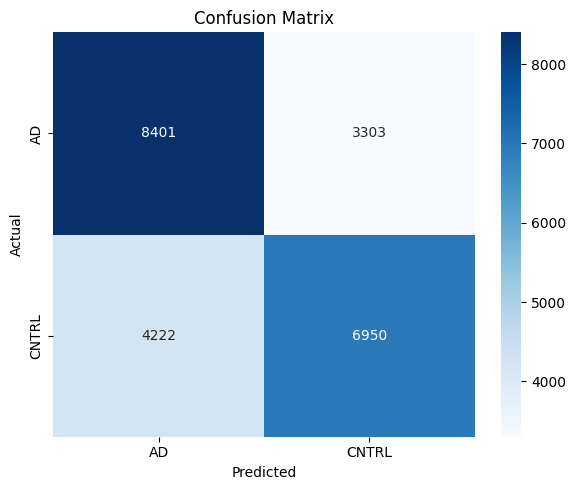

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(all_trues, all_preds, target_names=le.classes_))

cm = confusion_matrix(all_trues, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Subject-Level Accuracy: 0.8667 (13/15)


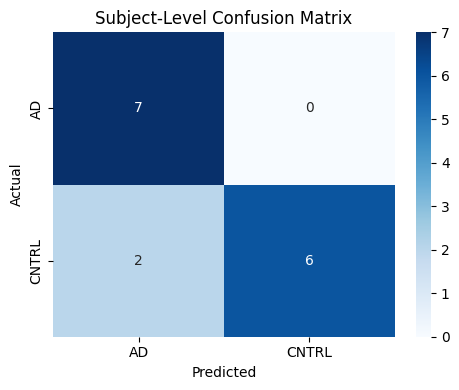

Subject-level classification report:
              precision    recall  f1-score   support

          AD       0.78      1.00      0.88         7
       CNTRL       1.00      0.75      0.86         8

    accuracy                           0.87        15
   macro avg       0.89      0.88      0.87        15
weighted avg       0.90      0.87      0.87        15

        Subject | True Label | Pred Label |   #AD |  #CNTRL
------------------------------------------------------------
    Subject_005 |      CNTRL |      CNTRL |    90 |    1088
    Subject_006 |      CNTRL |      CNTRL |   599 |     731
    Subject_011 |      CNTRL |         AD |   978 |     580
    Subject_012 |      CNTRL |      CNTRL |   298 |    1165
    Subject_013 |      CNTRL |      CNTRL |   423 |     774
    Subject_015 |      CNTRL |      CNTRL |   665 |     836
    Subject_017 |      CNTRL |         AD |   866 |     635
    Subject_018 |      CNTRL |      CNTRL |   303 |    1141
    Subject_004 |         AD |     

In [ ]:
# After majority voting:
subject_level_true = []
subject_level_pred = []

for subj, votes in subject_votes.items():
    final_pred = Counter(votes).most_common(1)[0][0]
    subject_level_pred.append(final_pred)
    subject_level_true.append(subject_true[subj])

# Print subject-level accuracy
acc = np.mean(np.array(subject_level_pred) == np.array(subject_level_true))
print(f"Subject-Level Accuracy: {acc:.4f} ({sum(np.array(subject_level_pred) == np.array(subject_level_true))}/{len(subject_level_true)})")

# Subject-level confusion matrix
cm_subject = confusion_matrix(subject_level_true, subject_level_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm_subject, annot=True, fmt="d",
            xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Subject-Level Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Subject-level classification report
print("Subject-level classification report:")
print(classification_report(subject_level_true, subject_level_pred, target_names=le.classes_))



idx_to_label = dict(enumerate(le.classes_))
subject_names = list(subject_votes.keys())

print(f"{'Subject':>15} | {'True Label':>10} | {'Pred Label':>10} | {'#AD':>5} | {'#CNTRL':>7}")
print('-'*60)
for subj, true_idx, pred_idx in zip(subject_names, subject_level_true, subject_level_pred):
    img_preds = subject_votes[subj]
    # Count predictions for each class
    count_AD = sum(1 for p in img_preds if idx_to_label[p] == "AD")
    count_CNTRL = sum(1 for p in img_preds if idx_to_label[p] == "CNTRL")
    true_label = idx_to_label[true_idx]
    pred_label = idx_to_label[pred_idx]
    print(f"{subj:>15} | {true_label:>10} | {pred_label:>10} | {count_AD:5d} | {count_CNTRL:7d}")


#### No need external libraries

Collected saliency maps -> AD=200, CNTRL=200


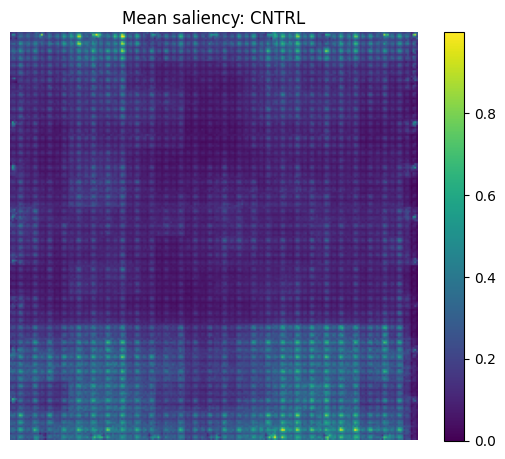

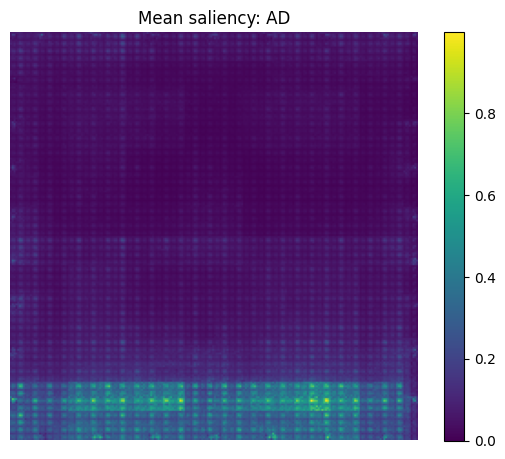

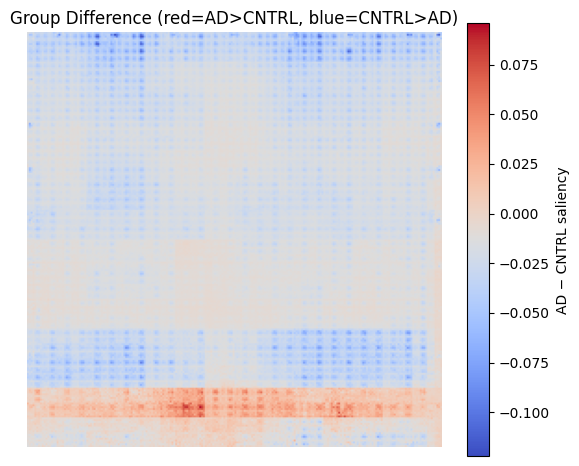

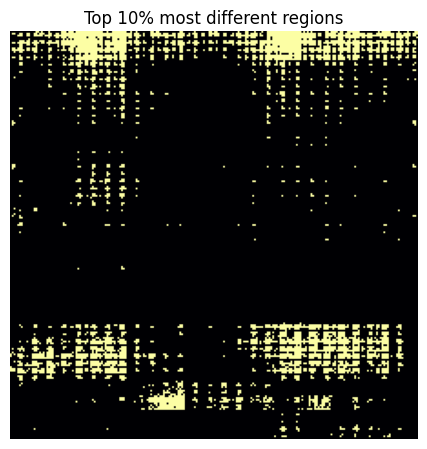

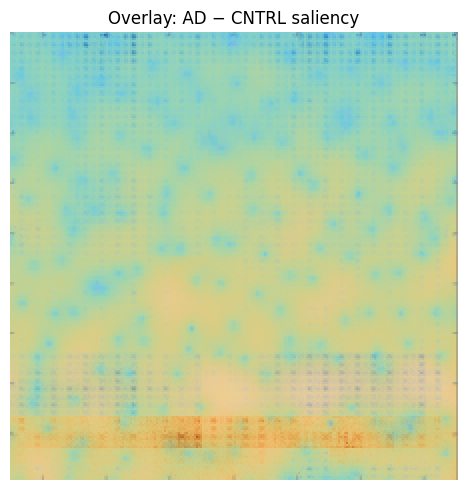

In [ ]:
# ========= FAST XAI (fixed; no nonlocal, no extra installs) =========
import torch, numpy as np, matplotlib.pyplot as plt

model.eval()
device = next(model.parameters()).device

# --- resolve class indices ---
classes = list(le.classes_)
assert "AD" in classes and "CNTRL" in classes, f"LabelEncoder classes must include AD and CNTRL, got: {classes}"
idx_AD, idx_CNTRL = classes.index("AD"), classes.index("CNTRL")

@torch.no_grad()
def get_preds(imgs):
    out = model(imgs.to(device))
    return out.argmax(1).cpu()

def saliency_batch(model, imgs, target_idx):
    imgs = imgs.to(device).float().requires_grad_(True)
    model.zero_grad(set_to_none=True)
    logits = model(imgs)
    scores = logits[torch.arange(imgs.size(0), device=device), target_idx.to(device)]
    scores.sum().backward()
    grads = imgs.grad.detach().abs()              # [B,3,H,W]
    sal = grads.max(dim=1).values                 # [B,H,W]
    # normalize per image to [0,1]
    B,H,W = sal.shape
    sal = sal.view(B,-1)
    mins = sal.min(dim=1, keepdim=True).values
    maxs = sal.max(dim=1, keepdim=True).values
    sal = ((sal - mins) / (maxs - mins + 1e-8)).view(B,H,W).cpu()
    return sal

# -------- aggregate group-wise mean saliency on a subset --------
max_per_group   = 200    # lower (e.g., 50–100) for speed
only_correct    = True   # keep only correctly classified samples
use_true_target = True   # target = true labels (or set False to use predicted)

sum_ad, sum_hc = None, None
n_ad, n_hc = 0, 0

for imgs, labels, _ in test_loader:
    if n_ad >= max_per_group and n_hc >= max_per_group:
        break

    preds = get_preds(imgs)
    keep = (preds == labels) if only_correct else torch.ones_like(labels, dtype=torch.bool)

    # process AD
    if n_ad < max_per_group:
        mask = keep & (labels == idx_AD)
        if mask.any():
            sel = mask.nonzero(as_tuple=False).squeeze(1)[: (max_per_group - n_ad)]
            t_idx = (labels if use_true_target else preds)[sel]
            sal = saliency_batch(model, imgs[sel], t_idx)    # [b,H,W]
            s = sal.sum(dim=0)                               # [H,W]
            sum_ad = s if sum_ad is None else sum_ad + s
            n_ad += sal.shape[0]

    # process CNTRL
    if n_hc < max_per_group:
        mask = keep & (labels == idx_CNTRL)
        if mask.any():
            sel = mask.nonzero(as_tuple=False).squeeze(1)[: (max_per_group - n_hc)]
            t_idx = (labels if use_true_target else preds)[sel]
            sal = saliency_batch(model, imgs[sel], t_idx)
            s = sal.sum(dim=0)
            sum_hc = s if sum_hc is None else sum_hc + s
            n_hc += sal.shape[0]

print(f"Collected saliency maps -> AD={n_ad}, CNTRL={n_hc}")
assert sum_ad is not None and sum_hc is not None, "Not enough samples collected."

mean_ad  = (sum_ad / max(n_ad,1)).numpy()
mean_hc  = (sum_hc / max(n_hc,1)).numpy()
diff_map = mean_ad - mean_hc  # >0 : more AD-salient; <0 : more CNTRL-salient

# -------- visualize --------
def show_map(m, title, cmap="viridis"):
    mm = (m - m.min()) / (m.max() - m.min() + 1e-8)
    plt.figure(figsize=(5.4,4.6)); plt.imshow(mm, cmap=cmap)
    plt.title(title); plt.axis("off"); plt.colorbar(); plt.tight_layout(); plt.show()

show_map(mean_hc, "Mean saliency: CNTRL")
show_map(mean_ad, "Mean saliency: AD")

plt.figure(figsize=(5.8,4.8))
plt.imshow(diff_map, cmap="coolwarm")
plt.colorbar(label="AD − CNTRL saliency")
plt.title("Group Difference (red=AD>CNTRL, blue=CNTRL>AD)")
plt.axis("off"); plt.tight_layout(); plt.show()

# Top-k% most different regions (mask)
k = 0.10
thr = np.quantile(np.abs(diff_map).ravel(), 1 - k)
mask = (np.abs(diff_map) >= thr).astype(float)
plt.figure(figsize=(5.4,4.6)); plt.imshow(mask, cmap="inferno")
plt.title(f"Top {int(k*100)}% most different regions"); plt.axis("off"); plt.tight_layout(); plt.show()

# Optional overlay on a sample CWT image
sample_imgs, _, _ = next(iter(test_loader))
bg = (sample_imgs[0]*0.5 + 0.5).permute(1,2,0).clamp(0,1).cpu().numpy()
d_norm = (diff_map - diff_map.min()) / (diff_map.max() - diff_map.min() + 1e-8)
plt.figure(figsize=(6,5)); plt.imshow(bg); plt.imshow(d_norm, alpha=0.55, cmap="coolwarm")
plt.title("Overlay: AD − CNTRL saliency"); plt.axis("off"); plt.tight_layout(); plt.show()


In [ ]:
# ===================== SAVE XAI MAPS + DOWNLOAD (Colab) =====================
import os, json, csv, zipfile
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

RUN_TAG = "fold1_post_EC"   # <<<< your requested tag
OUT_ROOT = Path("/content/xai_exports")
OUT_DIR  = OUT_ROOT / RUN_TAG
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Helper: save array as PNG (0..1 normalize if needed) and as .npy and .csv
def save_array_all(name, arr, cmap="viridis"):
    base = f"{RUN_TAG}__{name}"
    arr = np.asarray(arr)
    # npy
    np.save(OUT_DIR / f"{base}.npy", arr)
    # csv (2D only)
    if arr.ndim == 2:
        with open(OUT_DIR / f"{base}.csv", "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerows(arr.tolist())
    # png
    a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
    plt.figure(figsize=(6,5))
    plt.imshow(a, cmap=cmap)
    plt.title(base)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"{base}.png", dpi=200, bbox_inches="tight")
    plt.close()

# Save the group maps
save_array_all("mean_cntrl_saliency", mean_hc, cmap="viridis")
save_array_all("mean_ad_saliency",    mean_ad, cmap="viridis")
save_array_all("diff_ad_minus_cntrl", diff_map, cmap="coolwarm")
save_array_all("topk_mask",           mask, cmap="inferno")

# Save an overlay PNG (assumes 'bg' and 'd_norm' already exist)
plt.figure(figsize=(6,5))
plt.imshow(bg)
plt.imshow(d_norm, alpha=0.55, cmap="coolwarm")
plt.title(f"{RUN_TAG}__overlay_ad_minus_cntrl")
plt.axis("off")
plt.tight_layout()
plt.savefig(OUT_DIR / f"{RUN_TAG}__overlay_ad_minus_cntrl.png", dpi=200, bbox_inches="tight")
plt.close()

# Save a small JSON with run meta
meta = {
    "run_tag": RUN_TAG,
    "n_used_AD": int(n_ad),
    "n_used_CNTRL": int(n_hc),
    "k_top_percent": float(k),
    "abs_threshold": float(thr),
    "classes": classes,
}
with open(OUT_DIR / f"{RUN_TAG}__metadata.json", "w") as f:
    json.dump(meta, f, indent=2)

# -------- OPTIONAL: SAVE PER-IMAGE SALIENCY MAPS (can be heavy!) ----------
SAVE_PER_IMAGE = False     # set True if you want every selected image saved
PER_IMG_LIMIT  = 200       # safety limit (per group)

if SAVE_PER_IMAGE:
    PER_DIR = OUT_DIR / "per_image_saliency"
    PER_DIR.mkdir(parents=True, exist_ok=True)

    saved_ad = 0
    saved_hc = 0
    for imgs, labels, paths in test_loader:
        if saved_ad >= PER_IMG_LIMIT and saved_hc >= PER_IMG_LIMIT:
            break
        preds = get_preds(imgs)
        keep = (preds == labels) if only_correct else torch.ones_like(labels, dtype=torch.bool)

        # AD group
        if saved_ad < PER_IMG_LIMIT:
            mask_ad = keep & (labels == idx_AD)
            if mask_ad.any():
                sel = mask_ad.nonzero(as_tuple=False).squeeze(1)
                sel = sel[: max(0, PER_IMG_LIMIT - saved_ad)]
                t_idx = (labels if use_true_target else preds)[sel]
                sal = saliency_batch(model, imgs[sel], t_idx)    # [b,H,W]
                for i, si in enumerate(sal):
                    subj_dir = Path(paths[sel[i]]).parent.name
                    base = Path(paths[sel[i]]).stem
                    arr = si.numpy()
                    np.save(PER_DIR / f"{RUN_TAG}__{subj_dir}__{base}__AD.npy", arr)
                    a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
                    plt.figure(figsize=(5,4))
                    plt.imshow(a, cmap="viridis")
                    plt.title(f"{RUN_TAG} :: {subj_dir} :: {base} :: AD")
                    plt.axis("off"); plt.tight_layout()
                    plt.savefig(PER_DIR / f"{RUN_TAG}__{subj_dir}__{base}__AD.png", dpi=160, bbox_inches="tight")
                    plt.close()
                saved_ad += sal.shape[0]

        # CNTRL group
        if saved_hc < PER_IMG_LIMIT:
            mask_hc = keep & (labels == idx_CNTRL)
            if mask_hc.any():
                sel = mask_hc.nonzero(as_tuple=False).squeeze(1)
                sel = sel[: max(0, PER_IMG_LIMIT - saved_hc)]
                t_idx = (labels if use_true_target else preds)[sel]
                sal = saliency_batch(model, imgs[sel], t_idx)
                for i, si in enumerate(sal):
                    subj_dir = Path(paths[sel[i]]).parent.name
                    base = Path(paths[sel[i]]).stem
                    arr = si.numpy()
                    np.save(PER_DIR / f"{RUN_TAG}__{subj_dir}__{base}__CNTRL.npy", arr)
                    a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
                    plt.figure(figsize=(5,4))
                    plt.imshow(a, cmap="viridis")
                    plt.title(f"{RUN_TAG} :: {subj_dir} :: {base} :: CNTRL")
                    plt.axis("off"); plt.tight_layout()
                    plt.savefig(PER_DIR / f"{RUN_TAG}__{subj_dir}__{base}__CNTRL.png", dpi=160, bbox_inches="tight")
                    plt.close()
                saved_hc += sal.shape[0]

# -------- ZIP + DOWNLOAD (Colab) ----------
ZIP_PATH = f"/content/xai_exports_{RUN_TAG}.zip"
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for p in OUT_ROOT.rglob("*"):
        zf.write(p, arcname=p.relative_to(OUT_ROOT.parent))

print(f"Saved XAI exports to: {OUT_DIR}")
print(f"Zipped at: {ZIP_PATH}")

try:
    from google.colab import files
    files.download(ZIP_PATH)
except Exception as e:
    print("Colab download not available in this environment:", e)
    print("You can also copy the folder to Drive, e.g.:")
    print("!mkdir -p '/content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports' && cp -r /content/xai_exports '/content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports'")
# =====================================================================


Saved XAI exports to: /content/xai_exports/fold1_post_EC
Zipped at: /content/xai_exports_fold1_post_EC.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# import torch, numpy as np, matplotlib.pyplot as plt
# import torch.nn.functional as F

# def make_patch_masks(H, W, patch=32, stride=32, device="cpu"):
#     ys = list(range(0, H - patch + 1, stride))
#     xs = list(range(0, W - patch + 1, stride))
#     masks = []
#     for y in ys:
#         for x in xs:
#             m = torch.zeros(1, 1, H, W, device=device)
#             m[:, :, y:y+patch, x:x+patch] = 1.0
#             masks.append(m)
#     return torch.cat(masks, dim=0), len(ys), len(xs)  # [K,1,H,W], Gy, Gx

# def occlusion_saliency_batch(model, imgs, target_idx, patch=32, stride=32, fill_val=0.0, chunk_masks=8):
#     """
#     Returns coarse heatmaps [B,H,W] using patch occlusion. No grads, just forward passes.
#     """
#     device = imgs.device
#     B, C, H, W = imgs.shape
#     masks, Gy, Gx = make_patch_masks(H, W, patch=patch, stride=stride, device=device)  # [K,1,H,W]
#     K = masks.shape[0]

#     with torch.no_grad():
#         base = model(imgs)  # [B,C]
#         base_t = base[torch.arange(B), target_idx]  # [B]
#     heat = torch.zeros(B, H, W, device=device)

#     # Process masks in chunks to control memory
#     for i in range(0, K, chunk_masks):
#         m = masks[i:i+chunk_masks]                     # [m,1,H,W]
#         # Broadcast to [B,m,3,H,W]
#         x_occ = imgs.unsqueeze(1) * (1 - m) + fill_val * m
#         x_occ = x_occ.view(-1, C, H, W)               # [B*m,3,H,W]
#         with torch.no_grad():
#             logits = model(x_occ)                     # [B*m,C]
#             logits = logits.view(B, -1, base.shape[1])# [B,m,C]
#             scores = logits[..., target_idx.view(B,1)]# [B,m,1]
#             scores = scores.squeeze(-1)               # [B,m]
#         drop = (base_t.unsqueeze(1) - scores).clamp_min(0.0)  # [B,m]

#         # Paint the drop back onto the corresponding patch areas
#         # (uniformly add the drop value over that patch)
#         for jj in range(m.shape[0]):
#             yx = (i + jj)
#             y_idx = (yx // Gx) * stride
#             x_idx = (yx %  Gx) * stride
#             heat[:, y_idx:y_idx+patch, x_idx:x_idx+patch] += drop[:, jj].unsqueeze(-1).unsqueeze(-1)

#     # Normalize per image
#     B = heat.size(0)
#     heat = heat.view(B, -1)
#     heat = (heat - heat.min(dim=1, keepdim=True).values) / (heat.max(dim=1, keepdim=True).values - heat.min(dim=1, keepdim=True).values + 1e-8)
#     heat = heat.view(B, H, W)
#     return heat

# # Aggregate per group (same pattern as above)
# max_per_group = 80          # keep small; occlusion is heavier than saliency
# only_correct  = True
# use_true_target = True
# patch, stride = 32, 32
# chunk_masks   = 8

# sum_ad = None; n_ad = 0
# sum_hc = None; n_hc = 0

# for imgs, labels, _ in test_loader:
#     if n_ad >= max_per_group and n_hc >= max_per_group:
#         break
#     preds = get_preds(imgs)
#     keep = (preds == labels) if only_correct else torch.ones_like(labels, dtype=torch.bool)
#     for group_idx, is_ad in [(idx_AD, True), (idx_CNTRL, False)]:
#         m = keep & (labels == group_idx)
#         if m.sum() == 0:
#             continue
#         budget = (max_per_group - (n_ad if is_ad else n_hc))
#         if budget <= 0:
#             continue
#         sel = m.nonzero(as_tuple=False).squeeze(1)[:budget]
#         t_idx = (labels if use_true_target else preds)[sel]
#         heat = occlusion_saliency_batch(model, imgs[sel].to(device), t_idx.to(device),
#                                         patch=patch, stride=stride, chunk_masks=chunk_masks)  # [b,H,W]
#         s = heat.sum(dim=0)
#         if is_ad:
#             sum_ad = s if sum_ad is None else sum_ad + s
#             n_ad  += heat.shape[0]
#         else:
#             sum_hc = s if sum_hc is None else sum_hc + s
#             n_hc  += heat.shape[0]

# print(f"[Occlusion] Collected: AD={n_ad}, CNTRL={n_hc}")
# mean_ad_occ = (sum_ad / max(n_ad,1)).cpu().numpy()
# mean_hc_occ = (sum_hc / max(n_hc,1)).cpu().numpy()
# diff_occ    = mean_ad_occ - mean_hc_occ

# plt.figure(figsize=(5.6,4.8))
# plt.imshow(diff_occ, cmap="coolwarm")
# plt.colorbar(label="AD − CNTRL (occlusion)")
# plt.title("Group Difference via Patch-Occlusion")
# plt.axis("off"); plt.tight_layout(); plt.show()


In [ ]:
# ===================== SAVE TO GOOGLE DRIVE (+ RAR) =====================
import shutil, subprocess
from pathlib import Path

# Mount Drive (safe to call even if already mounted)
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

DRIVE_BASE = Path('/content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports')
DRIVE_BASE.mkdir(parents=True, exist_ok=True)

# 1) Copy the run folder to Drive
DRIVE_RUN_DIR = DRIVE_BASE / RUN_TAG
if DRIVE_RUN_DIR.exists():
    shutil.rmtree(DRIVE_RUN_DIR)
shutil.copytree(OUT_DIR, DRIVE_RUN_DIR)

# 2) Copy the ZIP to Drive
DRIVE_ZIP = DRIVE_BASE / f"xai_exports_{RUN_TAG}.zip"
shutil.copy2(ZIP_PATH, DRIVE_ZIP)

print(f"Copied to Drive folder: {DRIVE_RUN_DIR}")
print(f"Copied ZIP to Drive:    {DRIVE_ZIP}")

# 3) OPTIONAL: Create a RAR archive directly in Drive
#    This installs 'rar' (non-free) in the Colab VM, then writes a .rar into Drive.
try:
    print("Attempting to create RAR in Drive...")
    subprocess.run(["apt-get", "update", "-y"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    subprocess.run(["apt-get", "install", "-y", "rar"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)

    DRIVE_RAR = DRIVE_BASE / f"xai_exports_{RUN_TAG}.rar"
    # 'rar a -r <archive> <folder_to_add>'  (-r = recurse)
    # Use the *parent* of OUT_DIR so it stores the folder name inside the archive neatly
    subprocess.run(["rar", "a", "-r", str(DRIVE_RAR), str(OUT_DIR)], check=True)

    print(f"RAR saved to Drive:     {DRIVE_RAR}")
except Exception as e:
    print("Could not create .rar (keeping .zip). Error:", e)
# ======================================================================


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copied to Drive folder: /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports/fold1_post_EC
Copied ZIP to Drive:    /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports/xai_exports_fold1_post_EC.zip
Attempting to create RAR in Drive...
RAR saved to Drive:     /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports/xai_exports_fold1_post_EC.rar


#### New XAI (IG + SmoothGrad IG)

In [ ]:
# # ========================= XAI (IG + SmoothGrad IG) =========================
# import os, json, csv, zipfile, math, subprocess, shutil
# from pathlib import Path
# from collections import defaultdict, Counter

# import numpy as np
# import torch
# import torch.nn.functional as F
# import matplotlib.pyplot as plt

# # ------------------------ CONFIG ------------------------
# RUN_TAG          = "fold1_post_EC_IG_SGIG"  # customize per run
# OUT_ROOT         = Path("/content/xai_exports")
# OUT_DIR          = OUT_ROOT / RUN_TAG
# OUT_DIR.mkdir(parents=True, exist_ok=True)

# # Saliency collection
# MAX_PER_GROUP_IG    = 200   # how many correctly-classified images per group for IG
# MAX_PER_GROUP_SGIG  = 200   # for SmoothGradIG
# USE_TRUE_TARGET     = True  # True -> IG wrt true label; False -> wrt predicted class

# # Integrated Gradients settings
# IG_STEPS         = 32       # Riemann steps along the path
# BASELINE_KIND    = "zero"   # "zero" or "black" (zero is fine; inputs are normalized)

# # SmoothGrad IG settings
# SG_N_SAMPLES     = 25
# SG_NOISE_SIGMA   = 0.10     # noise std in input space (on normalized scale)

# # Significance testing (optional)
# DO_STAT_TEST     = False           # flip to True to compute pixel-wise tests (heavier)
# SIG_MAX_PER_GRP  = 120             # cap #images per group for stats to save memory
# ALPHA_FDR        = 0.05            # FDR level

# # Frequency axis (low frequency at bottom row)
# FREQ_MIN = 0.5   # Hz
# FREQ_MAX = 45.0  # Hz

# # Bands (name, low, high) in Hz
# BAND_EDGES = [
#     ("delta", 0.5, 4.0),
#     ("theta", 4.0, 8.0),
#     ("alpha", 8.0, 13.0),
#     ("beta", 13.0, 30.0),
#     ("gamma", 30.0, 45.0),
# ]

# # --------------------- helpers: saving -------------------
# def save_array_all(name, arr, cmap="viridis"):
#     """Save arr as .npy, .csv (if 2D), and .png."""
#     base = f"{RUN_TAG}__{name}"
#     arr = np.asarray(arr)
#     # npy
#     np.save(OUT_DIR / f"{base}.npy", arr)
#     # csv (2D only)
#     if arr.ndim == 2:
#         with open(OUT_DIR / f"{base}.csv", "w", newline="") as f:
#             writer = csv.writer(f)
#             writer.writerows(arr.tolist())
#     # png (0..1 normalize for viewing)
#     a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8) if arr.size else arr
#     plt.figure(figsize=(6,5))
#     plt.imshow(a, cmap=cmap)
#     plt.title(base)
#     plt.axis("off")
#     plt.tight_layout()
#     plt.savefig(OUT_DIR / f"{base}.png", dpi=200, bbox_inches="tight")
#     plt.close()

# def save_overlay(bg_img_hwc01, heat_2d, name, cmap="coolwarm", alpha=0.55):
#     """bg_img_hwc01 in [0,1], heat_2d any real values."""
#     base = f"{RUN_TAG}__{name}"
#     h = (heat_2d - heat_2d.min()) / (heat_2d.max() - heat_2d.min() + 1e-8)
#     plt.figure(figsize=(6,5))
#     plt.imshow(bg_img_hwc01)
#     plt.imshow(h, alpha=alpha, cmap=cmap)
#     plt.title(base)
#     plt.axis("off")
#     plt.tight_layout()
#     plt.savefig(OUT_DIR / f"{base}.png", dpi=200, bbox_inches="tight")
#     plt.close()

# # ------------------ helpers: IG & SmoothGrad IG ------------------
# def _make_baseline_like(img):
#     # img: [3,H,W]
#     if BASELINE_KIND == "zero":
#         return torch.zeros_like(img)
#     elif BASELINE_KIND == "black":
#         return torch.zeros_like(img)  # same for normalized inputs
#     else:
#         return torch.zeros_like(img)

# @torch.no_grad()
# def get_preds(imgs, model):
#     out = model(imgs.to(device))
#     return out.argmax(1).cpu()

# def integrated_gradients(model, imgs, target_idx, steps=32):
#     """
#     Robust IG: works for [B,3,H,W] or [3,H,W], returns [B,H,W] (abs-mean over channels).
#     Force-enables autograd for the forward/backward.
#     """
#     model.eval()
#     device_local = next(model.parameters()).device

#     # ---- enforce shapes on inputs/targets ----
#     if imgs.dim() == 3:   # [3,H,W] -> [1,3,H,W]
#         imgs = imgs.unsqueeze(0)
#     imgs = imgs.to(device_local)

#     if isinstance(target_idx, (int,)):
#         target_idx = torch.tensor([target_idx], device=device_local, dtype=torch.long)
#     else:
#         target_idx = target_idx.to(device_local)
#         if target_idx.dim() == 0:
#             target_idx = target_idx.unsqueeze(0)

#     B, C, H, W = imgs.shape
#     alphas = torch.linspace(0., 1., steps + 1, device=device_local)  # [steps+1]
#     sal_out = torch.zeros(B, H, W, device=device_local)

#     # IG per sample for stability
#     for i in range(B):
#         x = imgs[i:i+1].clone()                     # [1,3,H,W]
#         y_idx = int(target_idx[i].item())
#         baseline = torch.zeros_like(x)              # [1,3,H,W]

#         # Path: [steps+1, 1, 3, H, W]
#         path = baseline + alphas.view(-1, 1, 1, 1) * (x - baseline)

#         grads_sum = torch.zeros_like(x)
#         # ensure autograd is enabled for these iterations
#         for t in range(path.shape[0]):
#             xt = path[t]
#             if xt.dim() == 3:
#                 xt = xt.unsqueeze(0)
#             xt = xt.clone().detach().requires_grad_(True)

#             # ---- enable grad just for this forward/backward ----
#             with torch.enable_grad():
#                 logits = model(xt)                  # [1,num_classes], must carry grad_fn
#                 score = logits[:, y_idx].sum()      # scalar
#                 model.zero_grad(set_to_none=True)
#                 score.backward()

#             grads_sum = grads_sum + xt.grad.detach()

#         grads_mean = grads_sum / float(steps + 1)
#         ig = (x - baseline) * grads_mean            # [1,3,H,W]
#         ig = ig.abs().mean(dim=1).squeeze(0)        # [H,W]
#         sal_out[i] = ig

#     return sal_out  # [B,H,W]


# def smoothgrad_ig(model, imgs, target_idx, steps=32, n_samples=25, noise_sigma=0.10):
#     """
#     SmoothGrad over IG; returns [B,H,W]. Force-enables autograd internally.
#     """
#     model.eval()
#     device_local = next(model.parameters()).device

#     if imgs.dim() == 3:
#         imgs = imgs.unsqueeze(0)
#     imgs = imgs.to(device_local)

#     if isinstance(target_idx, (int,)):
#         target_idx = torch.tensor([target_idx], device=device_local, dtype=torch.long)
#     else:
#         target_idx = target_idx.to(device_local)
#         if target_idx.dim() == 0:
#             target_idx = target_idx.unsqueeze(0)

#     B, C, H, W = imgs.shape
#     out = torch.zeros(B, H, W, device=device_local)

#     for _ in range(n_samples):
#         noise = torch.randn_like(imgs) * noise_sigma
#         noisy = (imgs + noise).clamp(-1.0, 1.0)
#         # IG itself uses enable_grad(), so we can call it directly
#         out += integrated_gradients(model, noisy, target_idx, steps=steps)

#     out /= float(n_samples)
#     return out

# # ---------------------- helpers: aggregation ----------------------
# def aggregate_group_mean(sal_batch, sum_group, n_group):
#     """sal_batch: [b,H,W] to add; returns updated (sum,n)."""
#     if sal_batch is None or sal_batch.numel() == 0:
#         return sum_group, n_group
#     s = sal_batch.sum(dim=0)  # [H,W]
#     sum_group = s if sum_group is None else (sum_group + s)
#     n_group += sal_batch.shape[0]
#     return sum_group, n_group

# def to_numpy_norm(x):
#     x = x.detach().float().cpu().numpy()
#     return x

# def topk_mask_from_abs(arr2d, frac=0.10):
#     """Return binary mask of top-|arr| pixels covering 'frac' of total pixels."""
#     a = np.abs(arr2d)
#     flat = a.ravel()
#     k = max(1, int(round(frac * flat.size)))
#     thr = np.partition(flat, -k)[-k]  # k-th largest
#     return (a >= thr).astype(np.float32), float(thr)

# # ---------------------- helpers: band coverage --------------------
# def percent_band_coverage(mask, band_edges, freq_min=FREQ_MIN, freq_max=FREQ_MAX):
#     """
#     mask: [H,W] binary (1=selected), low frequency at bottom (y=H-1 -> freq_min).
#     returns dict band_name -> percent of mask pixels in that band.
#     """
#     H, W = mask.shape
#     total = mask.sum()
#     if total == 0:
#         return {name: 0.0 for (name,_,_) in band_edges}
#     yy = np.arange(H)  # 0..H-1 top->bottom
#     # y=0 -> freq_max, y=H-1 -> freq_min
#     freq = freq_min + (1.0 - yy / max(H-1,1)) * (freq_max - freq_min)
#     out = {}
#     for (name, f_lo, f_hi) in band_edges:
#         rows = (freq >= f_lo) & (freq < f_hi)
#         band_total = mask[rows, :].sum()
#         out[name] = 100.0 * float(band_total) / float(total)
#     return out

# # ------------------------ collect saliencies ----------------------
# model.eval()
# classes = list(le.classes_)
# assert "AD" in classes and "CNTRL" in classes
# idx_AD, idx_CNTRL = classes.index("AD"), classes.index("CNTRL")

# sum_ad_ig = None; sum_hc_ig = None; n_ad_ig = 0; n_hc_ig = 0
# sum_ad_sg = None; sum_hc_sg = None; n_ad_sg = 0; n_hc_sg = 0

# # For overlay (background)
# try:
#     sample_imgs, sample_labels, sample_paths = next(iter(test_loader))
#     bg = (sample_imgs[0]*0.5 + 0.5).permute(1,2,0).clamp(0,1).cpu().numpy()
# except StopIteration:
#     bg = None

# with torch.no_grad():
#     for imgs, labels, paths in test_loader:
#         preds = get_preds(imgs, model)
#         keep = (preds == labels)  # only_correct=True

#         # ---- IG for AD ----
#         if n_ad_ig < MAX_PER_GROUP_IG:
#             m_ad = keep & (labels == idx_AD)
#             if m_ad.any():
#                 sel = m_ad.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_IG - n_ad_ig)]
#                 tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                 ig_batch = integrated_gradients(model, imgs[sel], tgt, steps=IG_STEPS) # [b,H,W]
#                 sum_ad_ig, n_ad_ig = aggregate_group_mean(ig_batch, sum_ad_ig, n_ad_ig)

#         # ---- IG for CNTRL ----
#         if n_hc_ig < MAX_PER_GROUP_IG:
#             m_hc = keep & (labels == idx_CNTRL)
#             if m_hc.any():
#                 sel = m_hc.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_IG - n_hc_ig)]
#                 tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                 ig_batch = integrated_gradients(model, imgs[sel], tgt, steps=IG_STEPS)
#                 sum_hc_ig, n_hc_ig = aggregate_group_mean(ig_batch, sum_hc_ig, n_hc_ig)

#         # ---- SG-IG for AD ----
#         if n_ad_sg < MAX_PER_GROUP_SGIG:
#             m_ad = keep & (labels == idx_AD)
#             if m_ad.any():
#                 sel = m_ad.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_SGIG - n_ad_sg)]
#                 tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                 sg_batch = smoothgrad_ig(model, imgs[sel], tgt, steps=IG_STEPS,
#                                          n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA)
#                 sum_ad_sg, n_ad_sg = aggregate_group_mean(sg_batch, sum_ad_sg, n_ad_sg)

#         # ---- SG-IG for CNTRL ----
#         if n_hc_sg < MAX_PER_GROUP_SGIG:
#             m_hc = keep & (labels == idx_CNTRL)
#             if m_hc.any():
#                 sel = m_hc.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_SGIG - n_hc_sg)]
#                 tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                 sg_batch = smoothgrad_ig(model, imgs[sel], tgt, steps=IG_STEPS,
#                                          n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA)
#                 sum_hc_sg, n_hc_sg = aggregate_group_mean(sg_batch, sum_hc_sg, n_hc_sg)

# print(f"[IG]    Collected: AD={n_ad_ig}, CNTRL={n_hc_ig}")
# print(f"[SG-IG] Collected: AD={n_ad_sg}, CNTRL={n_hc_sg}")
# assert n_ad_ig>0 and n_hc_ig>0 and n_ad_sg>0 and n_hc_sg>0, "Not enough samples collected."

# # ---------------------- group means & diffs ----------------------
# mean_ad_ig = to_numpy_norm(sum_ad_ig / max(n_ad_ig,1))
# mean_hc_ig = to_numpy_norm(sum_hc_ig / max(n_hc_ig,1))
# diff_ig    = mean_ad_ig - mean_hc_ig

# mean_ad_sg = to_numpy_norm(sum_ad_sg / max(n_ad_sg,1))
# mean_hc_sg = to_numpy_norm(sum_hc_sg / max(n_hc_sg,1))
# diff_sg    = mean_ad_sg - mean_hc_sg

# # ---------------------- top-k masks & band coverage --------------
# for frac in [0.10, 0.20]:
#     name = f"top{int(frac*100)}"
#     # IG
#     mask_ig, thr_ig = topk_mask_from_abs(diff_ig, frac=frac)
#     cov_ig = percent_band_coverage(mask_ig, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
#     save_array_all(f"{name}_mask_IG", mask_ig, cmap="inferno")
#     # SG-IG
#     mask_sg, thr_sg = topk_mask_from_abs(diff_sg, frac=frac)
#     cov_sg = percent_band_coverage(mask_sg, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
#     save_array_all(f"{name}_mask_SGIG", mask_sg, cmap="inferno")

#     # save band coverage as JSON
#     with open(OUT_DIR / f"{RUN_TAG}__{name}_band_coverage.json", "w") as f:
#         json.dump({
#             "fraction": frac,
#             "thresholds": {"IG": float(thr_ig), "SGIG": float(thr_sg)},
#             "coverage_percent": {"IG": cov_ig, "SGIG": cov_sg},
#             "bands_hz": BAND_EDGES,
#             "freq_min_max": [FREQ_MIN, FREQ_MAX]
#         }, f, indent=2)

# # ------------------------- save maps & overlays -------------------
# save_array_all("mean_ad_IG",   mean_ad_ig, cmap="viridis")
# save_array_all("mean_cntrl_IG",mean_hc_ig, cmap="viridis")
# save_array_all("diff_ADminusCNTRL_IG", diff_ig, cmap="coolwarm")

# save_array_all("mean_ad_SGIG",   mean_ad_sg, cmap="viridis")
# save_array_all("mean_cntrl_SGIG",mean_hc_sg, cmap="viridis")
# save_array_all("diff_ADminusCNTRL_SGIG", diff_sg, cmap="coolwarm")

# if bg is not None:
#     save_overlay(bg, diff_ig, "overlay_diff_IG")
#     save_overlay(bg, diff_sg, "overlay_diff_SGIG")

# # ------------------- OPTIONAL: significance test -----------------
# if DO_STAT_TEST:
#     print("Running pixel-wise Welch's t-test with BH-FDR...")
#     # Re-collect per-image saliency (capped) for both methods and groups
#     def collect_sal_per_image(method="IG", max_per_grp=SIG_MAX_PER_GRP):
#         ad_list, hc_list = [], []
#         with torch.no_grad():
#             for imgs, labels, paths in test_loader:
#                 preds = get_preds(imgs, model)
#                 keep  = (preds == labels)

#                 # AD
#                 if len(ad_list) < max_per_grp:
#                     m = keep & (labels == idx_AD)
#                     if m.any():
#                         sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, max_per_grp - len(ad_list))]
#                         tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                         if method == "IG":
#                             sal = integrated_gradients(model, imgs[sel], tgt, steps=IG_STEPS)
#                         else:
#                             sal = smoothgrad_ig(model, imgs[sel], tgt, steps=IG_STEPS,
#                                                 n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA)
#                         ad_list.append(sal.cpu().numpy())  # [b,H,W]

#                 # CNTRL
#                 if len(hc_list) < max_per_grp:
#                     m = keep & (labels == idx_CNTRL)
#                     if m.any():
#                         sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, max_per_grp - len(hc_list))]
#                         tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                         if method == "IG":
#                             sal = integrated_gradients(model, imgs[sel], tgt, steps=IG_STEPS)
#                         else:
#                             sal = smoothgrad_ig(model, imgs[sel], tgt, steps=IG_STEPS,
#                                                 n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA)
#                         hc_list.append(sal.cpu().numpy())

#                 if len(ad_list) >= max_per_grp and len(hc_list) >= max_per_grp:
#                     break

#         if len(ad_list)==0 or len(hc_list)==0:
#             return None, None
#         ad_arr = np.concatenate(ad_list, axis=0)  # [N_ad,H,W]
#         hc_arr = np.concatenate(hc_list, axis=0)  # [N_hc,H,W]
#         return ad_arr, hc_arr

#     def welch_ttest_map(ad_arr, hc_arr):
#         """
#         ad_arr, hc_arr: [N,H,W]; returns tmap [H,W], pmap [H,W]
#         """
#         Na, H, W = ad_arr.shape
#         Nh, _, _ = hc_arr.shape
#         mu_a = ad_arr.mean(axis=0)
#         mu_h = hc_arr.mean(axis=0)
#         var_a = ad_arr.var(axis=0, ddof=1)
#         var_h = hc_arr.var(axis=0, ddof=1)
#         # Welch t
#         num = mu_a - mu_h
#         den = np.sqrt(var_a/Na + var_h/Nh) + 1e-12
#         tmap = num / den

#         # Welch-Satterthwaite df
#         df = (var_a/Na + var_h/Nh)**2 / ((var_a**2)/(Na**2*(Na-1)+1e-12) + (var_h**2)/(Nh**2*(Nh-1)+1e-12) + 1e-12)

#         # two-sided p-values from t (approx via survival function of Student's t).
#         # To avoid extra deps, use Gaussian as a close approx when df is large:
#         # p ≈ 2*(1 - Φ(|t|))
#         from math import erf, sqrt
#         def norm_sf(x):  # 1 - CDF
#             return 0.5 * (1 - erf(x/np.sqrt(2)))
#         pmap = 2.0 * norm_sf(np.abs(tmap))
#         return tmap, pmap

#     def bh_fdr(pvals, alpha=0.05):
#         """Benjamini–Hochberg on flattened pvals; returns boolean reject mask (same shape)."""
#         shape = pvals.shape
#         p = pvals.ravel()
#         m = p.size
#         order = np.argsort(p)
#         ranked = p[order]
#         thresh = alpha * (np.arange(1, m+1) / m)
#         passed = ranked <= thresh
#         if not np.any(passed):
#             return np.zeros_like(pvals, dtype=bool)
#         kmax = np.max(np.where(passed)[0])
#         cutoff = ranked[kmax]
#         return (pvals <= cutoff).reshape(shape)

#     for method_name, mean_ad, mean_hc, diff_map in [
#         ("IG",   mean_ad_ig, mean_hc_ig, diff_ig),
#         ("SGIG", mean_ad_sg, mean_hc_sg, diff_sg),
#     ]:
#         data_ad, data_hc = collect_sal_per_image(method=method_name, max_per_grp=SIG_MAX_PER_GRP)
#         if data_ad is None or data_hc is None:
#             print(f"[{method_name}] Not enough data for stats; skipping.")
#             continue
#         tmap, pmap = welch_ttest_map(data_ad, data_hc)
#         sig_mask = bh_fdr(pmap, alpha=ALPHA_FDR).astype(np.float32)
#         save_array_all(f"sigmask_{method_name}_FDR{int(ALPHA_FDR*100)}", sig_mask, cmap="gray")
#         # band coverage on significance mask
#         cov_sig = percent_band_coverage(sig_mask, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
#         with open(OUT_DIR / f"{RUN_TAG}__sigmask_{method_name}_band_coverage.json", "w") as f:
#             json.dump({"coverage_percent": cov_sig,
#                        "alpha_FDR": ALPHA_FDR,
#                        "bands_hz": BAND_EDGES,
#                        "freq_min_max": [FREQ_MIN, FREQ_MAX]}, f, indent=2)

# # ---------------------- write small metadata ---------------------
# meta = {
#     "run_tag": RUN_TAG,
#     "ig": {"n_ad": int(n_ad_ig), "n_cntrl": int(n_hc_ig), "steps": IG_STEPS, "baseline": BASELINE_KIND},
#     "sgig": {"n_ad": int(n_ad_sg), "n_cntrl": int(n_hc_sg),
#              "steps": IG_STEPS, "n_samples": SG_N_SAMPLES, "noise_sigma": SG_NOISE_SIGMA},
#     "bands_hz": BAND_EDGES,
#     "freq_min_max": [FREQ_MIN, FREQ_MAX],
#     "top_masks": ["10%","20%"],
#     "significance_test": {"enabled": bool(DO_STAT_TEST), "alpha_FDR": ALPHA_FDR}
# }
# with open(OUT_DIR / f"{RUN_TAG}__metadata.json", "w") as f:
#     json.dump(meta, f, indent=2)

# # ------------------------- ZIP + (optional) download --------------
# ZIP_PATH = f"/content/xai_exports_{RUN_TAG}.zip"
# with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as zf:
#     for p in OUT_ROOT.rglob("*"):
#         zf.write(p, arcname=p.relative_to(OUT_ROOT.parent))

# print(f"Saved XAI exports to: {OUT_DIR}")
# print(f"Zipped at: {ZIP_PATH}")

# try:
#     from google.colab import files
#     files.download(ZIP_PATH)
# except Exception as e:
#     print("Colab files.download not available here:", e)

# # ------------------------ SAVE TO GOOGLE DRIVE (+ RAR) -------------
# from google.colab import drive as _drive
# _drive.mount('/content/drive', force_remount=False)

# DRIVE_BASE = Path('/content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports')
# DRIVE_BASE.mkdir(parents=True, exist_ok=True)

# # 1) Copy the run folder to Drive
# DRIVE_RUN_DIR = DRIVE_BASE / RUN_TAG
# if DRIVE_RUN_DIR.exists():
#     shutil.rmtree(DRIVE_RUN_DIR)
# shutil.copytree(OUT_DIR, DRIVE_RUN_DIR)

# # 2) Copy the ZIP to Drive
# DRIVE_ZIP = DRIVE_BASE / f"xai_exports_{RUN_TAG}.zip"
# shutil.copy2(ZIP_PATH, DRIVE_ZIP)

# print(f"Copied to Drive folder: {DRIVE_RUN_DIR}")
# print(f"Copied ZIP to Drive:    {DRIVE_ZIP}")

# # 3) OPTIONAL: Create a RAR archive directly in Drive
# try:
#     print("Attempting to create RAR in Drive...")
#     subprocess.run(["apt-get", "update", "-y"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
#     subprocess.run(["apt-get", "install", "-y", "rar"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
#     DRIVE_RAR = DRIVE_BASE / f"xai_exports_{RUN_TAG}.rar"
#     subprocess.run(["rar", "a", "-r", str(DRIVE_RAR), str(OUT_DIR)], check=True)
#     print(f"RAR saved to Drive:     {DRIVE_RAR}")
# except Exception as e:
#     print("Could not create .rar (keeping .zip). Error:", e)
# # ===================================================================


In [ ]:
# ========================= FAST XAI (IG + SmoothGrad IG) =========================

# ---- NEW knobs (safe defaults) ----
B_MICRO_IG   = 4    # images per IG micro-batch (raise to 2/4 if VRAM allows)
B_MICRO_SG   = 4    # images per SG-IG micro-batch
ALPHA_CHUNK  = 8    # alpha steps per chunk (you had 8 before)
PATH_MICRO   = 16   # forward this many path samples at once (limits peak memory)

#====================================================================================================
import os, json, csv, zipfile, math, subprocess, shutil
from pathlib import Path
from collections import defaultdict, Counter

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ------------------------ SPEED PRESET ------------------------
# Choose: "fast" (recommended for iteration) or "accurate" (heavier)
SPEED_PRESET = "fast"

if SPEED_PRESET == "fast":
    MAX_PER_GROUP_IG   = 80     # was 200
    MAX_PER_GROUP_SGIG = 80     # was 200
    IG_STEPS           = 16     # was 32
    SG_N_SAMPLES       = 8      # was 25
    SG_NOISE_SIGMA     = 0.10
    ALPHA_CHUNK        = 8      # vectorize α steps in chunks
elif SPEED_PRESET == "accurate":
    MAX_PER_GROUP_IG   = 200
    MAX_PER_GROUP_SGIG = 200
    IG_STEPS           = 32
    SG_N_SAMPLES       = 25
    SG_NOISE_SIGMA     = 0.10
    ALPHA_CHUNK        = 8
else:
    raise ValueError("SPEED_PRESET must be 'fast' or 'accurate'.")

RUN_TAG          = f"fold1_post_EC_IG_SGIG_{SPEED_PRESET}"
OUT_ROOT         = Path("/content/xai_exports")
OUT_DIR          = OUT_ROOT / RUN_TAG
OUT_DIR.mkdir(parents=True, exist_ok=True)

USE_TRUE_TARGET  = True      # IG wrt true label (or predicted if False)
BASELINE_KIND    = "zero"    # ("zero" is fine for normalized inputs)

# (optional) significance testing
DO_STAT_TEST     = True
SIG_MAX_PER_GRP  = 80
ALPHA_FDR        = 0.05

# Frequency axis (low freq at bottom)
FREQ_MIN = 0.5
FREQ_MAX = 45.0
BAND_EDGES = [
    ("delta", 0.5, 4.0),
    ("theta", 4.0, 8.0),
    ("alpha", 8.0, 13.0),
    ("beta", 13.0, 30.0),
    ("gamma", 30.0, 45.0),
]

# cuDNN speed-up
torch.backends.cudnn.benchmark = True

# --------------------- helpers: saving -------------------
def save_array_all(name, arr, cmap="viridis"):
    base = f"{RUN_TAG}__{name}"
    arr = np.asarray(arr)
    np.save(OUT_DIR / f"{base}.npy", arr)
    if arr.ndim == 2:
        with open(OUT_DIR / f"{base}.csv", "w", newline="") as f:
            writer = csv.writer(f); writer.writerows(arr.tolist())
    a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8) if arr.size else arr
    plt.figure(figsize=(6,5)); plt.imshow(a, cmap=cmap); plt.title(base)
    plt.axis("off"); plt.tight_layout()
    plt.savefig(OUT_DIR / f"{base}.png", dpi=200, bbox_inches="tight"); plt.close()

def save_overlay(bg_img_hwc01, heat_2d, name, cmap="coolwarm", alpha=0.55):
    base = f"{RUN_TAG}__{name}"
    h = (heat_2d - heat_2d.min()) / (heat_2d.max() - heat_2d.min() + 1e-8)
    plt.figure(figsize=(6,5)); plt.imshow(bg_img_hwc01)
    plt.imshow(h, alpha=alpha, cmap=cmap); plt.title(base)
    plt.axis("off"); plt.tight_layout()
    plt.savefig(OUT_DIR / f"{base}.png", dpi=200, bbox_inches="tight"); plt.close()

# ------------------ helpers: IG & SmoothGrad IG ------------------
def _make_baseline_like(img):
    return torch.zeros_like(img)

@torch.no_grad()
def get_preds(imgs, model):
    out = model(imgs.to(device))
    return out.argmax(1).cpu()

def integrated_gradients_fast(model, imgs, target_idx, steps=32,
                              alpha_chunk=ALPHA_CHUNK, b_micro=B_MICRO_IG,
                              path_micro=PATH_MICRO):
    """
    Memory-safe vectorized IG:
      - Splits over images (b_micro),
      - Splits over alpha steps (alpha_chunk),
      - And splits the concatenated path batch further (path_micro).
    Returns saliency [B,H,W] (abs-mean over channels).
    """
    model.eval()
    device_local = next(model.parameters()).device

    if imgs.dim() == 3:
        imgs = imgs.unsqueeze(0)
    imgs = imgs.to(device_local)                     # [B,3,H,W]
    B, C, H, W = imgs.shape

    # normalize / broadcast targets
    if isinstance(target_idx, (int,)):
        target_idx = torch.tensor([target_idx]*B, device=device_local, dtype=torch.long)
    else:
        target_idx = target_idx.to(device_local)
        if target_idx.dim() == 0: target_idx = target_idx.unsqueeze(0)
        if target_idx.numel() != B:
            if target_idx.numel() == 1:
                target_idx = target_idx.repeat(B)
            else:
                target_idx = target_idx.view(-1)[:B]

    baseline = torch.zeros_like(imgs)
    alphas = torch.linspace(0., 1., steps + 1, device=device_local)   # [S]
    out = torch.zeros(B, H, W, device=device_local)

    # loop over images in micro-batches
    for b0 in range(0, B, b_micro):
        b1 = min(B, b0 + b_micro)
        x_mb  = imgs[b0:b1]             # [b,3,H,W]
        base  = baseline[b0:b1]         # [b,3,H,W]
        t_mb  = target_idx[b0:b1]       # [b]
        b = x_mb.shape[0]

        grads_sum = torch.zeros_like(x_mb)
        # split alpha steps into chunks
        for a0 in range(0, alphas.numel(), alpha_chunk):
            a1 = min(alphas.numel(), a0 + alpha_chunk)
            a = alphas[a0:a1]                               # [m]
            # build full path batch for this alpha-chunk: [m,b,3,H,W] -> [m*b,3,H,W]
            path_full = base.unsqueeze(0) + a.view(-1,1,1,1,1) * (x_mb - base).unsqueeze(0)
            path_full = path_full.reshape(-1, C, H, W)      # [m*b,3,H,W]

            # process path in smaller chunks to bound memory
            # accumulate gradients across the chunk
            pos = 0
            grad_accum = torch.zeros_like(path_full)
            while pos < path_full.shape[0]:
                pos_end = min(path_full.shape[0], pos + path_micro)
                path_chunk = path_full[pos:pos_end].clone().detach().requires_grad_(True)

                with torch.enable_grad():
                    logits = model(path_chunk)              # [k, num_classes]
                    # map chunk indices back to which original image target to use
                    # path_full is ordered as alpha-major, then image index inside
                    # We need corresponding target labels for this slice:
                    # determine which (alpha_index, image_index) each row belongs to
                    alpha_idx = torch.arange(pos, pos_end, device=device_local) // b
                    img_idx   = torch.arange(pos, pos_end, device=device_local) %  b
                    tgt_chunk = t_mb[img_idx]
                    scores = logits[torch.arange(path_chunk.size(0), device=device_local), tgt_chunk]
                    total = scores.sum()
                    model.zero_grad(set_to_none=True)
                    total.backward()

                grad_accum[pos:pos_end] = path_chunk.grad.detach()
                del path_chunk, logits, scores
                torch.cuda.empty_cache()
                pos = pos_end

            # reduce grad_accum back to [m,b,3,H,W], sum over m
            grads = grad_accum.reshape(a.shape[0], b, C, H, W).sum(dim=0)  # [b,3,H,W]
            grads_sum = grads_sum + grads

            del path_full, grad_accum, grads
            torch.cuda.empty_cache()

        grads_mean = grads_sum / float(steps + 1)           # [b,3,H,W]
        ig_mb = (x_mb - base) * grads_mean                  # [b,3,H,W]
        ig_mb = ig_mb.abs().mean(dim=1)                     # [b,H,W]
        out[b0:b1] = ig_mb

        del x_mb, base, t_mb, grads_sum, ig_mb
        torch.cuda.empty_cache()

    return out


def smoothgrad_ig_fast(model, imgs, target_idx, steps=32,
                       n_samples=8, noise_sigma=0.10, alpha_chunk=ALPHA_CHUNK,
                       b_micro=B_MICRO_SG, path_micro=PATH_MICRO):
    """
    Memory-safe SmoothGrad over IG:
      - adds noise per sample and reuses the memory-safe IG above
      - splits over images too
    Returns [B,H,W].
    """
    model.eval()
    device_local = next(model.parameters()).device
    if imgs.dim() == 3:
        imgs = imgs.unsqueeze(0)
    imgs = imgs.to(device_local)
    B, C, H, W = imgs.shape

    # normalize / broadcast targets
    if isinstance(target_idx, (int,)):
        target_idx = torch.tensor([target_idx]*B, device=device_local, dtype=torch.long)
    else:
        target_idx = target_idx.to(device_local)
        if target_idx.dim() == 0: target_idx = target_idx.unsqueeze(0)
        if target_idx.numel() != B:
            if target_idx.numel() == 1:
                target_idx = target_idx.repeat(B)
            else:
                target_idx = target_idx.view(-1)[:B]

    out = torch.zeros(B, H, W, device=device_local)

    # do SG in image micro-batches to keep memory bounded
    for b0 in range(0, B, b_micro):
        b1 = min(B, b0 + b_micro)
        x_mb = imgs[b0:b1]
        t_mb = target_idx[b0:b1]
        acc = torch.zeros(x_mb.shape[0], H, W, device=device_local)

        for _ in range(n_samples):
            noise = torch.randn_like(x_mb) * noise_sigma
            noisy = (x_mb + noise).clamp(-1.0, 1.0)
            ig_mb = integrated_gradients_fast(
                model, noisy, t_mb, steps=steps,
                alpha_chunk=alpha_chunk, b_micro=1, path_micro=path_micro
            )
            acc += ig_mb
            del noise, noisy, ig_mb
            torch.cuda.empty_cache()

        out[b0:b1] = acc / float(n_samples)
        del x_mb, t_mb, acc
        torch.cuda.empty_cache()

    return out


# ---------------------- helpers: aggregation ----------------------
def aggregate_group_mean(sal_batch, sum_group, n_group):
    if sal_batch is None or sal_batch.numel() == 0:
        return sum_group, n_group
    s = sal_batch.sum(dim=0)  # [H,W]
    sum_group = s if sum_group is None else (sum_group + s)
    n_group += sal_batch.shape[0]
    return sum_group, n_group

def to_numpy_norm(x):
    return x.detach().float().cpu().numpy()

def topk_mask_from_abs(arr2d, frac=0.10):
    a = np.abs(arr2d); flat = a.ravel()
    k = max(1, int(round(frac * flat.size)))
    thr = np.partition(flat, -k)[-k]
    return (a >= thr).astype(np.float32), float(thr)

# ---------------------- helpers: band coverage --------------------
def percent_band_coverage(mask, band_edges, freq_min=FREQ_MIN, freq_max=FREQ_MAX):
    H, W = mask.shape
    total = mask.sum()
    if total == 0:
        return {name: 0.0 for (name,_,_) in band_edges}
    yy = np.arange(H)  # 0..H-1 top->bottom
    # y=0 -> freq_max, y=H-1 -> freq_min (low freq at bottom)
    freq = freq_min + (1.0 - yy / max(H-1,1)) * (freq_max - freq_min)
    out = {}
    for (name, f_lo, f_hi) in band_edges:
        rows = (freq >= f_lo) & (freq < f_hi)
        out[name] = 100.0 * float(mask[rows, :].sum()) / float(total)
    return out

# ------------------------ collect saliencies ----------------------
model.eval()
device   = next(model.parameters()).device
classes  = list(le.classes_)
assert "AD" in classes and "CNTRL" in classes
idx_AD, idx_CNTRL = classes.index("AD"), classes.index("CNTRL")

sum_ad_ig = None; sum_hc_ig = None; n_ad_ig = 0; n_hc_ig = 0
sum_ad_sg = None; sum_hc_sg = None; n_ad_sg = 0; n_hc_sg = 0

# Overlay background
try:
    sample_imgs, _, _ = next(iter(test_loader))
    bg = (sample_imgs[0]*0.5 + 0.5).permute(1,2,0).clamp(0,1).cpu().numpy()
except StopIteration:
    bg = None

# Pass 1: gather IG and SG-IG (correctly classified only)
with torch.no_grad():
    for imgs, labels, paths in test_loader:
        preds = get_preds(imgs, model)
        keep  = (preds == labels)

        # ---- IG: AD ----
        if n_ad_ig < MAX_PER_GROUP_IG:
            m = keep & (labels == idx_AD)
            if m.any():
                sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_IG - n_ad_ig)]
                tgt = (labels if USE_TRUE_TARGET else preds)[sel]
                ig_b = integrated_gradients_fast(model, imgs[sel], tgt, steps=IG_STEPS, alpha_chunk=ALPHA_CHUNK)
                sum_ad_ig, n_ad_ig = aggregate_group_mean(ig_b, sum_ad_ig, n_ad_ig)

        # ---- IG: CNTRL ----
        if n_hc_ig < MAX_PER_GROUP_IG:
            m = keep & (labels == idx_CNTRL)
            if m.any():
                sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_IG - n_hc_ig)]
                tgt = (labels if USE_TRUE_TARGET else preds)[sel]
                ig_b = integrated_gradients_fast(model, imgs[sel], tgt, steps=IG_STEPS, alpha_chunk=ALPHA_CHUNK)
                sum_hc_ig, n_hc_ig = aggregate_group_mean(ig_b, sum_hc_ig, n_hc_ig)

        # ---- SG-IG: AD ----
        if n_ad_sg < MAX_PER_GROUP_SGIG:
            m = keep & (labels == idx_AD)
            if m.any():
                sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_SGIG - n_ad_sg)]
                tgt = (labels if USE_TRUE_TARGET else preds)[sel]
                sg_b = smoothgrad_ig_fast(model, imgs[sel], tgt, steps=IG_STEPS,
                                          n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA,
                                          alpha_chunk=ALPHA_CHUNK)
                sum_ad_sg, n_ad_sg = aggregate_group_mean(sg_b, sum_ad_sg, n_ad_sg)

        # ---- SG-IG: CNTRL ----
        if n_hc_sg < MAX_PER_GROUP_SGIG:
            m = keep & (labels == idx_CNTRL)
            if m.any():
                sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_SGIG - n_hc_sg)]
                tgt = (labels if USE_TRUE_TARGET else preds)[sel]
                sg_b = smoothgrad_ig_fast(model, imgs[sel], tgt, steps=IG_STEPS,
                                          n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA,
                                          alpha_chunk=ALPHA_CHUNK)
                sum_hc_sg, n_hc_sg = aggregate_group_mean(sg_b, sum_hc_sg, n_hc_sg)

print(f"[IG]    Collected: AD={n_ad_ig}, CNTRL={n_hc_ig}")
print(f"[SG-IG] Collected: AD={n_ad_sg}, CNTRL={n_hc_sg}")
assert n_ad_ig>0 and n_hc_ig>0 and n_ad_sg>0 and n_hc_sg>0, "Not enough samples collected."

# ---------------------- group means & diffs ----------------------
mean_ad_ig = to_numpy_norm(sum_ad_ig / max(n_ad_ig,1))
mean_hc_ig = to_numpy_norm(sum_hc_ig / max(n_hc_ig,1))
diff_ig    = mean_ad_ig - mean_hc_ig

mean_ad_sg = to_numpy_norm(sum_ad_sg / max(n_ad_sg,1))
mean_hc_sg = to_numpy_norm(sum_hc_sg / max(n_hc_sg,1))
diff_sg    = mean_ad_sg - mean_hc_sg

# ---------------------- top-k masks & band coverage --------------
for frac in [0.10, 0.20]:
    name = f"top{int(frac*100)}"
    # IG
    mask_ig, thr_ig = topk_mask_from_abs(diff_ig, frac=frac)
    cov_ig = percent_band_coverage(mask_ig, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
    save_array_all(f"{name}_mask_IG", mask_ig, cmap="inferno")
    # SG-IG
    mask_sg, thr_sg = topk_mask_from_abs(diff_sg, frac=frac)
    cov_sg = percent_band_coverage(mask_sg, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
    save_array_all(f"{name}_mask_SGIG", mask_sg, cmap="inferno")
    # coverage JSON
    with open(OUT_DIR / f"{RUN_TAG}__{name}_band_coverage.json", "w") as f:
        json.dump({
            "fraction": frac,
            "thresholds": {"IG": float(thr_ig), "SGIG": float(thr_sg)},
            "coverage_percent": {"IG": cov_ig, "SGIG": cov_sg},
            "bands_hz": BAND_EDGES,
            "freq_min_max": [FREQ_MIN, FREQ_MAX]
        }, f, indent=2)

# ------------------------- save maps & overlays -------------------
save_array_all("mean_ad_IG",   mean_ad_ig, cmap="viridis")
save_array_all("mean_cntrl_IG",mean_hc_ig, cmap="viridis")
save_array_all("diff_ADminusCNTRL_IG", diff_ig, cmap="coolwarm")

save_array_all("mean_ad_SGIG",   mean_ad_sg, cmap="viridis")
save_array_all("mean_cntrl_SGIG",mean_hc_sg, cmap="viridis")
save_array_all("diff_ADminusCNTRL_SGIG", diff_sg, cmap="coolwarm")

if bg is not None:
    save_overlay(bg, diff_ig, "overlay_diff_IG")
    save_overlay(bg, diff_sg, "overlay_diff_SGIG")







[IG]    Collected: AD=80, CNTRL=80
[SG-IG] Collected: AD=80, CNTRL=80


In [ ]:
# =================== STATISTICAL TEST (FAST, SINGLE-PASS) ===================
# This cell reuses cached per-pixel sums/sumsq gathered during saliency collection.
# It does NOT recompute IG / SG-IG, so it is much faster.

import numpy as np, json

# ---- safety defaults / knobs (you can tweak) ----
DO_STAT_TEST        = globals().get('DO_STAT_TEST', True)   # only run if True
ALPHA_FDR           = globals().get('ALPHA_FDR', 0.05)

STAT_DOWNSAMPLE     = 2       # 1=no downsample; try 2 or 4 for speed (must match the hook)
FDR_ONLY_IN_TOPK    = True    # test only in union of top-k regions (reduces multiple-testing)
TOPK_FRACS_FOR_FDR  = [0.10, 0.20]  # union of these (at full-res)

if DO_STAT_TEST:
    print("Running fast pixel-wise Welch t-test from cached sums (no extra IG/SG-IG passes).")

    # ---------------- helpers ----------------
    def _welch_from_sums(sum_a, sumsq_a, n_a, sum_h, sumsq_h, n_h):
        """
        Input: per-pixel sum / sumsq (AD and CNTRL) and counts (n_a, n_h), arrays [H,W]
        Output: (tmap, pmap) with Gaussian tail approx for p-values (vectorized).
        """
        # Means
        mu_a  = sum_a / max(n_a, 1)
        mu_h  = sum_h / max(n_h, 1)
        # Unbiased variances from sum & sumsq
        var_a = (sumsq_a - (sum_a**2)/max(n_a,1)) / max(n_a-1, 1)
        var_h = (sumsq_h - (sum_h**2)/max(n_h,1)) / max(n_h-1, 1)

        num = (mu_a - mu_h)
        den = np.sqrt(var_a/max(n_a,1) + var_h/max(n_h,1)) + 1e-12
        tmap = num / den

        # Vectorized erf approximation (Hastings) for speed/stability
        def _erf_approx(x):
            x = np.asarray(x, dtype=np.float64)
            s = np.sign(x)
            x2 = x * x
            a = 0.147
            inner = -x2 * (4.0/np.pi + a * x2) / (1.0 + a * x2)
            return s * np.sqrt(1.0 - np.exp(inner))

        def _normal_sf(z):   # 1 - Phi(z)
            return 0.5 * (1.0 - _erf_approx(z / np.sqrt(2.0)))

        pmap = 2.0 * _normal_sf(np.abs(tmap))  # two-sided
        return tmap, pmap

    def bh_fdr(pvals, alpha=0.05):
        shape = pvals.shape
        p = pvals.ravel()
        m = p.size
        order = np.argsort(p)
        ranked = p[order]
        thresh = alpha * (np.arange(1, m+1) / m)
        passed = ranked <= thresh
        if not np.any(passed):
            return np.zeros_like(pvals, dtype=bool)
        kmax = np.max(np.where(passed)[0])
        cutoff = ranked[kmax]
        return (pvals <= cutoff).reshape(shape)

    # ---- Optional: build focus mask (full-resolution) from union of top-k masks
    union_mask_full = None
    if FDR_ONLY_IN_TOPK:
        union_mask_full = np.zeros_like(diff_ig, dtype=bool)
        for frac in TOPK_FRACS_FOR_FDR:
            mk_ig, _ = topk_mask_from_abs(diff_ig, frac)
            mk_sg, _ = topk_mask_from_abs(diff_sg, frac)
            union_mask_full |= (mk_ig.astype(bool) | mk_sg.astype(bool))

    # ---------------- IG stats (if cached) ----------------
    ig_cached = ('stat_ad_ig_sum' in globals() and stat_ad_ig_sum is not None and
                 'stat_hc_ig_sum' in globals() and stat_hc_ig_sum is not None)

    if ig_cached:
        sum_a = stat_ad_ig_sum.detach().cpu().numpy()
        ss_a  = stat_ad_ig_sumsq.detach().cpu().numpy()
        sum_h = stat_hc_ig_sum.detach().cpu().numpy()
        ss_h  = stat_hc_ig_sumsq.detach().cpu().numpy()
        n_a   = int(n_ad_ig_stat)
        n_h   = int(n_hc_ig_stat)

        tmap_ig, pmap_ig = _welch_from_sums(sum_a, ss_a, n_a, sum_h, ss_h, n_h)

        # Apply FDR; if we downsampled stats, we cannot pixel-align top-k union -> apply globally
        if union_mask_full is not None and STAT_DOWNSAMPLE == 1:
            p_tmp = pmap_ig.copy()
            p_tmp[~union_mask_full] = 1.0
            sig_ig = bh_fdr(p_tmp, alpha=ALPHA_FDR).astype(np.float32)
        else:
            sig_ig = bh_fdr(pmap_ig, alpha=ALPHA_FDR).astype(np.float32)

        save_array_all("tmap_IG_stat", tmap_ig, cmap="coolwarm")
        save_array_all("pmap_IG_stat", pmap_ig, cmap="magma")
        save_array_all(f"sigmask_IG_FDR{int(ALPHA_FDR*100)}", sig_ig, cmap="gray")

        cov_sig_ig = percent_band_coverage(sig_ig, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
        with open(OUT_DIR / f"{RUN_TAG}__sigmask_IG_band_coverage.json", "w") as f:
            json.dump({"coverage_percent": cov_sig_ig,
                       "alpha_FDR": ALPHA_FDR,
                       "bands_hz": BAND_EDGES,
                       "freq_min_max": [FREQ_MIN, FREQ_MAX]}, f, indent=2)
        print(f"[IG] stats: n_AD={n_a}, n_CNTRL={n_h}, downsample={STAT_DOWNSAMPLE}")
    else:
        print("[IG] cached stats not found. Ensure the saliency loop ran with DO_STAT_TEST=True and the hook added.")

    # ---------------- SG-IG stats (if cached) ----------------
    sg_cached = ('stat_ad_sg_sum' in globals() and stat_ad_sg_sum is not None and
                 'stat_hc_sg_sum' in globals() and stat_hc_sg_sum is not None)

    if sg_cached:
        sum_a = stat_ad_sg_sum.detach().cpu().numpy()
        ss_a  = stat_ad_sg_sumsq.detach().cpu().numpy()
        sum_h = stat_hc_sg_sum.detach().cpu().numpy()
        ss_h  = stat_hc_sg_sumsq.detach().cpu().numpy()
        n_a   = int(n_ad_sg_stat)
        n_h   = int(n_hc_sg_stat)

        tmap_sg, pmap_sg = _welch_from_sums(sum_a, ss_a, n_a, sum_h, ss_h, n_h)

        if union_mask_full is not None and STAT_DOWNSAMPLE == 1:
            p_tmp = pmap_sg.copy()
            p_tmp[~union_mask_full] = 1.0
            sig_sg = bh_fdr(p_tmp, alpha=ALPHA_FDR).astype(np.float32)
        else:
            sig_sg = bh_fdr(pmap_sg, alpha=ALPHA_FDR).astype(np.float32)

        save_array_all("tmap_SGIG_stat", tmap_sg, cmap="coolwarm")
        save_array_all("pmap_SGIG_stat", pmap_sg, cmap="magma")
        save_array_all(f"sigmask_SGIG_FDR{int(ALPHA_FDR*100)}", sig_sg, cmap="gray")

        cov_sig_sg = percent_band_coverage(sig_sg, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
        with open(OUT_DIR / f"{RUN_TAG}__sigmask_SGIG_band_coverage.json", "w") as f:
            json.dump({"coverage_percent": cov_sig_sg,
                       "alpha_FDR": ALPHA_FDR,
                       "bands_hz": BAND_EDGES,
                       "freq_min_max": [FREQ_MIN, FREQ_MAX]}, f, indent=2)
        print(f"[SG-IG] stats: n_AD={n_a}, n_CNTRL={n_h}, downsample={STAT_DOWNSAMPLE}")
    else:
        print("[SG-IG] cached stats not found. Ensure the saliency loop ran with DO_STAT_TEST=True and the hook added.")
# ===========================================================================



Running fast pixel-wise Welch t-test from cached sums (no extra IG/SG-IG passes).
[IG] cached stats not found. Ensure the saliency loop ran with DO_STAT_TEST=True and the hook added.
[SG-IG] cached stats not found. Ensure the saliency loop ran with DO_STAT_TEST=True and the hook added.


In [ ]:
# ============================ SAVE ALL (Model + XAI + Stats) ============================
import os, json, zipfile, shutil, subprocess, sys
from pathlib import Path

# --- Required globals assumed to exist: RUN_TAG, OUT_ROOT, OUT_DIR, model ---
# If you used my earlier cells, these are already defined. Otherwise set them here:
if 'RUN_TAG' not in globals():
    RUN_TAG = "xai_run"
if 'OUT_ROOT' not in globals():
    OUT_ROOT = Path("/content/xai_exports")
if 'OUT_DIR' not in globals():
    OUT_DIR = OUT_ROOT / RUN_TAG
OUT_ROOT = Path(OUT_ROOT)
OUT_DIR  = Path(OUT_DIR)
OUT_ROOT.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"[SaveAll] Using OUT_DIR = {OUT_DIR}")

# ---------------------- 1) SAVE TRAINED MODEL INTO OUT_DIR ----------------------
import torch

CKPT_DIR = OUT_DIR / "checkpoints"
CKPT_DIR.mkdir(parents=True, exist_ok=True)

# 1a) Copy your best checkpoint file if it exists in the cwd
BEST_PTH = Path("best_swin_model.pth")
if BEST_PTH.exists():
    shutil.copy2(BEST_PTH, CKPT_DIR / "best_swin_model.pth")
    print(f"[SaveAll] Copied best checkpoint -> {CKPT_DIR / 'best_swin_model.pth'}")
else:
    print("[SaveAll][warn] best_swin_model.pth not found in current directory.")

# 1b) Save a full training bundle (state_dict + metadata)
bundle = {
    "run_tag": RUN_TAG,
    "model_name": "swin_tiny_patch4_window7_224",
    "num_classes": 2,
    "state_dict": (model.state_dict() if 'model' in globals() else None),
    "optimizer": (optimizer.state_dict() if 'optimizer' in globals() else None),
    "scheduler": (scheduler.state_dict() if 'scheduler' in globals() else None),
    "label_classes": (list(le.classes_) if 'le' in globals() else None),
    "transform_note": {
        "resize": [224, 224],
        "normalize_mean": [0.5, 0.5, 0.5],
        "normalize_std":  [0.5, 0.5, 0.5]
    }
}
torch.save(bundle, CKPT_DIR / "training_bundle.pt")
print(f"[SaveAll] Saved training bundle -> {CKPT_DIR / 'training_bundle.pt'}")

# 1c) (Optional) Export TorchScript for portable inference
EXPORT_TORCHSCRIPT = False
if EXPORT_TORCHSCRIPT and 'model' in globals():
    try:
        device = next(model.parameters()).device
        model.eval()
        example = torch.randn(1, 3, 224, 224, device=device)
        scripted = torch.jit.trace(model, example)
        scripted.save(str(CKPT_DIR / "model_scripted.pt"))
        print(f"[SaveAll] TorchScript saved -> {CKPT_DIR / 'model_scripted.pt'}")
    except Exception as e:
        print("[SaveAll][warn] TorchScript export failed:", e)




# ============================== WRITE README.md ==============================
import json, os, glob, textwrap
import numpy as np
from pathlib import Path
from datetime import datetime

def _load_json(p):
    try:
        with open(p, "r") as f:
            return json.load(f)
    except Exception:
        return None

def _maybe_load_npy(name):
    p = OUT_DIR / f"{RUN_TAG}__{name}.npy"
    if p.exists():
        try:
            return np.load(p)
        except Exception:
            return None
    return None

def _percent_sig(sigmask):
    if sigmask is None:
        return None
    total = sigmask.size
    k = (sigmask > 0).sum()
    return float(100.0 * k / max(total, 1))

def _band_table_markdown(coverage_dict):
    """
    coverage_dict: {"IG": {"delta":..,"theta":..,..}, "SGIG": {...}}
    Returns a small markdown table string. Missing keys handled gracefully.
    """
    bands = ["delta","theta","alpha","beta","gamma"]
    lines = ["| Band | IG (%) | SGIG (%) |", "|:----:|------:|--------:|"]
    for b in bands:
        ig = coverage_dict.get("IG", {}).get(b, 0.0)
        sg = coverage_dict.get("SGIG", {}).get(b, 0.0)
        lines.append(f"| {b} | {ig:.2f} | {sg:.2f} |")
    return "\n".join(lines)

# ---- try to collect top-10 and top-20 coverage (from saved JSONs) ----
cov = {}
thr = {}
for frac_name in ["top10", "top20"]:
    j = _load_json(OUT_DIR / f"{RUN_TAG}__{frac_name}_band_coverage.json")
    if j is not None:
        cov[frac_name] = j.get("coverage_percent", {})
        thr[frac_name] = j.get("thresholds", {})
    else:
        cov[frac_name] = {}
        thr[frac_name] = {}

# ---- stats (if produced) ----
stats = {}
for method in ["IG","SGIG"]:
    sig_json = _load_json(OUT_DIR / f"{RUN_TAG}__sigmask_{method}_band_coverage.json")
    sig_npy  = _maybe_load_npy(f"sigmask_{method}_FDR{int(ALPHA_FDR*100)}")
    stats[method] = {
        "band_coverage": (sig_json or {}).get("coverage_percent", None),
        "sig_percent_pixels": _percent_sig(sig_npy)
    }

# ---- quick existence checks for key visual outputs ----
key_pngs = [
    f"{RUN_TAG}__mean_ad_IG.png",
    f"{RUN_TAG}__mean_cntrl_IG.png",
    f"{RUN_TAG}__diff_ADminusCNTRL_IG.png",
    f"{RUN_TAG}__mean_ad_SGIG.png",
    f"{RUN_TAG}__mean_cntrl_SGIG.png",
    f"{RUN_TAG}__diff_ADminusCNTRL_SGIG.png",
    f"{RUN_TAG}__top10_mask_IG.png",
    f"{RUN_TAG}__top20_mask_IG.png",
    f"{RUN_TAG}__top10_mask_SGIG.png",
    f"{RUN_TAG}__top20_mask_SGIG.png",
    f"{RUN_TAG}__overlay_diff_IG.png",
    f"{RUN_TAG}__overlay_diff_SGIG.png",
]
present_pngs = [p for p in key_pngs if (OUT_DIR / p).exists()]

# ---- optional model artifact info (if you saved it) ----
MODEL_LOCAL = locals().get("TRAINED_MODEL_LOCAL", None)
MODEL_DRIVE = locals().get("DRIVE_MODEL_PATH", None)

# ---- build README text ----
lines = []
lines.append(f"# XAI Summary — `{RUN_TAG}`")
lines.append("")
lines.append(f"- **Created:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
lines.append(f"- **Output folder:** `{OUT_DIR}`")
lines.append(f"- **Preset:** `{locals().get('SPEED_PRESET','?')}`")
lines.append("")
lines.append("## Methods")
lines.append("- **IG**: Integrated Gradients with baseline=`zero` "
             f"and `IG_STEPS={locals().get('IG_STEPS','?')}`.")
lines.append("- **SGIG**: SmoothGrad over IG with "
             f"`SG_N_SAMPLES={locals().get('SG_N_SAMPLES','?')}`, "
             f"`SG_NOISE_SIGMA={locals().get('SG_NOISE_SIGMA','?')}`, "
             f"`IG_STEPS={locals().get('IG_STEPS','?')}`.")
lines.append("")
lines.append("## Data used for XAI (correct predictions only)")
lines.append(f"- IG:    AD={locals().get('n_ad_ig',0)}, CNTRL={locals().get('n_hc_ig',0)}")
lines.append(f"- SG-IG: AD={locals().get('n_ad_sg',0)}, CNTRL={locals().get('n_hc_sg',0)}")
lines.append("")
lines.append("## Frequency axis")
lines.append(f"- Y-axis spans **{locals().get('FREQ_MIN',0.5)}–{locals().get('FREQ_MAX',45.0)} Hz**, low frequency at image bottom.")
lines.append("- Bands: delta (0.5–4), theta (4–8), alpha (8–13), beta (13–30), gamma (30–45).")
lines.append("")

# ---- top masks section ----
for frac_name, frac_label in [("top10","Top 10%"), ("top20","Top 20%")]:
    lines.append(f"## {frac_label} mask (|AD−CNTRL| strongest pixels)")
    if thr.get(frac_name):
        lines.append(f"- Thresholds: IG={thr[frac_name].get('IG','n/a')}, SGIG={thr[frac_name].get('SGIG','n/a')}")
    # band table
    lines.append(_band_table_markdown(cov.get(frac_name, {})))
    lines.append("")

# ---- stats section (if any) ----
if any(v["band_coverage"] is not None or v["sig_percent_pixels"] is not None for v in stats.values()):
    lines.append("## Pixel-wise statistics (Welch’s t, BH-FDR)")
    lines.append(f"- FDR α = {locals().get('ALPHA_FDR', 0.05)}")
    for method in ["IG","SGIG"]:
        s = stats[method]
        if s["sig_percent_pixels"] is None and s["band_coverage"] is None:
            continue
        lines.append(f"### {method}")
        if s["sig_percent_pixels"] is not None:
            lines.append(f"- Significant pixels (FDR): **{s['sig_percent_pixels']:.2f}%**")
        if s["band_coverage"] is not None:
            # convert to mini-table
            bc = {"IG": s["band_coverage"], "SGIG": {}} if method=="IG" else {"IG": {}, "SGIG": s["band_coverage"]}
            lines.append(_band_table_markdown(bc))
        # point to files if present
        tmap_p = OUT_DIR / f"{RUN_TAG}__tmap_{method}.png"
        pmap_p = OUT_DIR / f"{RUN_TAG}__pmap_{method}.png"
        sm_p   = OUT_DIR / f"{RUN_TAG}__sigmask_{method}_FDR{int(ALPHA_FDR*100)}.png"
        if tmap_p.exists() or pmap_p.exists() or sm_p.exists():
            lines.append("- Files:")
            if tmap_p.exists(): lines.append(f"  - `{tmap_p.name}` (t-map)")
            if pmap_p.exists(): lines.append(f"  - `{pmap_p.name}` (p-map)")
            if sm_p.exists():   lines.append(f"  - `{sm_p.name}` (significance mask)")
        lines.append("")
else:
    lines.append("## Pixel-wise statistics")
    lines.append("- *Not run or no significant results saved.*")
    lines.append("")

# ---- key visual outputs present ----
if present_pngs:
    lines.append("## Key visual outputs present")
    for name in present_pngs:
        lines.append(f"- `{name}`")
    lines.append("")

# ---- model artifacts (optional) ----
lines.append("## Model artifact")
if MODEL_LOCAL or MODEL_DRIVE:
    if MODEL_LOCAL:
        lines.append(f"- Local saved: `{MODEL_LOCAL}`")
    if MODEL_DRIVE:
        lines.append(f"- Copied to Drive: `{MODEL_DRIVE}`")
else:
    lines.append("- *(No model path recorded in this session.)*")
lines.append("")

# ---- file inventory (brief) ----
lines.append("## File inventory (top level)")
top_items = sorted([p.name for p in OUT_DIR.glob("*")])
for nm in top_items[:80]:   # cap list length
    lines.append(f"- `{nm}`")
if len(top_items) > 80:
    lines.append(f"- ... (+{len(top_items)-80} more)")

# ---- write README.md ----
README_PATH = OUT_DIR / "README.md"
with open(README_PATH, "w") as f:
    f.write("\n".join(lines))

print(f"README written to: {README_PATH}")
# =============================================================================


# ===================== SAVE CLASSIFICATION RESULTS =====================
import csv, json
from pathlib import Path

# Use your existing OUT_DIR / RUN_TAG if defined; otherwise create a default.
try:
    OUT_DIR, RUN_TAG  # check they exist
except NameError:
    RUN_TAG = "classification_results_only"
    OUT_ROOT = Path("/content/xai_exports")
    OUT_DIR  = OUT_ROOT / RUN_TAG
    OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- Map indices to label strings
idx_to_label = dict(enumerate(le.classes_))

# ---------- 1) IMAGE-LEVEL: tables + report + confusion matrix ----------
# CSV of per-image predictions
img_csv = OUT_DIR / f"{RUN_TAG}__image_level_predictions.csv"
with open(img_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["image_path","subject","true_label","pred_label","correct"])
    for p, t, pr in zip(all_subjects, all_trues, all_preds):
        subj   = Path(p).name if Path(p).suffix else p  # fallback if not a path
        subj   = Path(p).parent.name  # parent is Subject_###
        t_lab  = idx_to_label[int(t)]
        pr_lab = idx_to_label[int(pr)]
        w.writerow([p, subj, t_lab, pr_lab, int(t==pr)])

# JSON/text classification report (image-level)
from sklearn.metrics import classification_report, confusion_matrix
img_report_txt = classification_report(all_trues, all_preds, target_names=le.classes_)
img_report_js  = classification_report(all_trues, all_preds, target_names=le.classes_, output_dict=True)

with open(OUT_DIR / f"{RUN_TAG}__image_level_report.txt","w") as f:
    f.write(img_report_txt)
with open(OUT_DIR / f"{RUN_TAG}__image_level_report.json","w") as f:
    json.dump(img_report_js, f, indent=2)

# Confusion matrix (image-level) -> PNG, CSV, NPY
cm_img = confusion_matrix(all_trues, all_preds)
np.save(OUT_DIR / f"{RUN_TAG}__image_cm.npy", cm_img)
with open(OUT_DIR / f"{RUN_TAG}__image_cm.csv","w", newline="") as f:
    w = csv.writer(f); w.writerow([""] + list(le.classes_))
    for row_lab, row in zip(le.classes_, cm_img):
        w.writerow([row_lab] + list(map(int, row)))

plt.figure(figsize=(6,5))
sns.heatmap(cm_img, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Image-Level Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout()
plt.savefig(OUT_DIR / f"{RUN_TAG}__image_cm.png", dpi=200, bbox_inches="tight")
plt.close()

# ---------- 2) SUBJECT-LEVEL: majority vote tables + report + cm ----------
# Build subject-level rows (what you printed)
subj_rows = []
for subj, true_idx, pred_idx in zip(subject_names, subject_level_true, subject_level_pred):
    img_preds = subject_votes[subj]
    count_AD     = sum(1 for p in img_preds if idx_to_label[int(p)] == "AD")
    count_CNTRL  = sum(1 for p in img_preds if idx_to_label[int(p)] == "CNTRL")
    subj_rows.append({
        "subject": subj,
        "true_label": idx_to_label[int(true_idx)],
        "pred_label": idx_to_label[int(pred_idx)],
        "n_AD_votes": int(count_AD),
        "n_CNTRL_votes": int(count_CNTRL),
        "correct": int(true_idx == pred_idx)
    })

# CSV of subject-level results
subj_csv = OUT_DIR / f"{RUN_TAG}__subject_level_predictions.csv"
with open(subj_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["subject","true_label","pred_label","n_AD_votes","n_CNTRL_votes","correct"])
    for r in subj_rows:
        w.writerow([r["subject"], r["true_label"], r["pred_label"], r["n_AD_votes"], r["n_CNTRL_votes"], r["correct"]])

# Subject-level report + cm
subj_report_txt = classification_report(subject_level_true, subject_level_pred, target_names=le.classes_)
subj_report_js  = classification_report(subject_level_true, subject_level_pred, target_names=le.classes_, output_dict=True)

with open(OUT_DIR / f"{RUN_TAG}__subject_level_report.txt","w") as f:
    f.write(subj_report_txt)
with open(OUT_DIR / f"{RUN_TAG}__subject_level_report.json","w") as f:
    json.dump(subj_report_js, f, indent=2)

cm_subj = confusion_matrix(subject_level_true, subject_level_pred)
np.save(OUT_DIR / f"{RUN_TAG}__subject_cm.npy", cm_subj)
with open(OUT_DIR / f"{RUN_TAG}__subject_cm.csv","w", newline="") as f:
    w = csv.writer(f); w.writerow([""] + list(le.classes_))
    for row_lab, row in zip(le.classes_, cm_subj):
        w.writerow([row_lab] + list(map(int, row)))

plt.figure(figsize=(5,4))
sns.heatmap(cm_subj, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Subject-Level Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout()
plt.savefig(OUT_DIR / f"{RUN_TAG}__subject_cm.png", dpi=200, bbox_inches="tight")
plt.close()

# ---------- 3) Small summary JSON ----------
summary = {
    "run_tag": RUN_TAG,
    "image_level": {
        "n_samples": int(len(all_trues)),
        "classes": list(le.classes_),
        "report": img_report_js
    },
    "subject_level": {
        "n_subjects": int(len(subject_level_true)),
        "classes": list(le.classes_),
        "report": subj_report_js
    }
}
with open(OUT_DIR / f"{RUN_TAG}__classification_summary.json","w") as f:
    json.dump(summary, f, indent=2)

print("Saved classification artifacts to:", OUT_DIR)
# =================================================================




# ---------------------- 2) ZIP ONLY THIS RUN'S FOLDER ----------------------
ZIP_PATH = Path(f"/content/{RUN_TAG}.zip")
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for p in OUT_DIR.rglob("*"):
        zf.write(p, arcname=p.relative_to(OUT_DIR.parent))
print(f"[SaveAll] Zipped this run -> {ZIP_PATH}")

# ---------------------- 3) OFFER DOWNLOAD (if in Colab) ----------------------
try:
    from google.colab import files
    files.download(str(ZIP_PATH))
    print("[SaveAll] Download initiated in Colab.")
except Exception as e:
    print("[SaveAll] Colab files.download not available:", e)

# ---------------------- 4) SAVE TO GOOGLE DRIVE ----------------------
try:
    from google.colab import drive as _drive
    _drive.mount('/content/drive', force_remount=False)
except Exception as e:
    print("[SaveAll] Drive mount not available (non-Colab or already mounted):", e)

DRIVE_BASE = Path('/content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports')
DRIVE_BASE.mkdir(parents=True, exist_ok=True)

# 4a) Copy the run folder to Drive (overwrite if exists)
DRIVE_RUN_DIR = DRIVE_BASE / RUN_TAG
if DRIVE_RUN_DIR.exists():
    shutil.rmtree(DRIVE_RUN_DIR)
shutil.copytree(OUT_DIR, DRIVE_RUN_DIR)
print(f"[SaveAll] Copied run folder -> {DRIVE_RUN_DIR}")

# 4b) Copy the ZIP to Drive
DRIVE_ZIP = DRIVE_BASE / f"{RUN_TAG}.zip"
shutil.copy2(ZIP_PATH, DRIVE_ZIP)
print(f"[SaveAll] Copied ZIP -> {DRIVE_ZIP}")

# ---------------------- 5) CREATE A RAR IN DRIVE (optional) ----------------------
#    Installs 'rar' (non-free) in the Colab VM, then writes a .rar into Drive.
try:
    print("[SaveAll] Creating .rar in Drive (this may take a minute the first time)...")
    # Quiet apt output
    subprocess.run(["apt-get", "update", "-y"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    subprocess.run(["apt-get", "install", "-y", "rar"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)

    DRIVE_RAR = DRIVE_BASE / f"{RUN_TAG}.rar"
    # rar a -r <archive> <folder_to_add>  (-r recurse)
    # Add the OUT_DIR itself so the archive contains the run folder with its name.
    subprocess.run(["rar", "a", "-r", str(DRIVE_RAR), str(OUT_DIR)], check=True)
    print(f"[SaveAll] RAR saved -> {DRIVE_RAR}")
except Exception as e:
    print("[SaveAll] Could not create .rar (keeping .zip). Error:", e)

# ---------------------- 6) PRINT SUMMARY ----------------------
print("\n========= SAVE ALL SUMMARY =========")
print(f"Run folder: {OUT_DIR}")
print(f"  - checkpoints/:")
print(f"      * {CKPT_DIR / 'best_swin_model.pth'} (if exists)")
print(f"      * {CKPT_DIR / 'training_bundle.pt'}")
if EXPORT_TORCHSCRIPT:
    print(f"      * {CKPT_DIR / 'model_scripted.pt'}")
print(f"ZIP (local): {ZIP_PATH}")
print(f"Drive folder: {DRIVE_RUN_DIR}")
print(f"Drive ZIP:    {DRIVE_ZIP}")
try:
    print(f"Drive RAR:    {DRIVE_RAR}")
except:
    pass
print("====================================\n")
# =========================================================================================


[SaveAll] Using OUT_DIR = /content/xai_exports/fold1_post_EC_IG_SGIG_fast
[SaveAll] Copied best checkpoint -> /content/xai_exports/fold1_post_EC_IG_SGIG_fast/checkpoints/best_swin_model.pth
[SaveAll] Saved training bundle -> /content/xai_exports/fold1_post_EC_IG_SGIG_fast/checkpoints/training_bundle.pt
README written to: /content/xai_exports/fold1_post_EC_IG_SGIG_fast/README.md
Saved classification artifacts to: /content/xai_exports/fold1_post_EC_IG_SGIG_fast
[SaveAll] Zipped this run -> /content/fold1_post_EC_IG_SGIG_fast.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[SaveAll] Download initiated in Colab.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[SaveAll] Copied run folder -> /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports/fold1_post_EC_IG_SGIG_fast
[SaveAll] Copied ZIP -> /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports/fold1_post_EC_IG_SGIG_fast.zip
[SaveAll] Creating .rar in Drive (this may take a minute the first time)...
[SaveAll] RAR saved -> /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports/fold1_post_EC_IG_SGIG_fast.rar

========= SAVE ALL SUMMARY =========
Run folder: /content/xai_exports/fold1_post_EC_IG_SGIG_fast
  - checkpoints/:
      * /content/xai_exports/fold1_post_EC_IG_SGIG_fast/checkpoints/best_swin_model.pth (if exists)
      * /content/xai_exports/fold1_post_EC_IG_SGIG_fast/checkpoints/training_bundle.pt
ZIP (local): /content/fold1_post_EC_IG_SGIG_fast.zip
Drive folder: /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports

### Fold 2

In [ ]:

# ----- 1. Specify your included labels -----
included_labels = ["AD", "CNTRL"]

# ---- IDs to exclude everywhere in this fold ----
EXCLUDE_IDS = {109, 148, 51}

hc_val  = [57, 60, 62, 66, 73]                                          # 5
ad_val  = [83, 85, 88, 89]                                              # 4

hc_train = [75, 77, 79, 80, 81, 84, 87, 94, 101, 105, 106, 108, 111,
            112, 117, 118, 119, 120, 123, 126, 127, 130, 141, 5, 6,
            10, 11, 12, 13, 15, 17, 18]                                  # 32

ad_train = [92, 96, 107, 114, 115, 129, 131, 132, 133, 135, 136, 137,
            138, 139, 142, 145, 146, 149, 4, 7, 19, 20, 21, 27, 31]       # 25

# ---- Filter out excluded IDs from each split ----
def _filter_ids(id_list, exclude_ids=EXCLUDE_IDS):
    return [int(i) for i in id_list if int(i) not in exclude_ids]

hc_test_f = _filter_ids(hc_test)
ad_test_f = _filter_ids(ad_test)
hc_val_f  = _filter_ids(hc_val)
ad_val_f  = _filter_ids(ad_val)
hc_train_f = _filter_ids(hc_train)
ad_train_f = _filter_ids(ad_train)

# (optional) show which IDs were removed from each split
def _removed(original, filtered):
    return sorted(set(int(x) for x in original) - set(int(x) for x in filtered))
print("Excluded from train:", _removed(hc_train + ad_train, hc_train_f + ad_train_f))
print("Excluded from val:",   _removed(hc_val + ad_val,     hc_val_f + ad_val_f))
print("Excluded from test:",  _removed(hc_test + ad_test,   hc_test_f + ad_test_f))

def to_str_ids(id_list):
    return [f"Subject_{int(x):03d}" for x in id_list]

train_subjects = to_str_ids(hc_train_f + ad_train_f)
val_subjects   = to_str_ids(hc_val_f + ad_val_f)
test_subjects  = to_str_ids(hc_test_f + ad_test_f)

# Keep your existing missing checks
missing = [s for s in train_subjects if s not in Subject_to_label]
print("Missing subjects in train:", missing)
missing = [s for s in val_subjects if s not in Subject_to_label]
print("Missing subjects in val:", missing)
missing = [s for s in test_subjects if s not in Subject_to_label]
print("Missing subjects in test:", missing)



# ----- 3. Build image paths and label lists for each split -----
def expand(subject_ids):
    paths, labels = [], []
    for s in subject_ids:
        if s in Subject_to_label and s in Subject_to_images and Subject_to_label[s] in included_labels:
            paths.extend(Subject_to_images[s])
            labels.extend([Subject_to_label[s]] * len(Subject_to_images[s]))
        else:
            print(f"Skipped subject {s} (not found or label mismatch)")
    return paths, labels


train_paths, train_labels = expand(train_subjects)
val_paths, val_labels = expand(val_subjects)
test_paths, test_labels = expand(test_subjects)

train_labels = le.transform(train_labels)
val_labels = le.transform(val_labels)
test_labels = le.transform(test_labels)

Excluded from train: []
Excluded from val: []
Excluded from test: []
Missing subjects in train: ['Subject_010']
Missing subjects in val: []
Missing subjects in test: ['Subject_010']
Skipped subject Subject_010 (not found or label mismatch)
Skipped subject Subject_010 (not found or label mismatch)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # 3-channel normalization
])


In [ ]:
batch_size = 64
train_ds = EEGDataset(train_paths, train_labels, transform)
val_ds = EEGDataset(val_paths, val_labels, transform)
test_ds = EEGDataset(test_paths, test_labels, transform)


train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=2)
model.to(device)

# Freeze patch embedding layer (optional)
for param in model.patch_embed.parameters():
    param.requires_grad = False

# Freeze Stage 1 (layers[0]) and Stage 2 (layers[1])
for i in [0, 1,2]:
    for param in model.layers[i].parameters():
        param.requires_grad = False


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler()  # Add this once at the top


/tmp/ipython-input-2094760700.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Add this once at the top


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Reduce LR by factor of 0.2 if val_loss doesn't improve for 3 epochs
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)


In [ ]:
import time
start = time.time()
train_model(model, train_loader, val_loader, epochs=50, patience=3)
print(f" Training Time: {time.time() - start:.2f} seconds")

 Epoch 1: Train Loss: 0.5340, Acc: 0.7260 | Val Loss: 0.7585, Acc: 0.6542


 Epoch 2: Train Loss: 0.4669, Acc: 0.7729 | Val Loss: 0.5923, Acc: 0.6984


 Epoch 3: Train Loss: 0.4279, Acc: 0.7973 | Val Loss: 0.6057, Acc: 0.7090


 Epoch 4: Train Loss: 0.4020, Acc: 0.8100 | Val Loss: 0.5994, Acc: 0.7187


 Epoch 5: Train Loss: 0.3759, Acc: 0.8251 | Val Loss: 0.6311, Acc: 0.7122

 Early stopping triggered at epoch 5. Best epoch: 2
 Training Time: 3028.89 seconds


In [ ]:
model.load_state_dict(torch.load("best_swin_model.pth"))
model.eval()

all_preds = []
all_trues = []
all_subjects = []

with torch.no_grad():
    for imgs, labels, paths in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_trues.extend(labels.numpy())
        all_subjects.extend([Path(p).parent.name for p in paths])

# Subject-level voting
subject_votes = defaultdict(list)
subject_true = {}
for subj, pred, true in zip(all_subjects, all_preds, all_trues):
    subject_votes[subj].append(pred)
    subject_true[subj] = true

correct = 0
for subj, votes in subject_votes.items():
    final = Counter(votes).most_common(1)[0][0]
    if final == subject_true[subj]:
        correct += 1

acc = correct / len(subject_votes)
print(f"Subject-Level Accuracy: {acc:.4f} ({correct}/{len(subject_votes)})")


Subject-Level Accuracy: 0.9333 (14/15)


              precision    recall  f1-score   support

          AD       0.77      0.86      0.81     11704
       CNTRL       0.83      0.72      0.78     11172

    accuracy                           0.79     22876
   macro avg       0.80      0.79      0.79     22876
weighted avg       0.80      0.79      0.79     22876



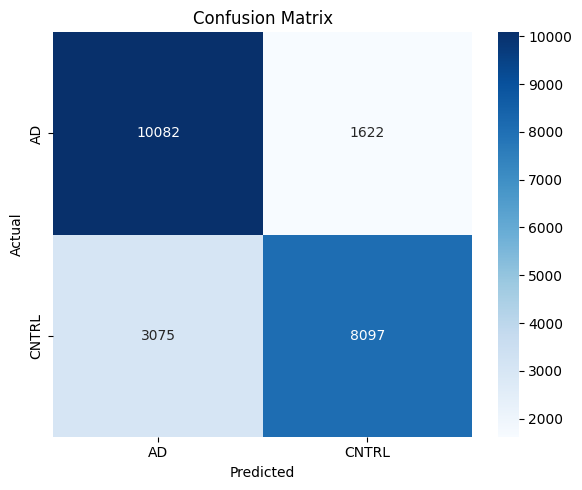

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(all_trues, all_preds, target_names=le.classes_))

cm = confusion_matrix(all_trues, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Subject-Level Accuracy: 0.9333 (14/15)


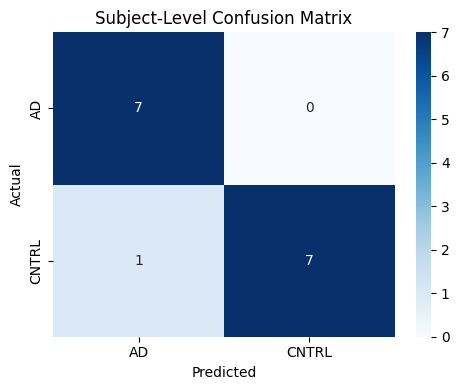

Subject-level classification report:
              precision    recall  f1-score   support

          AD       0.88      1.00      0.93         7
       CNTRL       1.00      0.88      0.93         8

    accuracy                           0.93        15
   macro avg       0.94      0.94      0.93        15
weighted avg       0.94      0.93      0.93        15

        Subject | True Label | Pred Label |   #AD |  #CNTRL
------------------------------------------------------------
    Subject_005 |      CNTRL |      CNTRL |    56 |    1122
    Subject_006 |      CNTRL |      CNTRL |   430 |     900
    Subject_011 |      CNTRL |         AD |   895 |     663
    Subject_012 |      CNTRL |      CNTRL |    84 |    1379
    Subject_013 |      CNTRL |      CNTRL |   323 |     874
    Subject_015 |      CNTRL |      CNTRL |   348 |    1153
    Subject_017 |      CNTRL |      CNTRL |   581 |     920
    Subject_018 |      CNTRL |      CNTRL |   358 |    1086
    Subject_004 |         AD |     

In [ ]:
# After majority voting:
subject_level_true = []
subject_level_pred = []

for subj, votes in subject_votes.items():
    final_pred = Counter(votes).most_common(1)[0][0]
    subject_level_pred.append(final_pred)
    subject_level_true.append(subject_true[subj])

# Print subject-level accuracy
acc = np.mean(np.array(subject_level_pred) == np.array(subject_level_true))
print(f"Subject-Level Accuracy: {acc:.4f} ({sum(np.array(subject_level_pred) == np.array(subject_level_true))}/{len(subject_level_true)})")

# Subject-level confusion matrix
cm_subject = confusion_matrix(subject_level_true, subject_level_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm_subject, annot=True, fmt="d",
            xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Subject-Level Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Subject-level classification report
print("Subject-level classification report:")
print(classification_report(subject_level_true, subject_level_pred, target_names=le.classes_))



idx_to_label = dict(enumerate(le.classes_))
subject_names = list(subject_votes.keys())

print(f"{'Subject':>15} | {'True Label':>10} | {'Pred Label':>10} | {'#AD':>5} | {'#CNTRL':>7}")
print('-'*60)
for subj, true_idx, pred_idx in zip(subject_names, subject_level_true, subject_level_pred):
    img_preds = subject_votes[subj]
    # Count predictions for each class
    count_AD = sum(1 for p in img_preds if idx_to_label[p] == "AD")
    count_CNTRL = sum(1 for p in img_preds if idx_to_label[p] == "CNTRL")
    true_label = idx_to_label[true_idx]
    pred_label = idx_to_label[pred_idx]
    print(f"{subj:>15} | {true_label:>10} | {pred_label:>10} | {count_AD:5d} | {count_CNTRL:7d}")


#### No need external libraries

Collected saliency maps -> AD=200, CNTRL=200


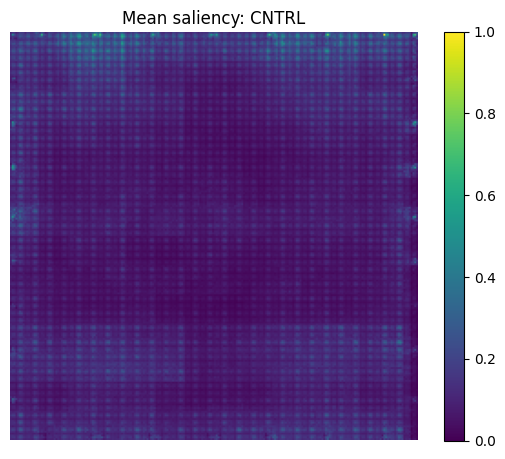

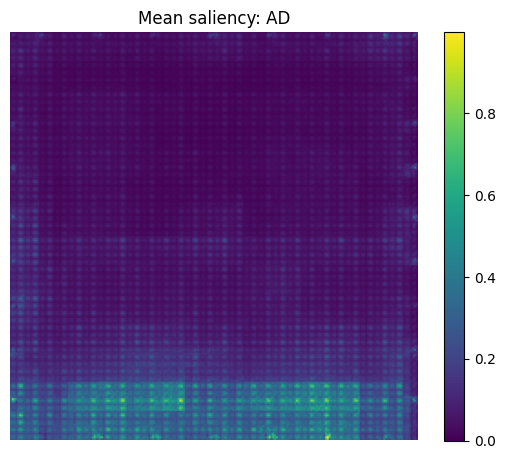

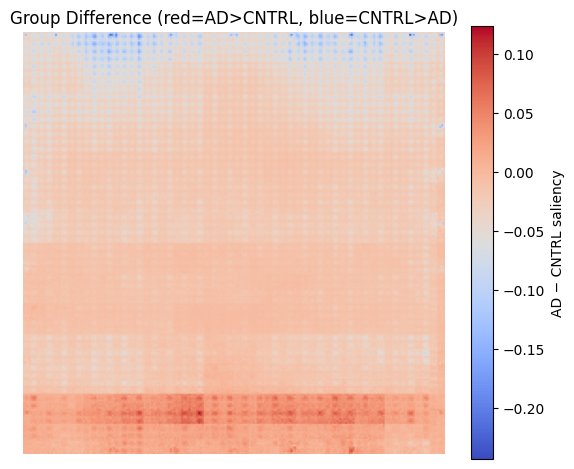

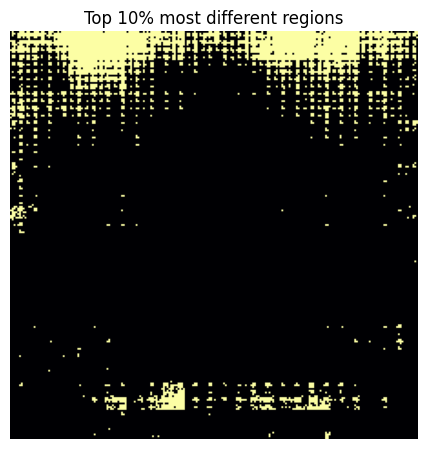

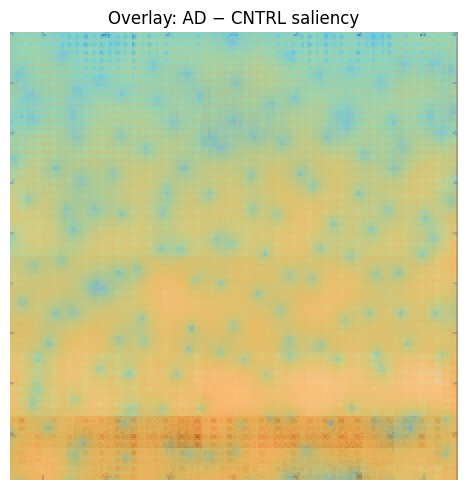

In [ ]:
# ========= FAST XAI (fixed; no nonlocal, no extra installs) =========
import torch, numpy as np, matplotlib.pyplot as plt

model.eval()
device = next(model.parameters()).device

# --- resolve class indices ---
classes = list(le.classes_)
assert "AD" in classes and "CNTRL" in classes, f"LabelEncoder classes must include AD and CNTRL, got: {classes}"
idx_AD, idx_CNTRL = classes.index("AD"), classes.index("CNTRL")

@torch.no_grad()
def get_preds(imgs):
    out = model(imgs.to(device))
    return out.argmax(1).cpu()

def saliency_batch(model, imgs, target_idx):
    imgs = imgs.to(device).float().requires_grad_(True)
    model.zero_grad(set_to_none=True)
    logits = model(imgs)
    scores = logits[torch.arange(imgs.size(0), device=device), target_idx.to(device)]
    scores.sum().backward()
    grads = imgs.grad.detach().abs()              # [B,3,H,W]
    sal = grads.max(dim=1).values                 # [B,H,W]
    # normalize per image to [0,1]
    B,H,W = sal.shape
    sal = sal.view(B,-1)
    mins = sal.min(dim=1, keepdim=True).values
    maxs = sal.max(dim=1, keepdim=True).values
    sal = ((sal - mins) / (maxs - mins + 1e-8)).view(B,H,W).cpu()
    return sal

# -------- aggregate group-wise mean saliency on a subset --------
max_per_group   = 200    # lower (e.g., 50–100) for speed
only_correct    = True   # keep only correctly classified samples
use_true_target = True   # target = true labels (or set False to use predicted)

sum_ad, sum_hc = None, None
n_ad, n_hc = 0, 0

for imgs, labels, _ in test_loader:
    if n_ad >= max_per_group and n_hc >= max_per_group:
        break

    preds = get_preds(imgs)
    keep = (preds == labels) if only_correct else torch.ones_like(labels, dtype=torch.bool)

    # process AD
    if n_ad < max_per_group:
        mask = keep & (labels == idx_AD)
        if mask.any():
            sel = mask.nonzero(as_tuple=False).squeeze(1)[: (max_per_group - n_ad)]
            t_idx = (labels if use_true_target else preds)[sel]
            sal = saliency_batch(model, imgs[sel], t_idx)    # [b,H,W]
            s = sal.sum(dim=0)                               # [H,W]
            sum_ad = s if sum_ad is None else sum_ad + s
            n_ad += sal.shape[0]

    # process CNTRL
    if n_hc < max_per_group:
        mask = keep & (labels == idx_CNTRL)
        if mask.any():
            sel = mask.nonzero(as_tuple=False).squeeze(1)[: (max_per_group - n_hc)]
            t_idx = (labels if use_true_target else preds)[sel]
            sal = saliency_batch(model, imgs[sel], t_idx)
            s = sal.sum(dim=0)
            sum_hc = s if sum_hc is None else sum_hc + s
            n_hc += sal.shape[0]

print(f"Collected saliency maps -> AD={n_ad}, CNTRL={n_hc}")
assert sum_ad is not None and sum_hc is not None, "Not enough samples collected."

mean_ad  = (sum_ad / max(n_ad,1)).numpy()
mean_hc  = (sum_hc / max(n_hc,1)).numpy()
diff_map = mean_ad - mean_hc  # >0 : more AD-salient; <0 : more CNTRL-salient

# -------- visualize --------
def show_map(m, title, cmap="viridis"):
    mm = (m - m.min()) / (m.max() - m.min() + 1e-8)
    plt.figure(figsize=(5.4,4.6)); plt.imshow(mm, cmap=cmap)
    plt.title(title); plt.axis("off"); plt.colorbar(); plt.tight_layout(); plt.show()

show_map(mean_hc, "Mean saliency: CNTRL")
show_map(mean_ad, "Mean saliency: AD")

plt.figure(figsize=(5.8,4.8))
plt.imshow(diff_map, cmap="coolwarm")
plt.colorbar(label="AD − CNTRL saliency")
plt.title("Group Difference (red=AD>CNTRL, blue=CNTRL>AD)")
plt.axis("off"); plt.tight_layout(); plt.show()

# Top-k% most different regions (mask)
k = 0.10
thr = np.quantile(np.abs(diff_map).ravel(), 1 - k)
mask = (np.abs(diff_map) >= thr).astype(float)
plt.figure(figsize=(5.4,4.6)); plt.imshow(mask, cmap="inferno")
plt.title(f"Top {int(k*100)}% most different regions"); plt.axis("off"); plt.tight_layout(); plt.show()

# Optional overlay on a sample CWT image
sample_imgs, _, _ = next(iter(test_loader))
bg = (sample_imgs[0]*0.5 + 0.5).permute(1,2,0).clamp(0,1).cpu().numpy()
d_norm = (diff_map - diff_map.min()) / (diff_map.max() - diff_map.min() + 1e-8)
plt.figure(figsize=(6,5)); plt.imshow(bg); plt.imshow(d_norm, alpha=0.55, cmap="coolwarm")
plt.title("Overlay: AD − CNTRL saliency"); plt.axis("off"); plt.tight_layout(); plt.show()


In [ ]:
# ===================== SAVE XAI MAPS + DOWNLOAD (Colab) =====================
import os, json, csv, zipfile
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

RUN_TAG = "fold2_post_EC"   # <<<< your requested tag
OUT_ROOT = Path("/content/xai_exports")
OUT_DIR  = OUT_ROOT / RUN_TAG
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Helper: save array as PNG (0..1 normalize if needed) and as .npy and .csv
def save_array_all(name, arr, cmap="viridis"):
    base = f"{RUN_TAG}__{name}"
    arr = np.asarray(arr)
    # npy
    np.save(OUT_DIR / f"{base}.npy", arr)
    # csv (2D only)
    if arr.ndim == 2:
        with open(OUT_DIR / f"{base}.csv", "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerows(arr.tolist())
    # png
    a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
    plt.figure(figsize=(6,5))
    plt.imshow(a, cmap=cmap)
    plt.title(base)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"{base}.png", dpi=200, bbox_inches="tight")
    plt.close()

# Save the group maps
save_array_all("mean_cntrl_saliency", mean_hc, cmap="viridis")
save_array_all("mean_ad_saliency",    mean_ad, cmap="viridis")
save_array_all("diff_ad_minus_cntrl", diff_map, cmap="coolwarm")
save_array_all("topk_mask",           mask, cmap="inferno")

# Save an overlay PNG (assumes 'bg' and 'd_norm' already exist)
plt.figure(figsize=(6,5))
plt.imshow(bg)
plt.imshow(d_norm, alpha=0.55, cmap="coolwarm")
plt.title(f"{RUN_TAG}__overlay_ad_minus_cntrl")
plt.axis("off")
plt.tight_layout()
plt.savefig(OUT_DIR / f"{RUN_TAG}__overlay_ad_minus_cntrl.png", dpi=200, bbox_inches="tight")
plt.close()

# Save a small JSON with run meta
meta = {
    "run_tag": RUN_TAG,
    "n_used_AD": int(n_ad),
    "n_used_CNTRL": int(n_hc),
    "k_top_percent": float(k),
    "abs_threshold": float(thr),
    "classes": classes,
}
with open(OUT_DIR / f"{RUN_TAG}__metadata.json", "w") as f:
    json.dump(meta, f, indent=2)

# -------- OPTIONAL: SAVE PER-IMAGE SALIENCY MAPS (can be heavy!) ----------
SAVE_PER_IMAGE = False     # set True if you want every selected image saved
PER_IMG_LIMIT  = 200       # safety limit (per group)

if SAVE_PER_IMAGE:
    PER_DIR = OUT_DIR / "per_image_saliency"
    PER_DIR.mkdir(parents=True, exist_ok=True)

    saved_ad = 0
    saved_hc = 0
    for imgs, labels, paths in test_loader:
        if saved_ad >= PER_IMG_LIMIT and saved_hc >= PER_IMG_LIMIT:
            break
        preds = get_preds(imgs)
        keep = (preds == labels) if only_correct else torch.ones_like(labels, dtype=torch.bool)

        # AD group
        if saved_ad < PER_IMG_LIMIT:
            mask_ad = keep & (labels == idx_AD)
            if mask_ad.any():
                sel = mask_ad.nonzero(as_tuple=False).squeeze(1)
                sel = sel[: max(0, PER_IMG_LIMIT - saved_ad)]
                t_idx = (labels if use_true_target else preds)[sel]
                sal = saliency_batch(model, imgs[sel], t_idx)    # [b,H,W]
                for i, si in enumerate(sal):
                    subj_dir = Path(paths[sel[i]]).parent.name
                    base = Path(paths[sel[i]]).stem
                    arr = si.numpy()
                    np.save(PER_DIR / f"{RUN_TAG}__{subj_dir}__{base}__AD.npy", arr)
                    a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
                    plt.figure(figsize=(5,4))
                    plt.imshow(a, cmap="viridis")
                    plt.title(f"{RUN_TAG} :: {subj_dir} :: {base} :: AD")
                    plt.axis("off"); plt.tight_layout()
                    plt.savefig(PER_DIR / f"{RUN_TAG}__{subj_dir}__{base}__AD.png", dpi=160, bbox_inches="tight")
                    plt.close()
                saved_ad += sal.shape[0]

        # CNTRL group
        if saved_hc < PER_IMG_LIMIT:
            mask_hc = keep & (labels == idx_CNTRL)
            if mask_hc.any():
                sel = mask_hc.nonzero(as_tuple=False).squeeze(1)
                sel = sel[: max(0, PER_IMG_LIMIT - saved_hc)]
                t_idx = (labels if use_true_target else preds)[sel]
                sal = saliency_batch(model, imgs[sel], t_idx)
                for i, si in enumerate(sal):
                    subj_dir = Path(paths[sel[i]]).parent.name
                    base = Path(paths[sel[i]]).stem
                    arr = si.numpy()
                    np.save(PER_DIR / f"{RUN_TAG}__{subj_dir}__{base}__CNTRL.npy", arr)
                    a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
                    plt.figure(figsize=(5,4))
                    plt.imshow(a, cmap="viridis")
                    plt.title(f"{RUN_TAG} :: {subj_dir} :: {base} :: CNTRL")
                    plt.axis("off"); plt.tight_layout()
                    plt.savefig(PER_DIR / f"{RUN_TAG}__{subj_dir}__{base}__CNTRL.png", dpi=160, bbox_inches="tight")
                    plt.close()
                saved_hc += sal.shape[0]

# -------- ZIP + DOWNLOAD (Colab) ----------
ZIP_PATH = f"/content/xai_exports_{RUN_TAG}.zip"
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for p in OUT_ROOT.rglob("*"):
        zf.write(p, arcname=p.relative_to(OUT_ROOT.parent))

print(f"Saved XAI exports to: {OUT_DIR}")
print(f"Zipped at: {ZIP_PATH}")

try:
    from google.colab import files
    files.download(ZIP_PATH)
except Exception as e:
    print("Colab download not available in this environment:", e)
    print("You can also copy the folder to Drive, e.g.:")
    print("!mkdir -p '/content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports' && cp -r /content/xai_exports '/content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports'")
# =====================================================================


Saved XAI exports to: /content/xai_exports/fold2_post_EC
Zipped at: /content/xai_exports_fold2_post_EC.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# import torch, numpy as np, matplotlib.pyplot as plt
# import torch.nn.functional as F

# def make_patch_masks(H, W, patch=32, stride=32, device="cpu"):
#     ys = list(range(0, H - patch + 1, stride))
#     xs = list(range(0, W - patch + 1, stride))
#     masks = []
#     for y in ys:
#         for x in xs:
#             m = torch.zeros(1, 1, H, W, device=device)
#             m[:, :, y:y+patch, x:x+patch] = 1.0
#             masks.append(m)
#     return torch.cat(masks, dim=0), len(ys), len(xs)  # [K,1,H,W], Gy, Gx

# def occlusion_saliency_batch(model, imgs, target_idx, patch=32, stride=32, fill_val=0.0, chunk_masks=8):
#     """
#     Returns coarse heatmaps [B,H,W] using patch occlusion. No grads, just forward passes.
#     """
#     device = imgs.device
#     B, C, H, W = imgs.shape
#     masks, Gy, Gx = make_patch_masks(H, W, patch=patch, stride=stride, device=device)  # [K,1,H,W]
#     K = masks.shape[0]

#     with torch.no_grad():
#         base = model(imgs)  # [B,C]
#         base_t = base[torch.arange(B), target_idx]  # [B]
#     heat = torch.zeros(B, H, W, device=device)

#     # Process masks in chunks to control memory
#     for i in range(0, K, chunk_masks):
#         m = masks[i:i+chunk_masks]                     # [m,1,H,W]
#         # Broadcast to [B,m,3,H,W]
#         x_occ = imgs.unsqueeze(1) * (1 - m) + fill_val * m
#         x_occ = x_occ.view(-1, C, H, W)               # [B*m,3,H,W]
#         with torch.no_grad():
#             logits = model(x_occ)                     # [B*m,C]
#             logits = logits.view(B, -1, base.shape[1])# [B,m,C]
#             scores = logits[..., target_idx.view(B,1)]# [B,m,1]
#             scores = scores.squeeze(-1)               # [B,m]
#         drop = (base_t.unsqueeze(1) - scores).clamp_min(0.0)  # [B,m]

#         # Paint the drop back onto the corresponding patch areas
#         # (uniformly add the drop value over that patch)
#         for jj in range(m.shape[0]):
#             yx = (i + jj)
#             y_idx = (yx // Gx) * stride
#             x_idx = (yx %  Gx) * stride
#             heat[:, y_idx:y_idx+patch, x_idx:x_idx+patch] += drop[:, jj].unsqueeze(-1).unsqueeze(-1)

#     # Normalize per image
#     B = heat.size(0)
#     heat = heat.view(B, -1)
#     heat = (heat - heat.min(dim=1, keepdim=True).values) / (heat.max(dim=1, keepdim=True).values - heat.min(dim=1, keepdim=True).values + 1e-8)
#     heat = heat.view(B, H, W)
#     return heat

# # Aggregate per group (same pattern as above)
# max_per_group = 80          # keep small; occlusion is heavier than saliency
# only_correct  = True
# use_true_target = True
# patch, stride = 32, 32
# chunk_masks   = 8

# sum_ad = None; n_ad = 0
# sum_hc = None; n_hc = 0

# for imgs, labels, _ in test_loader:
#     if n_ad >= max_per_group and n_hc >= max_per_group:
#         break
#     preds = get_preds(imgs)
#     keep = (preds == labels) if only_correct else torch.ones_like(labels, dtype=torch.bool)
#     for group_idx, is_ad in [(idx_AD, True), (idx_CNTRL, False)]:
#         m = keep & (labels == group_idx)
#         if m.sum() == 0:
#             continue
#         budget = (max_per_group - (n_ad if is_ad else n_hc))
#         if budget <= 0:
#             continue
#         sel = m.nonzero(as_tuple=False).squeeze(1)[:budget]
#         t_idx = (labels if use_true_target else preds)[sel]
#         heat = occlusion_saliency_batch(model, imgs[sel].to(device), t_idx.to(device),
#                                         patch=patch, stride=stride, chunk_masks=chunk_masks)  # [b,H,W]
#         s = heat.sum(dim=0)
#         if is_ad:
#             sum_ad = s if sum_ad is None else sum_ad + s
#             n_ad  += heat.shape[0]
#         else:
#             sum_hc = s if sum_hc is None else sum_hc + s
#             n_hc  += heat.shape[0]

# print(f"[Occlusion] Collected: AD={n_ad}, CNTRL={n_hc}")
# mean_ad_occ = (sum_ad / max(n_ad,1)).cpu().numpy()
# mean_hc_occ = (sum_hc / max(n_hc,1)).cpu().numpy()
# diff_occ    = mean_ad_occ - mean_hc_occ

# plt.figure(figsize=(5.6,4.8))
# plt.imshow(diff_occ, cmap="coolwarm")
# plt.colorbar(label="AD − CNTRL (occlusion)")
# plt.title("Group Difference via Patch-Occlusion")
# plt.axis("off"); plt.tight_layout(); plt.show()


In [ ]:
# ===================== SAVE TO GOOGLE DRIVE (+ RAR) =====================
import shutil, subprocess
from pathlib import Path

# Mount Drive (safe to call even if already mounted)
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

DRIVE_BASE = Path('/content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports')
DRIVE_BASE.mkdir(parents=True, exist_ok=True)

# 1) Copy the run folder to Drive
DRIVE_RUN_DIR = DRIVE_BASE / RUN_TAG
if DRIVE_RUN_DIR.exists():
    shutil.rmtree(DRIVE_RUN_DIR)
shutil.copytree(OUT_DIR, DRIVE_RUN_DIR)

# 2) Copy the ZIP to Drive
DRIVE_ZIP = DRIVE_BASE / f"xai_exports_{RUN_TAG}.zip"
shutil.copy2(ZIP_PATH, DRIVE_ZIP)

print(f"Copied to Drive folder: {DRIVE_RUN_DIR}")
print(f"Copied ZIP to Drive:    {DRIVE_ZIP}")

# 3) OPTIONAL: Create a RAR archive directly in Drive
#    This installs 'rar' (non-free) in the Colab VM, then writes a .rar into Drive.
try:
    print("Attempting to create RAR in Drive...")
    subprocess.run(["apt-get", "update", "-y"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    subprocess.run(["apt-get", "install", "-y", "rar"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)

    DRIVE_RAR = DRIVE_BASE / f"xai_exports_{RUN_TAG}.rar"
    # 'rar a -r <archive> <folder_to_add>'  (-r = recurse)
    # Use the *parent* of OUT_DIR so it stores the folder name inside the archive neatly
    subprocess.run(["rar", "a", "-r", str(DRIVE_RAR), str(OUT_DIR)], check=True)

    print(f"RAR saved to Drive:     {DRIVE_RAR}")
except Exception as e:
    print("Could not create .rar (keeping .zip). Error:", e)
# ======================================================================


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copied to Drive folder: /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports/fold2_post_EC
Copied ZIP to Drive:    /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports/xai_exports_fold2_post_EC.zip
Attempting to create RAR in Drive...
RAR saved to Drive:     /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports/xai_exports_fold2_post_EC.rar


#### New XAI (IG + SmoothGrad IG)

In [ ]:
# # ========================= XAI (IG + SmoothGrad IG) =========================
# import os, json, csv, zipfile, math, subprocess, shutil
# from pathlib import Path
# from collections import defaultdict, Counter

# import numpy as np
# import torch
# import torch.nn.functional as F
# import matplotlib.pyplot as plt

# # ------------------------ CONFIG ------------------------
# RUN_TAG          = "fold2_post_EC_IG_SGIG"  # customize per run
# OUT_ROOT         = Path("/content/xai_exports")
# OUT_DIR          = OUT_ROOT / RUN_TAG
# OUT_DIR.mkdir(parents=True, exist_ok=True)

# # Saliency collection
# MAX_PER_GROUP_IG    = 200   # how many correctly-classified images per group for IG
# MAX_PER_GROUP_SGIG  = 200   # for SmoothGradIG
# USE_TRUE_TARGET     = True  # True -> IG wrt true label; False -> wrt predicted class

# # Integrated Gradients settings
# IG_STEPS         = 32       # Riemann steps along the path
# BASELINE_KIND    = "zero"   # "zero" or "black" (zero is fine; inputs are normalized)

# # SmoothGrad IG settings
# SG_N_SAMPLES     = 25
# SG_NOISE_SIGMA   = 0.10     # noise std in input space (on normalized scale)

# # Significance testing (optional)
# DO_STAT_TEST     = False           # flip to True to compute pixel-wise tests (heavier)
# SIG_MAX_PER_GRP  = 120             # cap #images per group for stats to save memory
# ALPHA_FDR        = 0.05            # FDR level

# # Frequency axis (low frequency at bottom row)
# FREQ_MIN = 0.5   # Hz
# FREQ_MAX = 45.0  # Hz

# # Bands (name, low, high) in Hz
# BAND_EDGES = [
#     ("delta", 0.5, 4.0),
#     ("theta", 4.0, 8.0),
#     ("alpha", 8.0, 13.0),
#     ("beta", 13.0, 30.0),
#     ("gamma", 30.0, 45.0),
# ]

# # --------------------- helpers: saving -------------------
# def save_array_all(name, arr, cmap="viridis"):
#     """Save arr as .npy, .csv (if 2D), and .png."""
#     base = f"{RUN_TAG}__{name}"
#     arr = np.asarray(arr)
#     # npy
#     np.save(OUT_DIR / f"{base}.npy", arr)
#     # csv (2D only)
#     if arr.ndim == 2:
#         with open(OUT_DIR / f"{base}.csv", "w", newline="") as f:
#             writer = csv.writer(f)
#             writer.writerows(arr.tolist())
#     # png (0..1 normalize for viewing)
#     a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8) if arr.size else arr
#     plt.figure(figsize=(6,5))
#     plt.imshow(a, cmap=cmap)
#     plt.title(base)
#     plt.axis("off")
#     plt.tight_layout()
#     plt.savefig(OUT_DIR / f"{base}.png", dpi=200, bbox_inches="tight")
#     plt.close()

# def save_overlay(bg_img_hwc01, heat_2d, name, cmap="coolwarm", alpha=0.55):
#     """bg_img_hwc01 in [0,1], heat_2d any real values."""
#     base = f"{RUN_TAG}__{name}"
#     h = (heat_2d - heat_2d.min()) / (heat_2d.max() - heat_2d.min() + 1e-8)
#     plt.figure(figsize=(6,5))
#     plt.imshow(bg_img_hwc01)
#     plt.imshow(h, alpha=alpha, cmap=cmap)
#     plt.title(base)
#     plt.axis("off")
#     plt.tight_layout()
#     plt.savefig(OUT_DIR / f"{base}.png", dpi=200, bbox_inches="tight")
#     plt.close()

# # ------------------ helpers: IG & SmoothGrad IG ------------------
# def _make_baseline_like(img):
#     # img: [3,H,W]
#     if BASELINE_KIND == "zero":
#         return torch.zeros_like(img)
#     elif BASELINE_KIND == "black":
#         return torch.zeros_like(img)  # same for normalized inputs
#     else:
#         return torch.zeros_like(img)

# @torch.no_grad()
# def get_preds(imgs, model):
#     out = model(imgs.to(device))
#     return out.argmax(1).cpu()

# def integrated_gradients(model, imgs, target_idx, steps=32):
#     """
#     Robust IG: works for [B,3,H,W] or [3,H,W], returns [B,H,W] (abs-mean over channels).
#     Force-enables autograd for the forward/backward.
#     """
#     model.eval()
#     device_local = next(model.parameters()).device

#     # ---- enforce shapes on inputs/targets ----
#     if imgs.dim() == 3:   # [3,H,W] -> [1,3,H,W]
#         imgs = imgs.unsqueeze(0)
#     imgs = imgs.to(device_local)

#     if isinstance(target_idx, (int,)):
#         target_idx = torch.tensor([target_idx], device=device_local, dtype=torch.long)
#     else:
#         target_idx = target_idx.to(device_local)
#         if target_idx.dim() == 0:
#             target_idx = target_idx.unsqueeze(0)

#     B, C, H, W = imgs.shape
#     alphas = torch.linspace(0., 1., steps + 1, device=device_local)  # [steps+1]
#     sal_out = torch.zeros(B, H, W, device=device_local)

#     # IG per sample for stability
#     for i in range(B):
#         x = imgs[i:i+1].clone()                     # [1,3,H,W]
#         y_idx = int(target_idx[i].item())
#         baseline = torch.zeros_like(x)              # [1,3,H,W]

#         # Path: [steps+1, 1, 3, H, W]
#         path = baseline + alphas.view(-1, 1, 1, 1) * (x - baseline)

#         grads_sum = torch.zeros_like(x)
#         # ensure autograd is enabled for these iterations
#         for t in range(path.shape[0]):
#             xt = path[t]
#             if xt.dim() == 3:
#                 xt = xt.unsqueeze(0)
#             xt = xt.clone().detach().requires_grad_(True)

#             # ---- enable grad just for this forward/backward ----
#             with torch.enable_grad():
#                 logits = model(xt)                  # [1,num_classes], must carry grad_fn
#                 score = logits[:, y_idx].sum()      # scalar
#                 model.zero_grad(set_to_none=True)
#                 score.backward()

#             grads_sum = grads_sum + xt.grad.detach()

#         grads_mean = grads_sum / float(steps + 1)
#         ig = (x - baseline) * grads_mean            # [1,3,H,W]
#         ig = ig.abs().mean(dim=1).squeeze(0)        # [H,W]
#         sal_out[i] = ig

#     return sal_out  # [B,H,W]


# def smoothgrad_ig(model, imgs, target_idx, steps=32, n_samples=25, noise_sigma=0.10):
#     """
#     SmoothGrad over IG; returns [B,H,W]. Force-enables autograd internally.
#     """
#     model.eval()
#     device_local = next(model.parameters()).device

#     if imgs.dim() == 3:
#         imgs = imgs.unsqueeze(0)
#     imgs = imgs.to(device_local)

#     if isinstance(target_idx, (int,)):
#         target_idx = torch.tensor([target_idx], device=device_local, dtype=torch.long)
#     else:
#         target_idx = target_idx.to(device_local)
#         if target_idx.dim() == 0:
#             target_idx = target_idx.unsqueeze(0)

#     B, C, H, W = imgs.shape
#     out = torch.zeros(B, H, W, device=device_local)

#     for _ in range(n_samples):
#         noise = torch.randn_like(imgs) * noise_sigma
#         noisy = (imgs + noise).clamp(-1.0, 1.0)
#         # IG itself uses enable_grad(), so we can call it directly
#         out += integrated_gradients(model, noisy, target_idx, steps=steps)

#     out /= float(n_samples)
#     return out

# # ---------------------- helpers: aggregation ----------------------
# def aggregate_group_mean(sal_batch, sum_group, n_group):
#     """sal_batch: [b,H,W] to add; returns updated (sum,n)."""
#     if sal_batch is None or sal_batch.numel() == 0:
#         return sum_group, n_group
#     s = sal_batch.sum(dim=0)  # [H,W]
#     sum_group = s if sum_group is None else (sum_group + s)
#     n_group += sal_batch.shape[0]
#     return sum_group, n_group

# def to_numpy_norm(x):
#     x = x.detach().float().cpu().numpy()
#     return x

# def topk_mask_from_abs(arr2d, frac=0.10):
#     """Return binary mask of top-|arr| pixels covering 'frac' of total pixels."""
#     a = np.abs(arr2d)
#     flat = a.ravel()
#     k = max(1, int(round(frac * flat.size)))
#     thr = np.partition(flat, -k)[-k]  # k-th largest
#     return (a >= thr).astype(np.float32), float(thr)

# # ---------------------- helpers: band coverage --------------------
# def percent_band_coverage(mask, band_edges, freq_min=FREQ_MIN, freq_max=FREQ_MAX):
#     """
#     mask: [H,W] binary (1=selected), low frequency at bottom (y=H-1 -> freq_min).
#     returns dict band_name -> percent of mask pixels in that band.
#     """
#     H, W = mask.shape
#     total = mask.sum()
#     if total == 0:
#         return {name: 0.0 for (name,_,_) in band_edges}
#     yy = np.arange(H)  # 0..H-1 top->bottom
#     # y=0 -> freq_max, y=H-1 -> freq_min
#     freq = freq_min + (1.0 - yy / max(H-1,1)) * (freq_max - freq_min)
#     out = {}
#     for (name, f_lo, f_hi) in band_edges:
#         rows = (freq >= f_lo) & (freq < f_hi)
#         band_total = mask[rows, :].sum()
#         out[name] = 100.0 * float(band_total) / float(total)
#     return out

# # ------------------------ collect saliencies ----------------------
# model.eval()
# classes = list(le.classes_)
# assert "AD" in classes and "CNTRL" in classes
# idx_AD, idx_CNTRL = classes.index("AD"), classes.index("CNTRL")

# sum_ad_ig = None; sum_hc_ig = None; n_ad_ig = 0; n_hc_ig = 0
# sum_ad_sg = None; sum_hc_sg = None; n_ad_sg = 0; n_hc_sg = 0

# # For overlay (background)
# try:
#     sample_imgs, sample_labels, sample_paths = next(iter(test_loader))
#     bg = (sample_imgs[0]*0.5 + 0.5).permute(1,2,0).clamp(0,1).cpu().numpy()
# except StopIteration:
#     bg = None

# with torch.no_grad():
#     for imgs, labels, paths in test_loader:
#         preds = get_preds(imgs, model)
#         keep = (preds == labels)  # only_correct=True

#         # ---- IG for AD ----
#         if n_ad_ig < MAX_PER_GROUP_IG:
#             m_ad = keep & (labels == idx_AD)
#             if m_ad.any():
#                 sel = m_ad.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_IG - n_ad_ig)]
#                 tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                 ig_batch = integrated_gradients(model, imgs[sel], tgt, steps=IG_STEPS) # [b,H,W]
#                 sum_ad_ig, n_ad_ig = aggregate_group_mean(ig_batch, sum_ad_ig, n_ad_ig)

#         # ---- IG for CNTRL ----
#         if n_hc_ig < MAX_PER_GROUP_IG:
#             m_hc = keep & (labels == idx_CNTRL)
#             if m_hc.any():
#                 sel = m_hc.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_IG - n_hc_ig)]
#                 tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                 ig_batch = integrated_gradients(model, imgs[sel], tgt, steps=IG_STEPS)
#                 sum_hc_ig, n_hc_ig = aggregate_group_mean(ig_batch, sum_hc_ig, n_hc_ig)

#         # ---- SG-IG for AD ----
#         if n_ad_sg < MAX_PER_GROUP_SGIG:
#             m_ad = keep & (labels == idx_AD)
#             if m_ad.any():
#                 sel = m_ad.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_SGIG - n_ad_sg)]
#                 tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                 sg_batch = smoothgrad_ig(model, imgs[sel], tgt, steps=IG_STEPS,
#                                          n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA)
#                 sum_ad_sg, n_ad_sg = aggregate_group_mean(sg_batch, sum_ad_sg, n_ad_sg)

#         # ---- SG-IG for CNTRL ----
#         if n_hc_sg < MAX_PER_GROUP_SGIG:
#             m_hc = keep & (labels == idx_CNTRL)
#             if m_hc.any():
#                 sel = m_hc.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_SGIG - n_hc_sg)]
#                 tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                 sg_batch = smoothgrad_ig(model, imgs[sel], tgt, steps=IG_STEPS,
#                                          n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA)
#                 sum_hc_sg, n_hc_sg = aggregate_group_mean(sg_batch, sum_hc_sg, n_hc_sg)

# print(f"[IG]    Collected: AD={n_ad_ig}, CNTRL={n_hc_ig}")
# print(f"[SG-IG] Collected: AD={n_ad_sg}, CNTRL={n_hc_sg}")
# assert n_ad_ig>0 and n_hc_ig>0 and n_ad_sg>0 and n_hc_sg>0, "Not enough samples collected."

# # ---------------------- group means & diffs ----------------------
# mean_ad_ig = to_numpy_norm(sum_ad_ig / max(n_ad_ig,1))
# mean_hc_ig = to_numpy_norm(sum_hc_ig / max(n_hc_ig,1))
# diff_ig    = mean_ad_ig - mean_hc_ig

# mean_ad_sg = to_numpy_norm(sum_ad_sg / max(n_ad_sg,1))
# mean_hc_sg = to_numpy_norm(sum_hc_sg / max(n_hc_sg,1))
# diff_sg    = mean_ad_sg - mean_hc_sg

# # ---------------------- top-k masks & band coverage --------------
# for frac in [0.10, 0.20]:
#     name = f"top{int(frac*100)}"
#     # IG
#     mask_ig, thr_ig = topk_mask_from_abs(diff_ig, frac=frac)
#     cov_ig = percent_band_coverage(mask_ig, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
#     save_array_all(f"{name}_mask_IG", mask_ig, cmap="inferno")
#     # SG-IG
#     mask_sg, thr_sg = topk_mask_from_abs(diff_sg, frac=frac)
#     cov_sg = percent_band_coverage(mask_sg, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
#     save_array_all(f"{name}_mask_SGIG", mask_sg, cmap="inferno")

#     # save band coverage as JSON
#     with open(OUT_DIR / f"{RUN_TAG}__{name}_band_coverage.json", "w") as f:
#         json.dump({
#             "fraction": frac,
#             "thresholds": {"IG": float(thr_ig), "SGIG": float(thr_sg)},
#             "coverage_percent": {"IG": cov_ig, "SGIG": cov_sg},
#             "bands_hz": BAND_EDGES,
#             "freq_min_max": [FREQ_MIN, FREQ_MAX]
#         }, f, indent=2)

# # ------------------------- save maps & overlays -------------------
# save_array_all("mean_ad_IG",   mean_ad_ig, cmap="viridis")
# save_array_all("mean_cntrl_IG",mean_hc_ig, cmap="viridis")
# save_array_all("diff_ADminusCNTRL_IG", diff_ig, cmap="coolwarm")

# save_array_all("mean_ad_SGIG",   mean_ad_sg, cmap="viridis")
# save_array_all("mean_cntrl_SGIG",mean_hc_sg, cmap="viridis")
# save_array_all("diff_ADminusCNTRL_SGIG", diff_sg, cmap="coolwarm")

# if bg is not None:
#     save_overlay(bg, diff_ig, "overlay_diff_IG")
#     save_overlay(bg, diff_sg, "overlay_diff_SGIG")

# # ------------------- OPTIONAL: significance test -----------------
# if DO_STAT_TEST:
#     print("Running pixel-wise Welch's t-test with BH-FDR...")
#     # Re-collect per-image saliency (capped) for both methods and groups
#     def collect_sal_per_image(method="IG", max_per_grp=SIG_MAX_PER_GRP):
#         ad_list, hc_list = [], []
#         with torch.no_grad():
#             for imgs, labels, paths in test_loader:
#                 preds = get_preds(imgs, model)
#                 keep  = (preds == labels)

#                 # AD
#                 if len(ad_list) < max_per_grp:
#                     m = keep & (labels == idx_AD)
#                     if m.any():
#                         sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, max_per_grp - len(ad_list))]
#                         tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                         if method == "IG":
#                             sal = integrated_gradients(model, imgs[sel], tgt, steps=IG_STEPS)
#                         else:
#                             sal = smoothgrad_ig(model, imgs[sel], tgt, steps=IG_STEPS,
#                                                 n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA)
#                         ad_list.append(sal.cpu().numpy())  # [b,H,W]

#                 # CNTRL
#                 if len(hc_list) < max_per_grp:
#                     m = keep & (labels == idx_CNTRL)
#                     if m.any():
#                         sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, max_per_grp - len(hc_list))]
#                         tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                         if method == "IG":
#                             sal = integrated_gradients(model, imgs[sel], tgt, steps=IG_STEPS)
#                         else:
#                             sal = smoothgrad_ig(model, imgs[sel], tgt, steps=IG_STEPS,
#                                                 n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA)
#                         hc_list.append(sal.cpu().numpy())

#                 if len(ad_list) >= max_per_grp and len(hc_list) >= max_per_grp:
#                     break

#         if len(ad_list)==0 or len(hc_list)==0:
#             return None, None
#         ad_arr = np.concatenate(ad_list, axis=0)  # [N_ad,H,W]
#         hc_arr = np.concatenate(hc_list, axis=0)  # [N_hc,H,W]
#         return ad_arr, hc_arr

#     def welch_ttest_map(ad_arr, hc_arr):
#         """
#         ad_arr, hc_arr: [N,H,W]; returns tmap [H,W], pmap [H,W]
#         """
#         Na, H, W = ad_arr.shape
#         Nh, _, _ = hc_arr.shape
#         mu_a = ad_arr.mean(axis=0)
#         mu_h = hc_arr.mean(axis=0)
#         var_a = ad_arr.var(axis=0, ddof=1)
#         var_h = hc_arr.var(axis=0, ddof=1)
#         # Welch t
#         num = mu_a - mu_h
#         den = np.sqrt(var_a/Na + var_h/Nh) + 1e-12
#         tmap = num / den

#         # Welch-Satterthwaite df
#         df = (var_a/Na + var_h/Nh)**2 / ((var_a**2)/(Na**2*(Na-1)+1e-12) + (var_h**2)/(Nh**2*(Nh-1)+1e-12) + 1e-12)

#         # two-sided p-values from t (approx via survival function of Student's t).
#         # To avoid extra deps, use Gaussian as a close approx when df is large:
#         # p ≈ 2*(1 - Φ(|t|))
#         from math import erf, sqrt
#         def norm_sf(x):  # 1 - CDF
#             return 0.5 * (1 - erf(x/np.sqrt(2)))
#         pmap = 2.0 * norm_sf(np.abs(tmap))
#         return tmap, pmap

#     def bh_fdr(pvals, alpha=0.05):
#         """Benjamini–Hochberg on flattened pvals; returns boolean reject mask (same shape)."""
#         shape = pvals.shape
#         p = pvals.ravel()
#         m = p.size
#         order = np.argsort(p)
#         ranked = p[order]
#         thresh = alpha * (np.arange(1, m+1) / m)
#         passed = ranked <= thresh
#         if not np.any(passed):
#             return np.zeros_like(pvals, dtype=bool)
#         kmax = np.max(np.where(passed)[0])
#         cutoff = ranked[kmax]
#         return (pvals <= cutoff).reshape(shape)

#     for method_name, mean_ad, mean_hc, diff_map in [
#         ("IG",   mean_ad_ig, mean_hc_ig, diff_ig),
#         ("SGIG", mean_ad_sg, mean_hc_sg, diff_sg),
#     ]:
#         data_ad, data_hc = collect_sal_per_image(method=method_name, max_per_grp=SIG_MAX_PER_GRP)
#         if data_ad is None or data_hc is None:
#             print(f"[{method_name}] Not enough data for stats; skipping.")
#             continue
#         tmap, pmap = welch_ttest_map(data_ad, data_hc)
#         sig_mask = bh_fdr(pmap, alpha=ALPHA_FDR).astype(np.float32)
#         save_array_all(f"sigmask_{method_name}_FDR{int(ALPHA_FDR*100)}", sig_mask, cmap="gray")
#         # band coverage on significance mask
#         cov_sig = percent_band_coverage(sig_mask, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
#         with open(OUT_DIR / f"{RUN_TAG}__sigmask_{method_name}_band_coverage.json", "w") as f:
#             json.dump({"coverage_percent": cov_sig,
#                        "alpha_FDR": ALPHA_FDR,
#                        "bands_hz": BAND_EDGES,
#                        "freq_min_max": [FREQ_MIN, FREQ_MAX]}, f, indent=2)

# # ---------------------- write small metadata ---------------------
# meta = {
#     "run_tag": RUN_TAG,
#     "ig": {"n_ad": int(n_ad_ig), "n_cntrl": int(n_hc_ig), "steps": IG_STEPS, "baseline": BASELINE_KIND},
#     "sgig": {"n_ad": int(n_ad_sg), "n_cntrl": int(n_hc_sg),
#              "steps": IG_STEPS, "n_samples": SG_N_SAMPLES, "noise_sigma": SG_NOISE_SIGMA},
#     "bands_hz": BAND_EDGES,
#     "freq_min_max": [FREQ_MIN, FREQ_MAX],
#     "top_masks": ["10%","20%"],
#     "significance_test": {"enabled": bool(DO_STAT_TEST), "alpha_FDR": ALPHA_FDR}
# }
# with open(OUT_DIR / f"{RUN_TAG}__metadata.json", "w") as f:
#     json.dump(meta, f, indent=2)

# # ------------------------- ZIP + (optional) download --------------
# ZIP_PATH = f"/content/xai_exports_{RUN_TAG}.zip"
# with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as zf:
#     for p in OUT_ROOT.rglob("*"):
#         zf.write(p, arcname=p.relative_to(OUT_ROOT.parent))

# print(f"Saved XAI exports to: {OUT_DIR}")
# print(f"Zipped at: {ZIP_PATH}")

# try:
#     from google.colab import files
#     files.download(ZIP_PATH)
# except Exception as e:
#     print("Colab files.download not available here:", e)

# # ------------------------ SAVE TO GOOGLE DRIVE (+ RAR) -------------
# from google.colab import drive as _drive
# _drive.mount('/content/drive', force_remount=False)

# DRIVE_BASE = Path('/content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports')
# DRIVE_BASE.mkdir(parents=True, exist_ok=True)

# # 1) Copy the run folder to Drive
# DRIVE_RUN_DIR = DRIVE_BASE / RUN_TAG
# if DRIVE_RUN_DIR.exists():
#     shutil.rmtree(DRIVE_RUN_DIR)
# shutil.copytree(OUT_DIR, DRIVE_RUN_DIR)

# # 2) Copy the ZIP to Drive
# DRIVE_ZIP = DRIVE_BASE / f"xai_exports_{RUN_TAG}.zip"
# shutil.copy2(ZIP_PATH, DRIVE_ZIP)

# print(f"Copied to Drive folder: {DRIVE_RUN_DIR}")
# print(f"Copied ZIP to Drive:    {DRIVE_ZIP}")

# # 3) OPTIONAL: Create a RAR archive directly in Drive
# try:
#     print("Attempting to create RAR in Drive...")
#     subprocess.run(["apt-get", "update", "-y"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
#     subprocess.run(["apt-get", "install", "-y", "rar"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
#     DRIVE_RAR = DRIVE_BASE / f"xai_exports_{RUN_TAG}.rar"
#     subprocess.run(["rar", "a", "-r", str(DRIVE_RAR), str(OUT_DIR)], check=True)
#     print(f"RAR saved to Drive:     {DRIVE_RAR}")
# except Exception as e:
#     print("Could not create .rar (keeping .zip). Error:", e)
# # ===================================================================


In [ ]:
# ========================= FAST XAI (IG + SmoothGrad IG) =========================

# ---- NEW knobs (safe defaults) ----
B_MICRO_IG   = 4    # images per IG micro-batch (raise to 2/4 if VRAM allows)
B_MICRO_SG   = 4    # images per SG-IG micro-batch
ALPHA_CHUNK  = 8    # alpha steps per chunk (you had 8 before)
PATH_MICRO   = 16   # forward this many path samples at once (limits peak memory)

#====================================================================================================
import os, json, csv, zipfile, math, subprocess, shutil
from pathlib import Path
from collections import defaultdict, Counter

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ------------------------ SPEED PRESET ------------------------
# Choose: "fast" (recommended for iteration) or "accurate" (heavier)
SPEED_PRESET = "fast"

if SPEED_PRESET == "fast":
    MAX_PER_GROUP_IG   = 80     # was 200
    MAX_PER_GROUP_SGIG = 80     # was 200
    IG_STEPS           = 16     # was 32
    SG_N_SAMPLES       = 8      # was 25
    SG_NOISE_SIGMA     = 0.10
    ALPHA_CHUNK        = 8      # vectorize α steps in chunks
elif SPEED_PRESET == "accurate":
    MAX_PER_GROUP_IG   = 200
    MAX_PER_GROUP_SGIG = 200
    IG_STEPS           = 32
    SG_N_SAMPLES       = 25
    SG_NOISE_SIGMA     = 0.10
    ALPHA_CHUNK        = 8
else:
    raise ValueError("SPEED_PRESET must be 'fast' or 'accurate'.")

RUN_TAG          = f"fold2_post_EC_IG_SGIG_{SPEED_PRESET}"
OUT_ROOT         = Path("/content/xai_exports")
OUT_DIR          = OUT_ROOT / RUN_TAG
OUT_DIR.mkdir(parents=True, exist_ok=True)

USE_TRUE_TARGET  = True      # IG wrt true label (or predicted if False)
BASELINE_KIND    = "zero"    # ("zero" is fine for normalized inputs)

# (optional) significance testing
DO_STAT_TEST     = True
SIG_MAX_PER_GRP  = 80
ALPHA_FDR        = 0.05

# Frequency axis (low freq at bottom)
FREQ_MIN = 0.5
FREQ_MAX = 45.0
BAND_EDGES = [
    ("delta", 0.5, 4.0),
    ("theta", 4.0, 8.0),
    ("alpha", 8.0, 13.0),
    ("beta", 13.0, 30.0),
    ("gamma", 30.0, 45.0),
]

# cuDNN speed-up
torch.backends.cudnn.benchmark = True

# --------------------- helpers: saving -------------------
def save_array_all(name, arr, cmap="viridis"):
    base = f"{RUN_TAG}__{name}"
    arr = np.asarray(arr)
    np.save(OUT_DIR / f"{base}.npy", arr)
    if arr.ndim == 2:
        with open(OUT_DIR / f"{base}.csv", "w", newline="") as f:
            writer = csv.writer(f); writer.writerows(arr.tolist())
    a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8) if arr.size else arr
    plt.figure(figsize=(6,5)); plt.imshow(a, cmap=cmap); plt.title(base)
    plt.axis("off"); plt.tight_layout()
    plt.savefig(OUT_DIR / f"{base}.png", dpi=200, bbox_inches="tight"); plt.close()

def save_overlay(bg_img_hwc01, heat_2d, name, cmap="coolwarm", alpha=0.55):
    base = f"{RUN_TAG}__{name}"
    h = (heat_2d - heat_2d.min()) / (heat_2d.max() - heat_2d.min() + 1e-8)
    plt.figure(figsize=(6,5)); plt.imshow(bg_img_hwc01)
    plt.imshow(h, alpha=alpha, cmap=cmap); plt.title(base)
    plt.axis("off"); plt.tight_layout()
    plt.savefig(OUT_DIR / f"{base}.png", dpi=200, bbox_inches="tight"); plt.close()

# ------------------ helpers: IG & SmoothGrad IG ------------------
def _make_baseline_like(img):
    return torch.zeros_like(img)

@torch.no_grad()
def get_preds(imgs, model):
    out = model(imgs.to(device))
    return out.argmax(1).cpu()

def integrated_gradients_fast(model, imgs, target_idx, steps=32,
                              alpha_chunk=ALPHA_CHUNK, b_micro=B_MICRO_IG,
                              path_micro=PATH_MICRO):
    """
    Memory-safe vectorized IG:
      - Splits over images (b_micro),
      - Splits over alpha steps (alpha_chunk),
      - And splits the concatenated path batch further (path_micro).
    Returns saliency [B,H,W] (abs-mean over channels).
    """
    model.eval()
    device_local = next(model.parameters()).device

    if imgs.dim() == 3:
        imgs = imgs.unsqueeze(0)
    imgs = imgs.to(device_local)                     # [B,3,H,W]
    B, C, H, W = imgs.shape

    # normalize / broadcast targets
    if isinstance(target_idx, (int,)):
        target_idx = torch.tensor([target_idx]*B, device=device_local, dtype=torch.long)
    else:
        target_idx = target_idx.to(device_local)
        if target_idx.dim() == 0: target_idx = target_idx.unsqueeze(0)
        if target_idx.numel() != B:
            if target_idx.numel() == 1:
                target_idx = target_idx.repeat(B)
            else:
                target_idx = target_idx.view(-1)[:B]

    baseline = torch.zeros_like(imgs)
    alphas = torch.linspace(0., 1., steps + 1, device=device_local)   # [S]
    out = torch.zeros(B, H, W, device=device_local)

    # loop over images in micro-batches
    for b0 in range(0, B, b_micro):
        b1 = min(B, b0 + b_micro)
        x_mb  = imgs[b0:b1]             # [b,3,H,W]
        base  = baseline[b0:b1]         # [b,3,H,W]
        t_mb  = target_idx[b0:b1]       # [b]
        b = x_mb.shape[0]

        grads_sum = torch.zeros_like(x_mb)
        # split alpha steps into chunks
        for a0 in range(0, alphas.numel(), alpha_chunk):
            a1 = min(alphas.numel(), a0 + alpha_chunk)
            a = alphas[a0:a1]                               # [m]
            # build full path batch for this alpha-chunk: [m,b,3,H,W] -> [m*b,3,H,W]
            path_full = base.unsqueeze(0) + a.view(-1,1,1,1,1) * (x_mb - base).unsqueeze(0)
            path_full = path_full.reshape(-1, C, H, W)      # [m*b,3,H,W]

            # process path in smaller chunks to bound memory
            # accumulate gradients across the chunk
            pos = 0
            grad_accum = torch.zeros_like(path_full)
            while pos < path_full.shape[0]:
                pos_end = min(path_full.shape[0], pos + path_micro)
                path_chunk = path_full[pos:pos_end].clone().detach().requires_grad_(True)

                with torch.enable_grad():
                    logits = model(path_chunk)              # [k, num_classes]
                    # map chunk indices back to which original image target to use
                    # path_full is ordered as alpha-major, then image index inside
                    # We need corresponding target labels for this slice:
                    # determine which (alpha_index, image_index) each row belongs to
                    alpha_idx = torch.arange(pos, pos_end, device=device_local) // b
                    img_idx   = torch.arange(pos, pos_end, device=device_local) %  b
                    tgt_chunk = t_mb[img_idx]
                    scores = logits[torch.arange(path_chunk.size(0), device=device_local), tgt_chunk]
                    total = scores.sum()
                    model.zero_grad(set_to_none=True)
                    total.backward()

                grad_accum[pos:pos_end] = path_chunk.grad.detach()
                del path_chunk, logits, scores
                torch.cuda.empty_cache()
                pos = pos_end

            # reduce grad_accum back to [m,b,3,H,W], sum over m
            grads = grad_accum.reshape(a.shape[0], b, C, H, W).sum(dim=0)  # [b,3,H,W]
            grads_sum = grads_sum + grads

            del path_full, grad_accum, grads
            torch.cuda.empty_cache()

        grads_mean = grads_sum / float(steps + 1)           # [b,3,H,W]
        ig_mb = (x_mb - base) * grads_mean                  # [b,3,H,W]
        ig_mb = ig_mb.abs().mean(dim=1)                     # [b,H,W]
        out[b0:b1] = ig_mb

        del x_mb, base, t_mb, grads_sum, ig_mb
        torch.cuda.empty_cache()

    return out


def smoothgrad_ig_fast(model, imgs, target_idx, steps=32,
                       n_samples=8, noise_sigma=0.10, alpha_chunk=ALPHA_CHUNK,
                       b_micro=B_MICRO_SG, path_micro=PATH_MICRO):
    """
    Memory-safe SmoothGrad over IG:
      - adds noise per sample and reuses the memory-safe IG above
      - splits over images too
    Returns [B,H,W].
    """
    model.eval()
    device_local = next(model.parameters()).device
    if imgs.dim() == 3:
        imgs = imgs.unsqueeze(0)
    imgs = imgs.to(device_local)
    B, C, H, W = imgs.shape

    # normalize / broadcast targets
    if isinstance(target_idx, (int,)):
        target_idx = torch.tensor([target_idx]*B, device=device_local, dtype=torch.long)
    else:
        target_idx = target_idx.to(device_local)
        if target_idx.dim() == 0: target_idx = target_idx.unsqueeze(0)
        if target_idx.numel() != B:
            if target_idx.numel() == 1:
                target_idx = target_idx.repeat(B)
            else:
                target_idx = target_idx.view(-1)[:B]

    out = torch.zeros(B, H, W, device=device_local)

    # do SG in image micro-batches to keep memory bounded
    for b0 in range(0, B, b_micro):
        b1 = min(B, b0 + b_micro)
        x_mb = imgs[b0:b1]
        t_mb = target_idx[b0:b1]
        acc = torch.zeros(x_mb.shape[0], H, W, device=device_local)

        for _ in range(n_samples):
            noise = torch.randn_like(x_mb) * noise_sigma
            noisy = (x_mb + noise).clamp(-1.0, 1.0)
            ig_mb = integrated_gradients_fast(
                model, noisy, t_mb, steps=steps,
                alpha_chunk=alpha_chunk, b_micro=1, path_micro=path_micro
            )
            acc += ig_mb
            del noise, noisy, ig_mb
            torch.cuda.empty_cache()

        out[b0:b1] = acc / float(n_samples)
        del x_mb, t_mb, acc
        torch.cuda.empty_cache()

    return out


# ---------------------- helpers: aggregation ----------------------
def aggregate_group_mean(sal_batch, sum_group, n_group):
    if sal_batch is None or sal_batch.numel() == 0:
        return sum_group, n_group
    s = sal_batch.sum(dim=0)  # [H,W]
    sum_group = s if sum_group is None else (sum_group + s)
    n_group += sal_batch.shape[0]
    return sum_group, n_group

def to_numpy_norm(x):
    return x.detach().float().cpu().numpy()

def topk_mask_from_abs(arr2d, frac=0.10):
    a = np.abs(arr2d); flat = a.ravel()
    k = max(1, int(round(frac * flat.size)))
    thr = np.partition(flat, -k)[-k]
    return (a >= thr).astype(np.float32), float(thr)

# ---------------------- helpers: band coverage --------------------
def percent_band_coverage(mask, band_edges, freq_min=FREQ_MIN, freq_max=FREQ_MAX):
    H, W = mask.shape
    total = mask.sum()
    if total == 0:
        return {name: 0.0 for (name,_,_) in band_edges}
    yy = np.arange(H)  # 0..H-1 top->bottom
    # y=0 -> freq_max, y=H-1 -> freq_min (low freq at bottom)
    freq = freq_min + (1.0 - yy / max(H-1,1)) * (freq_max - freq_min)
    out = {}
    for (name, f_lo, f_hi) in band_edges:
        rows = (freq >= f_lo) & (freq < f_hi)
        out[name] = 100.0 * float(mask[rows, :].sum()) / float(total)
    return out

# ------------------------ collect saliencies ----------------------
model.eval()
device   = next(model.parameters()).device
classes  = list(le.classes_)
assert "AD" in classes and "CNTRL" in classes
idx_AD, idx_CNTRL = classes.index("AD"), classes.index("CNTRL")

sum_ad_ig = None; sum_hc_ig = None; n_ad_ig = 0; n_hc_ig = 0
sum_ad_sg = None; sum_hc_sg = None; n_ad_sg = 0; n_hc_sg = 0

# Overlay background
try:
    sample_imgs, _, _ = next(iter(test_loader))
    bg = (sample_imgs[0]*0.5 + 0.5).permute(1,2,0).clamp(0,1).cpu().numpy()
except StopIteration:
    bg = None

# Pass 1: gather IG and SG-IG (correctly classified only)
with torch.no_grad():
    for imgs, labels, paths in test_loader:
        preds = get_preds(imgs, model)
        keep  = (preds == labels)

        # ---- IG: AD ----
        if n_ad_ig < MAX_PER_GROUP_IG:
            m = keep & (labels == idx_AD)
            if m.any():
                sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_IG - n_ad_ig)]
                tgt = (labels if USE_TRUE_TARGET else preds)[sel]
                ig_b = integrated_gradients_fast(model, imgs[sel], tgt, steps=IG_STEPS, alpha_chunk=ALPHA_CHUNK)
                sum_ad_ig, n_ad_ig = aggregate_group_mean(ig_b, sum_ad_ig, n_ad_ig)

        # ---- IG: CNTRL ----
        if n_hc_ig < MAX_PER_GROUP_IG:
            m = keep & (labels == idx_CNTRL)
            if m.any():
                sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_IG - n_hc_ig)]
                tgt = (labels if USE_TRUE_TARGET else preds)[sel]
                ig_b = integrated_gradients_fast(model, imgs[sel], tgt, steps=IG_STEPS, alpha_chunk=ALPHA_CHUNK)
                sum_hc_ig, n_hc_ig = aggregate_group_mean(ig_b, sum_hc_ig, n_hc_ig)

        # ---- SG-IG: AD ----
        if n_ad_sg < MAX_PER_GROUP_SGIG:
            m = keep & (labels == idx_AD)
            if m.any():
                sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_SGIG - n_ad_sg)]
                tgt = (labels if USE_TRUE_TARGET else preds)[sel]
                sg_b = smoothgrad_ig_fast(model, imgs[sel], tgt, steps=IG_STEPS,
                                          n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA,
                                          alpha_chunk=ALPHA_CHUNK)
                sum_ad_sg, n_ad_sg = aggregate_group_mean(sg_b, sum_ad_sg, n_ad_sg)

        # ---- SG-IG: CNTRL ----
        if n_hc_sg < MAX_PER_GROUP_SGIG:
            m = keep & (labels == idx_CNTRL)
            if m.any():
                sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_SGIG - n_hc_sg)]
                tgt = (labels if USE_TRUE_TARGET else preds)[sel]
                sg_b = smoothgrad_ig_fast(model, imgs[sel], tgt, steps=IG_STEPS,
                                          n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA,
                                          alpha_chunk=ALPHA_CHUNK)
                sum_hc_sg, n_hc_sg = aggregate_group_mean(sg_b, sum_hc_sg, n_hc_sg)

print(f"[IG]    Collected: AD={n_ad_ig}, CNTRL={n_hc_ig}")
print(f"[SG-IG] Collected: AD={n_ad_sg}, CNTRL={n_hc_sg}")
assert n_ad_ig>0 and n_hc_ig>0 and n_ad_sg>0 and n_hc_sg>0, "Not enough samples collected."

# ---------------------- group means & diffs ----------------------
mean_ad_ig = to_numpy_norm(sum_ad_ig / max(n_ad_ig,1))
mean_hc_ig = to_numpy_norm(sum_hc_ig / max(n_hc_ig,1))
diff_ig    = mean_ad_ig - mean_hc_ig

mean_ad_sg = to_numpy_norm(sum_ad_sg / max(n_ad_sg,1))
mean_hc_sg = to_numpy_norm(sum_hc_sg / max(n_hc_sg,1))
diff_sg    = mean_ad_sg - mean_hc_sg

# ---------------------- top-k masks & band coverage --------------
for frac in [0.10, 0.20]:
    name = f"top{int(frac*100)}"
    # IG
    mask_ig, thr_ig = topk_mask_from_abs(diff_ig, frac=frac)
    cov_ig = percent_band_coverage(mask_ig, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
    save_array_all(f"{name}_mask_IG", mask_ig, cmap="inferno")
    # SG-IG
    mask_sg, thr_sg = topk_mask_from_abs(diff_sg, frac=frac)
    cov_sg = percent_band_coverage(mask_sg, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
    save_array_all(f"{name}_mask_SGIG", mask_sg, cmap="inferno")
    # coverage JSON
    with open(OUT_DIR / f"{RUN_TAG}__{name}_band_coverage.json", "w") as f:
        json.dump({
            "fraction": frac,
            "thresholds": {"IG": float(thr_ig), "SGIG": float(thr_sg)},
            "coverage_percent": {"IG": cov_ig, "SGIG": cov_sg},
            "bands_hz": BAND_EDGES,
            "freq_min_max": [FREQ_MIN, FREQ_MAX]
        }, f, indent=2)

# ------------------------- save maps & overlays -------------------
save_array_all("mean_ad_IG",   mean_ad_ig, cmap="viridis")
save_array_all("mean_cntrl_IG",mean_hc_ig, cmap="viridis")
save_array_all("diff_ADminusCNTRL_IG", diff_ig, cmap="coolwarm")

save_array_all("mean_ad_SGIG",   mean_ad_sg, cmap="viridis")
save_array_all("mean_cntrl_SGIG",mean_hc_sg, cmap="viridis")
save_array_all("diff_ADminusCNTRL_SGIG", diff_sg, cmap="coolwarm")

if bg is not None:
    save_overlay(bg, diff_ig, "overlay_diff_IG")
    save_overlay(bg, diff_sg, "overlay_diff_SGIG")







[IG]    Collected: AD=80, CNTRL=80
[SG-IG] Collected: AD=80, CNTRL=80


In [ ]:
# =================== STATISTICAL TEST (FAST, SINGLE-PASS) ===================
# This cell reuses cached per-pixel sums/sumsq gathered during saliency collection.
# It does NOT recompute IG / SG-IG, so it is much faster.

import numpy as np, json

# ---- safety defaults / knobs (you can tweak) ----
DO_STAT_TEST        = globals().get('DO_STAT_TEST', True)   # only run if True
ALPHA_FDR           = globals().get('ALPHA_FDR', 0.05)

STAT_DOWNSAMPLE     = 2       # 1=no downsample; try 2 or 4 for speed (must match the hook)
FDR_ONLY_IN_TOPK    = True    # test only in union of top-k regions (reduces multiple-testing)
TOPK_FRACS_FOR_FDR  = [0.10, 0.20]  # union of these (at full-res)

if DO_STAT_TEST:
    print("Running fast pixel-wise Welch t-test from cached sums (no extra IG/SG-IG passes).")

    # ---------------- helpers ----------------
    def _welch_from_sums(sum_a, sumsq_a, n_a, sum_h, sumsq_h, n_h):
        """
        Input: per-pixel sum / sumsq (AD and CNTRL) and counts (n_a, n_h), arrays [H,W]
        Output: (tmap, pmap) with Gaussian tail approx for p-values (vectorized).
        """
        # Means
        mu_a  = sum_a / max(n_a, 1)
        mu_h  = sum_h / max(n_h, 1)
        # Unbiased variances from sum & sumsq
        var_a = (sumsq_a - (sum_a**2)/max(n_a,1)) / max(n_a-1, 1)
        var_h = (sumsq_h - (sum_h**2)/max(n_h,1)) / max(n_h-1, 1)

        num = (mu_a - mu_h)
        den = np.sqrt(var_a/max(n_a,1) + var_h/max(n_h,1)) + 1e-12
        tmap = num / den

        # Vectorized erf approximation (Hastings) for speed/stability
        def _erf_approx(x):
            x = np.asarray(x, dtype=np.float64)
            s = np.sign(x)
            x2 = x * x
            a = 0.147
            inner = -x2 * (4.0/np.pi + a * x2) / (1.0 + a * x2)
            return s * np.sqrt(1.0 - np.exp(inner))

        def _normal_sf(z):   # 1 - Phi(z)
            return 0.5 * (1.0 - _erf_approx(z / np.sqrt(2.0)))

        pmap = 2.0 * _normal_sf(np.abs(tmap))  # two-sided
        return tmap, pmap

    def bh_fdr(pvals, alpha=0.05):
        shape = pvals.shape
        p = pvals.ravel()
        m = p.size
        order = np.argsort(p)
        ranked = p[order]
        thresh = alpha * (np.arange(1, m+1) / m)
        passed = ranked <= thresh
        if not np.any(passed):
            return np.zeros_like(pvals, dtype=bool)
        kmax = np.max(np.where(passed)[0])
        cutoff = ranked[kmax]
        return (pvals <= cutoff).reshape(shape)

    # ---- Optional: build focus mask (full-resolution) from union of top-k masks
    union_mask_full = None
    if FDR_ONLY_IN_TOPK:
        union_mask_full = np.zeros_like(diff_ig, dtype=bool)
        for frac in TOPK_FRACS_FOR_FDR:
            mk_ig, _ = topk_mask_from_abs(diff_ig, frac)
            mk_sg, _ = topk_mask_from_abs(diff_sg, frac)
            union_mask_full |= (mk_ig.astype(bool) | mk_sg.astype(bool))

    # ---------------- IG stats (if cached) ----------------
    ig_cached = ('stat_ad_ig_sum' in globals() and stat_ad_ig_sum is not None and
                 'stat_hc_ig_sum' in globals() and stat_hc_ig_sum is not None)

    if ig_cached:
        sum_a = stat_ad_ig_sum.detach().cpu().numpy()
        ss_a  = stat_ad_ig_sumsq.detach().cpu().numpy()
        sum_h = stat_hc_ig_sum.detach().cpu().numpy()
        ss_h  = stat_hc_ig_sumsq.detach().cpu().numpy()
        n_a   = int(n_ad_ig_stat)
        n_h   = int(n_hc_ig_stat)

        tmap_ig, pmap_ig = _welch_from_sums(sum_a, ss_a, n_a, sum_h, ss_h, n_h)

        # Apply FDR; if we downsampled stats, we cannot pixel-align top-k union -> apply globally
        if union_mask_full is not None and STAT_DOWNSAMPLE == 1:
            p_tmp = pmap_ig.copy()
            p_tmp[~union_mask_full] = 1.0
            sig_ig = bh_fdr(p_tmp, alpha=ALPHA_FDR).astype(np.float32)
        else:
            sig_ig = bh_fdr(pmap_ig, alpha=ALPHA_FDR).astype(np.float32)

        save_array_all("tmap_IG_stat", tmap_ig, cmap="coolwarm")
        save_array_all("pmap_IG_stat", pmap_ig, cmap="magma")
        save_array_all(f"sigmask_IG_FDR{int(ALPHA_FDR*100)}", sig_ig, cmap="gray")

        cov_sig_ig = percent_band_coverage(sig_ig, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
        with open(OUT_DIR / f"{RUN_TAG}__sigmask_IG_band_coverage.json", "w") as f:
            json.dump({"coverage_percent": cov_sig_ig,
                       "alpha_FDR": ALPHA_FDR,
                       "bands_hz": BAND_EDGES,
                       "freq_min_max": [FREQ_MIN, FREQ_MAX]}, f, indent=2)
        print(f"[IG] stats: n_AD={n_a}, n_CNTRL={n_h}, downsample={STAT_DOWNSAMPLE}")
    else:
        print("[IG] cached stats not found. Ensure the saliency loop ran with DO_STAT_TEST=True and the hook added.")

    # ---------------- SG-IG stats (if cached) ----------------
    sg_cached = ('stat_ad_sg_sum' in globals() and stat_ad_sg_sum is not None and
                 'stat_hc_sg_sum' in globals() and stat_hc_sg_sum is not None)

    if sg_cached:
        sum_a = stat_ad_sg_sum.detach().cpu().numpy()
        ss_a  = stat_ad_sg_sumsq.detach().cpu().numpy()
        sum_h = stat_hc_sg_sum.detach().cpu().numpy()
        ss_h  = stat_hc_sg_sumsq.detach().cpu().numpy()
        n_a   = int(n_ad_sg_stat)
        n_h   = int(n_hc_sg_stat)

        tmap_sg, pmap_sg = _welch_from_sums(sum_a, ss_a, n_a, sum_h, ss_h, n_h)

        if union_mask_full is not None and STAT_DOWNSAMPLE == 1:
            p_tmp = pmap_sg.copy()
            p_tmp[~union_mask_full] = 1.0
            sig_sg = bh_fdr(p_tmp, alpha=ALPHA_FDR).astype(np.float32)
        else:
            sig_sg = bh_fdr(pmap_sg, alpha=ALPHA_FDR).astype(np.float32)

        save_array_all("tmap_SGIG_stat", tmap_sg, cmap="coolwarm")
        save_array_all("pmap_SGIG_stat", pmap_sg, cmap="magma")
        save_array_all(f"sigmask_SGIG_FDR{int(ALPHA_FDR*100)}", sig_sg, cmap="gray")

        cov_sig_sg = percent_band_coverage(sig_sg, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
        with open(OUT_DIR / f"{RUN_TAG}__sigmask_SGIG_band_coverage.json", "w") as f:
            json.dump({"coverage_percent": cov_sig_sg,
                       "alpha_FDR": ALPHA_FDR,
                       "bands_hz": BAND_EDGES,
                       "freq_min_max": [FREQ_MIN, FREQ_MAX]}, f, indent=2)
        print(f"[SG-IG] stats: n_AD={n_a}, n_CNTRL={n_h}, downsample={STAT_DOWNSAMPLE}")
    else:
        print("[SG-IG] cached stats not found. Ensure the saliency loop ran with DO_STAT_TEST=True and the hook added.")
# ===========================================================================



Running fast pixel-wise Welch t-test from cached sums (no extra IG/SG-IG passes).
[IG] cached stats not found. Ensure the saliency loop ran with DO_STAT_TEST=True and the hook added.
[SG-IG] cached stats not found. Ensure the saliency loop ran with DO_STAT_TEST=True and the hook added.


In [ ]:
# ============================ SAVE ALL (Model + XAI + Stats) ============================
import os, json, zipfile, shutil, subprocess, sys
from pathlib import Path

# --- Required globals assumed to exist: RUN_TAG, OUT_ROOT, OUT_DIR, model ---
# If you used my earlier cells, these are already defined. Otherwise set them here:
if 'RUN_TAG' not in globals():
    RUN_TAG = "xai_run"
if 'OUT_ROOT' not in globals():
    OUT_ROOT = Path("/content/xai_exports")
if 'OUT_DIR' not in globals():
    OUT_DIR = OUT_ROOT / RUN_TAG
OUT_ROOT = Path(OUT_ROOT)
OUT_DIR  = Path(OUT_DIR)
OUT_ROOT.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"[SaveAll] Using OUT_DIR = {OUT_DIR}")

# ---------------------- 1) SAVE TRAINED MODEL INTO OUT_DIR ----------------------
import torch

CKPT_DIR = OUT_DIR / "checkpoints"
CKPT_DIR.mkdir(parents=True, exist_ok=True)

# 1a) Copy your best checkpoint file if it exists in the cwd
BEST_PTH = Path("best_swin_model.pth")
if BEST_PTH.exists():
    shutil.copy2(BEST_PTH, CKPT_DIR / "best_swin_model.pth")
    print(f"[SaveAll] Copied best checkpoint -> {CKPT_DIR / 'best_swin_model.pth'}")
else:
    print("[SaveAll][warn] best_swin_model.pth not found in current directory.")

# 1b) Save a full training bundle (state_dict + metadata)
bundle = {
    "run_tag": RUN_TAG,
    "model_name": "swin_tiny_patch4_window7_224",
    "num_classes": 2,
    "state_dict": (model.state_dict() if 'model' in globals() else None),
    "optimizer": (optimizer.state_dict() if 'optimizer' in globals() else None),
    "scheduler": (scheduler.state_dict() if 'scheduler' in globals() else None),
    "label_classes": (list(le.classes_) if 'le' in globals() else None),
    "transform_note": {
        "resize": [224, 224],
        "normalize_mean": [0.5, 0.5, 0.5],
        "normalize_std":  [0.5, 0.5, 0.5]
    }
}
torch.save(bundle, CKPT_DIR / "training_bundle.pt")
print(f"[SaveAll] Saved training bundle -> {CKPT_DIR / 'training_bundle.pt'}")

# 1c) (Optional) Export TorchScript for portable inference
EXPORT_TORCHSCRIPT = False
if EXPORT_TORCHSCRIPT and 'model' in globals():
    try:
        device = next(model.parameters()).device
        model.eval()
        example = torch.randn(1, 3, 224, 224, device=device)
        scripted = torch.jit.trace(model, example)
        scripted.save(str(CKPT_DIR / "model_scripted.pt"))
        print(f"[SaveAll] TorchScript saved -> {CKPT_DIR / 'model_scripted.pt'}")
    except Exception as e:
        print("[SaveAll][warn] TorchScript export failed:", e)




# ============================== WRITE README.md ==============================
import json, os, glob, textwrap
import numpy as np
from pathlib import Path
from datetime import datetime

def _load_json(p):
    try:
        with open(p, "r") as f:
            return json.load(f)
    except Exception:
        return None

def _maybe_load_npy(name):
    p = OUT_DIR / f"{RUN_TAG}__{name}.npy"
    if p.exists():
        try:
            return np.load(p)
        except Exception:
            return None
    return None

def _percent_sig(sigmask):
    if sigmask is None:
        return None
    total = sigmask.size
    k = (sigmask > 0).sum()
    return float(100.0 * k / max(total, 1))

def _band_table_markdown(coverage_dict):
    """
    coverage_dict: {"IG": {"delta":..,"theta":..,..}, "SGIG": {...}}
    Returns a small markdown table string. Missing keys handled gracefully.
    """
    bands = ["delta","theta","alpha","beta","gamma"]
    lines = ["| Band | IG (%) | SGIG (%) |", "|:----:|------:|--------:|"]
    for b in bands:
        ig = coverage_dict.get("IG", {}).get(b, 0.0)
        sg = coverage_dict.get("SGIG", {}).get(b, 0.0)
        lines.append(f"| {b} | {ig:.2f} | {sg:.2f} |")
    return "\n".join(lines)

# ---- try to collect top-10 and top-20 coverage (from saved JSONs) ----
cov = {}
thr = {}
for frac_name in ["top10", "top20"]:
    j = _load_json(OUT_DIR / f"{RUN_TAG}__{frac_name}_band_coverage.json")
    if j is not None:
        cov[frac_name] = j.get("coverage_percent", {})
        thr[frac_name] = j.get("thresholds", {})
    else:
        cov[frac_name] = {}
        thr[frac_name] = {}

# ---- stats (if produced) ----
stats = {}
for method in ["IG","SGIG"]:
    sig_json = _load_json(OUT_DIR / f"{RUN_TAG}__sigmask_{method}_band_coverage.json")
    sig_npy  = _maybe_load_npy(f"sigmask_{method}_FDR{int(ALPHA_FDR*100)}")
    stats[method] = {
        "band_coverage": (sig_json or {}).get("coverage_percent", None),
        "sig_percent_pixels": _percent_sig(sig_npy)
    }

# ---- quick existence checks for key visual outputs ----
key_pngs = [
    f"{RUN_TAG}__mean_ad_IG.png",
    f"{RUN_TAG}__mean_cntrl_IG.png",
    f"{RUN_TAG}__diff_ADminusCNTRL_IG.png",
    f"{RUN_TAG}__mean_ad_SGIG.png",
    f"{RUN_TAG}__mean_cntrl_SGIG.png",
    f"{RUN_TAG}__diff_ADminusCNTRL_SGIG.png",
    f"{RUN_TAG}__top10_mask_IG.png",
    f"{RUN_TAG}__top20_mask_IG.png",
    f"{RUN_TAG}__top10_mask_SGIG.png",
    f"{RUN_TAG}__top20_mask_SGIG.png",
    f"{RUN_TAG}__overlay_diff_IG.png",
    f"{RUN_TAG}__overlay_diff_SGIG.png",
]
present_pngs = [p for p in key_pngs if (OUT_DIR / p).exists()]

# ---- optional model artifact info (if you saved it) ----
MODEL_LOCAL = locals().get("TRAINED_MODEL_LOCAL", None)
MODEL_DRIVE = locals().get("DRIVE_MODEL_PATH", None)

# ---- build README text ----
lines = []
lines.append(f"# XAI Summary — `{RUN_TAG}`")
lines.append("")
lines.append(f"- **Created:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
lines.append(f"- **Output folder:** `{OUT_DIR}`")
lines.append(f"- **Preset:** `{locals().get('SPEED_PRESET','?')}`")
lines.append("")
lines.append("## Methods")
lines.append("- **IG**: Integrated Gradients with baseline=`zero` "
             f"and `IG_STEPS={locals().get('IG_STEPS','?')}`.")
lines.append("- **SGIG**: SmoothGrad over IG with "
             f"`SG_N_SAMPLES={locals().get('SG_N_SAMPLES','?')}`, "
             f"`SG_NOISE_SIGMA={locals().get('SG_NOISE_SIGMA','?')}`, "
             f"`IG_STEPS={locals().get('IG_STEPS','?')}`.")
lines.append("")
lines.append("## Data used for XAI (correct predictions only)")
lines.append(f"- IG:    AD={locals().get('n_ad_ig',0)}, CNTRL={locals().get('n_hc_ig',0)}")
lines.append(f"- SG-IG: AD={locals().get('n_ad_sg',0)}, CNTRL={locals().get('n_hc_sg',0)}")
lines.append("")
lines.append("## Frequency axis")
lines.append(f"- Y-axis spans **{locals().get('FREQ_MIN',0.5)}–{locals().get('FREQ_MAX',45.0)} Hz**, low frequency at image bottom.")
lines.append("- Bands: delta (0.5–4), theta (4–8), alpha (8–13), beta (13–30), gamma (30–45).")
lines.append("")

# ---- top masks section ----
for frac_name, frac_label in [("top10","Top 10%"), ("top20","Top 20%")]:
    lines.append(f"## {frac_label} mask (|AD−CNTRL| strongest pixels)")
    if thr.get(frac_name):
        lines.append(f"- Thresholds: IG={thr[frac_name].get('IG','n/a')}, SGIG={thr[frac_name].get('SGIG','n/a')}")
    # band table
    lines.append(_band_table_markdown(cov.get(frac_name, {})))
    lines.append("")

# ---- stats section (if any) ----
if any(v["band_coverage"] is not None or v["sig_percent_pixels"] is not None for v in stats.values()):
    lines.append("## Pixel-wise statistics (Welch’s t, BH-FDR)")
    lines.append(f"- FDR α = {locals().get('ALPHA_FDR', 0.05)}")
    for method in ["IG","SGIG"]:
        s = stats[method]
        if s["sig_percent_pixels"] is None and s["band_coverage"] is None:
            continue
        lines.append(f"### {method}")
        if s["sig_percent_pixels"] is not None:
            lines.append(f"- Significant pixels (FDR): **{s['sig_percent_pixels']:.2f}%**")
        if s["band_coverage"] is not None:
            # convert to mini-table
            bc = {"IG": s["band_coverage"], "SGIG": {}} if method=="IG" else {"IG": {}, "SGIG": s["band_coverage"]}
            lines.append(_band_table_markdown(bc))
        # point to files if present
        tmap_p = OUT_DIR / f"{RUN_TAG}__tmap_{method}.png"
        pmap_p = OUT_DIR / f"{RUN_TAG}__pmap_{method}.png"
        sm_p   = OUT_DIR / f"{RUN_TAG}__sigmask_{method}_FDR{int(ALPHA_FDR*100)}.png"
        if tmap_p.exists() or pmap_p.exists() or sm_p.exists():
            lines.append("- Files:")
            if tmap_p.exists(): lines.append(f"  - `{tmap_p.name}` (t-map)")
            if pmap_p.exists(): lines.append(f"  - `{pmap_p.name}` (p-map)")
            if sm_p.exists():   lines.append(f"  - `{sm_p.name}` (significance mask)")
        lines.append("")
else:
    lines.append("## Pixel-wise statistics")
    lines.append("- *Not run or no significant results saved.*")
    lines.append("")

# ---- key visual outputs present ----
if present_pngs:
    lines.append("## Key visual outputs present")
    for name in present_pngs:
        lines.append(f"- `{name}`")
    lines.append("")

# ---- model artifacts (optional) ----
lines.append("## Model artifact")
if MODEL_LOCAL or MODEL_DRIVE:
    if MODEL_LOCAL:
        lines.append(f"- Local saved: `{MODEL_LOCAL}`")
    if MODEL_DRIVE:
        lines.append(f"- Copied to Drive: `{MODEL_DRIVE}`")
else:
    lines.append("- *(No model path recorded in this session.)*")
lines.append("")

# ---- file inventory (brief) ----
lines.append("## File inventory (top level)")
top_items = sorted([p.name for p in OUT_DIR.glob("*")])
for nm in top_items[:80]:   # cap list length
    lines.append(f"- `{nm}`")
if len(top_items) > 80:
    lines.append(f"- ... (+{len(top_items)-80} more)")

# ---- write README.md ----
README_PATH = OUT_DIR / "README.md"
with open(README_PATH, "w") as f:
    f.write("\n".join(lines))

print(f"README written to: {README_PATH}")
# =============================================================================


# ===================== SAVE CLASSIFICATION RESULTS =====================
import csv, json
from pathlib import Path

# Use your existing OUT_DIR / RUN_TAG if defined; otherwise create a default.
try:
    OUT_DIR, RUN_TAG  # check they exist
except NameError:
    RUN_TAG = "classification_results_only"
    OUT_ROOT = Path("/content/xai_exports")
    OUT_DIR  = OUT_ROOT / RUN_TAG
    OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- Map indices to label strings
idx_to_label = dict(enumerate(le.classes_))

# ---------- 1) IMAGE-LEVEL: tables + report + confusion matrix ----------
# CSV of per-image predictions
img_csv = OUT_DIR / f"{RUN_TAG}__image_level_predictions.csv"
with open(img_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["image_path","subject","true_label","pred_label","correct"])
    for p, t, pr in zip(all_subjects, all_trues, all_preds):
        subj   = Path(p).name if Path(p).suffix else p  # fallback if not a path
        subj   = Path(p).parent.name  # parent is Subject_###
        t_lab  = idx_to_label[int(t)]
        pr_lab = idx_to_label[int(pr)]
        w.writerow([p, subj, t_lab, pr_lab, int(t==pr)])

# JSON/text classification report (image-level)
from sklearn.metrics import classification_report, confusion_matrix
img_report_txt = classification_report(all_trues, all_preds, target_names=le.classes_)
img_report_js  = classification_report(all_trues, all_preds, target_names=le.classes_, output_dict=True)

with open(OUT_DIR / f"{RUN_TAG}__image_level_report.txt","w") as f:
    f.write(img_report_txt)
with open(OUT_DIR / f"{RUN_TAG}__image_level_report.json","w") as f:
    json.dump(img_report_js, f, indent=2)

# Confusion matrix (image-level) -> PNG, CSV, NPY
cm_img = confusion_matrix(all_trues, all_preds)
np.save(OUT_DIR / f"{RUN_TAG}__image_cm.npy", cm_img)
with open(OUT_DIR / f"{RUN_TAG}__image_cm.csv","w", newline="") as f:
    w = csv.writer(f); w.writerow([""] + list(le.classes_))
    for row_lab, row in zip(le.classes_, cm_img):
        w.writerow([row_lab] + list(map(int, row)))

plt.figure(figsize=(6,5))
sns.heatmap(cm_img, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Image-Level Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout()
plt.savefig(OUT_DIR / f"{RUN_TAG}__image_cm.png", dpi=200, bbox_inches="tight")
plt.close()

# ---------- 2) SUBJECT-LEVEL: majority vote tables + report + cm ----------
# Build subject-level rows (what you printed)
subj_rows = []
for subj, true_idx, pred_idx in zip(subject_names, subject_level_true, subject_level_pred):
    img_preds = subject_votes[subj]
    count_AD     = sum(1 for p in img_preds if idx_to_label[int(p)] == "AD")
    count_CNTRL  = sum(1 for p in img_preds if idx_to_label[int(p)] == "CNTRL")
    subj_rows.append({
        "subject": subj,
        "true_label": idx_to_label[int(true_idx)],
        "pred_label": idx_to_label[int(pred_idx)],
        "n_AD_votes": int(count_AD),
        "n_CNTRL_votes": int(count_CNTRL),
        "correct": int(true_idx == pred_idx)
    })

# CSV of subject-level results
subj_csv = OUT_DIR / f"{RUN_TAG}__subject_level_predictions.csv"
with open(subj_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["subject","true_label","pred_label","n_AD_votes","n_CNTRL_votes","correct"])
    for r in subj_rows:
        w.writerow([r["subject"], r["true_label"], r["pred_label"], r["n_AD_votes"], r["n_CNTRL_votes"], r["correct"]])

# Subject-level report + cm
subj_report_txt = classification_report(subject_level_true, subject_level_pred, target_names=le.classes_)
subj_report_js  = classification_report(subject_level_true, subject_level_pred, target_names=le.classes_, output_dict=True)

with open(OUT_DIR / f"{RUN_TAG}__subject_level_report.txt","w") as f:
    f.write(subj_report_txt)
with open(OUT_DIR / f"{RUN_TAG}__subject_level_report.json","w") as f:
    json.dump(subj_report_js, f, indent=2)

cm_subj = confusion_matrix(subject_level_true, subject_level_pred)
np.save(OUT_DIR / f"{RUN_TAG}__subject_cm.npy", cm_subj)
with open(OUT_DIR / f"{RUN_TAG}__subject_cm.csv","w", newline="") as f:
    w = csv.writer(f); w.writerow([""] + list(le.classes_))
    for row_lab, row in zip(le.classes_, cm_subj):
        w.writerow([row_lab] + list(map(int, row)))

plt.figure(figsize=(5,4))
sns.heatmap(cm_subj, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Subject-Level Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout()
plt.savefig(OUT_DIR / f"{RUN_TAG}__subject_cm.png", dpi=200, bbox_inches="tight")
plt.close()

# ---------- 3) Small summary JSON ----------
summary = {
    "run_tag": RUN_TAG,
    "image_level": {
        "n_samples": int(len(all_trues)),
        "classes": list(le.classes_),
        "report": img_report_js
    },
    "subject_level": {
        "n_subjects": int(len(subject_level_true)),
        "classes": list(le.classes_),
        "report": subj_report_js
    }
}
with open(OUT_DIR / f"{RUN_TAG}__classification_summary.json","w") as f:
    json.dump(summary, f, indent=2)

print("Saved classification artifacts to:", OUT_DIR)
# =================================================================




# ---------------------- 2) ZIP ONLY THIS RUN'S FOLDER ----------------------
ZIP_PATH = Path(f"/content/{RUN_TAG}.zip")
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for p in OUT_DIR.rglob("*"):
        zf.write(p, arcname=p.relative_to(OUT_DIR.parent))
print(f"[SaveAll] Zipped this run -> {ZIP_PATH}")

# ---------------------- 3) OFFER DOWNLOAD (if in Colab) ----------------------
try:
    from google.colab import files
    files.download(str(ZIP_PATH))
    print("[SaveAll] Download initiated in Colab.")
except Exception as e:
    print("[SaveAll] Colab files.download not available:", e)

# ---------------------- 4) SAVE TO GOOGLE DRIVE ----------------------
try:
    from google.colab import drive as _drive
    _drive.mount('/content/drive', force_remount=False)
except Exception as e:
    print("[SaveAll] Drive mount not available (non-Colab or already mounted):", e)

DRIVE_BASE = Path('/content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports')
DRIVE_BASE.mkdir(parents=True, exist_ok=True)

# 4a) Copy the run folder to Drive (overwrite if exists)
DRIVE_RUN_DIR = DRIVE_BASE / RUN_TAG
if DRIVE_RUN_DIR.exists():
    shutil.rmtree(DRIVE_RUN_DIR)
shutil.copytree(OUT_DIR, DRIVE_RUN_DIR)
print(f"[SaveAll] Copied run folder -> {DRIVE_RUN_DIR}")

# 4b) Copy the ZIP to Drive
DRIVE_ZIP = DRIVE_BASE / f"{RUN_TAG}.zip"
shutil.copy2(ZIP_PATH, DRIVE_ZIP)
print(f"[SaveAll] Copied ZIP -> {DRIVE_ZIP}")

# ---------------------- 5) CREATE A RAR IN DRIVE (optional) ----------------------
#    Installs 'rar' (non-free) in the Colab VM, then writes a .rar into Drive.
try:
    print("[SaveAll] Creating .rar in Drive (this may take a minute the first time)...")
    # Quiet apt output
    subprocess.run(["apt-get", "update", "-y"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    subprocess.run(["apt-get", "install", "-y", "rar"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)

    DRIVE_RAR = DRIVE_BASE / f"{RUN_TAG}.rar"
    # rar a -r <archive> <folder_to_add>  (-r recurse)
    # Add the OUT_DIR itself so the archive contains the run folder with its name.
    subprocess.run(["rar", "a", "-r", str(DRIVE_RAR), str(OUT_DIR)], check=True)
    print(f"[SaveAll] RAR saved -> {DRIVE_RAR}")
except Exception as e:
    print("[SaveAll] Could not create .rar (keeping .zip). Error:", e)

# ---------------------- 6) PRINT SUMMARY ----------------------
print("\n========= SAVE ALL SUMMARY =========")
print(f"Run folder: {OUT_DIR}")
print(f"  - checkpoints/:")
print(f"      * {CKPT_DIR / 'best_swin_model.pth'} (if exists)")
print(f"      * {CKPT_DIR / 'training_bundle.pt'}")
if EXPORT_TORCHSCRIPT:
    print(f"      * {CKPT_DIR / 'model_scripted.pt'}")
print(f"ZIP (local): {ZIP_PATH}")
print(f"Drive folder: {DRIVE_RUN_DIR}")
print(f"Drive ZIP:    {DRIVE_ZIP}")
try:
    print(f"Drive RAR:    {DRIVE_RAR}")
except:
    pass
print("====================================\n")
# =========================================================================================


[SaveAll] Using OUT_DIR = /content/xai_exports/fold2_post_EC_IG_SGIG_fast
[SaveAll] Copied best checkpoint -> /content/xai_exports/fold2_post_EC_IG_SGIG_fast/checkpoints/best_swin_model.pth
[SaveAll] Saved training bundle -> /content/xai_exports/fold2_post_EC_IG_SGIG_fast/checkpoints/training_bundle.pt
README written to: /content/xai_exports/fold2_post_EC_IG_SGIG_fast/README.md
Saved classification artifacts to: /content/xai_exports/fold2_post_EC_IG_SGIG_fast
[SaveAll] Zipped this run -> /content/fold2_post_EC_IG_SGIG_fast.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[SaveAll] Download initiated in Colab.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[SaveAll] Copied run folder -> /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports/fold2_post_EC_IG_SGIG_fast
[SaveAll] Copied ZIP -> /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports/fold2_post_EC_IG_SGIG_fast.zip
[SaveAll] Creating .rar in Drive (this may take a minute the first time)...
[SaveAll] RAR saved -> /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports/fold2_post_EC_IG_SGIG_fast.rar

========= SAVE ALL SUMMARY =========
Run folder: /content/xai_exports/fold2_post_EC_IG_SGIG_fast
  - checkpoints/:
      * /content/xai_exports/fold2_post_EC_IG_SGIG_fast/checkpoints/best_swin_model.pth (if exists)
      * /content/xai_exports/fold2_post_EC_IG_SGIG_fast/checkpoints/training_bundle.pt
ZIP (local): /content/fold2_post_EC_IG_SGIG_fast.zip
Drive folder: /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports

### Fold 3

In [ ]:

# ----- 1. Specify your included labels -----
included_labels = ["AD", "CNTRL"]

# ---- IDs to exclude everywhere in this fold ----
EXCLUDE_IDS = {109, 148, 51}

hc_test = [57, 60, 62, 66, 73, 75, 77, 79, 80]                          # 9
ad_test = [83, 85, 88, 89, 92, 96, 107]                                  # 7

hc_val  = [81, 84, 87, 94, 101]                                          # 5
ad_val  = [114, 115, 129, 131]                                           # 4

hc_train = [105, 106, 108, 111, 112, 117, 118, 119, 120, 123, 126, 127,
            130, 141, 5, 6, 10, 11, 12, 13, 15, 17, 18, 22, 30, 32, 36,
            38, 41, 43, 47, 50]                                           # 32

ad_train = [132, 133, 135, 136, 137, 138, 139, 142, 145, 146, 149, 4,
            7, 19, 20, 21, 27, 31, 35, 37, 58, 59, 61, 76, 78]            # 25

# ---- Filter out excluded IDs from each split ----
def _filter_ids(id_list, exclude_ids=EXCLUDE_IDS):
    return [int(i) for i in id_list if int(i) not in exclude_ids]

hc_test_f = _filter_ids(hc_test)
ad_test_f = _filter_ids(ad_test)
hc_val_f  = _filter_ids(hc_val)
ad_val_f  = _filter_ids(ad_val)
hc_train_f = _filter_ids(hc_train)
ad_train_f = _filter_ids(ad_train)

# (optional) show which IDs were removed from each split
def _removed(original, filtered):
    return sorted(set(int(x) for x in original) - set(int(x) for x in filtered))
print("Excluded from train:", _removed(hc_train + ad_train, hc_train_f + ad_train_f))
print("Excluded from val:",   _removed(hc_val + ad_val,     hc_val_f + ad_val_f))
print("Excluded from test:",  _removed(hc_test + ad_test,   hc_test_f + ad_test_f))

def to_str_ids(id_list):
    return [f"Subject_{int(x):03d}" for x in id_list]

train_subjects = to_str_ids(hc_train_f + ad_train_f)
val_subjects   = to_str_ids(hc_val_f + ad_val_f)
test_subjects  = to_str_ids(hc_test_f + ad_test_f)

# Keep your existing missing checks
missing = [s for s in train_subjects if s not in Subject_to_label]
print("Missing subjects in train:", missing)
missing = [s for s in val_subjects if s not in Subject_to_label]
print("Missing subjects in val:", missing)
missing = [s for s in test_subjects if s not in Subject_to_label]
print("Missing subjects in test:", missing)


# def filter_existing(subjects, Subject_to_label):
#     return [s for s in subjects if s in Subject_to_label]

# train_subjects = filter_existing(train_subjects, Subject_to_label)
# val_subjects = filter_existing(val_subjects, Subject_to_label)
# test_subjects = filter_existing(test_subjects, Subject_to_label)




# ----- 3. Build image paths and label lists for each split -----
def expand(subject_ids):
    paths, labels = [], []
    for s in subject_ids:
        if s in Subject_to_label and s in Subject_to_images and Subject_to_label[s] in included_labels:
            paths.extend(Subject_to_images[s])
            labels.extend([Subject_to_label[s]] * len(Subject_to_images[s]))
        else:
            print(f"Skipped subject {s} (not found or label mismatch)")
    return paths, labels


train_paths, train_labels = expand(train_subjects)
val_paths, val_labels = expand(val_subjects)
test_paths, test_labels = expand(test_subjects)

train_labels = le.transform(train_labels)
val_labels = le.transform(val_labels)
test_labels = le.transform(test_labels)

Excluded from train: []
Excluded from val: []
Excluded from test: []
Missing subjects in train: ['Subject_010']
Missing subjects in val: []
Missing subjects in test: []
Skipped subject Subject_010 (not found or label mismatch)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # 3-channel normalization
])

class EEGDataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        img = self.transform(img)
        label = self.labels[idx]
        label = torch.tensor(label).long()
        # print(f"Fetching index: {idx}")
        return img, label, self.image_paths[idx]




In [ ]:
batch_size = 64
train_ds = EEGDataset(train_paths, train_labels, transform)
val_ds = EEGDataset(val_paths, val_labels, transform)
test_ds = EEGDataset(test_paths, test_labels, transform)


train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

# train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=2)
model.to(device)

# Freeze patch embedding layer (optional)
for param in model.patch_embed.parameters():
    param.requires_grad = False

# Freeze Stage 1 (layers[0]) and Stage 2 (layers[1])
for i in [0, 1,2]:
    for param in model.layers[i].parameters():
        param.requires_grad = False


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler()  # Add this once at the top


/tmp/ipython-input-2094760700.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Add this once at the top


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Reduce LR by factor of 0.2 if val_loss doesn't improve for 3 epochs
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)


In [ ]:
import time
start = time.time()
train_model(model, train_loader, val_loader, epochs=50, patience=3)
print(f" Training Time: {time.time() - start:.2f} seconds")

 Epoch 1: Train Loss: 0.5270, Acc: 0.7250 | Val Loss: 0.5263, Acc: 0.7585


 Epoch 2: Train Loss: 0.4514, Acc: 0.7797 | Val Loss: 0.4853, Acc: 0.7878


 Epoch 3: Train Loss: 0.4168, Acc: 0.7992 | Val Loss: 0.6061, Acc: 0.7287


 Epoch 4: Train Loss: 0.3890, Acc: 0.8158 | Val Loss: 0.6284, Acc: 0.7187


 Epoch 5: Train Loss: 0.3657, Acc: 0.8300 | Val Loss: 0.6266, Acc: 0.7224

 Early stopping triggered at epoch 5. Best epoch: 2
 Training Time: 2943.60 seconds


In [ ]:
model.load_state_dict(torch.load("best_swin_model.pth"))
model.eval()

all_preds = []
all_trues = []
all_subjects = []

with torch.no_grad():
    for imgs, labels, paths in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_trues.extend(labels.numpy())
        all_subjects.extend([Path(p).parent.name for p in paths])

# Subject-level voting
subject_votes = defaultdict(list)
subject_true = {}
for subj, pred, true in zip(all_subjects, all_preds, all_trues):
    subject_votes[subj].append(pred)
    subject_true[subj] = true

correct = 0
for subj, votes in subject_votes.items():
    final = Counter(votes).most_common(1)[0][0]
    if final == subject_true[subj]:
        correct += 1

acc = correct / len(subject_votes)
print(f"Subject-Level Accuracy: {acc:.4f} ({correct}/{len(subject_votes)})")


Subject-Level Accuracy: 0.8750 (14/16)


              precision    recall  f1-score   support

          AD       0.75      0.63      0.68     11058
       CNTRL       0.73      0.83      0.77     13414

    accuracy                           0.74     24472
   macro avg       0.74      0.73      0.73     24472
weighted avg       0.74      0.74      0.73     24472



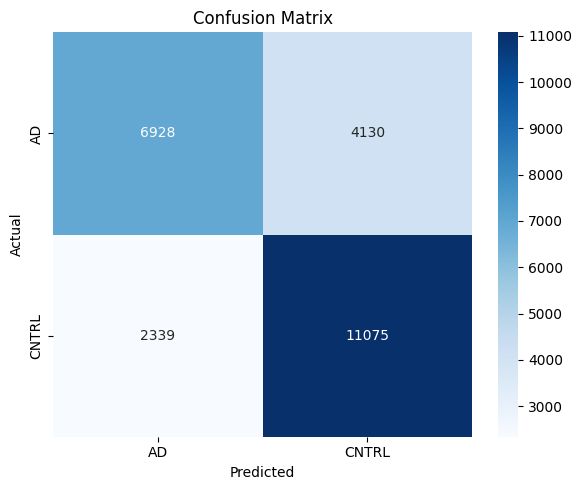

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(all_trues, all_preds, target_names=le.classes_))

cm = confusion_matrix(all_trues, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Subject-Level Accuracy: 0.8750 (14/16)


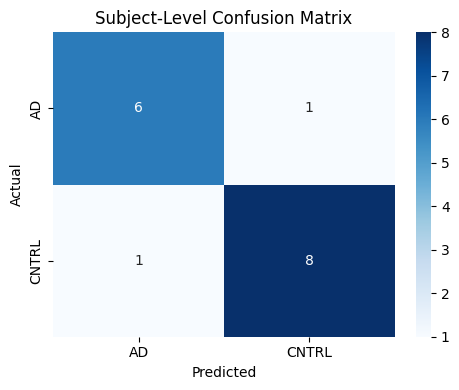

Subject-level classification report:
              precision    recall  f1-score   support

          AD       0.86      0.86      0.86         7
       CNTRL       0.89      0.89      0.89         9

    accuracy                           0.88        16
   macro avg       0.87      0.87      0.87        16
weighted avg       0.88      0.88      0.88        16

        Subject | True Label | Pred Label |   #AD |  #CNTRL
------------------------------------------------------------
    Subject_057 |      CNTRL |         AD |   812 |     784
    Subject_060 |      CNTRL |      CNTRL |   306 |    1138
    Subject_062 |      CNTRL |      CNTRL |   111 |    1466
    Subject_066 |      CNTRL |      CNTRL |   125 |    1376
    Subject_073 |      CNTRL |      CNTRL |   142 |    1283
    Subject_075 |      CNTRL |      CNTRL |    40 |    1556
    Subject_077 |      CNTRL |      CNTRL |    84 |    1341
    Subject_079 |      CNTRL |      CNTRL |   181 |    1187
    Subject_080 |      CNTRL |     

In [ ]:
# After majority voting:
subject_level_true = []
subject_level_pred = []

for subj, votes in subject_votes.items():
    final_pred = Counter(votes).most_common(1)[0][0]
    subject_level_pred.append(final_pred)
    subject_level_true.append(subject_true[subj])

# Print subject-level accuracy
acc = np.mean(np.array(subject_level_pred) == np.array(subject_level_true))
print(f"Subject-Level Accuracy: {acc:.4f} ({sum(np.array(subject_level_pred) == np.array(subject_level_true))}/{len(subject_level_true)})")

# Subject-level confusion matrix
cm_subject = confusion_matrix(subject_level_true, subject_level_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm_subject, annot=True, fmt="d",
            xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Subject-Level Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Subject-level classification report
print("Subject-level classification report:")
print(classification_report(subject_level_true, subject_level_pred, target_names=le.classes_))



idx_to_label = dict(enumerate(le.classes_))
subject_names = list(subject_votes.keys())

print(f"{'Subject':>15} | {'True Label':>10} | {'Pred Label':>10} | {'#AD':>5} | {'#CNTRL':>7}")
print('-'*60)
for subj, true_idx, pred_idx in zip(subject_names, subject_level_true, subject_level_pred):
    img_preds = subject_votes[subj]
    # Count predictions for each class
    count_AD = sum(1 for p in img_preds if idx_to_label[p] == "AD")
    count_CNTRL = sum(1 for p in img_preds if idx_to_label[p] == "CNTRL")
    true_label = idx_to_label[true_idx]
    pred_label = idx_to_label[pred_idx]
    print(f"{subj:>15} | {true_label:>10} | {pred_label:>10} | {count_AD:5d} | {count_CNTRL:7d}")


#### No need external libraries

Collected saliency maps -> AD=200, CNTRL=200


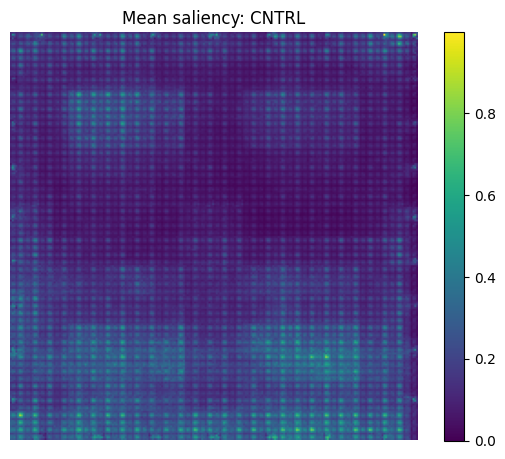

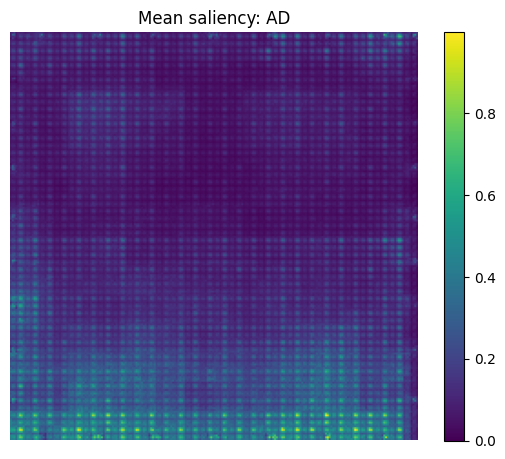

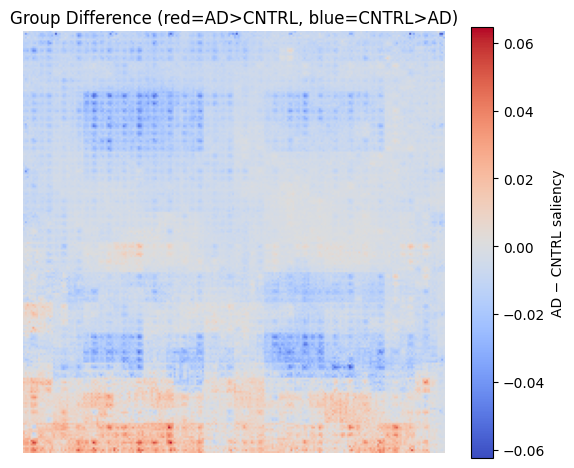

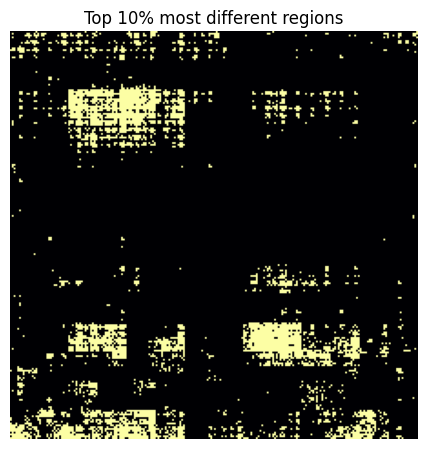

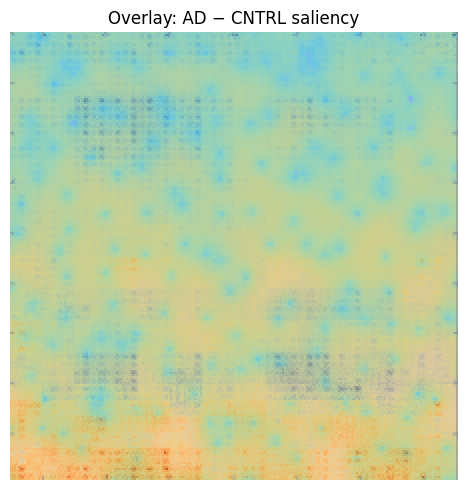

In [ ]:
# ========= FAST XAI (fixed; no nonlocal, no extra installs) =========
import torch, numpy as np, matplotlib.pyplot as plt

model.eval()
device = next(model.parameters()).device

# --- resolve class indices ---
classes = list(le.classes_)
assert "AD" in classes and "CNTRL" in classes, f"LabelEncoder classes must include AD and CNTRL, got: {classes}"
idx_AD, idx_CNTRL = classes.index("AD"), classes.index("CNTRL")

@torch.no_grad()
def get_preds(imgs):
    out = model(imgs.to(device))
    return out.argmax(1).cpu()

def saliency_batch(model, imgs, target_idx):
    imgs = imgs.to(device).float().requires_grad_(True)
    model.zero_grad(set_to_none=True)
    logits = model(imgs)
    scores = logits[torch.arange(imgs.size(0), device=device), target_idx.to(device)]
    scores.sum().backward()
    grads = imgs.grad.detach().abs()              # [B,3,H,W]
    sal = grads.max(dim=1).values                 # [B,H,W]
    # normalize per image to [0,1]
    B,H,W = sal.shape
    sal = sal.view(B,-1)
    mins = sal.min(dim=1, keepdim=True).values
    maxs = sal.max(dim=1, keepdim=True).values
    sal = ((sal - mins) / (maxs - mins + 1e-8)).view(B,H,W).cpu()
    return sal

# -------- aggregate group-wise mean saliency on a subset --------
max_per_group   = 200    # lower (e.g., 50–100) for speed
only_correct    = True   # keep only correctly classified samples
use_true_target = True   # target = true labels (or set False to use predicted)

sum_ad, sum_hc = None, None
n_ad, n_hc = 0, 0

for imgs, labels, _ in test_loader:
    if n_ad >= max_per_group and n_hc >= max_per_group:
        break

    preds = get_preds(imgs)
    keep = (preds == labels) if only_correct else torch.ones_like(labels, dtype=torch.bool)

    # process AD
    if n_ad < max_per_group:
        mask = keep & (labels == idx_AD)
        if mask.any():
            sel = mask.nonzero(as_tuple=False).squeeze(1)[: (max_per_group - n_ad)]
            t_idx = (labels if use_true_target else preds)[sel]
            sal = saliency_batch(model, imgs[sel], t_idx)    # [b,H,W]
            s = sal.sum(dim=0)                               # [H,W]
            sum_ad = s if sum_ad is None else sum_ad + s
            n_ad += sal.shape[0]

    # process CNTRL
    if n_hc < max_per_group:
        mask = keep & (labels == idx_CNTRL)
        if mask.any():
            sel = mask.nonzero(as_tuple=False).squeeze(1)[: (max_per_group - n_hc)]
            t_idx = (labels if use_true_target else preds)[sel]
            sal = saliency_batch(model, imgs[sel], t_idx)
            s = sal.sum(dim=0)
            sum_hc = s if sum_hc is None else sum_hc + s
            n_hc += sal.shape[0]

print(f"Collected saliency maps -> AD={n_ad}, CNTRL={n_hc}")
assert sum_ad is not None and sum_hc is not None, "Not enough samples collected."

mean_ad  = (sum_ad / max(n_ad,1)).numpy()
mean_hc  = (sum_hc / max(n_hc,1)).numpy()
diff_map = mean_ad - mean_hc  # >0 : more AD-salient; <0 : more CNTRL-salient

# -------- visualize --------
def show_map(m, title, cmap="viridis"):
    mm = (m - m.min()) / (m.max() - m.min() + 1e-8)
    plt.figure(figsize=(5.4,4.6)); plt.imshow(mm, cmap=cmap)
    plt.title(title); plt.axis("off"); plt.colorbar(); plt.tight_layout(); plt.show()

show_map(mean_hc, "Mean saliency: CNTRL")
show_map(mean_ad, "Mean saliency: AD")

plt.figure(figsize=(5.8,4.8))
plt.imshow(diff_map, cmap="coolwarm")
plt.colorbar(label="AD − CNTRL saliency")
plt.title("Group Difference (red=AD>CNTRL, blue=CNTRL>AD)")
plt.axis("off"); plt.tight_layout(); plt.show()

# Top-k% most different regions (mask)
k = 0.10
thr = np.quantile(np.abs(diff_map).ravel(), 1 - k)
mask = (np.abs(diff_map) >= thr).astype(float)
plt.figure(figsize=(5.4,4.6)); plt.imshow(mask, cmap="inferno")
plt.title(f"Top {int(k*100)}% most different regions"); plt.axis("off"); plt.tight_layout(); plt.show()

# Optional overlay on a sample CWT image
sample_imgs, _, _ = next(iter(test_loader))
bg = (sample_imgs[0]*0.5 + 0.5).permute(1,2,0).clamp(0,1).cpu().numpy()
d_norm = (diff_map - diff_map.min()) / (diff_map.max() - diff_map.min() + 1e-8)
plt.figure(figsize=(6,5)); plt.imshow(bg); plt.imshow(d_norm, alpha=0.55, cmap="coolwarm")
plt.title("Overlay: AD − CNTRL saliency"); plt.axis("off"); plt.tight_layout(); plt.show()


In [ ]:
# ===================== SAVE XAI MAPS + DOWNLOAD (Colab) =====================
import os, json, csv, zipfile
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

RUN_TAG = "fold3_post_EC"   # <<<< your requested tag
OUT_ROOT = Path("/content/xai_exports")
OUT_DIR  = OUT_ROOT / RUN_TAG
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Helper: save array as PNG (0..1 normalize if needed) and as .npy and .csv
def save_array_all(name, arr, cmap="viridis"):
    base = f"{RUN_TAG}__{name}"
    arr = np.asarray(arr)
    # npy
    np.save(OUT_DIR / f"{base}.npy", arr)
    # csv (2D only)
    if arr.ndim == 2:
        with open(OUT_DIR / f"{base}.csv", "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerows(arr.tolist())
    # png
    a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
    plt.figure(figsize=(6,5))
    plt.imshow(a, cmap=cmap)
    plt.title(base)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"{base}.png", dpi=200, bbox_inches="tight")
    plt.close()

# Save the group maps
save_array_all("mean_cntrl_saliency", mean_hc, cmap="viridis")
save_array_all("mean_ad_saliency",    mean_ad, cmap="viridis")
save_array_all("diff_ad_minus_cntrl", diff_map, cmap="coolwarm")
save_array_all("topk_mask",           mask, cmap="inferno")

# Save an overlay PNG (assumes 'bg' and 'd_norm' already exist)
plt.figure(figsize=(6,5))
plt.imshow(bg)
plt.imshow(d_norm, alpha=0.55, cmap="coolwarm")
plt.title(f"{RUN_TAG}__overlay_ad_minus_cntrl")
plt.axis("off")
plt.tight_layout()
plt.savefig(OUT_DIR / f"{RUN_TAG}__overlay_ad_minus_cntrl.png", dpi=200, bbox_inches="tight")
plt.close()

# Save a small JSON with run meta
meta = {
    "run_tag": RUN_TAG,
    "n_used_AD": int(n_ad),
    "n_used_CNTRL": int(n_hc),
    "k_top_percent": float(k),
    "abs_threshold": float(thr),
    "classes": classes,
}
with open(OUT_DIR / f"{RUN_TAG}__metadata.json", "w") as f:
    json.dump(meta, f, indent=2)

# -------- OPTIONAL: SAVE PER-IMAGE SALIENCY MAPS (can be heavy!) ----------
SAVE_PER_IMAGE = False     # set True if you want every selected image saved
PER_IMG_LIMIT  = 200       # safety limit (per group)

if SAVE_PER_IMAGE:
    PER_DIR = OUT_DIR / "per_image_saliency"
    PER_DIR.mkdir(parents=True, exist_ok=True)

    saved_ad = 0
    saved_hc = 0
    for imgs, labels, paths in test_loader:
        if saved_ad >= PER_IMG_LIMIT and saved_hc >= PER_IMG_LIMIT:
            break
        preds = get_preds(imgs)
        keep = (preds == labels) if only_correct else torch.ones_like(labels, dtype=torch.bool)

        # AD group
        if saved_ad < PER_IMG_LIMIT:
            mask_ad = keep & (labels == idx_AD)
            if mask_ad.any():
                sel = mask_ad.nonzero(as_tuple=False).squeeze(1)
                sel = sel[: max(0, PER_IMG_LIMIT - saved_ad)]
                t_idx = (labels if use_true_target else preds)[sel]
                sal = saliency_batch(model, imgs[sel], t_idx)    # [b,H,W]
                for i, si in enumerate(sal):
                    subj_dir = Path(paths[sel[i]]).parent.name
                    base = Path(paths[sel[i]]).stem
                    arr = si.numpy()
                    np.save(PER_DIR / f"{RUN_TAG}__{subj_dir}__{base}__AD.npy", arr)
                    a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
                    plt.figure(figsize=(5,4))
                    plt.imshow(a, cmap="viridis")
                    plt.title(f"{RUN_TAG} :: {subj_dir} :: {base} :: AD")
                    plt.axis("off"); plt.tight_layout()
                    plt.savefig(PER_DIR / f"{RUN_TAG}__{subj_dir}__{base}__AD.png", dpi=160, bbox_inches="tight")
                    plt.close()
                saved_ad += sal.shape[0]

        # CNTRL group
        if saved_hc < PER_IMG_LIMIT:
            mask_hc = keep & (labels == idx_CNTRL)
            if mask_hc.any():
                sel = mask_hc.nonzero(as_tuple=False).squeeze(1)
                sel = sel[: max(0, PER_IMG_LIMIT - saved_hc)]
                t_idx = (labels if use_true_target else preds)[sel]
                sal = saliency_batch(model, imgs[sel], t_idx)
                for i, si in enumerate(sal):
                    subj_dir = Path(paths[sel[i]]).parent.name
                    base = Path(paths[sel[i]]).stem
                    arr = si.numpy()
                    np.save(PER_DIR / f"{RUN_TAG}__{subj_dir}__{base}__CNTRL.npy", arr)
                    a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
                    plt.figure(figsize=(5,4))
                    plt.imshow(a, cmap="viridis")
                    plt.title(f"{RUN_TAG} :: {subj_dir} :: {base} :: CNTRL")
                    plt.axis("off"); plt.tight_layout()
                    plt.savefig(PER_DIR / f"{RUN_TAG}__{subj_dir}__{base}__CNTRL.png", dpi=160, bbox_inches="tight")
                    plt.close()
                saved_hc += sal.shape[0]

# -------- ZIP + DOWNLOAD (Colab) ----------
ZIP_PATH = f"/content/xai_exports_{RUN_TAG}.zip"
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for p in OUT_ROOT.rglob("*"):
        zf.write(p, arcname=p.relative_to(OUT_ROOT.parent))

print(f"Saved XAI exports to: {OUT_DIR}")
print(f"Zipped at: {ZIP_PATH}")

try:
    from google.colab import files
    files.download(ZIP_PATH)
except Exception as e:
    print("Colab download not available in this environment:", e)
    print("You can also copy the folder to Drive, e.g.:")
    print("!mkdir -p '/content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports' && cp -r /content/xai_exports '/content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports'")
# =====================================================================


Saved XAI exports to: /content/xai_exports/fold3_post_EC
Zipped at: /content/xai_exports_fold3_post_EC.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# import torch, numpy as np, matplotlib.pyplot as plt
# import torch.nn.functional as F

# def make_patch_masks(H, W, patch=32, stride=32, device="cpu"):
#     ys = list(range(0, H - patch + 1, stride))
#     xs = list(range(0, W - patch + 1, stride))
#     masks = []
#     for y in ys:
#         for x in xs:
#             m = torch.zeros(1, 1, H, W, device=device)
#             m[:, :, y:y+patch, x:x+patch] = 1.0
#             masks.append(m)
#     return torch.cat(masks, dim=0), len(ys), len(xs)  # [K,1,H,W], Gy, Gx

# def occlusion_saliency_batch(model, imgs, target_idx, patch=32, stride=32, fill_val=0.0, chunk_masks=8):
#     """
#     Returns coarse heatmaps [B,H,W] using patch occlusion. No grads, just forward passes.
#     """
#     device = imgs.device
#     B, C, H, W = imgs.shape
#     masks, Gy, Gx = make_patch_masks(H, W, patch=patch, stride=stride, device=device)  # [K,1,H,W]
#     K = masks.shape[0]

#     with torch.no_grad():
#         base = model(imgs)  # [B,C]
#         base_t = base[torch.arange(B), target_idx]  # [B]
#     heat = torch.zeros(B, H, W, device=device)

#     # Process masks in chunks to control memory
#     for i in range(0, K, chunk_masks):
#         m = masks[i:i+chunk_masks]                     # [m,1,H,W]
#         # Broadcast to [B,m,3,H,W]
#         x_occ = imgs.unsqueeze(1) * (1 - m) + fill_val * m
#         x_occ = x_occ.view(-1, C, H, W)               # [B*m,3,H,W]
#         with torch.no_grad():
#             logits = model(x_occ)                     # [B*m,C]
#             logits = logits.view(B, -1, base.shape[1])# [B,m,C]
#             scores = logits[..., target_idx.view(B,1)]# [B,m,1]
#             scores = scores.squeeze(-1)               # [B,m]
#         drop = (base_t.unsqueeze(1) - scores).clamp_min(0.0)  # [B,m]

#         # Paint the drop back onto the corresponding patch areas
#         # (uniformly add the drop value over that patch)
#         for jj in range(m.shape[0]):
#             yx = (i + jj)
#             y_idx = (yx // Gx) * stride
#             x_idx = (yx %  Gx) * stride
#             heat[:, y_idx:y_idx+patch, x_idx:x_idx+patch] += drop[:, jj].unsqueeze(-1).unsqueeze(-1)

#     # Normalize per image
#     B = heat.size(0)
#     heat = heat.view(B, -1)
#     heat = (heat - heat.min(dim=1, keepdim=True).values) / (heat.max(dim=1, keepdim=True).values - heat.min(dim=1, keepdim=True).values + 1e-8)
#     heat = heat.view(B, H, W)
#     return heat

# # Aggregate per group (same pattern as above)
# max_per_group = 80          # keep small; occlusion is heavier than saliency
# only_correct  = True
# use_true_target = True
# patch, stride = 32, 32
# chunk_masks   = 8

# sum_ad = None; n_ad = 0
# sum_hc = None; n_hc = 0

# for imgs, labels, _ in test_loader:
#     if n_ad >= max_per_group and n_hc >= max_per_group:
#         break
#     preds = get_preds(imgs)
#     keep = (preds == labels) if only_correct else torch.ones_like(labels, dtype=torch.bool)
#     for group_idx, is_ad in [(idx_AD, True), (idx_CNTRL, False)]:
#         m = keep & (labels == group_idx)
#         if m.sum() == 0:
#             continue
#         budget = (max_per_group - (n_ad if is_ad else n_hc))
#         if budget <= 0:
#             continue
#         sel = m.nonzero(as_tuple=False).squeeze(1)[:budget]
#         t_idx = (labels if use_true_target else preds)[sel]
#         heat = occlusion_saliency_batch(model, imgs[sel].to(device), t_idx.to(device),
#                                         patch=patch, stride=stride, chunk_masks=chunk_masks)  # [b,H,W]
#         s = heat.sum(dim=0)
#         if is_ad:
#             sum_ad = s if sum_ad is None else sum_ad + s
#             n_ad  += heat.shape[0]
#         else:
#             sum_hc = s if sum_hc is None else sum_hc + s
#             n_hc  += heat.shape[0]

# print(f"[Occlusion] Collected: AD={n_ad}, CNTRL={n_hc}")
# mean_ad_occ = (sum_ad / max(n_ad,1)).cpu().numpy()
# mean_hc_occ = (sum_hc / max(n_hc,1)).cpu().numpy()
# diff_occ    = mean_ad_occ - mean_hc_occ

# plt.figure(figsize=(5.6,4.8))
# plt.imshow(diff_occ, cmap="coolwarm")
# plt.colorbar(label="AD − CNTRL (occlusion)")
# plt.title("Group Difference via Patch-Occlusion")
# plt.axis("off"); plt.tight_layout(); plt.show()


In [ ]:
# ===================== SAVE TO GOOGLE DRIVE (+ RAR) =====================
import shutil, subprocess
from pathlib import Path

# Mount Drive (safe to call even if already mounted)
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

DRIVE_BASE = Path('/content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports')
DRIVE_BASE.mkdir(parents=True, exist_ok=True)

# 1) Copy the run folder to Drive
DRIVE_RUN_DIR = DRIVE_BASE / RUN_TAG
if DRIVE_RUN_DIR.exists():
    shutil.rmtree(DRIVE_RUN_DIR)
shutil.copytree(OUT_DIR, DRIVE_RUN_DIR)

# 2) Copy the ZIP to Drive
DRIVE_ZIP = DRIVE_BASE / f"xai_exports_{RUN_TAG}.zip"
shutil.copy2(ZIP_PATH, DRIVE_ZIP)

print(f"Copied to Drive folder: {DRIVE_RUN_DIR}")
print(f"Copied ZIP to Drive:    {DRIVE_ZIP}")

# 3) OPTIONAL: Create a RAR archive directly in Drive
#    This installs 'rar' (non-free) in the Colab VM, then writes a .rar into Drive.
try:
    print("Attempting to create RAR in Drive...")
    subprocess.run(["apt-get", "update", "-y"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    subprocess.run(["apt-get", "install", "-y", "rar"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)

    DRIVE_RAR = DRIVE_BASE / f"xai_exports_{RUN_TAG}.rar"
    # 'rar a -r <archive> <folder_to_add>'  (-r = recurse)
    # Use the *parent* of OUT_DIR so it stores the folder name inside the archive neatly
    subprocess.run(["rar", "a", "-r", str(DRIVE_RAR), str(OUT_DIR)], check=True)

    print(f"RAR saved to Drive:     {DRIVE_RAR}")
except Exception as e:
    print("Could not create .rar (keeping .zip). Error:", e)
# ======================================================================


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copied to Drive folder: /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports/fold3_post_EC
Copied ZIP to Drive:    /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports/xai_exports_fold3_post_EC.zip
Attempting to create RAR in Drive...
RAR saved to Drive:     /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports/xai_exports_fold3_post_EC.rar


#### New XAI (IG + SmoothGrad IG)

In [ ]:
# # ========================= XAI (IG + SmoothGrad IG) =========================
# import os, json, csv, zipfile, math, subprocess, shutil
# from pathlib import Path
# from collections import defaultdict, Counter

# import numpy as np
# import torch
# import torch.nn.functional as F
# import matplotlib.pyplot as plt

# # ------------------------ CONFIG ------------------------
# RUN_TAG          = "fold3_post_EC_IG_SGIG"  # customize per run
# OUT_ROOT         = Path("/content/xai_exports")
# OUT_DIR          = OUT_ROOT / RUN_TAG
# OUT_DIR.mkdir(parents=True, exist_ok=True)

# # Saliency collection
# MAX_PER_GROUP_IG    = 200   # how many correctly-classified images per group for IG
# MAX_PER_GROUP_SGIG  = 200   # for SmoothGradIG
# USE_TRUE_TARGET     = True  # True -> IG wrt true label; False -> wrt predicted class

# # Integrated Gradients settings
# IG_STEPS         = 32       # Riemann steps along the path
# BASELINE_KIND    = "zero"   # "zero" or "black" (zero is fine; inputs are normalized)

# # SmoothGrad IG settings
# SG_N_SAMPLES     = 25
# SG_NOISE_SIGMA   = 0.10     # noise std in input space (on normalized scale)

# # Significance testing (optional)
# DO_STAT_TEST     = False           # flip to True to compute pixel-wise tests (heavier)
# SIG_MAX_PER_GRP  = 120             # cap #images per group for stats to save memory
# ALPHA_FDR        = 0.05            # FDR level

# # Frequency axis (low frequency at bottom row)
# FREQ_MIN = 0.5   # Hz
# FREQ_MAX = 45.0  # Hz

# # Bands (name, low, high) in Hz
# BAND_EDGES = [
#     ("delta", 0.5, 4.0),
#     ("theta", 4.0, 8.0),
#     ("alpha", 8.0, 13.0),
#     ("beta", 13.0, 30.0),
#     ("gamma", 30.0, 45.0),
# ]

# # --------------------- helpers: saving -------------------
# def save_array_all(name, arr, cmap="viridis"):
#     """Save arr as .npy, .csv (if 2D), and .png."""
#     base = f"{RUN_TAG}__{name}"
#     arr = np.asarray(arr)
#     # npy
#     np.save(OUT_DIR / f"{base}.npy", arr)
#     # csv (2D only)
#     if arr.ndim == 2:
#         with open(OUT_DIR / f"{base}.csv", "w", newline="") as f:
#             writer = csv.writer(f)
#             writer.writerows(arr.tolist())
#     # png (0..1 normalize for viewing)
#     a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8) if arr.size else arr
#     plt.figure(figsize=(6,5))
#     plt.imshow(a, cmap=cmap)
#     plt.title(base)
#     plt.axis("off")
#     plt.tight_layout()
#     plt.savefig(OUT_DIR / f"{base}.png", dpi=200, bbox_inches="tight")
#     plt.close()

# def save_overlay(bg_img_hwc01, heat_2d, name, cmap="coolwarm", alpha=0.55):
#     """bg_img_hwc01 in [0,1], heat_2d any real values."""
#     base = f"{RUN_TAG}__{name}"
#     h = (heat_2d - heat_2d.min()) / (heat_2d.max() - heat_2d.min() + 1e-8)
#     plt.figure(figsize=(6,5))
#     plt.imshow(bg_img_hwc01)
#     plt.imshow(h, alpha=alpha, cmap=cmap)
#     plt.title(base)
#     plt.axis("off")
#     plt.tight_layout()
#     plt.savefig(OUT_DIR / f"{base}.png", dpi=200, bbox_inches="tight")
#     plt.close()

# # ------------------ helpers: IG & SmoothGrad IG ------------------
# def _make_baseline_like(img):
#     # img: [3,H,W]
#     if BASELINE_KIND == "zero":
#         return torch.zeros_like(img)
#     elif BASELINE_KIND == "black":
#         return torch.zeros_like(img)  # same for normalized inputs
#     else:
#         return torch.zeros_like(img)

# @torch.no_grad()
# def get_preds(imgs, model):
#     out = model(imgs.to(device))
#     return out.argmax(1).cpu()

# def integrated_gradients(model, imgs, target_idx, steps=32):
#     """
#     Robust IG: works for [B,3,H,W] or [3,H,W], returns [B,H,W] (abs-mean over channels).
#     Force-enables autograd for the forward/backward.
#     """
#     model.eval()
#     device_local = next(model.parameters()).device

#     # ---- enforce shapes on inputs/targets ----
#     if imgs.dim() == 3:   # [3,H,W] -> [1,3,H,W]
#         imgs = imgs.unsqueeze(0)
#     imgs = imgs.to(device_local)

#     if isinstance(target_idx, (int,)):
#         target_idx = torch.tensor([target_idx], device=device_local, dtype=torch.long)
#     else:
#         target_idx = target_idx.to(device_local)
#         if target_idx.dim() == 0:
#             target_idx = target_idx.unsqueeze(0)

#     B, C, H, W = imgs.shape
#     alphas = torch.linspace(0., 1., steps + 1, device=device_local)  # [steps+1]
#     sal_out = torch.zeros(B, H, W, device=device_local)

#     # IG per sample for stability
#     for i in range(B):
#         x = imgs[i:i+1].clone()                     # [1,3,H,W]
#         y_idx = int(target_idx[i].item())
#         baseline = torch.zeros_like(x)              # [1,3,H,W]

#         # Path: [steps+1, 1, 3, H, W]
#         path = baseline + alphas.view(-1, 1, 1, 1) * (x - baseline)

#         grads_sum = torch.zeros_like(x)
#         # ensure autograd is enabled for these iterations
#         for t in range(path.shape[0]):
#             xt = path[t]
#             if xt.dim() == 3:
#                 xt = xt.unsqueeze(0)
#             xt = xt.clone().detach().requires_grad_(True)

#             # ---- enable grad just for this forward/backward ----
#             with torch.enable_grad():
#                 logits = model(xt)                  # [1,num_classes], must carry grad_fn
#                 score = logits[:, y_idx].sum()      # scalar
#                 model.zero_grad(set_to_none=True)
#                 score.backward()

#             grads_sum = grads_sum + xt.grad.detach()

#         grads_mean = grads_sum / float(steps + 1)
#         ig = (x - baseline) * grads_mean            # [1,3,H,W]
#         ig = ig.abs().mean(dim=1).squeeze(0)        # [H,W]
#         sal_out[i] = ig

#     return sal_out  # [B,H,W]


# def smoothgrad_ig(model, imgs, target_idx, steps=32, n_samples=25, noise_sigma=0.10):
#     """
#     SmoothGrad over IG; returns [B,H,W]. Force-enables autograd internally.
#     """
#     model.eval()
#     device_local = next(model.parameters()).device

#     if imgs.dim() == 3:
#         imgs = imgs.unsqueeze(0)
#     imgs = imgs.to(device_local)

#     if isinstance(target_idx, (int,)):
#         target_idx = torch.tensor([target_idx], device=device_local, dtype=torch.long)
#     else:
#         target_idx = target_idx.to(device_local)
#         if target_idx.dim() == 0:
#             target_idx = target_idx.unsqueeze(0)

#     B, C, H, W = imgs.shape
#     out = torch.zeros(B, H, W, device=device_local)

#     for _ in range(n_samples):
#         noise = torch.randn_like(imgs) * noise_sigma
#         noisy = (imgs + noise).clamp(-1.0, 1.0)
#         # IG itself uses enable_grad(), so we can call it directly
#         out += integrated_gradients(model, noisy, target_idx, steps=steps)

#     out /= float(n_samples)
#     return out

# # ---------------------- helpers: aggregation ----------------------
# def aggregate_group_mean(sal_batch, sum_group, n_group):
#     """sal_batch: [b,H,W] to add; returns updated (sum,n)."""
#     if sal_batch is None or sal_batch.numel() == 0:
#         return sum_group, n_group
#     s = sal_batch.sum(dim=0)  # [H,W]
#     sum_group = s if sum_group is None else (sum_group + s)
#     n_group += sal_batch.shape[0]
#     return sum_group, n_group

# def to_numpy_norm(x):
#     x = x.detach().float().cpu().numpy()
#     return x

# def topk_mask_from_abs(arr2d, frac=0.10):
#     """Return binary mask of top-|arr| pixels covering 'frac' of total pixels."""
#     a = np.abs(arr2d)
#     flat = a.ravel()
#     k = max(1, int(round(frac * flat.size)))
#     thr = np.partition(flat, -k)[-k]  # k-th largest
#     return (a >= thr).astype(np.float32), float(thr)

# # ---------------------- helpers: band coverage --------------------
# def percent_band_coverage(mask, band_edges, freq_min=FREQ_MIN, freq_max=FREQ_MAX):
#     """
#     mask: [H,W] binary (1=selected), low frequency at bottom (y=H-1 -> freq_min).
#     returns dict band_name -> percent of mask pixels in that band.
#     """
#     H, W = mask.shape
#     total = mask.sum()
#     if total == 0:
#         return {name: 0.0 for (name,_,_) in band_edges}
#     yy = np.arange(H)  # 0..H-1 top->bottom
#     # y=0 -> freq_max, y=H-1 -> freq_min
#     freq = freq_min + (1.0 - yy / max(H-1,1)) * (freq_max - freq_min)
#     out = {}
#     for (name, f_lo, f_hi) in band_edges:
#         rows = (freq >= f_lo) & (freq < f_hi)
#         band_total = mask[rows, :].sum()
#         out[name] = 100.0 * float(band_total) / float(total)
#     return out

# # ------------------------ collect saliencies ----------------------
# model.eval()
# classes = list(le.classes_)
# assert "AD" in classes and "CNTRL" in classes
# idx_AD, idx_CNTRL = classes.index("AD"), classes.index("CNTRL")

# sum_ad_ig = None; sum_hc_ig = None; n_ad_ig = 0; n_hc_ig = 0
# sum_ad_sg = None; sum_hc_sg = None; n_ad_sg = 0; n_hc_sg = 0

# # For overlay (background)
# try:
#     sample_imgs, sample_labels, sample_paths = next(iter(test_loader))
#     bg = (sample_imgs[0]*0.5 + 0.5).permute(1,2,0).clamp(0,1).cpu().numpy()
# except StopIteration:
#     bg = None

# with torch.no_grad():
#     for imgs, labels, paths in test_loader:
#         preds = get_preds(imgs, model)
#         keep = (preds == labels)  # only_correct=True

#         # ---- IG for AD ----
#         if n_ad_ig < MAX_PER_GROUP_IG:
#             m_ad = keep & (labels == idx_AD)
#             if m_ad.any():
#                 sel = m_ad.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_IG - n_ad_ig)]
#                 tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                 ig_batch = integrated_gradients(model, imgs[sel], tgt, steps=IG_STEPS) # [b,H,W]
#                 sum_ad_ig, n_ad_ig = aggregate_group_mean(ig_batch, sum_ad_ig, n_ad_ig)

#         # ---- IG for CNTRL ----
#         if n_hc_ig < MAX_PER_GROUP_IG:
#             m_hc = keep & (labels == idx_CNTRL)
#             if m_hc.any():
#                 sel = m_hc.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_IG - n_hc_ig)]
#                 tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                 ig_batch = integrated_gradients(model, imgs[sel], tgt, steps=IG_STEPS)
#                 sum_hc_ig, n_hc_ig = aggregate_group_mean(ig_batch, sum_hc_ig, n_hc_ig)

#         # ---- SG-IG for AD ----
#         if n_ad_sg < MAX_PER_GROUP_SGIG:
#             m_ad = keep & (labels == idx_AD)
#             if m_ad.any():
#                 sel = m_ad.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_SGIG - n_ad_sg)]
#                 tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                 sg_batch = smoothgrad_ig(model, imgs[sel], tgt, steps=IG_STEPS,
#                                          n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA)
#                 sum_ad_sg, n_ad_sg = aggregate_group_mean(sg_batch, sum_ad_sg, n_ad_sg)

#         # ---- SG-IG for CNTRL ----
#         if n_hc_sg < MAX_PER_GROUP_SGIG:
#             m_hc = keep & (labels == idx_CNTRL)
#             if m_hc.any():
#                 sel = m_hc.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_SGIG - n_hc_sg)]
#                 tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                 sg_batch = smoothgrad_ig(model, imgs[sel], tgt, steps=IG_STEPS,
#                                          n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA)
#                 sum_hc_sg, n_hc_sg = aggregate_group_mean(sg_batch, sum_hc_sg, n_hc_sg)

# print(f"[IG]    Collected: AD={n_ad_ig}, CNTRL={n_hc_ig}")
# print(f"[SG-IG] Collected: AD={n_ad_sg}, CNTRL={n_hc_sg}")
# assert n_ad_ig>0 and n_hc_ig>0 and n_ad_sg>0 and n_hc_sg>0, "Not enough samples collected."

# # ---------------------- group means & diffs ----------------------
# mean_ad_ig = to_numpy_norm(sum_ad_ig / max(n_ad_ig,1))
# mean_hc_ig = to_numpy_norm(sum_hc_ig / max(n_hc_ig,1))
# diff_ig    = mean_ad_ig - mean_hc_ig

# mean_ad_sg = to_numpy_norm(sum_ad_sg / max(n_ad_sg,1))
# mean_hc_sg = to_numpy_norm(sum_hc_sg / max(n_hc_sg,1))
# diff_sg    = mean_ad_sg - mean_hc_sg

# # ---------------------- top-k masks & band coverage --------------
# for frac in [0.10, 0.20]:
#     name = f"top{int(frac*100)}"
#     # IG
#     mask_ig, thr_ig = topk_mask_from_abs(diff_ig, frac=frac)
#     cov_ig = percent_band_coverage(mask_ig, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
#     save_array_all(f"{name}_mask_IG", mask_ig, cmap="inferno")
#     # SG-IG
#     mask_sg, thr_sg = topk_mask_from_abs(diff_sg, frac=frac)
#     cov_sg = percent_band_coverage(mask_sg, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
#     save_array_all(f"{name}_mask_SGIG", mask_sg, cmap="inferno")

#     # save band coverage as JSON
#     with open(OUT_DIR / f"{RUN_TAG}__{name}_band_coverage.json", "w") as f:
#         json.dump({
#             "fraction": frac,
#             "thresholds": {"IG": float(thr_ig), "SGIG": float(thr_sg)},
#             "coverage_percent": {"IG": cov_ig, "SGIG": cov_sg},
#             "bands_hz": BAND_EDGES,
#             "freq_min_max": [FREQ_MIN, FREQ_MAX]
#         }, f, indent=2)

# # ------------------------- save maps & overlays -------------------
# save_array_all("mean_ad_IG",   mean_ad_ig, cmap="viridis")
# save_array_all("mean_cntrl_IG",mean_hc_ig, cmap="viridis")
# save_array_all("diff_ADminusCNTRL_IG", diff_ig, cmap="coolwarm")

# save_array_all("mean_ad_SGIG",   mean_ad_sg, cmap="viridis")
# save_array_all("mean_cntrl_SGIG",mean_hc_sg, cmap="viridis")
# save_array_all("diff_ADminusCNTRL_SGIG", diff_sg, cmap="coolwarm")

# if bg is not None:
#     save_overlay(bg, diff_ig, "overlay_diff_IG")
#     save_overlay(bg, diff_sg, "overlay_diff_SGIG")

# # ------------------- OPTIONAL: significance test -----------------
# if DO_STAT_TEST:
#     print("Running pixel-wise Welch's t-test with BH-FDR...")
#     # Re-collect per-image saliency (capped) for both methods and groups
#     def collect_sal_per_image(method="IG", max_per_grp=SIG_MAX_PER_GRP):
#         ad_list, hc_list = [], []
#         with torch.no_grad():
#             for imgs, labels, paths in test_loader:
#                 preds = get_preds(imgs, model)
#                 keep  = (preds == labels)

#                 # AD
#                 if len(ad_list) < max_per_grp:
#                     m = keep & (labels == idx_AD)
#                     if m.any():
#                         sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, max_per_grp - len(ad_list))]
#                         tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                         if method == "IG":
#                             sal = integrated_gradients(model, imgs[sel], tgt, steps=IG_STEPS)
#                         else:
#                             sal = smoothgrad_ig(model, imgs[sel], tgt, steps=IG_STEPS,
#                                                 n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA)
#                         ad_list.append(sal.cpu().numpy())  # [b,H,W]

#                 # CNTRL
#                 if len(hc_list) < max_per_grp:
#                     m = keep & (labels == idx_CNTRL)
#                     if m.any():
#                         sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, max_per_grp - len(hc_list))]
#                         tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                         if method == "IG":
#                             sal = integrated_gradients(model, imgs[sel], tgt, steps=IG_STEPS)
#                         else:
#                             sal = smoothgrad_ig(model, imgs[sel], tgt, steps=IG_STEPS,
#                                                 n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA)
#                         hc_list.append(sal.cpu().numpy())

#                 if len(ad_list) >= max_per_grp and len(hc_list) >= max_per_grp:
#                     break

#         if len(ad_list)==0 or len(hc_list)==0:
#             return None, None
#         ad_arr = np.concatenate(ad_list, axis=0)  # [N_ad,H,W]
#         hc_arr = np.concatenate(hc_list, axis=0)  # [N_hc,H,W]
#         return ad_arr, hc_arr

#     def welch_ttest_map(ad_arr, hc_arr):
#         """
#         ad_arr, hc_arr: [N,H,W]; returns tmap [H,W], pmap [H,W]
#         """
#         Na, H, W = ad_arr.shape
#         Nh, _, _ = hc_arr.shape
#         mu_a = ad_arr.mean(axis=0)
#         mu_h = hc_arr.mean(axis=0)
#         var_a = ad_arr.var(axis=0, ddof=1)
#         var_h = hc_arr.var(axis=0, ddof=1)
#         # Welch t
#         num = mu_a - mu_h
#         den = np.sqrt(var_a/Na + var_h/Nh) + 1e-12
#         tmap = num / den

#         # Welch-Satterthwaite df
#         df = (var_a/Na + var_h/Nh)**2 / ((var_a**2)/(Na**2*(Na-1)+1e-12) + (var_h**2)/(Nh**2*(Nh-1)+1e-12) + 1e-12)

#         # two-sided p-values from t (approx via survival function of Student's t).
#         # To avoid extra deps, use Gaussian as a close approx when df is large:
#         # p ≈ 2*(1 - Φ(|t|))
#         from math import erf, sqrt
#         def norm_sf(x):  # 1 - CDF
#             return 0.5 * (1 - erf(x/np.sqrt(2)))
#         pmap = 2.0 * norm_sf(np.abs(tmap))
#         return tmap, pmap

#     def bh_fdr(pvals, alpha=0.05):
#         """Benjamini–Hochberg on flattened pvals; returns boolean reject mask (same shape)."""
#         shape = pvals.shape
#         p = pvals.ravel()
#         m = p.size
#         order = np.argsort(p)
#         ranked = p[order]
#         thresh = alpha * (np.arange(1, m+1) / m)
#         passed = ranked <= thresh
#         if not np.any(passed):
#             return np.zeros_like(pvals, dtype=bool)
#         kmax = np.max(np.where(passed)[0])
#         cutoff = ranked[kmax]
#         return (pvals <= cutoff).reshape(shape)

#     for method_name, mean_ad, mean_hc, diff_map in [
#         ("IG",   mean_ad_ig, mean_hc_ig, diff_ig),
#         ("SGIG", mean_ad_sg, mean_hc_sg, diff_sg),
#     ]:
#         data_ad, data_hc = collect_sal_per_image(method=method_name, max_per_grp=SIG_MAX_PER_GRP)
#         if data_ad is None or data_hc is None:
#             print(f"[{method_name}] Not enough data for stats; skipping.")
#             continue
#         tmap, pmap = welch_ttest_map(data_ad, data_hc)
#         sig_mask = bh_fdr(pmap, alpha=ALPHA_FDR).astype(np.float32)
#         save_array_all(f"sigmask_{method_name}_FDR{int(ALPHA_FDR*100)}", sig_mask, cmap="gray")
#         # band coverage on significance mask
#         cov_sig = percent_band_coverage(sig_mask, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
#         with open(OUT_DIR / f"{RUN_TAG}__sigmask_{method_name}_band_coverage.json", "w") as f:
#             json.dump({"coverage_percent": cov_sig,
#                        "alpha_FDR": ALPHA_FDR,
#                        "bands_hz": BAND_EDGES,
#                        "freq_min_max": [FREQ_MIN, FREQ_MAX]}, f, indent=2)

# # ---------------------- write small metadata ---------------------
# meta = {
#     "run_tag": RUN_TAG,
#     "ig": {"n_ad": int(n_ad_ig), "n_cntrl": int(n_hc_ig), "steps": IG_STEPS, "baseline": BASELINE_KIND},
#     "sgig": {"n_ad": int(n_ad_sg), "n_cntrl": int(n_hc_sg),
#              "steps": IG_STEPS, "n_samples": SG_N_SAMPLES, "noise_sigma": SG_NOISE_SIGMA},
#     "bands_hz": BAND_EDGES,
#     "freq_min_max": [FREQ_MIN, FREQ_MAX],
#     "top_masks": ["10%","20%"],
#     "significance_test": {"enabled": bool(DO_STAT_TEST), "alpha_FDR": ALPHA_FDR}
# }
# with open(OUT_DIR / f"{RUN_TAG}__metadata.json", "w") as f:
#     json.dump(meta, f, indent=2)

# # ------------------------- ZIP + (optional) download --------------
# ZIP_PATH = f"/content/xai_exports_{RUN_TAG}.zip"
# with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as zf:
#     for p in OUT_ROOT.rglob("*"):
#         zf.write(p, arcname=p.relative_to(OUT_ROOT.parent))

# print(f"Saved XAI exports to: {OUT_DIR}")
# print(f"Zipped at: {ZIP_PATH}")

# try:
#     from google.colab import files
#     files.download(ZIP_PATH)
# except Exception as e:
#     print("Colab files.download not available here:", e)

# # ------------------------ SAVE TO GOOGLE DRIVE (+ RAR) -------------
# from google.colab import drive as _drive
# _drive.mount('/content/drive', force_remount=False)

# DRIVE_BASE = Path('/content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports')
# DRIVE_BASE.mkdir(parents=True, exist_ok=True)

# # 1) Copy the run folder to Drive
# DRIVE_RUN_DIR = DRIVE_BASE / RUN_TAG
# if DRIVE_RUN_DIR.exists():
#     shutil.rmtree(DRIVE_RUN_DIR)
# shutil.copytree(OUT_DIR, DRIVE_RUN_DIR)

# # 2) Copy the ZIP to Drive
# DRIVE_ZIP = DRIVE_BASE / f"xai_exports_{RUN_TAG}.zip"
# shutil.copy2(ZIP_PATH, DRIVE_ZIP)

# print(f"Copied to Drive folder: {DRIVE_RUN_DIR}")
# print(f"Copied ZIP to Drive:    {DRIVE_ZIP}")

# # 3) OPTIONAL: Create a RAR archive directly in Drive
# try:
#     print("Attempting to create RAR in Drive...")
#     subprocess.run(["apt-get", "update", "-y"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
#     subprocess.run(["apt-get", "install", "-y", "rar"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
#     DRIVE_RAR = DRIVE_BASE / f"xai_exports_{RUN_TAG}.rar"
#     subprocess.run(["rar", "a", "-r", str(DRIVE_RAR), str(OUT_DIR)], check=True)
#     print(f"RAR saved to Drive:     {DRIVE_RAR}")
# except Exception as e:
#     print("Could not create .rar (keeping .zip). Error:", e)
# # ===================================================================


In [ ]:
# ========================= FAST XAI (IG + SmoothGrad IG) =========================

# ---- NEW knobs (safe defaults) ----
B_MICRO_IG   = 4    # images per IG micro-batch (raise to 2/4 if VRAM allows)
B_MICRO_SG   = 4    # images per SG-IG micro-batch
ALPHA_CHUNK  = 8    # alpha steps per chunk (you had 8 before)
PATH_MICRO   = 16   # forward this many path samples at once (limits peak memory)

#====================================================================================================
import os, json, csv, zipfile, math, subprocess, shutil
from pathlib import Path
from collections import defaultdict, Counter

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ------------------------ SPEED PRESET ------------------------
# Choose: "fast" (recommended for iteration) or "accurate" (heavier)
SPEED_PRESET = "fast"

if SPEED_PRESET == "fast":
    MAX_PER_GROUP_IG   = 80     # was 200
    MAX_PER_GROUP_SGIG = 80     # was 200
    IG_STEPS           = 16     # was 32
    SG_N_SAMPLES       = 8      # was 25
    SG_NOISE_SIGMA     = 0.10
    ALPHA_CHUNK        = 8      # vectorize α steps in chunks
elif SPEED_PRESET == "accurate":
    MAX_PER_GROUP_IG   = 200
    MAX_PER_GROUP_SGIG = 200
    IG_STEPS           = 32
    SG_N_SAMPLES       = 25
    SG_NOISE_SIGMA     = 0.10
    ALPHA_CHUNK        = 8
else:
    raise ValueError("SPEED_PRESET must be 'fast' or 'accurate'.")

RUN_TAG          = f"fold3_post_EC_IG_SGIG_{SPEED_PRESET}"
OUT_ROOT         = Path("/content/xai_exports")
OUT_DIR          = OUT_ROOT / RUN_TAG
OUT_DIR.mkdir(parents=True, exist_ok=True)

USE_TRUE_TARGET  = True      # IG wrt true label (or predicted if False)
BASELINE_KIND    = "zero"    # ("zero" is fine for normalized inputs)

# (optional) significance testing
DO_STAT_TEST     = True
SIG_MAX_PER_GRP  = 80
ALPHA_FDR        = 0.05

# Frequency axis (low freq at bottom)
FREQ_MIN = 0.5
FREQ_MAX = 45.0
BAND_EDGES = [
    ("delta", 0.5, 4.0),
    ("theta", 4.0, 8.0),
    ("alpha", 8.0, 13.0),
    ("beta", 13.0, 30.0),
    ("gamma", 30.0, 45.0),
]

# cuDNN speed-up
torch.backends.cudnn.benchmark = True

# --------------------- helpers: saving -------------------
def save_array_all(name, arr, cmap="viridis"):
    base = f"{RUN_TAG}__{name}"
    arr = np.asarray(arr)
    np.save(OUT_DIR / f"{base}.npy", arr)
    if arr.ndim == 2:
        with open(OUT_DIR / f"{base}.csv", "w", newline="") as f:
            writer = csv.writer(f); writer.writerows(arr.tolist())
    a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8) if arr.size else arr
    plt.figure(figsize=(6,5)); plt.imshow(a, cmap=cmap); plt.title(base)
    plt.axis("off"); plt.tight_layout()
    plt.savefig(OUT_DIR / f"{base}.png", dpi=200, bbox_inches="tight"); plt.close()

def save_overlay(bg_img_hwc01, heat_2d, name, cmap="coolwarm", alpha=0.55):
    base = f"{RUN_TAG}__{name}"
    h = (heat_2d - heat_2d.min()) / (heat_2d.max() - heat_2d.min() + 1e-8)
    plt.figure(figsize=(6,5)); plt.imshow(bg_img_hwc01)
    plt.imshow(h, alpha=alpha, cmap=cmap); plt.title(base)
    plt.axis("off"); plt.tight_layout()
    plt.savefig(OUT_DIR / f"{base}.png", dpi=200, bbox_inches="tight"); plt.close()

# ------------------ helpers: IG & SmoothGrad IG ------------------
def _make_baseline_like(img):
    return torch.zeros_like(img)

@torch.no_grad()
def get_preds(imgs, model):
    out = model(imgs.to(device))
    return out.argmax(1).cpu()

def integrated_gradients_fast(model, imgs, target_idx, steps=32,
                              alpha_chunk=ALPHA_CHUNK, b_micro=B_MICRO_IG,
                              path_micro=PATH_MICRO):
    """
    Memory-safe vectorized IG:
      - Splits over images (b_micro),
      - Splits over alpha steps (alpha_chunk),
      - And splits the concatenated path batch further (path_micro).
    Returns saliency [B,H,W] (abs-mean over channels).
    """
    model.eval()
    device_local = next(model.parameters()).device

    if imgs.dim() == 3:
        imgs = imgs.unsqueeze(0)
    imgs = imgs.to(device_local)                     # [B,3,H,W]
    B, C, H, W = imgs.shape

    # normalize / broadcast targets
    if isinstance(target_idx, (int,)):
        target_idx = torch.tensor([target_idx]*B, device=device_local, dtype=torch.long)
    else:
        target_idx = target_idx.to(device_local)
        if target_idx.dim() == 0: target_idx = target_idx.unsqueeze(0)
        if target_idx.numel() != B:
            if target_idx.numel() == 1:
                target_idx = target_idx.repeat(B)
            else:
                target_idx = target_idx.view(-1)[:B]

    baseline = torch.zeros_like(imgs)
    alphas = torch.linspace(0., 1., steps + 1, device=device_local)   # [S]
    out = torch.zeros(B, H, W, device=device_local)

    # loop over images in micro-batches
    for b0 in range(0, B, b_micro):
        b1 = min(B, b0 + b_micro)
        x_mb  = imgs[b0:b1]             # [b,3,H,W]
        base  = baseline[b0:b1]         # [b,3,H,W]
        t_mb  = target_idx[b0:b1]       # [b]
        b = x_mb.shape[0]

        grads_sum = torch.zeros_like(x_mb)
        # split alpha steps into chunks
        for a0 in range(0, alphas.numel(), alpha_chunk):
            a1 = min(alphas.numel(), a0 + alpha_chunk)
            a = alphas[a0:a1]                               # [m]
            # build full path batch for this alpha-chunk: [m,b,3,H,W] -> [m*b,3,H,W]
            path_full = base.unsqueeze(0) + a.view(-1,1,1,1,1) * (x_mb - base).unsqueeze(0)
            path_full = path_full.reshape(-1, C, H, W)      # [m*b,3,H,W]

            # process path in smaller chunks to bound memory
            # accumulate gradients across the chunk
            pos = 0
            grad_accum = torch.zeros_like(path_full)
            while pos < path_full.shape[0]:
                pos_end = min(path_full.shape[0], pos + path_micro)
                path_chunk = path_full[pos:pos_end].clone().detach().requires_grad_(True)

                with torch.enable_grad():
                    logits = model(path_chunk)              # [k, num_classes]
                    # map chunk indices back to which original image target to use
                    # path_full is ordered as alpha-major, then image index inside
                    # We need corresponding target labels for this slice:
                    # determine which (alpha_index, image_index) each row belongs to
                    alpha_idx = torch.arange(pos, pos_end, device=device_local) // b
                    img_idx   = torch.arange(pos, pos_end, device=device_local) %  b
                    tgt_chunk = t_mb[img_idx]
                    scores = logits[torch.arange(path_chunk.size(0), device=device_local), tgt_chunk]
                    total = scores.sum()
                    model.zero_grad(set_to_none=True)
                    total.backward()

                grad_accum[pos:pos_end] = path_chunk.grad.detach()
                del path_chunk, logits, scores
                torch.cuda.empty_cache()
                pos = pos_end

            # reduce grad_accum back to [m,b,3,H,W], sum over m
            grads = grad_accum.reshape(a.shape[0], b, C, H, W).sum(dim=0)  # [b,3,H,W]
            grads_sum = grads_sum + grads

            del path_full, grad_accum, grads
            torch.cuda.empty_cache()

        grads_mean = grads_sum / float(steps + 1)           # [b,3,H,W]
        ig_mb = (x_mb - base) * grads_mean                  # [b,3,H,W]
        ig_mb = ig_mb.abs().mean(dim=1)                     # [b,H,W]
        out[b0:b1] = ig_mb

        del x_mb, base, t_mb, grads_sum, ig_mb
        torch.cuda.empty_cache()

    return out


def smoothgrad_ig_fast(model, imgs, target_idx, steps=32,
                       n_samples=8, noise_sigma=0.10, alpha_chunk=ALPHA_CHUNK,
                       b_micro=B_MICRO_SG, path_micro=PATH_MICRO):
    """
    Memory-safe SmoothGrad over IG:
      - adds noise per sample and reuses the memory-safe IG above
      - splits over images too
    Returns [B,H,W].
    """
    model.eval()
    device_local = next(model.parameters()).device
    if imgs.dim() == 3:
        imgs = imgs.unsqueeze(0)
    imgs = imgs.to(device_local)
    B, C, H, W = imgs.shape

    # normalize / broadcast targets
    if isinstance(target_idx, (int,)):
        target_idx = torch.tensor([target_idx]*B, device=device_local, dtype=torch.long)
    else:
        target_idx = target_idx.to(device_local)
        if target_idx.dim() == 0: target_idx = target_idx.unsqueeze(0)
        if target_idx.numel() != B:
            if target_idx.numel() == 1:
                target_idx = target_idx.repeat(B)
            else:
                target_idx = target_idx.view(-1)[:B]

    out = torch.zeros(B, H, W, device=device_local)

    # do SG in image micro-batches to keep memory bounded
    for b0 in range(0, B, b_micro):
        b1 = min(B, b0 + b_micro)
        x_mb = imgs[b0:b1]
        t_mb = target_idx[b0:b1]
        acc = torch.zeros(x_mb.shape[0], H, W, device=device_local)

        for _ in range(n_samples):
            noise = torch.randn_like(x_mb) * noise_sigma
            noisy = (x_mb + noise).clamp(-1.0, 1.0)
            ig_mb = integrated_gradients_fast(
                model, noisy, t_mb, steps=steps,
                alpha_chunk=alpha_chunk, b_micro=1, path_micro=path_micro
            )
            acc += ig_mb
            del noise, noisy, ig_mb
            torch.cuda.empty_cache()

        out[b0:b1] = acc / float(n_samples)
        del x_mb, t_mb, acc
        torch.cuda.empty_cache()

    return out


# ---------------------- helpers: aggregation ----------------------
def aggregate_group_mean(sal_batch, sum_group, n_group):
    if sal_batch is None or sal_batch.numel() == 0:
        return sum_group, n_group
    s = sal_batch.sum(dim=0)  # [H,W]
    sum_group = s if sum_group is None else (sum_group + s)
    n_group += sal_batch.shape[0]
    return sum_group, n_group

def to_numpy_norm(x):
    return x.detach().float().cpu().numpy()

def topk_mask_from_abs(arr2d, frac=0.10):
    a = np.abs(arr2d); flat = a.ravel()
    k = max(1, int(round(frac * flat.size)))
    thr = np.partition(flat, -k)[-k]
    return (a >= thr).astype(np.float32), float(thr)

# ---------------------- helpers: band coverage --------------------
def percent_band_coverage(mask, band_edges, freq_min=FREQ_MIN, freq_max=FREQ_MAX):
    H, W = mask.shape
    total = mask.sum()
    if total == 0:
        return {name: 0.0 for (name,_,_) in band_edges}
    yy = np.arange(H)  # 0..H-1 top->bottom
    # y=0 -> freq_max, y=H-1 -> freq_min (low freq at bottom)
    freq = freq_min + (1.0 - yy / max(H-1,1)) * (freq_max - freq_min)
    out = {}
    for (name, f_lo, f_hi) in band_edges:
        rows = (freq >= f_lo) & (freq < f_hi)
        out[name] = 100.0 * float(mask[rows, :].sum()) / float(total)
    return out

# ------------------------ collect saliencies ----------------------
model.eval()
device   = next(model.parameters()).device
classes  = list(le.classes_)
assert "AD" in classes and "CNTRL" in classes
idx_AD, idx_CNTRL = classes.index("AD"), classes.index("CNTRL")

sum_ad_ig = None; sum_hc_ig = None; n_ad_ig = 0; n_hc_ig = 0
sum_ad_sg = None; sum_hc_sg = None; n_ad_sg = 0; n_hc_sg = 0

# Overlay background
try:
    sample_imgs, _, _ = next(iter(test_loader))
    bg = (sample_imgs[0]*0.5 + 0.5).permute(1,2,0).clamp(0,1).cpu().numpy()
except StopIteration:
    bg = None

# Pass 1: gather IG and SG-IG (correctly classified only)
with torch.no_grad():
    for imgs, labels, paths in test_loader:
        preds = get_preds(imgs, model)
        keep  = (preds == labels)

        # ---- IG: AD ----
        if n_ad_ig < MAX_PER_GROUP_IG:
            m = keep & (labels == idx_AD)
            if m.any():
                sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_IG - n_ad_ig)]
                tgt = (labels if USE_TRUE_TARGET else preds)[sel]
                ig_b = integrated_gradients_fast(model, imgs[sel], tgt, steps=IG_STEPS, alpha_chunk=ALPHA_CHUNK)
                sum_ad_ig, n_ad_ig = aggregate_group_mean(ig_b, sum_ad_ig, n_ad_ig)

        # ---- IG: CNTRL ----
        if n_hc_ig < MAX_PER_GROUP_IG:
            m = keep & (labels == idx_CNTRL)
            if m.any():
                sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_IG - n_hc_ig)]
                tgt = (labels if USE_TRUE_TARGET else preds)[sel]
                ig_b = integrated_gradients_fast(model, imgs[sel], tgt, steps=IG_STEPS, alpha_chunk=ALPHA_CHUNK)
                sum_hc_ig, n_hc_ig = aggregate_group_mean(ig_b, sum_hc_ig, n_hc_ig)

        # ---- SG-IG: AD ----
        if n_ad_sg < MAX_PER_GROUP_SGIG:
            m = keep & (labels == idx_AD)
            if m.any():
                sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_SGIG - n_ad_sg)]
                tgt = (labels if USE_TRUE_TARGET else preds)[sel]
                sg_b = smoothgrad_ig_fast(model, imgs[sel], tgt, steps=IG_STEPS,
                                          n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA,
                                          alpha_chunk=ALPHA_CHUNK)
                sum_ad_sg, n_ad_sg = aggregate_group_mean(sg_b, sum_ad_sg, n_ad_sg)

        # ---- SG-IG: CNTRL ----
        if n_hc_sg < MAX_PER_GROUP_SGIG:
            m = keep & (labels == idx_CNTRL)
            if m.any():
                sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_SGIG - n_hc_sg)]
                tgt = (labels if USE_TRUE_TARGET else preds)[sel]
                sg_b = smoothgrad_ig_fast(model, imgs[sel], tgt, steps=IG_STEPS,
                                          n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA,
                                          alpha_chunk=ALPHA_CHUNK)
                sum_hc_sg, n_hc_sg = aggregate_group_mean(sg_b, sum_hc_sg, n_hc_sg)

print(f"[IG]    Collected: AD={n_ad_ig}, CNTRL={n_hc_ig}")
print(f"[SG-IG] Collected: AD={n_ad_sg}, CNTRL={n_hc_sg}")
assert n_ad_ig>0 and n_hc_ig>0 and n_ad_sg>0 and n_hc_sg>0, "Not enough samples collected."

# ---------------------- group means & diffs ----------------------
mean_ad_ig = to_numpy_norm(sum_ad_ig / max(n_ad_ig,1))
mean_hc_ig = to_numpy_norm(sum_hc_ig / max(n_hc_ig,1))
diff_ig    = mean_ad_ig - mean_hc_ig

mean_ad_sg = to_numpy_norm(sum_ad_sg / max(n_ad_sg,1))
mean_hc_sg = to_numpy_norm(sum_hc_sg / max(n_hc_sg,1))
diff_sg    = mean_ad_sg - mean_hc_sg

# ---------------------- top-k masks & band coverage --------------
for frac in [0.10, 0.20]:
    name = f"top{int(frac*100)}"
    # IG
    mask_ig, thr_ig = topk_mask_from_abs(diff_ig, frac=frac)
    cov_ig = percent_band_coverage(mask_ig, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
    save_array_all(f"{name}_mask_IG", mask_ig, cmap="inferno")
    # SG-IG
    mask_sg, thr_sg = topk_mask_from_abs(diff_sg, frac=frac)
    cov_sg = percent_band_coverage(mask_sg, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
    save_array_all(f"{name}_mask_SGIG", mask_sg, cmap="inferno")
    # coverage JSON
    with open(OUT_DIR / f"{RUN_TAG}__{name}_band_coverage.json", "w") as f:
        json.dump({
            "fraction": frac,
            "thresholds": {"IG": float(thr_ig), "SGIG": float(thr_sg)},
            "coverage_percent": {"IG": cov_ig, "SGIG": cov_sg},
            "bands_hz": BAND_EDGES,
            "freq_min_max": [FREQ_MIN, FREQ_MAX]
        }, f, indent=2)

# ------------------------- save maps & overlays -------------------
save_array_all("mean_ad_IG",   mean_ad_ig, cmap="viridis")
save_array_all("mean_cntrl_IG",mean_hc_ig, cmap="viridis")
save_array_all("diff_ADminusCNTRL_IG", diff_ig, cmap="coolwarm")

save_array_all("mean_ad_SGIG",   mean_ad_sg, cmap="viridis")
save_array_all("mean_cntrl_SGIG",mean_hc_sg, cmap="viridis")
save_array_all("diff_ADminusCNTRL_SGIG", diff_sg, cmap="coolwarm")

if bg is not None:
    save_overlay(bg, diff_ig, "overlay_diff_IG")
    save_overlay(bg, diff_sg, "overlay_diff_SGIG")







[IG]    Collected: AD=80, CNTRL=80
[SG-IG] Collected: AD=80, CNTRL=80


In [ ]:
# =================== STATISTICAL TEST (FAST, SINGLE-PASS) ===================
# This cell reuses cached per-pixel sums/sumsq gathered during saliency collection.
# It does NOT recompute IG / SG-IG, so it is much faster.

import numpy as np, json

# ---- safety defaults / knobs (you can tweak) ----
DO_STAT_TEST        = globals().get('DO_STAT_TEST', True)   # only run if True
ALPHA_FDR           = globals().get('ALPHA_FDR', 0.05)

STAT_DOWNSAMPLE     = 2       # 1=no downsample; try 2 or 4 for speed (must match the hook)
FDR_ONLY_IN_TOPK    = True    # test only in union of top-k regions (reduces multiple-testing)
TOPK_FRACS_FOR_FDR  = [0.10, 0.20]  # union of these (at full-res)

if DO_STAT_TEST:
    print("Running fast pixel-wise Welch t-test from cached sums (no extra IG/SG-IG passes).")

    # ---------------- helpers ----------------
    def _welch_from_sums(sum_a, sumsq_a, n_a, sum_h, sumsq_h, n_h):
        """
        Input: per-pixel sum / sumsq (AD and CNTRL) and counts (n_a, n_h), arrays [H,W]
        Output: (tmap, pmap) with Gaussian tail approx for p-values (vectorized).
        """
        # Means
        mu_a  = sum_a / max(n_a, 1)
        mu_h  = sum_h / max(n_h, 1)
        # Unbiased variances from sum & sumsq
        var_a = (sumsq_a - (sum_a**2)/max(n_a,1)) / max(n_a-1, 1)
        var_h = (sumsq_h - (sum_h**2)/max(n_h,1)) / max(n_h-1, 1)

        num = (mu_a - mu_h)
        den = np.sqrt(var_a/max(n_a,1) + var_h/max(n_h,1)) + 1e-12
        tmap = num / den

        # Vectorized erf approximation (Hastings) for speed/stability
        def _erf_approx(x):
            x = np.asarray(x, dtype=np.float64)
            s = np.sign(x)
            x2 = x * x
            a = 0.147
            inner = -x2 * (4.0/np.pi + a * x2) / (1.0 + a * x2)
            return s * np.sqrt(1.0 - np.exp(inner))

        def _normal_sf(z):   # 1 - Phi(z)
            return 0.5 * (1.0 - _erf_approx(z / np.sqrt(2.0)))

        pmap = 2.0 * _normal_sf(np.abs(tmap))  # two-sided
        return tmap, pmap

    def bh_fdr(pvals, alpha=0.05):
        shape = pvals.shape
        p = pvals.ravel()
        m = p.size
        order = np.argsort(p)
        ranked = p[order]
        thresh = alpha * (np.arange(1, m+1) / m)
        passed = ranked <= thresh
        if not np.any(passed):
            return np.zeros_like(pvals, dtype=bool)
        kmax = np.max(np.where(passed)[0])
        cutoff = ranked[kmax]
        return (pvals <= cutoff).reshape(shape)

    # ---- Optional: build focus mask (full-resolution) from union of top-k masks
    union_mask_full = None
    if FDR_ONLY_IN_TOPK:
        union_mask_full = np.zeros_like(diff_ig, dtype=bool)
        for frac in TOPK_FRACS_FOR_FDR:
            mk_ig, _ = topk_mask_from_abs(diff_ig, frac)
            mk_sg, _ = topk_mask_from_abs(diff_sg, frac)
            union_mask_full |= (mk_ig.astype(bool) | mk_sg.astype(bool))

    # ---------------- IG stats (if cached) ----------------
    ig_cached = ('stat_ad_ig_sum' in globals() and stat_ad_ig_sum is not None and
                 'stat_hc_ig_sum' in globals() and stat_hc_ig_sum is not None)

    if ig_cached:
        sum_a = stat_ad_ig_sum.detach().cpu().numpy()
        ss_a  = stat_ad_ig_sumsq.detach().cpu().numpy()
        sum_h = stat_hc_ig_sum.detach().cpu().numpy()
        ss_h  = stat_hc_ig_sumsq.detach().cpu().numpy()
        n_a   = int(n_ad_ig_stat)
        n_h   = int(n_hc_ig_stat)

        tmap_ig, pmap_ig = _welch_from_sums(sum_a, ss_a, n_a, sum_h, ss_h, n_h)

        # Apply FDR; if we downsampled stats, we cannot pixel-align top-k union -> apply globally
        if union_mask_full is not None and STAT_DOWNSAMPLE == 1:
            p_tmp = pmap_ig.copy()
            p_tmp[~union_mask_full] = 1.0
            sig_ig = bh_fdr(p_tmp, alpha=ALPHA_FDR).astype(np.float32)
        else:
            sig_ig = bh_fdr(pmap_ig, alpha=ALPHA_FDR).astype(np.float32)

        save_array_all("tmap_IG_stat", tmap_ig, cmap="coolwarm")
        save_array_all("pmap_IG_stat", pmap_ig, cmap="magma")
        save_array_all(f"sigmask_IG_FDR{int(ALPHA_FDR*100)}", sig_ig, cmap="gray")

        cov_sig_ig = percent_band_coverage(sig_ig, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
        with open(OUT_DIR / f"{RUN_TAG}__sigmask_IG_band_coverage.json", "w") as f:
            json.dump({"coverage_percent": cov_sig_ig,
                       "alpha_FDR": ALPHA_FDR,
                       "bands_hz": BAND_EDGES,
                       "freq_min_max": [FREQ_MIN, FREQ_MAX]}, f, indent=2)
        print(f"[IG] stats: n_AD={n_a}, n_CNTRL={n_h}, downsample={STAT_DOWNSAMPLE}")
    else:
        print("[IG] cached stats not found. Ensure the saliency loop ran with DO_STAT_TEST=True and the hook added.")

    # ---------------- SG-IG stats (if cached) ----------------
    sg_cached = ('stat_ad_sg_sum' in globals() and stat_ad_sg_sum is not None and
                 'stat_hc_sg_sum' in globals() and stat_hc_sg_sum is not None)

    if sg_cached:
        sum_a = stat_ad_sg_sum.detach().cpu().numpy()
        ss_a  = stat_ad_sg_sumsq.detach().cpu().numpy()
        sum_h = stat_hc_sg_sum.detach().cpu().numpy()
        ss_h  = stat_hc_sg_sumsq.detach().cpu().numpy()
        n_a   = int(n_ad_sg_stat)
        n_h   = int(n_hc_sg_stat)

        tmap_sg, pmap_sg = _welch_from_sums(sum_a, ss_a, n_a, sum_h, ss_h, n_h)

        if union_mask_full is not None and STAT_DOWNSAMPLE == 1:
            p_tmp = pmap_sg.copy()
            p_tmp[~union_mask_full] = 1.0
            sig_sg = bh_fdr(p_tmp, alpha=ALPHA_FDR).astype(np.float32)
        else:
            sig_sg = bh_fdr(pmap_sg, alpha=ALPHA_FDR).astype(np.float32)

        save_array_all("tmap_SGIG_stat", tmap_sg, cmap="coolwarm")
        save_array_all("pmap_SGIG_stat", pmap_sg, cmap="magma")
        save_array_all(f"sigmask_SGIG_FDR{int(ALPHA_FDR*100)}", sig_sg, cmap="gray")

        cov_sig_sg = percent_band_coverage(sig_sg, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
        with open(OUT_DIR / f"{RUN_TAG}__sigmask_SGIG_band_coverage.json", "w") as f:
            json.dump({"coverage_percent": cov_sig_sg,
                       "alpha_FDR": ALPHA_FDR,
                       "bands_hz": BAND_EDGES,
                       "freq_min_max": [FREQ_MIN, FREQ_MAX]}, f, indent=2)
        print(f"[SG-IG] stats: n_AD={n_a}, n_CNTRL={n_h}, downsample={STAT_DOWNSAMPLE}")
    else:
        print("[SG-IG] cached stats not found. Ensure the saliency loop ran with DO_STAT_TEST=True and the hook added.")
# ===========================================================================



Running fast pixel-wise Welch t-test from cached sums (no extra IG/SG-IG passes).
[IG] cached stats not found. Ensure the saliency loop ran with DO_STAT_TEST=True and the hook added.
[SG-IG] cached stats not found. Ensure the saliency loop ran with DO_STAT_TEST=True and the hook added.


In [ ]:
# ============================ SAVE ALL (Model + XAI + Stats) ============================
import os, json, zipfile, shutil, subprocess, sys
from pathlib import Path

# --- Required globals assumed to exist: RUN_TAG, OUT_ROOT, OUT_DIR, model ---
# If you used my earlier cells, these are already defined. Otherwise set them here:
if 'RUN_TAG' not in globals():
    RUN_TAG = "xai_run"
if 'OUT_ROOT' not in globals():
    OUT_ROOT = Path("/content/xai_exports")
if 'OUT_DIR' not in globals():
    OUT_DIR = OUT_ROOT / RUN_TAG
OUT_ROOT = Path(OUT_ROOT)
OUT_DIR  = Path(OUT_DIR)
OUT_ROOT.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"[SaveAll] Using OUT_DIR = {OUT_DIR}")

# ---------------------- 1) SAVE TRAINED MODEL INTO OUT_DIR ----------------------
import torch

CKPT_DIR = OUT_DIR / "checkpoints"
CKPT_DIR.mkdir(parents=True, exist_ok=True)

# 1a) Copy your best checkpoint file if it exists in the cwd
BEST_PTH = Path("best_swin_model.pth")
if BEST_PTH.exists():
    shutil.copy2(BEST_PTH, CKPT_DIR / "best_swin_model.pth")
    print(f"[SaveAll] Copied best checkpoint -> {CKPT_DIR / 'best_swin_model.pth'}")
else:
    print("[SaveAll][warn] best_swin_model.pth not found in current directory.")

# 1b) Save a full training bundle (state_dict + metadata)
bundle = {
    "run_tag": RUN_TAG,
    "model_name": "swin_tiny_patch4_window7_224",
    "num_classes": 2,
    "state_dict": (model.state_dict() if 'model' in globals() else None),
    "optimizer": (optimizer.state_dict() if 'optimizer' in globals() else None),
    "scheduler": (scheduler.state_dict() if 'scheduler' in globals() else None),
    "label_classes": (list(le.classes_) if 'le' in globals() else None),
    "transform_note": {
        "resize": [224, 224],
        "normalize_mean": [0.5, 0.5, 0.5],
        "normalize_std":  [0.5, 0.5, 0.5]
    }
}
torch.save(bundle, CKPT_DIR / "training_bundle.pt")
print(f"[SaveAll] Saved training bundle -> {CKPT_DIR / 'training_bundle.pt'}")

# 1c) (Optional) Export TorchScript for portable inference
EXPORT_TORCHSCRIPT = False
if EXPORT_TORCHSCRIPT and 'model' in globals():
    try:
        device = next(model.parameters()).device
        model.eval()
        example = torch.randn(1, 3, 224, 224, device=device)
        scripted = torch.jit.trace(model, example)
        scripted.save(str(CKPT_DIR / "model_scripted.pt"))
        print(f"[SaveAll] TorchScript saved -> {CKPT_DIR / 'model_scripted.pt'}")
    except Exception as e:
        print("[SaveAll][warn] TorchScript export failed:", e)




# ============================== WRITE README.md ==============================
import json, os, glob, textwrap
import numpy as np
from pathlib import Path
from datetime import datetime

def _load_json(p):
    try:
        with open(p, "r") as f:
            return json.load(f)
    except Exception:
        return None

def _maybe_load_npy(name):
    p = OUT_DIR / f"{RUN_TAG}__{name}.npy"
    if p.exists():
        try:
            return np.load(p)
        except Exception:
            return None
    return None

def _percent_sig(sigmask):
    if sigmask is None:
        return None
    total = sigmask.size
    k = (sigmask > 0).sum()
    return float(100.0 * k / max(total, 1))

def _band_table_markdown(coverage_dict):
    """
    coverage_dict: {"IG": {"delta":..,"theta":..,..}, "SGIG": {...}}
    Returns a small markdown table string. Missing keys handled gracefully.
    """
    bands = ["delta","theta","alpha","beta","gamma"]
    lines = ["| Band | IG (%) | SGIG (%) |", "|:----:|------:|--------:|"]
    for b in bands:
        ig = coverage_dict.get("IG", {}).get(b, 0.0)
        sg = coverage_dict.get("SGIG", {}).get(b, 0.0)
        lines.append(f"| {b} | {ig:.2f} | {sg:.2f} |")
    return "\n".join(lines)

# ---- try to collect top-10 and top-20 coverage (from saved JSONs) ----
cov = {}
thr = {}
for frac_name in ["top10", "top20"]:
    j = _load_json(OUT_DIR / f"{RUN_TAG}__{frac_name}_band_coverage.json")
    if j is not None:
        cov[frac_name] = j.get("coverage_percent", {})
        thr[frac_name] = j.get("thresholds", {})
    else:
        cov[frac_name] = {}
        thr[frac_name] = {}

# ---- stats (if produced) ----
stats = {}
for method in ["IG","SGIG"]:
    sig_json = _load_json(OUT_DIR / f"{RUN_TAG}__sigmask_{method}_band_coverage.json")
    sig_npy  = _maybe_load_npy(f"sigmask_{method}_FDR{int(ALPHA_FDR*100)}")
    stats[method] = {
        "band_coverage": (sig_json or {}).get("coverage_percent", None),
        "sig_percent_pixels": _percent_sig(sig_npy)
    }

# ---- quick existence checks for key visual outputs ----
key_pngs = [
    f"{RUN_TAG}__mean_ad_IG.png",
    f"{RUN_TAG}__mean_cntrl_IG.png",
    f"{RUN_TAG}__diff_ADminusCNTRL_IG.png",
    f"{RUN_TAG}__mean_ad_SGIG.png",
    f"{RUN_TAG}__mean_cntrl_SGIG.png",
    f"{RUN_TAG}__diff_ADminusCNTRL_SGIG.png",
    f"{RUN_TAG}__top10_mask_IG.png",
    f"{RUN_TAG}__top20_mask_IG.png",
    f"{RUN_TAG}__top10_mask_SGIG.png",
    f"{RUN_TAG}__top20_mask_SGIG.png",
    f"{RUN_TAG}__overlay_diff_IG.png",
    f"{RUN_TAG}__overlay_diff_SGIG.png",
]
present_pngs = [p for p in key_pngs if (OUT_DIR / p).exists()]

# ---- optional model artifact info (if you saved it) ----
MODEL_LOCAL = locals().get("TRAINED_MODEL_LOCAL", None)
MODEL_DRIVE = locals().get("DRIVE_MODEL_PATH", None)

# ---- build README text ----
lines = []
lines.append(f"# XAI Summary — `{RUN_TAG}`")
lines.append("")
lines.append(f"- **Created:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
lines.append(f"- **Output folder:** `{OUT_DIR}`")
lines.append(f"- **Preset:** `{locals().get('SPEED_PRESET','?')}`")
lines.append("")
lines.append("## Methods")
lines.append("- **IG**: Integrated Gradients with baseline=`zero` "
             f"and `IG_STEPS={locals().get('IG_STEPS','?')}`.")
lines.append("- **SGIG**: SmoothGrad over IG with "
             f"`SG_N_SAMPLES={locals().get('SG_N_SAMPLES','?')}`, "
             f"`SG_NOISE_SIGMA={locals().get('SG_NOISE_SIGMA','?')}`, "
             f"`IG_STEPS={locals().get('IG_STEPS','?')}`.")
lines.append("")
lines.append("## Data used for XAI (correct predictions only)")
lines.append(f"- IG:    AD={locals().get('n_ad_ig',0)}, CNTRL={locals().get('n_hc_ig',0)}")
lines.append(f"- SG-IG: AD={locals().get('n_ad_sg',0)}, CNTRL={locals().get('n_hc_sg',0)}")
lines.append("")
lines.append("## Frequency axis")
lines.append(f"- Y-axis spans **{locals().get('FREQ_MIN',0.5)}–{locals().get('FREQ_MAX',45.0)} Hz**, low frequency at image bottom.")
lines.append("- Bands: delta (0.5–4), theta (4–8), alpha (8–13), beta (13–30), gamma (30–45).")
lines.append("")

# ---- top masks section ----
for frac_name, frac_label in [("top10","Top 10%"), ("top20","Top 20%")]:
    lines.append(f"## {frac_label} mask (|AD−CNTRL| strongest pixels)")
    if thr.get(frac_name):
        lines.append(f"- Thresholds: IG={thr[frac_name].get('IG','n/a')}, SGIG={thr[frac_name].get('SGIG','n/a')}")
    # band table
    lines.append(_band_table_markdown(cov.get(frac_name, {})))
    lines.append("")

# ---- stats section (if any) ----
if any(v["band_coverage"] is not None or v["sig_percent_pixels"] is not None for v in stats.values()):
    lines.append("## Pixel-wise statistics (Welch’s t, BH-FDR)")
    lines.append(f"- FDR α = {locals().get('ALPHA_FDR', 0.05)}")
    for method in ["IG","SGIG"]:
        s = stats[method]
        if s["sig_percent_pixels"] is None and s["band_coverage"] is None:
            continue
        lines.append(f"### {method}")
        if s["sig_percent_pixels"] is not None:
            lines.append(f"- Significant pixels (FDR): **{s['sig_percent_pixels']:.2f}%**")
        if s["band_coverage"] is not None:
            # convert to mini-table
            bc = {"IG": s["band_coverage"], "SGIG": {}} if method=="IG" else {"IG": {}, "SGIG": s["band_coverage"]}
            lines.append(_band_table_markdown(bc))
        # point to files if present
        tmap_p = OUT_DIR / f"{RUN_TAG}__tmap_{method}.png"
        pmap_p = OUT_DIR / f"{RUN_TAG}__pmap_{method}.png"
        sm_p   = OUT_DIR / f"{RUN_TAG}__sigmask_{method}_FDR{int(ALPHA_FDR*100)}.png"
        if tmap_p.exists() or pmap_p.exists() or sm_p.exists():
            lines.append("- Files:")
            if tmap_p.exists(): lines.append(f"  - `{tmap_p.name}` (t-map)")
            if pmap_p.exists(): lines.append(f"  - `{pmap_p.name}` (p-map)")
            if sm_p.exists():   lines.append(f"  - `{sm_p.name}` (significance mask)")
        lines.append("")
else:
    lines.append("## Pixel-wise statistics")
    lines.append("- *Not run or no significant results saved.*")
    lines.append("")

# ---- key visual outputs present ----
if present_pngs:
    lines.append("## Key visual outputs present")
    for name in present_pngs:
        lines.append(f"- `{name}`")
    lines.append("")

# ---- model artifacts (optional) ----
lines.append("## Model artifact")
if MODEL_LOCAL or MODEL_DRIVE:
    if MODEL_LOCAL:
        lines.append(f"- Local saved: `{MODEL_LOCAL}`")
    if MODEL_DRIVE:
        lines.append(f"- Copied to Drive: `{MODEL_DRIVE}`")
else:
    lines.append("- *(No model path recorded in this session.)*")
lines.append("")

# ---- file inventory (brief) ----
lines.append("## File inventory (top level)")
top_items = sorted([p.name for p in OUT_DIR.glob("*")])
for nm in top_items[:80]:   # cap list length
    lines.append(f"- `{nm}`")
if len(top_items) > 80:
    lines.append(f"- ... (+{len(top_items)-80} more)")

# ---- write README.md ----
README_PATH = OUT_DIR / "README.md"
with open(README_PATH, "w") as f:
    f.write("\n".join(lines))

print(f"README written to: {README_PATH}")
# =============================================================================


# ===================== SAVE CLASSIFICATION RESULTS =====================
import csv, json
from pathlib import Path

# Use your existing OUT_DIR / RUN_TAG if defined; otherwise create a default.
try:
    OUT_DIR, RUN_TAG  # check they exist
except NameError:
    RUN_TAG = "classification_results_only"
    OUT_ROOT = Path("/content/xai_exports")
    OUT_DIR  = OUT_ROOT / RUN_TAG
    OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- Map indices to label strings
idx_to_label = dict(enumerate(le.classes_))

# ---------- 1) IMAGE-LEVEL: tables + report + confusion matrix ----------
# CSV of per-image predictions
img_csv = OUT_DIR / f"{RUN_TAG}__image_level_predictions.csv"
with open(img_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["image_path","subject","true_label","pred_label","correct"])
    for p, t, pr in zip(all_subjects, all_trues, all_preds):
        subj   = Path(p).name if Path(p).suffix else p  # fallback if not a path
        subj   = Path(p).parent.name  # parent is Subject_###
        t_lab  = idx_to_label[int(t)]
        pr_lab = idx_to_label[int(pr)]
        w.writerow([p, subj, t_lab, pr_lab, int(t==pr)])

# JSON/text classification report (image-level)
from sklearn.metrics import classification_report, confusion_matrix
img_report_txt = classification_report(all_trues, all_preds, target_names=le.classes_)
img_report_js  = classification_report(all_trues, all_preds, target_names=le.classes_, output_dict=True)

with open(OUT_DIR / f"{RUN_TAG}__image_level_report.txt","w") as f:
    f.write(img_report_txt)
with open(OUT_DIR / f"{RUN_TAG}__image_level_report.json","w") as f:
    json.dump(img_report_js, f, indent=2)

# Confusion matrix (image-level) -> PNG, CSV, NPY
cm_img = confusion_matrix(all_trues, all_preds)
np.save(OUT_DIR / f"{RUN_TAG}__image_cm.npy", cm_img)
with open(OUT_DIR / f"{RUN_TAG}__image_cm.csv","w", newline="") as f:
    w = csv.writer(f); w.writerow([""] + list(le.classes_))
    for row_lab, row in zip(le.classes_, cm_img):
        w.writerow([row_lab] + list(map(int, row)))

plt.figure(figsize=(6,5))
sns.heatmap(cm_img, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Image-Level Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout()
plt.savefig(OUT_DIR / f"{RUN_TAG}__image_cm.png", dpi=200, bbox_inches="tight")
plt.close()

# ---------- 2) SUBJECT-LEVEL: majority vote tables + report + cm ----------
# Build subject-level rows (what you printed)
subj_rows = []
for subj, true_idx, pred_idx in zip(subject_names, subject_level_true, subject_level_pred):
    img_preds = subject_votes[subj]
    count_AD     = sum(1 for p in img_preds if idx_to_label[int(p)] == "AD")
    count_CNTRL  = sum(1 for p in img_preds if idx_to_label[int(p)] == "CNTRL")
    subj_rows.append({
        "subject": subj,
        "true_label": idx_to_label[int(true_idx)],
        "pred_label": idx_to_label[int(pred_idx)],
        "n_AD_votes": int(count_AD),
        "n_CNTRL_votes": int(count_CNTRL),
        "correct": int(true_idx == pred_idx)
    })

# CSV of subject-level results
subj_csv = OUT_DIR / f"{RUN_TAG}__subject_level_predictions.csv"
with open(subj_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["subject","true_label","pred_label","n_AD_votes","n_CNTRL_votes","correct"])
    for r in subj_rows:
        w.writerow([r["subject"], r["true_label"], r["pred_label"], r["n_AD_votes"], r["n_CNTRL_votes"], r["correct"]])

# Subject-level report + cm
subj_report_txt = classification_report(subject_level_true, subject_level_pred, target_names=le.classes_)
subj_report_js  = classification_report(subject_level_true, subject_level_pred, target_names=le.classes_, output_dict=True)

with open(OUT_DIR / f"{RUN_TAG}__subject_level_report.txt","w") as f:
    f.write(subj_report_txt)
with open(OUT_DIR / f"{RUN_TAG}__subject_level_report.json","w") as f:
    json.dump(subj_report_js, f, indent=2)

cm_subj = confusion_matrix(subject_level_true, subject_level_pred)
np.save(OUT_DIR / f"{RUN_TAG}__subject_cm.npy", cm_subj)
with open(OUT_DIR / f"{RUN_TAG}__subject_cm.csv","w", newline="") as f:
    w = csv.writer(f); w.writerow([""] + list(le.classes_))
    for row_lab, row in zip(le.classes_, cm_subj):
        w.writerow([row_lab] + list(map(int, row)))

plt.figure(figsize=(5,4))
sns.heatmap(cm_subj, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Subject-Level Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout()
plt.savefig(OUT_DIR / f"{RUN_TAG}__subject_cm.png", dpi=200, bbox_inches="tight")
plt.close()

# ---------- 3) Small summary JSON ----------
summary = {
    "run_tag": RUN_TAG,
    "image_level": {
        "n_samples": int(len(all_trues)),
        "classes": list(le.classes_),
        "report": img_report_js
    },
    "subject_level": {
        "n_subjects": int(len(subject_level_true)),
        "classes": list(le.classes_),
        "report": subj_report_js
    }
}
with open(OUT_DIR / f"{RUN_TAG}__classification_summary.json","w") as f:
    json.dump(summary, f, indent=2)

print("Saved classification artifacts to:", OUT_DIR)
# =================================================================




# ---------------------- 2) ZIP ONLY THIS RUN'S FOLDER ----------------------
ZIP_PATH = Path(f"/content/{RUN_TAG}.zip")
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for p in OUT_DIR.rglob("*"):
        zf.write(p, arcname=p.relative_to(OUT_DIR.parent))
print(f"[SaveAll] Zipped this run -> {ZIP_PATH}")

# ---------------------- 3) OFFER DOWNLOAD (if in Colab) ----------------------
try:
    from google.colab import files
    files.download(str(ZIP_PATH))
    print("[SaveAll] Download initiated in Colab.")
except Exception as e:
    print("[SaveAll] Colab files.download not available:", e)

# ---------------------- 4) SAVE TO GOOGLE DRIVE ----------------------
try:
    from google.colab import drive as _drive
    _drive.mount('/content/drive', force_remount=False)
except Exception as e:
    print("[SaveAll] Drive mount not available (non-Colab or already mounted):", e)

DRIVE_BASE = Path('/content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports')
DRIVE_BASE.mkdir(parents=True, exist_ok=True)

# 4a) Copy the run folder to Drive (overwrite if exists)
DRIVE_RUN_DIR = DRIVE_BASE / RUN_TAG
if DRIVE_RUN_DIR.exists():
    shutil.rmtree(DRIVE_RUN_DIR)
shutil.copytree(OUT_DIR, DRIVE_RUN_DIR)
print(f"[SaveAll] Copied run folder -> {DRIVE_RUN_DIR}")

# 4b) Copy the ZIP to Drive
DRIVE_ZIP = DRIVE_BASE / f"{RUN_TAG}.zip"
shutil.copy2(ZIP_PATH, DRIVE_ZIP)
print(f"[SaveAll] Copied ZIP -> {DRIVE_ZIP}")

# ---------------------- 5) CREATE A RAR IN DRIVE (optional) ----------------------
#    Installs 'rar' (non-free) in the Colab VM, then writes a .rar into Drive.
try:
    print("[SaveAll] Creating .rar in Drive (this may take a minute the first time)...")
    # Quiet apt output
    subprocess.run(["apt-get", "update", "-y"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    subprocess.run(["apt-get", "install", "-y", "rar"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)

    DRIVE_RAR = DRIVE_BASE / f"{RUN_TAG}.rar"
    # rar a -r <archive> <folder_to_add>  (-r recurse)
    # Add the OUT_DIR itself so the archive contains the run folder with its name.
    subprocess.run(["rar", "a", "-r", str(DRIVE_RAR), str(OUT_DIR)], check=True)
    print(f"[SaveAll] RAR saved -> {DRIVE_RAR}")
except Exception as e:
    print("[SaveAll] Could not create .rar (keeping .zip). Error:", e)

# ---------------------- 6) PRINT SUMMARY ----------------------
print("\n========= SAVE ALL SUMMARY =========")
print(f"Run folder: {OUT_DIR}")
print(f"  - checkpoints/:")
print(f"      * {CKPT_DIR / 'best_swin_model.pth'} (if exists)")
print(f"      * {CKPT_DIR / 'training_bundle.pt'}")
if EXPORT_TORCHSCRIPT:
    print(f"      * {CKPT_DIR / 'model_scripted.pt'}")
print(f"ZIP (local): {ZIP_PATH}")
print(f"Drive folder: {DRIVE_RUN_DIR}")
print(f"Drive ZIP:    {DRIVE_ZIP}")
try:
    print(f"Drive RAR:    {DRIVE_RAR}")
except:
    pass
print("====================================\n")
# =========================================================================================


[SaveAll] Using OUT_DIR = /content/xai_exports/fold3_post_EC_IG_SGIG_fast
[SaveAll] Copied best checkpoint -> /content/xai_exports/fold3_post_EC_IG_SGIG_fast/checkpoints/best_swin_model.pth
[SaveAll] Saved training bundle -> /content/xai_exports/fold3_post_EC_IG_SGIG_fast/checkpoints/training_bundle.pt
README written to: /content/xai_exports/fold3_post_EC_IG_SGIG_fast/README.md
Saved classification artifacts to: /content/xai_exports/fold3_post_EC_IG_SGIG_fast
[SaveAll] Zipped this run -> /content/fold3_post_EC_IG_SGIG_fast.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[SaveAll] Download initiated in Colab.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[SaveAll] Copied run folder -> /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports/fold3_post_EC_IG_SGIG_fast
[SaveAll] Copied ZIP -> /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports/fold3_post_EC_IG_SGIG_fast.zip
[SaveAll] Creating .rar in Drive (this may take a minute the first time)...
[SaveAll] RAR saved -> /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports/fold3_post_EC_IG_SGIG_fast.rar

========= SAVE ALL SUMMARY =========
Run folder: /content/xai_exports/fold3_post_EC_IG_SGIG_fast
  - checkpoints/:
      * /content/xai_exports/fold3_post_EC_IG_SGIG_fast/checkpoints/best_swin_model.pth (if exists)
      * /content/xai_exports/fold3_post_EC_IG_SGIG_fast/checkpoints/training_bundle.pt
ZIP (local): /content/fold3_post_EC_IG_SGIG_fast.zip
Drive folder: /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports

### Fold 4

In [ ]:

# ----- 1. Specify your included labels -----
included_labels = ["AD", "CNTRL"]

# ---- IDs to exclude everywhere in this fold ----
EXCLUDE_IDS = {109, 148, 51}

# ----- 2. Specify the exact subject IDs for each split (original lists) -----
hc_test = [81, 84, 87, 94, 101, 105, 106, 108, 111]                     # 9
ad_test = [114, 115, 129, 131, 132, 133, 135]                            # 7

hc_val  = [112, 117, 118, 119, 120]                                      # 5
ad_val  = [136, 137, 138, 139]                                           # 4

hc_train = [123, 126, 127, 130, 141, 5, 6, 10, 11, 12, 13, 15, 17, 18,
            22, 30, 32, 36, 38, 41, 43, 47, 50, 57, 60, 62, 66, 73, 75,
            77, 79, 80]                                                   # 32

ad_train = [142, 145, 146, 149, 4, 7, 19, 20, 21, 27, 31, 35, 37, 58,
            59, 61, 76, 78, 83, 85, 88, 89, 92, 96, 107]                  # 25

# ---- Filter out excluded IDs from each split ----
def _filter_ids(id_list, exclude_ids=EXCLUDE_IDS):
    return [int(i) for i in id_list if int(i) not in exclude_ids]

hc_test_f = _filter_ids(hc_test)
ad_test_f = _filter_ids(ad_test)
hc_val_f  = _filter_ids(hc_val)
ad_val_f  = _filter_ids(ad_val)
hc_train_f = _filter_ids(hc_train)
ad_train_f = _filter_ids(ad_train)

# (optional) show which IDs were removed from each split
def _removed(original, filtered):
    return sorted(set(int(x) for x in original) - set(int(x) for x in filtered))
print("Excluded from train:", _removed(hc_train + ad_train, hc_train_f + ad_train_f))
print("Excluded from val:",   _removed(hc_val + ad_val,     hc_val_f + ad_val_f))
print("Excluded from test:",  _removed(hc_test + ad_test,   hc_test_f + ad_test_f))

def to_str_ids(id_list):
    return [f"Subject_{int(x):03d}" for x in id_list]

train_subjects = to_str_ids(hc_train_f + ad_train_f)
val_subjects   = to_str_ids(hc_val_f + ad_val_f)
test_subjects  = to_str_ids(hc_test_f + ad_test_f)

# Keep your existing missing checks
missing = [s for s in train_subjects if s not in Subject_to_label]
print("Missing subjects in train:", missing)
missing = [s for s in val_subjects if s not in Subject_to_label]
print("Missing subjects in val:", missing)
missing = [s for s in test_subjects if s not in Subject_to_label]
print("Missing subjects in test:", missing)

# def filter_existing(subjects, Subject_to_label):
#     return [s for s in subjects if s in Subject_to_label]

# train_subjects = filter_existing(train_subjects, Subject_to_label)
# val_subjects = filter_existing(val_subjects, Subject_to_label)
# test_subjects = filter_existing(test_subjects, Subject_to_label)




# ----- 3. Build image paths and label lists for each split -----
def expand(subject_ids):
    paths, labels = [], []
    for s in subject_ids:
        if s in Subject_to_label and s in Subject_to_images and Subject_to_label[s] in included_labels:
            paths.extend(Subject_to_images[s])
            labels.extend([Subject_to_label[s]] * len(Subject_to_images[s]))
        else:
            print(f"Skipped subject {s} (not found or label mismatch)")
    return paths, labels


train_paths, train_labels = expand(train_subjects)
val_paths, val_labels = expand(val_subjects)
test_paths, test_labels = expand(test_subjects)

train_labels = le.transform(train_labels)
val_labels = le.transform(val_labels)
test_labels = le.transform(test_labels)

Excluded from train: []
Excluded from val: []
Excluded from test: []
Missing subjects in train: ['Subject_010']
Missing subjects in val: []
Missing subjects in test: []
Skipped subject Subject_010 (not found or label mismatch)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # 3-channel normalization
])

class EEGDataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        img = self.transform(img)
        label = self.labels[idx]
        label = torch.tensor(label).long()
        # print(f"Fetching index: {idx}")
        return img, label, self.image_paths[idx]




In [ ]:
batch_size = 64
train_ds = EEGDataset(train_paths, train_labels, transform)
val_ds = EEGDataset(val_paths, val_labels, transform)
test_ds = EEGDataset(test_paths, test_labels, transform)


train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

# train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=2)
model.to(device)

# Freeze patch embedding layer (optional)
for param in model.patch_embed.parameters():
    param.requires_grad = False

# Freeze Stage 1 (layers[0]) and Stage 2 (layers[1])
for i in [0, 1,2]:
    for param in model.layers[i].parameters():
        param.requires_grad = False


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler()  # Add this once at the top


/tmp/ipython-input-2094760700.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Add this once at the top


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Reduce LR by factor of 0.2 if val_loss doesn't improve for 3 epochs
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)


In [ ]:
import time
start = time.time()
train_model(model, train_loader, val_loader, epochs=50, patience=3)
print(f" Training Time: {time.time() - start:.2f} seconds")

 Epoch 1: Train Loss: 0.5200, Acc: 0.7396 | Val Loss: 0.8172, Acc: 0.6152


 Epoch 2: Train Loss: 0.4398, Acc: 0.7898 | Val Loss: 0.6883, Acc: 0.6654


 Epoch 3: Train Loss: 0.3998, Acc: 0.8107 | Val Loss: 0.6649, Acc: 0.6741


 Epoch 4: Train Loss: 0.3740, Acc: 0.8253 | Val Loss: 0.9936, Acc: 0.6030


 Epoch 5: Train Loss: 0.3505, Acc: 0.8372 | Val Loss: 0.8103, Acc: 0.6530


 Epoch 6: Train Loss: 0.3319, Acc: 0.8480 | Val Loss: 0.9960, Acc: 0.5962

 Early stopping triggered at epoch 6. Best epoch: 3
 Training Time: 3528.49 seconds


In [ ]:
model.load_state_dict(torch.load("best_swin_model.pth"))
model.eval()

all_preds = []
all_trues = []
all_subjects = []

with torch.no_grad():
    for imgs, labels, paths in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_trues.extend(labels.numpy())
        all_subjects.extend([Path(p).parent.name for p in paths])

# Subject-level voting
subject_votes = defaultdict(list)
subject_true = {}
for subj, pred, true in zip(all_subjects, all_preds, all_trues):
    subject_votes[subj].append(pred)
    subject_true[subj] = true

correct = 0
for subj, votes in subject_votes.items():
    final = Counter(votes).most_common(1)[0][0]
    if final == subject_true[subj]:
        correct += 1

acc = correct / len(subject_votes)
print(f"Subject-Level Accuracy: {acc:.4f} ({correct}/{len(subject_votes)})")


Subject-Level Accuracy: 0.9375 (15/16)


              precision    recall  f1-score   support

          AD       0.67      0.78      0.72     10317
       CNTRL       0.82      0.72      0.77     14079

    accuracy                           0.75     24396
   macro avg       0.75      0.75      0.74     24396
weighted avg       0.76      0.75      0.75     24396



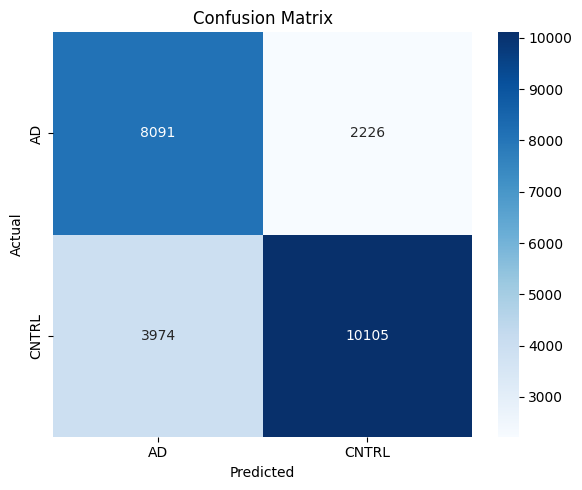

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(all_trues, all_preds, target_names=le.classes_))

cm = confusion_matrix(all_trues, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Subject-Level Accuracy: 0.9375 (15/16)


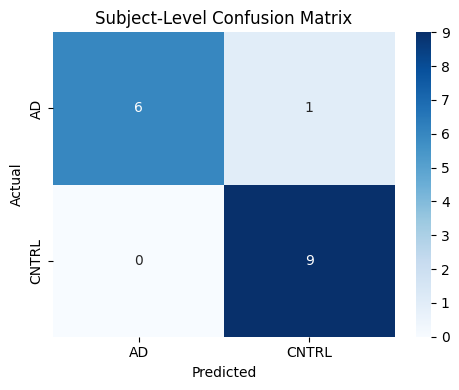

Subject-level classification report:
              precision    recall  f1-score   support

          AD       1.00      0.86      0.92         7
       CNTRL       0.90      1.00      0.95         9

    accuracy                           0.94        16
   macro avg       0.95      0.93      0.94        16
weighted avg       0.94      0.94      0.94        16

        Subject | True Label | Pred Label |   #AD |  #CNTRL
------------------------------------------------------------
    Subject_081 |      CNTRL |      CNTRL |   275 |    1283
    Subject_084 |      CNTRL |      CNTRL |   616 |    1018
    Subject_087 |      CNTRL |      CNTRL |   254 |    1133
    Subject_094 |      CNTRL |      CNTRL |   744 |     814
    Subject_101 |      CNTRL |      CNTRL |   480 |    1059
    Subject_105 |      CNTRL |      CNTRL |   654 |    1322
    Subject_106 |      CNTRL |      CNTRL |   475 |    1007
    Subject_108 |      CNTRL |      CNTRL |   337 |    1164
    Subject_111 |      CNTRL |     

In [ ]:
# After majority voting:
subject_level_true = []
subject_level_pred = []

for subj, votes in subject_votes.items():
    final_pred = Counter(votes).most_common(1)[0][0]
    subject_level_pred.append(final_pred)
    subject_level_true.append(subject_true[subj])

# Print subject-level accuracy
acc = np.mean(np.array(subject_level_pred) == np.array(subject_level_true))
print(f"Subject-Level Accuracy: {acc:.4f} ({sum(np.array(subject_level_pred) == np.array(subject_level_true))}/{len(subject_level_true)})")

# Subject-level confusion matrix
cm_subject = confusion_matrix(subject_level_true, subject_level_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm_subject, annot=True, fmt="d",
            xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Subject-Level Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Subject-level classification report
print("Subject-level classification report:")
print(classification_report(subject_level_true, subject_level_pred, target_names=le.classes_))



idx_to_label = dict(enumerate(le.classes_))
subject_names = list(subject_votes.keys())

print(f"{'Subject':>15} | {'True Label':>10} | {'Pred Label':>10} | {'#AD':>5} | {'#CNTRL':>7}")
print('-'*60)
for subj, true_idx, pred_idx in zip(subject_names, subject_level_true, subject_level_pred):
    img_preds = subject_votes[subj]
    # Count predictions for each class
    count_AD = sum(1 for p in img_preds if idx_to_label[p] == "AD")
    count_CNTRL = sum(1 for p in img_preds if idx_to_label[p] == "CNTRL")
    true_label = idx_to_label[true_idx]
    pred_label = idx_to_label[pred_idx]
    print(f"{subj:>15} | {true_label:>10} | {pred_label:>10} | {count_AD:5d} | {count_CNTRL:7d}")


#### No need external libraries

Collected saliency maps -> AD=200, CNTRL=200


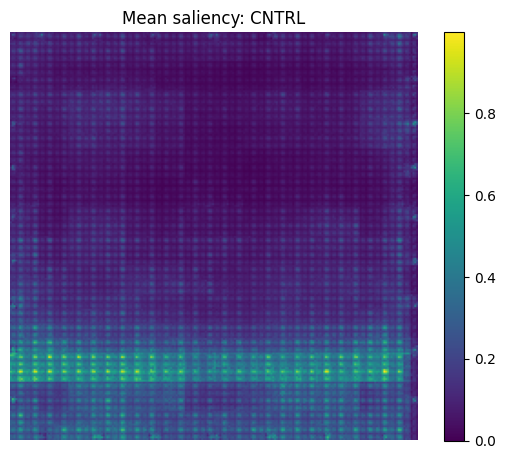

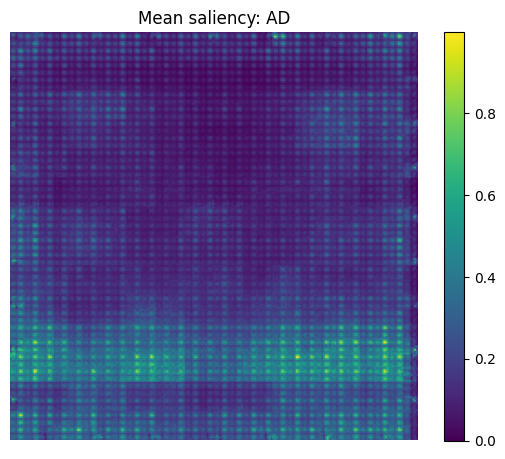

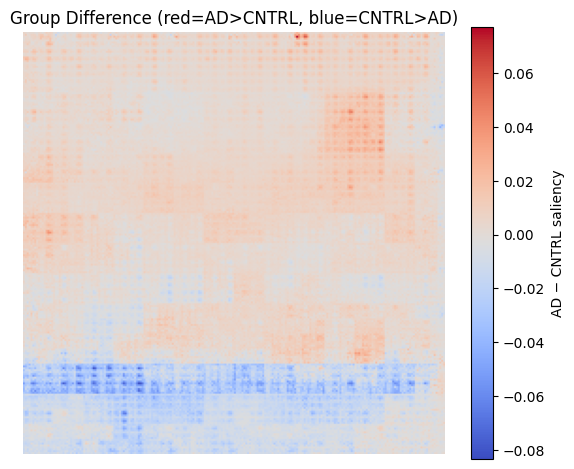

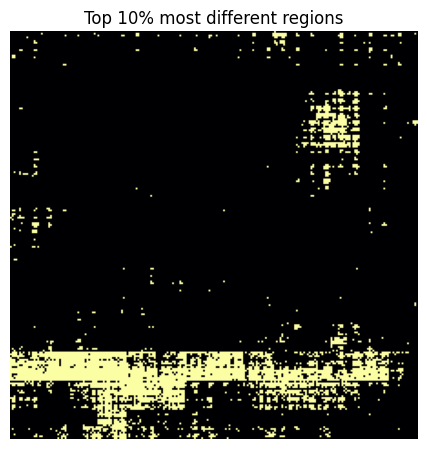

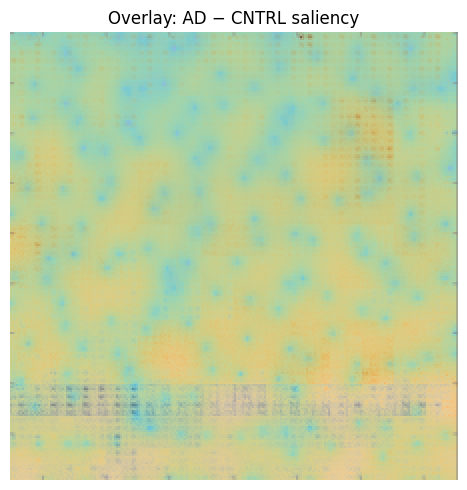

In [ ]:
# ========= FAST XAI (fixed; no nonlocal, no extra installs) =========
import torch, numpy as np, matplotlib.pyplot as plt

model.eval()
device = next(model.parameters()).device

# --- resolve class indices ---
classes = list(le.classes_)
assert "AD" in classes and "CNTRL" in classes, f"LabelEncoder classes must include AD and CNTRL, got: {classes}"
idx_AD, idx_CNTRL = classes.index("AD"), classes.index("CNTRL")

@torch.no_grad()
def get_preds(imgs):
    out = model(imgs.to(device))
    return out.argmax(1).cpu()

def saliency_batch(model, imgs, target_idx):
    imgs = imgs.to(device).float().requires_grad_(True)
    model.zero_grad(set_to_none=True)
    logits = model(imgs)
    scores = logits[torch.arange(imgs.size(0), device=device), target_idx.to(device)]
    scores.sum().backward()
    grads = imgs.grad.detach().abs()              # [B,3,H,W]
    sal = grads.max(dim=1).values                 # [B,H,W]
    # normalize per image to [0,1]
    B,H,W = sal.shape
    sal = sal.view(B,-1)
    mins = sal.min(dim=1, keepdim=True).values
    maxs = sal.max(dim=1, keepdim=True).values
    sal = ((sal - mins) / (maxs - mins + 1e-8)).view(B,H,W).cpu()
    return sal

# -------- aggregate group-wise mean saliency on a subset --------
max_per_group   = 200    # lower (e.g., 50–100) for speed
only_correct    = True   # keep only correctly classified samples
use_true_target = True   # target = true labels (or set False to use predicted)

sum_ad, sum_hc = None, None
n_ad, n_hc = 0, 0

for imgs, labels, _ in test_loader:
    if n_ad >= max_per_group and n_hc >= max_per_group:
        break

    preds = get_preds(imgs)
    keep = (preds == labels) if only_correct else torch.ones_like(labels, dtype=torch.bool)

    # process AD
    if n_ad < max_per_group:
        mask = keep & (labels == idx_AD)
        if mask.any():
            sel = mask.nonzero(as_tuple=False).squeeze(1)[: (max_per_group - n_ad)]
            t_idx = (labels if use_true_target else preds)[sel]
            sal = saliency_batch(model, imgs[sel], t_idx)    # [b,H,W]
            s = sal.sum(dim=0)                               # [H,W]
            sum_ad = s if sum_ad is None else sum_ad + s
            n_ad += sal.shape[0]

    # process CNTRL
    if n_hc < max_per_group:
        mask = keep & (labels == idx_CNTRL)
        if mask.any():
            sel = mask.nonzero(as_tuple=False).squeeze(1)[: (max_per_group - n_hc)]
            t_idx = (labels if use_true_target else preds)[sel]
            sal = saliency_batch(model, imgs[sel], t_idx)
            s = sal.sum(dim=0)
            sum_hc = s if sum_hc is None else sum_hc + s
            n_hc += sal.shape[0]

print(f"Collected saliency maps -> AD={n_ad}, CNTRL={n_hc}")
assert sum_ad is not None and sum_hc is not None, "Not enough samples collected."

mean_ad  = (sum_ad / max(n_ad,1)).numpy()
mean_hc  = (sum_hc / max(n_hc,1)).numpy()
diff_map = mean_ad - mean_hc  # >0 : more AD-salient; <0 : more CNTRL-salient

# -------- visualize --------
def show_map(m, title, cmap="viridis"):
    mm = (m - m.min()) / (m.max() - m.min() + 1e-8)
    plt.figure(figsize=(5.4,4.6)); plt.imshow(mm, cmap=cmap)
    plt.title(title); plt.axis("off"); plt.colorbar(); plt.tight_layout(); plt.show()

show_map(mean_hc, "Mean saliency: CNTRL")
show_map(mean_ad, "Mean saliency: AD")

plt.figure(figsize=(5.8,4.8))
plt.imshow(diff_map, cmap="coolwarm")
plt.colorbar(label="AD − CNTRL saliency")
plt.title("Group Difference (red=AD>CNTRL, blue=CNTRL>AD)")
plt.axis("off"); plt.tight_layout(); plt.show()

# Top-k% most different regions (mask)
k = 0.10
thr = np.quantile(np.abs(diff_map).ravel(), 1 - k)
mask = (np.abs(diff_map) >= thr).astype(float)
plt.figure(figsize=(5.4,4.6)); plt.imshow(mask, cmap="inferno")
plt.title(f"Top {int(k*100)}% most different regions"); plt.axis("off"); plt.tight_layout(); plt.show()

# Optional overlay on a sample CWT image
sample_imgs, _, _ = next(iter(test_loader))
bg = (sample_imgs[0]*0.5 + 0.5).permute(1,2,0).clamp(0,1).cpu().numpy()
d_norm = (diff_map - diff_map.min()) / (diff_map.max() - diff_map.min() + 1e-8)
plt.figure(figsize=(6,5)); plt.imshow(bg); plt.imshow(d_norm, alpha=0.55, cmap="coolwarm")
plt.title("Overlay: AD − CNTRL saliency"); plt.axis("off"); plt.tight_layout(); plt.show()


In [ ]:
# ===================== SAVE XAI MAPS + DOWNLOAD (Colab) =====================
import os, json, csv, zipfile
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

RUN_TAG = "fold4_post_EC"   # <<<< your requested tag
OUT_ROOT = Path("/content/xai_exports")
OUT_DIR  = OUT_ROOT / RUN_TAG
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Helper: save array as PNG (0..1 normalize if needed) and as .npy and .csv
def save_array_all(name, arr, cmap="viridis"):
    base = f"{RUN_TAG}__{name}"
    arr = np.asarray(arr)
    # npy
    np.save(OUT_DIR / f"{base}.npy", arr)
    # csv (2D only)
    if arr.ndim == 2:
        with open(OUT_DIR / f"{base}.csv", "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerows(arr.tolist())
    # png
    a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
    plt.figure(figsize=(6,5))
    plt.imshow(a, cmap=cmap)
    plt.title(base)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"{base}.png", dpi=200, bbox_inches="tight")
    plt.close()

# Save the group maps
save_array_all("mean_cntrl_saliency", mean_hc, cmap="viridis")
save_array_all("mean_ad_saliency",    mean_ad, cmap="viridis")
save_array_all("diff_ad_minus_cntrl", diff_map, cmap="coolwarm")
save_array_all("topk_mask",           mask, cmap="inferno")

# Save an overlay PNG (assumes 'bg' and 'd_norm' already exist)
plt.figure(figsize=(6,5))
plt.imshow(bg)
plt.imshow(d_norm, alpha=0.55, cmap="coolwarm")
plt.title(f"{RUN_TAG}__overlay_ad_minus_cntrl")
plt.axis("off")
plt.tight_layout()
plt.savefig(OUT_DIR / f"{RUN_TAG}__overlay_ad_minus_cntrl.png", dpi=200, bbox_inches="tight")
plt.close()

# Save a small JSON with run meta
meta = {
    "run_tag": RUN_TAG,
    "n_used_AD": int(n_ad),
    "n_used_CNTRL": int(n_hc),
    "k_top_percent": float(k),
    "abs_threshold": float(thr),
    "classes": classes,
}
with open(OUT_DIR / f"{RUN_TAG}__metadata.json", "w") as f:
    json.dump(meta, f, indent=2)

# -------- OPTIONAL: SAVE PER-IMAGE SALIENCY MAPS (can be heavy!) ----------
SAVE_PER_IMAGE = False     # set True if you want every selected image saved
PER_IMG_LIMIT  = 200       # safety limit (per group)

if SAVE_PER_IMAGE:
    PER_DIR = OUT_DIR / "per_image_saliency"
    PER_DIR.mkdir(parents=True, exist_ok=True)

    saved_ad = 0
    saved_hc = 0
    for imgs, labels, paths in test_loader:
        if saved_ad >= PER_IMG_LIMIT and saved_hc >= PER_IMG_LIMIT:
            break
        preds = get_preds(imgs)
        keep = (preds == labels) if only_correct else torch.ones_like(labels, dtype=torch.bool)

        # AD group
        if saved_ad < PER_IMG_LIMIT:
            mask_ad = keep & (labels == idx_AD)
            if mask_ad.any():
                sel = mask_ad.nonzero(as_tuple=False).squeeze(1)
                sel = sel[: max(0, PER_IMG_LIMIT - saved_ad)]
                t_idx = (labels if use_true_target else preds)[sel]
                sal = saliency_batch(model, imgs[sel], t_idx)    # [b,H,W]
                for i, si in enumerate(sal):
                    subj_dir = Path(paths[sel[i]]).parent.name
                    base = Path(paths[sel[i]]).stem
                    arr = si.numpy()
                    np.save(PER_DIR / f"{RUN_TAG}__{subj_dir}__{base}__AD.npy", arr)
                    a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
                    plt.figure(figsize=(5,4))
                    plt.imshow(a, cmap="viridis")
                    plt.title(f"{RUN_TAG} :: {subj_dir} :: {base} :: AD")
                    plt.axis("off"); plt.tight_layout()
                    plt.savefig(PER_DIR / f"{RUN_TAG}__{subj_dir}__{base}__AD.png", dpi=160, bbox_inches="tight")
                    plt.close()
                saved_ad += sal.shape[0]

        # CNTRL group
        if saved_hc < PER_IMG_LIMIT:
            mask_hc = keep & (labels == idx_CNTRL)
            if mask_hc.any():
                sel = mask_hc.nonzero(as_tuple=False).squeeze(1)
                sel = sel[: max(0, PER_IMG_LIMIT - saved_hc)]
                t_idx = (labels if use_true_target else preds)[sel]
                sal = saliency_batch(model, imgs[sel], t_idx)
                for i, si in enumerate(sal):
                    subj_dir = Path(paths[sel[i]]).parent.name
                    base = Path(paths[sel[i]]).stem
                    arr = si.numpy()
                    np.save(PER_DIR / f"{RUN_TAG}__{subj_dir}__{base}__CNTRL.npy", arr)
                    a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
                    plt.figure(figsize=(5,4))
                    plt.imshow(a, cmap="viridis")
                    plt.title(f"{RUN_TAG} :: {subj_dir} :: {base} :: CNTRL")
                    plt.axis("off"); plt.tight_layout()
                    plt.savefig(PER_DIR / f"{RUN_TAG}__{subj_dir}__{base}__CNTRL.png", dpi=160, bbox_inches="tight")
                    plt.close()
                saved_hc += sal.shape[0]

# -------- ZIP + DOWNLOAD (Colab) ----------
ZIP_PATH = f"/content/xai_exports_{RUN_TAG}.zip"
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for p in OUT_ROOT.rglob("*"):
        zf.write(p, arcname=p.relative_to(OUT_ROOT.parent))

print(f"Saved XAI exports to: {OUT_DIR}")
print(f"Zipped at: {ZIP_PATH}")

try:
    from google.colab import files
    files.download(ZIP_PATH)
except Exception as e:
    print("Colab download not available in this environment:", e)
    print("You can also copy the folder to Drive, e.g.:")
    print("!mkdir -p '/content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports' && cp -r /content/xai_exports '/content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports'")
# =====================================================================


Saved XAI exports to: /content/xai_exports/fold4_post_EC
Zipped at: /content/xai_exports_fold4_post_EC.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# import torch, numpy as np, matplotlib.pyplot as plt
# import torch.nn.functional as F

# def make_patch_masks(H, W, patch=32, stride=32, device="cpu"):
#     ys = list(range(0, H - patch + 1, stride))
#     xs = list(range(0, W - patch + 1, stride))
#     masks = []
#     for y in ys:
#         for x in xs:
#             m = torch.zeros(1, 1, H, W, device=device)
#             m[:, :, y:y+patch, x:x+patch] = 1.0
#             masks.append(m)
#     return torch.cat(masks, dim=0), len(ys), len(xs)  # [K,1,H,W], Gy, Gx

# def occlusion_saliency_batch(model, imgs, target_idx, patch=32, stride=32, fill_val=0.0, chunk_masks=8):
#     """
#     Returns coarse heatmaps [B,H,W] using patch occlusion. No grads, just forward passes.
#     """
#     device = imgs.device
#     B, C, H, W = imgs.shape
#     masks, Gy, Gx = make_patch_masks(H, W, patch=patch, stride=stride, device=device)  # [K,1,H,W]
#     K = masks.shape[0]

#     with torch.no_grad():
#         base = model(imgs)  # [B,C]
#         base_t = base[torch.arange(B), target_idx]  # [B]
#     heat = torch.zeros(B, H, W, device=device)

#     # Process masks in chunks to control memory
#     for i in range(0, K, chunk_masks):
#         m = masks[i:i+chunk_masks]                     # [m,1,H,W]
#         # Broadcast to [B,m,3,H,W]
#         x_occ = imgs.unsqueeze(1) * (1 - m) + fill_val * m
#         x_occ = x_occ.view(-1, C, H, W)               # [B*m,3,H,W]
#         with torch.no_grad():
#             logits = model(x_occ)                     # [B*m,C]
#             logits = logits.view(B, -1, base.shape[1])# [B,m,C]
#             scores = logits[..., target_idx.view(B,1)]# [B,m,1]
#             scores = scores.squeeze(-1)               # [B,m]
#         drop = (base_t.unsqueeze(1) - scores).clamp_min(0.0)  # [B,m]

#         # Paint the drop back onto the corresponding patch areas
#         # (uniformly add the drop value over that patch)
#         for jj in range(m.shape[0]):
#             yx = (i + jj)
#             y_idx = (yx // Gx) * stride
#             x_idx = (yx %  Gx) * stride
#             heat[:, y_idx:y_idx+patch, x_idx:x_idx+patch] += drop[:, jj].unsqueeze(-1).unsqueeze(-1)

#     # Normalize per image
#     B = heat.size(0)
#     heat = heat.view(B, -1)
#     heat = (heat - heat.min(dim=1, keepdim=True).values) / (heat.max(dim=1, keepdim=True).values - heat.min(dim=1, keepdim=True).values + 1e-8)
#     heat = heat.view(B, H, W)
#     return heat

# # Aggregate per group (same pattern as above)
# max_per_group = 80          # keep small; occlusion is heavier than saliency
# only_correct  = True
# use_true_target = True
# patch, stride = 32, 32
# chunk_masks   = 8

# sum_ad = None; n_ad = 0
# sum_hc = None; n_hc = 0

# for imgs, labels, _ in test_loader:
#     if n_ad >= max_per_group and n_hc >= max_per_group:
#         break
#     preds = get_preds(imgs)
#     keep = (preds == labels) if only_correct else torch.ones_like(labels, dtype=torch.bool)
#     for group_idx, is_ad in [(idx_AD, True), (idx_CNTRL, False)]:
#         m = keep & (labels == group_idx)
#         if m.sum() == 0:
#             continue
#         budget = (max_per_group - (n_ad if is_ad else n_hc))
#         if budget <= 0:
#             continue
#         sel = m.nonzero(as_tuple=False).squeeze(1)[:budget]
#         t_idx = (labels if use_true_target else preds)[sel]
#         heat = occlusion_saliency_batch(model, imgs[sel].to(device), t_idx.to(device),
#                                         patch=patch, stride=stride, chunk_masks=chunk_masks)  # [b,H,W]
#         s = heat.sum(dim=0)
#         if is_ad:
#             sum_ad = s if sum_ad is None else sum_ad + s
#             n_ad  += heat.shape[0]
#         else:
#             sum_hc = s if sum_hc is None else sum_hc + s
#             n_hc  += heat.shape[0]

# print(f"[Occlusion] Collected: AD={n_ad}, CNTRL={n_hc}")
# mean_ad_occ = (sum_ad / max(n_ad,1)).cpu().numpy()
# mean_hc_occ = (sum_hc / max(n_hc,1)).cpu().numpy()
# diff_occ    = mean_ad_occ - mean_hc_occ

# plt.figure(figsize=(5.6,4.8))
# plt.imshow(diff_occ, cmap="coolwarm")
# plt.colorbar(label="AD − CNTRL (occlusion)")
# plt.title("Group Difference via Patch-Occlusion")
# plt.axis("off"); plt.tight_layout(); plt.show()


In [ ]:
# ===================== SAVE TO GOOGLE DRIVE (+ RAR) =====================
import shutil, subprocess
from pathlib import Path

# Mount Drive (safe to call even if already mounted)
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

DRIVE_BASE = Path('/content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports')
DRIVE_BASE.mkdir(parents=True, exist_ok=True)

# 1) Copy the run folder to Drive
DRIVE_RUN_DIR = DRIVE_BASE / RUN_TAG
if DRIVE_RUN_DIR.exists():
    shutil.rmtree(DRIVE_RUN_DIR)
shutil.copytree(OUT_DIR, DRIVE_RUN_DIR)

# 2) Copy the ZIP to Drive
DRIVE_ZIP = DRIVE_BASE / f"xai_exports_{RUN_TAG}.zip"
shutil.copy2(ZIP_PATH, DRIVE_ZIP)

print(f"Copied to Drive folder: {DRIVE_RUN_DIR}")
print(f"Copied ZIP to Drive:    {DRIVE_ZIP}")

# 3) OPTIONAL: Create a RAR archive directly in Drive
#    This installs 'rar' (non-free) in the Colab VM, then writes a .rar into Drive.
try:
    print("Attempting to create RAR in Drive...")
    subprocess.run(["apt-get", "update", "-y"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    subprocess.run(["apt-get", "install", "-y", "rar"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)

    DRIVE_RAR = DRIVE_BASE / f"xai_exports_{RUN_TAG}.rar"
    # 'rar a -r <archive> <folder_to_add>'  (-r = recurse)
    # Use the *parent* of OUT_DIR so it stores the folder name inside the archive neatly
    subprocess.run(["rar", "a", "-r", str(DRIVE_RAR), str(OUT_DIR)], check=True)

    print(f"RAR saved to Drive:     {DRIVE_RAR}")
except Exception as e:
    print("Could not create .rar (keeping .zip). Error:", e)
# ======================================================================


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copied to Drive folder: /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports/fold4_post_EC
Copied ZIP to Drive:    /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports/xai_exports_fold4_post_EC.zip
Attempting to create RAR in Drive...
RAR saved to Drive:     /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports/xai_exports_fold4_post_EC.rar


#### New XAI (IG + SmoothGrad IG)

In [ ]:
# # ========================= XAI (IG + SmoothGrad IG) =========================
# import os, json, csv, zipfile, math, subprocess, shutil
# from pathlib import Path
# from collections import defaultdict, Counter

# import numpy as np
# import torch
# import torch.nn.functional as F
# import matplotlib.pyplot as plt

# # ------------------------ CONFIG ------------------------
# RUN_TAG          = "fold4_post_EC_IG_SGIG"  # customize per run
# OUT_ROOT         = Path("/content/xai_exports")
# OUT_DIR          = OUT_ROOT / RUN_TAG
# OUT_DIR.mkdir(parents=True, exist_ok=True)

# # Saliency collection
# MAX_PER_GROUP_IG    = 200   # how many correctly-classified images per group for IG
# MAX_PER_GROUP_SGIG  = 200   # for SmoothGradIG
# USE_TRUE_TARGET     = True  # True -> IG wrt true label; False -> wrt predicted class

# # Integrated Gradients settings
# IG_STEPS         = 32       # Riemann steps along the path
# BASELINE_KIND    = "zero"   # "zero" or "black" (zero is fine; inputs are normalized)

# # SmoothGrad IG settings
# SG_N_SAMPLES     = 25
# SG_NOISE_SIGMA   = 0.10     # noise std in input space (on normalized scale)

# # Significance testing (optional)
# DO_STAT_TEST     = False           # flip to True to compute pixel-wise tests (heavier)
# SIG_MAX_PER_GRP  = 120             # cap #images per group for stats to save memory
# ALPHA_FDR        = 0.05            # FDR level

# # Frequency axis (low frequency at bottom row)
# FREQ_MIN = 0.5   # Hz
# FREQ_MAX = 45.0  # Hz

# # Bands (name, low, high) in Hz
# BAND_EDGES = [
#     ("delta", 0.5, 4.0),
#     ("theta", 4.0, 8.0),
#     ("alpha", 8.0, 13.0),
#     ("beta", 13.0, 30.0),
#     ("gamma", 30.0, 45.0),
# ]

# # --------------------- helpers: saving -------------------
# def save_array_all(name, arr, cmap="viridis"):
#     """Save arr as .npy, .csv (if 2D), and .png."""
#     base = f"{RUN_TAG}__{name}"
#     arr = np.asarray(arr)
#     # npy
#     np.save(OUT_DIR / f"{base}.npy", arr)
#     # csv (2D only)
#     if arr.ndim == 2:
#         with open(OUT_DIR / f"{base}.csv", "w", newline="") as f:
#             writer = csv.writer(f)
#             writer.writerows(arr.tolist())
#     # png (0..1 normalize for viewing)
#     a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8) if arr.size else arr
#     plt.figure(figsize=(6,5))
#     plt.imshow(a, cmap=cmap)
#     plt.title(base)
#     plt.axis("off")
#     plt.tight_layout()
#     plt.savefig(OUT_DIR / f"{base}.png", dpi=200, bbox_inches="tight")
#     plt.close()

# def save_overlay(bg_img_hwc01, heat_2d, name, cmap="coolwarm", alpha=0.55):
#     """bg_img_hwc01 in [0,1], heat_2d any real values."""
#     base = f"{RUN_TAG}__{name}"
#     h = (heat_2d - heat_2d.min()) / (heat_2d.max() - heat_2d.min() + 1e-8)
#     plt.figure(figsize=(6,5))
#     plt.imshow(bg_img_hwc01)
#     plt.imshow(h, alpha=alpha, cmap=cmap)
#     plt.title(base)
#     plt.axis("off")
#     plt.tight_layout()
#     plt.savefig(OUT_DIR / f"{base}.png", dpi=200, bbox_inches="tight")
#     plt.close()

# # ------------------ helpers: IG & SmoothGrad IG ------------------
# def _make_baseline_like(img):
#     # img: [3,H,W]
#     if BASELINE_KIND == "zero":
#         return torch.zeros_like(img)
#     elif BASELINE_KIND == "black":
#         return torch.zeros_like(img)  # same for normalized inputs
#     else:
#         return torch.zeros_like(img)

# @torch.no_grad()
# def get_preds(imgs, model):
#     out = model(imgs.to(device))
#     return out.argmax(1).cpu()

# def integrated_gradients(model, imgs, target_idx, steps=32):
#     """
#     Robust IG: works for [B,3,H,W] or [3,H,W], returns [B,H,W] (abs-mean over channels).
#     Force-enables autograd for the forward/backward.
#     """
#     model.eval()
#     device_local = next(model.parameters()).device

#     # ---- enforce shapes on inputs/targets ----
#     if imgs.dim() == 3:   # [3,H,W] -> [1,3,H,W]
#         imgs = imgs.unsqueeze(0)
#     imgs = imgs.to(device_local)

#     if isinstance(target_idx, (int,)):
#         target_idx = torch.tensor([target_idx], device=device_local, dtype=torch.long)
#     else:
#         target_idx = target_idx.to(device_local)
#         if target_idx.dim() == 0:
#             target_idx = target_idx.unsqueeze(0)

#     B, C, H, W = imgs.shape
#     alphas = torch.linspace(0., 1., steps + 1, device=device_local)  # [steps+1]
#     sal_out = torch.zeros(B, H, W, device=device_local)

#     # IG per sample for stability
#     for i in range(B):
#         x = imgs[i:i+1].clone()                     # [1,3,H,W]
#         y_idx = int(target_idx[i].item())
#         baseline = torch.zeros_like(x)              # [1,3,H,W]

#         # Path: [steps+1, 1, 3, H, W]
#         path = baseline + alphas.view(-1, 1, 1, 1) * (x - baseline)

#         grads_sum = torch.zeros_like(x)
#         # ensure autograd is enabled for these iterations
#         for t in range(path.shape[0]):
#             xt = path[t]
#             if xt.dim() == 3:
#                 xt = xt.unsqueeze(0)
#             xt = xt.clone().detach().requires_grad_(True)

#             # ---- enable grad just for this forward/backward ----
#             with torch.enable_grad():
#                 logits = model(xt)                  # [1,num_classes], must carry grad_fn
#                 score = logits[:, y_idx].sum()      # scalar
#                 model.zero_grad(set_to_none=True)
#                 score.backward()

#             grads_sum = grads_sum + xt.grad.detach()

#         grads_mean = grads_sum / float(steps + 1)
#         ig = (x - baseline) * grads_mean            # [1,3,H,W]
#         ig = ig.abs().mean(dim=1).squeeze(0)        # [H,W]
#         sal_out[i] = ig

#     return sal_out  # [B,H,W]


# def smoothgrad_ig(model, imgs, target_idx, steps=32, n_samples=25, noise_sigma=0.10):
#     """
#     SmoothGrad over IG; returns [B,H,W]. Force-enables autograd internally.
#     """
#     model.eval()
#     device_local = next(model.parameters()).device

#     if imgs.dim() == 3:
#         imgs = imgs.unsqueeze(0)
#     imgs = imgs.to(device_local)

#     if isinstance(target_idx, (int,)):
#         target_idx = torch.tensor([target_idx], device=device_local, dtype=torch.long)
#     else:
#         target_idx = target_idx.to(device_local)
#         if target_idx.dim() == 0:
#             target_idx = target_idx.unsqueeze(0)

#     B, C, H, W = imgs.shape
#     out = torch.zeros(B, H, W, device=device_local)

#     for _ in range(n_samples):
#         noise = torch.randn_like(imgs) * noise_sigma
#         noisy = (imgs + noise).clamp(-1.0, 1.0)
#         # IG itself uses enable_grad(), so we can call it directly
#         out += integrated_gradients(model, noisy, target_idx, steps=steps)

#     out /= float(n_samples)
#     return out

# # ---------------------- helpers: aggregation ----------------------
# def aggregate_group_mean(sal_batch, sum_group, n_group):
#     """sal_batch: [b,H,W] to add; returns updated (sum,n)."""
#     if sal_batch is None or sal_batch.numel() == 0:
#         return sum_group, n_group
#     s = sal_batch.sum(dim=0)  # [H,W]
#     sum_group = s if sum_group is None else (sum_group + s)
#     n_group += sal_batch.shape[0]
#     return sum_group, n_group

# def to_numpy_norm(x):
#     x = x.detach().float().cpu().numpy()
#     return x

# def topk_mask_from_abs(arr2d, frac=0.10):
#     """Return binary mask of top-|arr| pixels covering 'frac' of total pixels."""
#     a = np.abs(arr2d)
#     flat = a.ravel()
#     k = max(1, int(round(frac * flat.size)))
#     thr = np.partition(flat, -k)[-k]  # k-th largest
#     return (a >= thr).astype(np.float32), float(thr)

# # ---------------------- helpers: band coverage --------------------
# def percent_band_coverage(mask, band_edges, freq_min=FREQ_MIN, freq_max=FREQ_MAX):
#     """
#     mask: [H,W] binary (1=selected), low frequency at bottom (y=H-1 -> freq_min).
#     returns dict band_name -> percent of mask pixels in that band.
#     """
#     H, W = mask.shape
#     total = mask.sum()
#     if total == 0:
#         return {name: 0.0 for (name,_,_) in band_edges}
#     yy = np.arange(H)  # 0..H-1 top->bottom
#     # y=0 -> freq_max, y=H-1 -> freq_min
#     freq = freq_min + (1.0 - yy / max(H-1,1)) * (freq_max - freq_min)
#     out = {}
#     for (name, f_lo, f_hi) in band_edges:
#         rows = (freq >= f_lo) & (freq < f_hi)
#         band_total = mask[rows, :].sum()
#         out[name] = 100.0 * float(band_total) / float(total)
#     return out

# # ------------------------ collect saliencies ----------------------
# model.eval()
# classes = list(le.classes_)
# assert "AD" in classes and "CNTRL" in classes
# idx_AD, idx_CNTRL = classes.index("AD"), classes.index("CNTRL")

# sum_ad_ig = None; sum_hc_ig = None; n_ad_ig = 0; n_hc_ig = 0
# sum_ad_sg = None; sum_hc_sg = None; n_ad_sg = 0; n_hc_sg = 0

# # For overlay (background)
# try:
#     sample_imgs, sample_labels, sample_paths = next(iter(test_loader))
#     bg = (sample_imgs[0]*0.5 + 0.5).permute(1,2,0).clamp(0,1).cpu().numpy()
# except StopIteration:
#     bg = None

# with torch.no_grad():
#     for imgs, labels, paths in test_loader:
#         preds = get_preds(imgs, model)
#         keep = (preds == labels)  # only_correct=True

#         # ---- IG for AD ----
#         if n_ad_ig < MAX_PER_GROUP_IG:
#             m_ad = keep & (labels == idx_AD)
#             if m_ad.any():
#                 sel = m_ad.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_IG - n_ad_ig)]
#                 tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                 ig_batch = integrated_gradients(model, imgs[sel], tgt, steps=IG_STEPS) # [b,H,W]
#                 sum_ad_ig, n_ad_ig = aggregate_group_mean(ig_batch, sum_ad_ig, n_ad_ig)

#         # ---- IG for CNTRL ----
#         if n_hc_ig < MAX_PER_GROUP_IG:
#             m_hc = keep & (labels == idx_CNTRL)
#             if m_hc.any():
#                 sel = m_hc.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_IG - n_hc_ig)]
#                 tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                 ig_batch = integrated_gradients(model, imgs[sel], tgt, steps=IG_STEPS)
#                 sum_hc_ig, n_hc_ig = aggregate_group_mean(ig_batch, sum_hc_ig, n_hc_ig)

#         # ---- SG-IG for AD ----
#         if n_ad_sg < MAX_PER_GROUP_SGIG:
#             m_ad = keep & (labels == idx_AD)
#             if m_ad.any():
#                 sel = m_ad.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_SGIG - n_ad_sg)]
#                 tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                 sg_batch = smoothgrad_ig(model, imgs[sel], tgt, steps=IG_STEPS,
#                                          n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA)
#                 sum_ad_sg, n_ad_sg = aggregate_group_mean(sg_batch, sum_ad_sg, n_ad_sg)

#         # ---- SG-IG for CNTRL ----
#         if n_hc_sg < MAX_PER_GROUP_SGIG:
#             m_hc = keep & (labels == idx_CNTRL)
#             if m_hc.any():
#                 sel = m_hc.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_SGIG - n_hc_sg)]
#                 tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                 sg_batch = smoothgrad_ig(model, imgs[sel], tgt, steps=IG_STEPS,
#                                          n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA)
#                 sum_hc_sg, n_hc_sg = aggregate_group_mean(sg_batch, sum_hc_sg, n_hc_sg)

# print(f"[IG]    Collected: AD={n_ad_ig}, CNTRL={n_hc_ig}")
# print(f"[SG-IG] Collected: AD={n_ad_sg}, CNTRL={n_hc_sg}")
# assert n_ad_ig>0 and n_hc_ig>0 and n_ad_sg>0 and n_hc_sg>0, "Not enough samples collected."

# # ---------------------- group means & diffs ----------------------
# mean_ad_ig = to_numpy_norm(sum_ad_ig / max(n_ad_ig,1))
# mean_hc_ig = to_numpy_norm(sum_hc_ig / max(n_hc_ig,1))
# diff_ig    = mean_ad_ig - mean_hc_ig

# mean_ad_sg = to_numpy_norm(sum_ad_sg / max(n_ad_sg,1))
# mean_hc_sg = to_numpy_norm(sum_hc_sg / max(n_hc_sg,1))
# diff_sg    = mean_ad_sg - mean_hc_sg

# # ---------------------- top-k masks & band coverage --------------
# for frac in [0.10, 0.20]:
#     name = f"top{int(frac*100)}"
#     # IG
#     mask_ig, thr_ig = topk_mask_from_abs(diff_ig, frac=frac)
#     cov_ig = percent_band_coverage(mask_ig, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
#     save_array_all(f"{name}_mask_IG", mask_ig, cmap="inferno")
#     # SG-IG
#     mask_sg, thr_sg = topk_mask_from_abs(diff_sg, frac=frac)
#     cov_sg = percent_band_coverage(mask_sg, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
#     save_array_all(f"{name}_mask_SGIG", mask_sg, cmap="inferno")

#     # save band coverage as JSON
#     with open(OUT_DIR / f"{RUN_TAG}__{name}_band_coverage.json", "w") as f:
#         json.dump({
#             "fraction": frac,
#             "thresholds": {"IG": float(thr_ig), "SGIG": float(thr_sg)},
#             "coverage_percent": {"IG": cov_ig, "SGIG": cov_sg},
#             "bands_hz": BAND_EDGES,
#             "freq_min_max": [FREQ_MIN, FREQ_MAX]
#         }, f, indent=2)

# # ------------------------- save maps & overlays -------------------
# save_array_all("mean_ad_IG",   mean_ad_ig, cmap="viridis")
# save_array_all("mean_cntrl_IG",mean_hc_ig, cmap="viridis")
# save_array_all("diff_ADminusCNTRL_IG", diff_ig, cmap="coolwarm")

# save_array_all("mean_ad_SGIG",   mean_ad_sg, cmap="viridis")
# save_array_all("mean_cntrl_SGIG",mean_hc_sg, cmap="viridis")
# save_array_all("diff_ADminusCNTRL_SGIG", diff_sg, cmap="coolwarm")

# if bg is not None:
#     save_overlay(bg, diff_ig, "overlay_diff_IG")
#     save_overlay(bg, diff_sg, "overlay_diff_SGIG")

# # ------------------- OPTIONAL: significance test -----------------
# if DO_STAT_TEST:
#     print("Running pixel-wise Welch's t-test with BH-FDR...")
#     # Re-collect per-image saliency (capped) for both methods and groups
#     def collect_sal_per_image(method="IG", max_per_grp=SIG_MAX_PER_GRP):
#         ad_list, hc_list = [], []
#         with torch.no_grad():
#             for imgs, labels, paths in test_loader:
#                 preds = get_preds(imgs, model)
#                 keep  = (preds == labels)

#                 # AD
#                 if len(ad_list) < max_per_grp:
#                     m = keep & (labels == idx_AD)
#                     if m.any():
#                         sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, max_per_grp - len(ad_list))]
#                         tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                         if method == "IG":
#                             sal = integrated_gradients(model, imgs[sel], tgt, steps=IG_STEPS)
#                         else:
#                             sal = smoothgrad_ig(model, imgs[sel], tgt, steps=IG_STEPS,
#                                                 n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA)
#                         ad_list.append(sal.cpu().numpy())  # [b,H,W]

#                 # CNTRL
#                 if len(hc_list) < max_per_grp:
#                     m = keep & (labels == idx_CNTRL)
#                     if m.any():
#                         sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, max_per_grp - len(hc_list))]
#                         tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                         if method == "IG":
#                             sal = integrated_gradients(model, imgs[sel], tgt, steps=IG_STEPS)
#                         else:
#                             sal = smoothgrad_ig(model, imgs[sel], tgt, steps=IG_STEPS,
#                                                 n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA)
#                         hc_list.append(sal.cpu().numpy())

#                 if len(ad_list) >= max_per_grp and len(hc_list) >= max_per_grp:
#                     break

#         if len(ad_list)==0 or len(hc_list)==0:
#             return None, None
#         ad_arr = np.concatenate(ad_list, axis=0)  # [N_ad,H,W]
#         hc_arr = np.concatenate(hc_list, axis=0)  # [N_hc,H,W]
#         return ad_arr, hc_arr

#     def welch_ttest_map(ad_arr, hc_arr):
#         """
#         ad_arr, hc_arr: [N,H,W]; returns tmap [H,W], pmap [H,W]
#         """
#         Na, H, W = ad_arr.shape
#         Nh, _, _ = hc_arr.shape
#         mu_a = ad_arr.mean(axis=0)
#         mu_h = hc_arr.mean(axis=0)
#         var_a = ad_arr.var(axis=0, ddof=1)
#         var_h = hc_arr.var(axis=0, ddof=1)
#         # Welch t
#         num = mu_a - mu_h
#         den = np.sqrt(var_a/Na + var_h/Nh) + 1e-12
#         tmap = num / den

#         # Welch-Satterthwaite df
#         df = (var_a/Na + var_h/Nh)**2 / ((var_a**2)/(Na**2*(Na-1)+1e-12) + (var_h**2)/(Nh**2*(Nh-1)+1e-12) + 1e-12)

#         # two-sided p-values from t (approx via survival function of Student's t).
#         # To avoid extra deps, use Gaussian as a close approx when df is large:
#         # p ≈ 2*(1 - Φ(|t|))
#         from math import erf, sqrt
#         def norm_sf(x):  # 1 - CDF
#             return 0.5 * (1 - erf(x/np.sqrt(2)))
#         pmap = 2.0 * norm_sf(np.abs(tmap))
#         return tmap, pmap

#     def bh_fdr(pvals, alpha=0.05):
#         """Benjamini–Hochberg on flattened pvals; returns boolean reject mask (same shape)."""
#         shape = pvals.shape
#         p = pvals.ravel()
#         m = p.size
#         order = np.argsort(p)
#         ranked = p[order]
#         thresh = alpha * (np.arange(1, m+1) / m)
#         passed = ranked <= thresh
#         if not np.any(passed):
#             return np.zeros_like(pvals, dtype=bool)
#         kmax = np.max(np.where(passed)[0])
#         cutoff = ranked[kmax]
#         return (pvals <= cutoff).reshape(shape)

#     for method_name, mean_ad, mean_hc, diff_map in [
#         ("IG",   mean_ad_ig, mean_hc_ig, diff_ig),
#         ("SGIG", mean_ad_sg, mean_hc_sg, diff_sg),
#     ]:
#         data_ad, data_hc = collect_sal_per_image(method=method_name, max_per_grp=SIG_MAX_PER_GRP)
#         if data_ad is None or data_hc is None:
#             print(f"[{method_name}] Not enough data for stats; skipping.")
#             continue
#         tmap, pmap = welch_ttest_map(data_ad, data_hc)
#         sig_mask = bh_fdr(pmap, alpha=ALPHA_FDR).astype(np.float32)
#         save_array_all(f"sigmask_{method_name}_FDR{int(ALPHA_FDR*100)}", sig_mask, cmap="gray")
#         # band coverage on significance mask
#         cov_sig = percent_band_coverage(sig_mask, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
#         with open(OUT_DIR / f"{RUN_TAG}__sigmask_{method_name}_band_coverage.json", "w") as f:
#             json.dump({"coverage_percent": cov_sig,
#                        "alpha_FDR": ALPHA_FDR,
#                        "bands_hz": BAND_EDGES,
#                        "freq_min_max": [FREQ_MIN, FREQ_MAX]}, f, indent=2)

# # ---------------------- write small metadata ---------------------
# meta = {
#     "run_tag": RUN_TAG,
#     "ig": {"n_ad": int(n_ad_ig), "n_cntrl": int(n_hc_ig), "steps": IG_STEPS, "baseline": BASELINE_KIND},
#     "sgig": {"n_ad": int(n_ad_sg), "n_cntrl": int(n_hc_sg),
#              "steps": IG_STEPS, "n_samples": SG_N_SAMPLES, "noise_sigma": SG_NOISE_SIGMA},
#     "bands_hz": BAND_EDGES,
#     "freq_min_max": [FREQ_MIN, FREQ_MAX],
#     "top_masks": ["10%","20%"],
#     "significance_test": {"enabled": bool(DO_STAT_TEST), "alpha_FDR": ALPHA_FDR}
# }
# with open(OUT_DIR / f"{RUN_TAG}__metadata.json", "w") as f:
#     json.dump(meta, f, indent=2)

# # ------------------------- ZIP + (optional) download --------------
# ZIP_PATH = f"/content/xai_exports_{RUN_TAG}.zip"
# with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as zf:
#     for p in OUT_ROOT.rglob("*"):
#         zf.write(p, arcname=p.relative_to(OUT_ROOT.parent))

# print(f"Saved XAI exports to: {OUT_DIR}")
# print(f"Zipped at: {ZIP_PATH}")

# try:
#     from google.colab import files
#     files.download(ZIP_PATH)
# except Exception as e:
#     print("Colab files.download not available here:", e)

# # ------------------------ SAVE TO GOOGLE DRIVE (+ RAR) -------------
# from google.colab import drive as _drive
# _drive.mount('/content/drive', force_remount=False)

# DRIVE_BASE = Path('/content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports')
# DRIVE_BASE.mkdir(parents=True, exist_ok=True)

# # 1) Copy the run folder to Drive
# DRIVE_RUN_DIR = DRIVE_BASE / RUN_TAG
# if DRIVE_RUN_DIR.exists():
#     shutil.rmtree(DRIVE_RUN_DIR)
# shutil.copytree(OUT_DIR, DRIVE_RUN_DIR)

# # 2) Copy the ZIP to Drive
# DRIVE_ZIP = DRIVE_BASE / f"xai_exports_{RUN_TAG}.zip"
# shutil.copy2(ZIP_PATH, DRIVE_ZIP)

# print(f"Copied to Drive folder: {DRIVE_RUN_DIR}")
# print(f"Copied ZIP to Drive:    {DRIVE_ZIP}")

# # 3) OPTIONAL: Create a RAR archive directly in Drive
# try:
#     print("Attempting to create RAR in Drive...")
#     subprocess.run(["apt-get", "update", "-y"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
#     subprocess.run(["apt-get", "install", "-y", "rar"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
#     DRIVE_RAR = DRIVE_BASE / f"xai_exports_{RUN_TAG}.rar"
#     subprocess.run(["rar", "a", "-r", str(DRIVE_RAR), str(OUT_DIR)], check=True)
#     print(f"RAR saved to Drive:     {DRIVE_RAR}")
# except Exception as e:
#     print("Could not create .rar (keeping .zip). Error:", e)
# # ===================================================================


In [ ]:
# ========================= FAST XAI (IG + SmoothGrad IG) =========================

# ---- NEW knobs (safe defaults) ----
B_MICRO_IG   = 4    # images per IG micro-batch (raise to 2/4 if VRAM allows)
B_MICRO_SG   = 4    # images per SG-IG micro-batch
ALPHA_CHUNK  = 8    # alpha steps per chunk (you had 8 before)
PATH_MICRO   = 16   # forward this many path samples at once (limits peak memory)

#====================================================================================================
import os, json, csv, zipfile, math, subprocess, shutil
from pathlib import Path
from collections import defaultdict, Counter

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ------------------------ SPEED PRESET ------------------------
# Choose: "fast" (recommended for iteration) or "accurate" (heavier)
SPEED_PRESET = "fast"

if SPEED_PRESET == "fast":
    MAX_PER_GROUP_IG   = 80     # was 200
    MAX_PER_GROUP_SGIG = 80     # was 200
    IG_STEPS           = 16     # was 32
    SG_N_SAMPLES       = 8      # was 25
    SG_NOISE_SIGMA     = 0.10
    ALPHA_CHUNK        = 8      # vectorize α steps in chunks
elif SPEED_PRESET == "accurate":
    MAX_PER_GROUP_IG   = 200
    MAX_PER_GROUP_SGIG = 200
    IG_STEPS           = 32
    SG_N_SAMPLES       = 25
    SG_NOISE_SIGMA     = 0.10
    ALPHA_CHUNK        = 8
else:
    raise ValueError("SPEED_PRESET must be 'fast' or 'accurate'.")

RUN_TAG          = f"fold4_post_EC_IG_SGIG_{SPEED_PRESET}"
OUT_ROOT         = Path("/content/xai_exports")
OUT_DIR          = OUT_ROOT / RUN_TAG
OUT_DIR.mkdir(parents=True, exist_ok=True)

USE_TRUE_TARGET  = True      # IG wrt true label (or predicted if False)
BASELINE_KIND    = "zero"    # ("zero" is fine for normalized inputs)

# (optional) significance testing
DO_STAT_TEST     = True
SIG_MAX_PER_GRP  = 80
ALPHA_FDR        = 0.05

# Frequency axis (low freq at bottom)
FREQ_MIN = 0.5
FREQ_MAX = 45.0
BAND_EDGES = [
    ("delta", 0.5, 4.0),
    ("theta", 4.0, 8.0),
    ("alpha", 8.0, 13.0),
    ("beta", 13.0, 30.0),
    ("gamma", 30.0, 45.0),
]

# cuDNN speed-up
torch.backends.cudnn.benchmark = True

# --------------------- helpers: saving -------------------
def save_array_all(name, arr, cmap="viridis"):
    base = f"{RUN_TAG}__{name}"
    arr = np.asarray(arr)
    np.save(OUT_DIR / f"{base}.npy", arr)
    if arr.ndim == 2:
        with open(OUT_DIR / f"{base}.csv", "w", newline="") as f:
            writer = csv.writer(f); writer.writerows(arr.tolist())
    a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8) if arr.size else arr
    plt.figure(figsize=(6,5)); plt.imshow(a, cmap=cmap); plt.title(base)
    plt.axis("off"); plt.tight_layout()
    plt.savefig(OUT_DIR / f"{base}.png", dpi=200, bbox_inches="tight"); plt.close()

def save_overlay(bg_img_hwc01, heat_2d, name, cmap="coolwarm", alpha=0.55):
    base = f"{RUN_TAG}__{name}"
    h = (heat_2d - heat_2d.min()) / (heat_2d.max() - heat_2d.min() + 1e-8)
    plt.figure(figsize=(6,5)); plt.imshow(bg_img_hwc01)
    plt.imshow(h, alpha=alpha, cmap=cmap); plt.title(base)
    plt.axis("off"); plt.tight_layout()
    plt.savefig(OUT_DIR / f"{base}.png", dpi=200, bbox_inches="tight"); plt.close()

# ------------------ helpers: IG & SmoothGrad IG ------------------
def _make_baseline_like(img):
    return torch.zeros_like(img)

@torch.no_grad()
def get_preds(imgs, model):
    out = model(imgs.to(device))
    return out.argmax(1).cpu()

def integrated_gradients_fast(model, imgs, target_idx, steps=32,
                              alpha_chunk=ALPHA_CHUNK, b_micro=B_MICRO_IG,
                              path_micro=PATH_MICRO):
    """
    Memory-safe vectorized IG:
      - Splits over images (b_micro),
      - Splits over alpha steps (alpha_chunk),
      - And splits the concatenated path batch further (path_micro).
    Returns saliency [B,H,W] (abs-mean over channels).
    """
    model.eval()
    device_local = next(model.parameters()).device

    if imgs.dim() == 3:
        imgs = imgs.unsqueeze(0)
    imgs = imgs.to(device_local)                     # [B,3,H,W]
    B, C, H, W = imgs.shape

    # normalize / broadcast targets
    if isinstance(target_idx, (int,)):
        target_idx = torch.tensor([target_idx]*B, device=device_local, dtype=torch.long)
    else:
        target_idx = target_idx.to(device_local)
        if target_idx.dim() == 0: target_idx = target_idx.unsqueeze(0)
        if target_idx.numel() != B:
            if target_idx.numel() == 1:
                target_idx = target_idx.repeat(B)
            else:
                target_idx = target_idx.view(-1)[:B]

    baseline = torch.zeros_like(imgs)
    alphas = torch.linspace(0., 1., steps + 1, device=device_local)   # [S]
    out = torch.zeros(B, H, W, device=device_local)

    # loop over images in micro-batches
    for b0 in range(0, B, b_micro):
        b1 = min(B, b0 + b_micro)
        x_mb  = imgs[b0:b1]             # [b,3,H,W]
        base  = baseline[b0:b1]         # [b,3,H,W]
        t_mb  = target_idx[b0:b1]       # [b]
        b = x_mb.shape[0]

        grads_sum = torch.zeros_like(x_mb)
        # split alpha steps into chunks
        for a0 in range(0, alphas.numel(), alpha_chunk):
            a1 = min(alphas.numel(), a0 + alpha_chunk)
            a = alphas[a0:a1]                               # [m]
            # build full path batch for this alpha-chunk: [m,b,3,H,W] -> [m*b,3,H,W]
            path_full = base.unsqueeze(0) + a.view(-1,1,1,1,1) * (x_mb - base).unsqueeze(0)
            path_full = path_full.reshape(-1, C, H, W)      # [m*b,3,H,W]

            # process path in smaller chunks to bound memory
            # accumulate gradients across the chunk
            pos = 0
            grad_accum = torch.zeros_like(path_full)
            while pos < path_full.shape[0]:
                pos_end = min(path_full.shape[0], pos + path_micro)
                path_chunk = path_full[pos:pos_end].clone().detach().requires_grad_(True)

                with torch.enable_grad():
                    logits = model(path_chunk)              # [k, num_classes]
                    # map chunk indices back to which original image target to use
                    # path_full is ordered as alpha-major, then image index inside
                    # We need corresponding target labels for this slice:
                    # determine which (alpha_index, image_index) each row belongs to
                    alpha_idx = torch.arange(pos, pos_end, device=device_local) // b
                    img_idx   = torch.arange(pos, pos_end, device=device_local) %  b
                    tgt_chunk = t_mb[img_idx]
                    scores = logits[torch.arange(path_chunk.size(0), device=device_local), tgt_chunk]
                    total = scores.sum()
                    model.zero_grad(set_to_none=True)
                    total.backward()

                grad_accum[pos:pos_end] = path_chunk.grad.detach()
                del path_chunk, logits, scores
                torch.cuda.empty_cache()
                pos = pos_end

            # reduce grad_accum back to [m,b,3,H,W], sum over m
            grads = grad_accum.reshape(a.shape[0], b, C, H, W).sum(dim=0)  # [b,3,H,W]
            grads_sum = grads_sum + grads

            del path_full, grad_accum, grads
            torch.cuda.empty_cache()

        grads_mean = grads_sum / float(steps + 1)           # [b,3,H,W]
        ig_mb = (x_mb - base) * grads_mean                  # [b,3,H,W]
        ig_mb = ig_mb.abs().mean(dim=1)                     # [b,H,W]
        out[b0:b1] = ig_mb

        del x_mb, base, t_mb, grads_sum, ig_mb
        torch.cuda.empty_cache()

    return out


def smoothgrad_ig_fast(model, imgs, target_idx, steps=32,
                       n_samples=8, noise_sigma=0.10, alpha_chunk=ALPHA_CHUNK,
                       b_micro=B_MICRO_SG, path_micro=PATH_MICRO):
    """
    Memory-safe SmoothGrad over IG:
      - adds noise per sample and reuses the memory-safe IG above
      - splits over images too
    Returns [B,H,W].
    """
    model.eval()
    device_local = next(model.parameters()).device
    if imgs.dim() == 3:
        imgs = imgs.unsqueeze(0)
    imgs = imgs.to(device_local)
    B, C, H, W = imgs.shape

    # normalize / broadcast targets
    if isinstance(target_idx, (int,)):
        target_idx = torch.tensor([target_idx]*B, device=device_local, dtype=torch.long)
    else:
        target_idx = target_idx.to(device_local)
        if target_idx.dim() == 0: target_idx = target_idx.unsqueeze(0)
        if target_idx.numel() != B:
            if target_idx.numel() == 1:
                target_idx = target_idx.repeat(B)
            else:
                target_idx = target_idx.view(-1)[:B]

    out = torch.zeros(B, H, W, device=device_local)

    # do SG in image micro-batches to keep memory bounded
    for b0 in range(0, B, b_micro):
        b1 = min(B, b0 + b_micro)
        x_mb = imgs[b0:b1]
        t_mb = target_idx[b0:b1]
        acc = torch.zeros(x_mb.shape[0], H, W, device=device_local)

        for _ in range(n_samples):
            noise = torch.randn_like(x_mb) * noise_sigma
            noisy = (x_mb + noise).clamp(-1.0, 1.0)
            ig_mb = integrated_gradients_fast(
                model, noisy, t_mb, steps=steps,
                alpha_chunk=alpha_chunk, b_micro=1, path_micro=path_micro
            )
            acc += ig_mb
            del noise, noisy, ig_mb
            torch.cuda.empty_cache()

        out[b0:b1] = acc / float(n_samples)
        del x_mb, t_mb, acc
        torch.cuda.empty_cache()

    return out


# ---------------------- helpers: aggregation ----------------------
def aggregate_group_mean(sal_batch, sum_group, n_group):
    if sal_batch is None or sal_batch.numel() == 0:
        return sum_group, n_group
    s = sal_batch.sum(dim=0)  # [H,W]
    sum_group = s if sum_group is None else (sum_group + s)
    n_group += sal_batch.shape[0]
    return sum_group, n_group

def to_numpy_norm(x):
    return x.detach().float().cpu().numpy()

def topk_mask_from_abs(arr2d, frac=0.10):
    a = np.abs(arr2d); flat = a.ravel()
    k = max(1, int(round(frac * flat.size)))
    thr = np.partition(flat, -k)[-k]
    return (a >= thr).astype(np.float32), float(thr)

# ---------------------- helpers: band coverage --------------------
def percent_band_coverage(mask, band_edges, freq_min=FREQ_MIN, freq_max=FREQ_MAX):
    H, W = mask.shape
    total = mask.sum()
    if total == 0:
        return {name: 0.0 for (name,_,_) in band_edges}
    yy = np.arange(H)  # 0..H-1 top->bottom
    # y=0 -> freq_max, y=H-1 -> freq_min (low freq at bottom)
    freq = freq_min + (1.0 - yy / max(H-1,1)) * (freq_max - freq_min)
    out = {}
    for (name, f_lo, f_hi) in band_edges:
        rows = (freq >= f_lo) & (freq < f_hi)
        out[name] = 100.0 * float(mask[rows, :].sum()) / float(total)
    return out

# ------------------------ collect saliencies ----------------------
model.eval()
device   = next(model.parameters()).device
classes  = list(le.classes_)
assert "AD" in classes and "CNTRL" in classes
idx_AD, idx_CNTRL = classes.index("AD"), classes.index("CNTRL")

sum_ad_ig = None; sum_hc_ig = None; n_ad_ig = 0; n_hc_ig = 0
sum_ad_sg = None; sum_hc_sg = None; n_ad_sg = 0; n_hc_sg = 0

# Overlay background
try:
    sample_imgs, _, _ = next(iter(test_loader))
    bg = (sample_imgs[0]*0.5 + 0.5).permute(1,2,0).clamp(0,1).cpu().numpy()
except StopIteration:
    bg = None

# Pass 1: gather IG and SG-IG (correctly classified only)
with torch.no_grad():
    for imgs, labels, paths in test_loader:
        preds = get_preds(imgs, model)
        keep  = (preds == labels)

        # ---- IG: AD ----
        if n_ad_ig < MAX_PER_GROUP_IG:
            m = keep & (labels == idx_AD)
            if m.any():
                sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_IG - n_ad_ig)]
                tgt = (labels if USE_TRUE_TARGET else preds)[sel]
                ig_b = integrated_gradients_fast(model, imgs[sel], tgt, steps=IG_STEPS, alpha_chunk=ALPHA_CHUNK)
                sum_ad_ig, n_ad_ig = aggregate_group_mean(ig_b, sum_ad_ig, n_ad_ig)

        # ---- IG: CNTRL ----
        if n_hc_ig < MAX_PER_GROUP_IG:
            m = keep & (labels == idx_CNTRL)
            if m.any():
                sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_IG - n_hc_ig)]
                tgt = (labels if USE_TRUE_TARGET else preds)[sel]
                ig_b = integrated_gradients_fast(model, imgs[sel], tgt, steps=IG_STEPS, alpha_chunk=ALPHA_CHUNK)
                sum_hc_ig, n_hc_ig = aggregate_group_mean(ig_b, sum_hc_ig, n_hc_ig)

        # ---- SG-IG: AD ----
        if n_ad_sg < MAX_PER_GROUP_SGIG:
            m = keep & (labels == idx_AD)
            if m.any():
                sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_SGIG - n_ad_sg)]
                tgt = (labels if USE_TRUE_TARGET else preds)[sel]
                sg_b = smoothgrad_ig_fast(model, imgs[sel], tgt, steps=IG_STEPS,
                                          n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA,
                                          alpha_chunk=ALPHA_CHUNK)
                sum_ad_sg, n_ad_sg = aggregate_group_mean(sg_b, sum_ad_sg, n_ad_sg)

        # ---- SG-IG: CNTRL ----
        if n_hc_sg < MAX_PER_GROUP_SGIG:
            m = keep & (labels == idx_CNTRL)
            if m.any():
                sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_SGIG - n_hc_sg)]
                tgt = (labels if USE_TRUE_TARGET else preds)[sel]
                sg_b = smoothgrad_ig_fast(model, imgs[sel], tgt, steps=IG_STEPS,
                                          n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA,
                                          alpha_chunk=ALPHA_CHUNK)
                sum_hc_sg, n_hc_sg = aggregate_group_mean(sg_b, sum_hc_sg, n_hc_sg)

print(f"[IG]    Collected: AD={n_ad_ig}, CNTRL={n_hc_ig}")
print(f"[SG-IG] Collected: AD={n_ad_sg}, CNTRL={n_hc_sg}")
assert n_ad_ig>0 and n_hc_ig>0 and n_ad_sg>0 and n_hc_sg>0, "Not enough samples collected."

# ---------------------- group means & diffs ----------------------
mean_ad_ig = to_numpy_norm(sum_ad_ig / max(n_ad_ig,1))
mean_hc_ig = to_numpy_norm(sum_hc_ig / max(n_hc_ig,1))
diff_ig    = mean_ad_ig - mean_hc_ig

mean_ad_sg = to_numpy_norm(sum_ad_sg / max(n_ad_sg,1))
mean_hc_sg = to_numpy_norm(sum_hc_sg / max(n_hc_sg,1))
diff_sg    = mean_ad_sg - mean_hc_sg

# ---------------------- top-k masks & band coverage --------------
for frac in [0.10, 0.20]:
    name = f"top{int(frac*100)}"
    # IG
    mask_ig, thr_ig = topk_mask_from_abs(diff_ig, frac=frac)
    cov_ig = percent_band_coverage(mask_ig, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
    save_array_all(f"{name}_mask_IG", mask_ig, cmap="inferno")
    # SG-IG
    mask_sg, thr_sg = topk_mask_from_abs(diff_sg, frac=frac)
    cov_sg = percent_band_coverage(mask_sg, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
    save_array_all(f"{name}_mask_SGIG", mask_sg, cmap="inferno")
    # coverage JSON
    with open(OUT_DIR / f"{RUN_TAG}__{name}_band_coverage.json", "w") as f:
        json.dump({
            "fraction": frac,
            "thresholds": {"IG": float(thr_ig), "SGIG": float(thr_sg)},
            "coverage_percent": {"IG": cov_ig, "SGIG": cov_sg},
            "bands_hz": BAND_EDGES,
            "freq_min_max": [FREQ_MIN, FREQ_MAX]
        }, f, indent=2)

# ------------------------- save maps & overlays -------------------
save_array_all("mean_ad_IG",   mean_ad_ig, cmap="viridis")
save_array_all("mean_cntrl_IG",mean_hc_ig, cmap="viridis")
save_array_all("diff_ADminusCNTRL_IG", diff_ig, cmap="coolwarm")

save_array_all("mean_ad_SGIG",   mean_ad_sg, cmap="viridis")
save_array_all("mean_cntrl_SGIG",mean_hc_sg, cmap="viridis")
save_array_all("diff_ADminusCNTRL_SGIG", diff_sg, cmap="coolwarm")

if bg is not None:
    save_overlay(bg, diff_ig, "overlay_diff_IG")
    save_overlay(bg, diff_sg, "overlay_diff_SGIG")







[IG]    Collected: AD=80, CNTRL=80
[SG-IG] Collected: AD=80, CNTRL=80


In [ ]:
# =================== STATISTICAL TEST (FAST, SINGLE-PASS) ===================
# This cell reuses cached per-pixel sums/sumsq gathered during saliency collection.
# It does NOT recompute IG / SG-IG, so it is much faster.

import numpy as np, json

# ---- safety defaults / knobs (you can tweak) ----
DO_STAT_TEST        = globals().get('DO_STAT_TEST', True)   # only run if True
ALPHA_FDR           = globals().get('ALPHA_FDR', 0.05)

STAT_DOWNSAMPLE     = 2       # 1=no downsample; try 2 or 4 for speed (must match the hook)
FDR_ONLY_IN_TOPK    = True    # test only in union of top-k regions (reduces multiple-testing)
TOPK_FRACS_FOR_FDR  = [0.10, 0.20]  # union of these (at full-res)

if DO_STAT_TEST:
    print("Running fast pixel-wise Welch t-test from cached sums (no extra IG/SG-IG passes).")

    # ---------------- helpers ----------------
    def _welch_from_sums(sum_a, sumsq_a, n_a, sum_h, sumsq_h, n_h):
        """
        Input: per-pixel sum / sumsq (AD and CNTRL) and counts (n_a, n_h), arrays [H,W]
        Output: (tmap, pmap) with Gaussian tail approx for p-values (vectorized).
        """
        # Means
        mu_a  = sum_a / max(n_a, 1)
        mu_h  = sum_h / max(n_h, 1)
        # Unbiased variances from sum & sumsq
        var_a = (sumsq_a - (sum_a**2)/max(n_a,1)) / max(n_a-1, 1)
        var_h = (sumsq_h - (sum_h**2)/max(n_h,1)) / max(n_h-1, 1)

        num = (mu_a - mu_h)
        den = np.sqrt(var_a/max(n_a,1) + var_h/max(n_h,1)) + 1e-12
        tmap = num / den

        # Vectorized erf approximation (Hastings) for speed/stability
        def _erf_approx(x):
            x = np.asarray(x, dtype=np.float64)
            s = np.sign(x)
            x2 = x * x
            a = 0.147
            inner = -x2 * (4.0/np.pi + a * x2) / (1.0 + a * x2)
            return s * np.sqrt(1.0 - np.exp(inner))

        def _normal_sf(z):   # 1 - Phi(z)
            return 0.5 * (1.0 - _erf_approx(z / np.sqrt(2.0)))

        pmap = 2.0 * _normal_sf(np.abs(tmap))  # two-sided
        return tmap, pmap

    def bh_fdr(pvals, alpha=0.05):
        shape = pvals.shape
        p = pvals.ravel()
        m = p.size
        order = np.argsort(p)
        ranked = p[order]
        thresh = alpha * (np.arange(1, m+1) / m)
        passed = ranked <= thresh
        if not np.any(passed):
            return np.zeros_like(pvals, dtype=bool)
        kmax = np.max(np.where(passed)[0])
        cutoff = ranked[kmax]
        return (pvals <= cutoff).reshape(shape)

    # ---- Optional: build focus mask (full-resolution) from union of top-k masks
    union_mask_full = None
    if FDR_ONLY_IN_TOPK:
        union_mask_full = np.zeros_like(diff_ig, dtype=bool)
        for frac in TOPK_FRACS_FOR_FDR:
            mk_ig, _ = topk_mask_from_abs(diff_ig, frac)
            mk_sg, _ = topk_mask_from_abs(diff_sg, frac)
            union_mask_full |= (mk_ig.astype(bool) | mk_sg.astype(bool))

    # ---------------- IG stats (if cached) ----------------
    ig_cached = ('stat_ad_ig_sum' in globals() and stat_ad_ig_sum is not None and
                 'stat_hc_ig_sum' in globals() and stat_hc_ig_sum is not None)

    if ig_cached:
        sum_a = stat_ad_ig_sum.detach().cpu().numpy()
        ss_a  = stat_ad_ig_sumsq.detach().cpu().numpy()
        sum_h = stat_hc_ig_sum.detach().cpu().numpy()
        ss_h  = stat_hc_ig_sumsq.detach().cpu().numpy()
        n_a   = int(n_ad_ig_stat)
        n_h   = int(n_hc_ig_stat)

        tmap_ig, pmap_ig = _welch_from_sums(sum_a, ss_a, n_a, sum_h, ss_h, n_h)

        # Apply FDR; if we downsampled stats, we cannot pixel-align top-k union -> apply globally
        if union_mask_full is not None and STAT_DOWNSAMPLE == 1:
            p_tmp = pmap_ig.copy()
            p_tmp[~union_mask_full] = 1.0
            sig_ig = bh_fdr(p_tmp, alpha=ALPHA_FDR).astype(np.float32)
        else:
            sig_ig = bh_fdr(pmap_ig, alpha=ALPHA_FDR).astype(np.float32)

        save_array_all("tmap_IG_stat", tmap_ig, cmap="coolwarm")
        save_array_all("pmap_IG_stat", pmap_ig, cmap="magma")
        save_array_all(f"sigmask_IG_FDR{int(ALPHA_FDR*100)}", sig_ig, cmap="gray")

        cov_sig_ig = percent_band_coverage(sig_ig, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
        with open(OUT_DIR / f"{RUN_TAG}__sigmask_IG_band_coverage.json", "w") as f:
            json.dump({"coverage_percent": cov_sig_ig,
                       "alpha_FDR": ALPHA_FDR,
                       "bands_hz": BAND_EDGES,
                       "freq_min_max": [FREQ_MIN, FREQ_MAX]}, f, indent=2)
        print(f"[IG] stats: n_AD={n_a}, n_CNTRL={n_h}, downsample={STAT_DOWNSAMPLE}")
    else:
        print("[IG] cached stats not found. Ensure the saliency loop ran with DO_STAT_TEST=True and the hook added.")

    # ---------------- SG-IG stats (if cached) ----------------
    sg_cached = ('stat_ad_sg_sum' in globals() and stat_ad_sg_sum is not None and
                 'stat_hc_sg_sum' in globals() and stat_hc_sg_sum is not None)

    if sg_cached:
        sum_a = stat_ad_sg_sum.detach().cpu().numpy()
        ss_a  = stat_ad_sg_sumsq.detach().cpu().numpy()
        sum_h = stat_hc_sg_sum.detach().cpu().numpy()
        ss_h  = stat_hc_sg_sumsq.detach().cpu().numpy()
        n_a   = int(n_ad_sg_stat)
        n_h   = int(n_hc_sg_stat)

        tmap_sg, pmap_sg = _welch_from_sums(sum_a, ss_a, n_a, sum_h, ss_h, n_h)

        if union_mask_full is not None and STAT_DOWNSAMPLE == 1:
            p_tmp = pmap_sg.copy()
            p_tmp[~union_mask_full] = 1.0
            sig_sg = bh_fdr(p_tmp, alpha=ALPHA_FDR).astype(np.float32)
        else:
            sig_sg = bh_fdr(pmap_sg, alpha=ALPHA_FDR).astype(np.float32)

        save_array_all("tmap_SGIG_stat", tmap_sg, cmap="coolwarm")
        save_array_all("pmap_SGIG_stat", pmap_sg, cmap="magma")
        save_array_all(f"sigmask_SGIG_FDR{int(ALPHA_FDR*100)}", sig_sg, cmap="gray")

        cov_sig_sg = percent_band_coverage(sig_sg, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
        with open(OUT_DIR / f"{RUN_TAG}__sigmask_SGIG_band_coverage.json", "w") as f:
            json.dump({"coverage_percent": cov_sig_sg,
                       "alpha_FDR": ALPHA_FDR,
                       "bands_hz": BAND_EDGES,
                       "freq_min_max": [FREQ_MIN, FREQ_MAX]}, f, indent=2)
        print(f"[SG-IG] stats: n_AD={n_a}, n_CNTRL={n_h}, downsample={STAT_DOWNSAMPLE}")
    else:
        print("[SG-IG] cached stats not found. Ensure the saliency loop ran with DO_STAT_TEST=True and the hook added.")
# ===========================================================================



Running fast pixel-wise Welch t-test from cached sums (no extra IG/SG-IG passes).
[IG] cached stats not found. Ensure the saliency loop ran with DO_STAT_TEST=True and the hook added.
[SG-IG] cached stats not found. Ensure the saliency loop ran with DO_STAT_TEST=True and the hook added.


In [ ]:
# ============================ SAVE ALL (Model + XAI + Stats) ============================
import os, json, zipfile, shutil, subprocess, sys
from pathlib import Path

# --- Required globals assumed to exist: RUN_TAG, OUT_ROOT, OUT_DIR, model ---
# If you used my earlier cells, these are already defined. Otherwise set them here:
if 'RUN_TAG' not in globals():
    RUN_TAG = "xai_run"
if 'OUT_ROOT' not in globals():
    OUT_ROOT = Path("/content/xai_exports")
if 'OUT_DIR' not in globals():
    OUT_DIR = OUT_ROOT / RUN_TAG
OUT_ROOT = Path(OUT_ROOT)
OUT_DIR  = Path(OUT_DIR)
OUT_ROOT.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"[SaveAll] Using OUT_DIR = {OUT_DIR}")

# ---------------------- 1) SAVE TRAINED MODEL INTO OUT_DIR ----------------------
import torch

CKPT_DIR = OUT_DIR / "checkpoints"
CKPT_DIR.mkdir(parents=True, exist_ok=True)

# 1a) Copy your best checkpoint file if it exists in the cwd
BEST_PTH = Path("best_swin_model.pth")
if BEST_PTH.exists():
    shutil.copy2(BEST_PTH, CKPT_DIR / "best_swin_model.pth")
    print(f"[SaveAll] Copied best checkpoint -> {CKPT_DIR / 'best_swin_model.pth'}")
else:
    print("[SaveAll][warn] best_swin_model.pth not found in current directory.")

# 1b) Save a full training bundle (state_dict + metadata)
bundle = {
    "run_tag": RUN_TAG,
    "model_name": "swin_tiny_patch4_window7_224",
    "num_classes": 2,
    "state_dict": (model.state_dict() if 'model' in globals() else None),
    "optimizer": (optimizer.state_dict() if 'optimizer' in globals() else None),
    "scheduler": (scheduler.state_dict() if 'scheduler' in globals() else None),
    "label_classes": (list(le.classes_) if 'le' in globals() else None),
    "transform_note": {
        "resize": [224, 224],
        "normalize_mean": [0.5, 0.5, 0.5],
        "normalize_std":  [0.5, 0.5, 0.5]
    }
}
torch.save(bundle, CKPT_DIR / "training_bundle.pt")
print(f"[SaveAll] Saved training bundle -> {CKPT_DIR / 'training_bundle.pt'}")

# 1c) (Optional) Export TorchScript for portable inference
EXPORT_TORCHSCRIPT = False
if EXPORT_TORCHSCRIPT and 'model' in globals():
    try:
        device = next(model.parameters()).device
        model.eval()
        example = torch.randn(1, 3, 224, 224, device=device)
        scripted = torch.jit.trace(model, example)
        scripted.save(str(CKPT_DIR / "model_scripted.pt"))
        print(f"[SaveAll] TorchScript saved -> {CKPT_DIR / 'model_scripted.pt'}")
    except Exception as e:
        print("[SaveAll][warn] TorchScript export failed:", e)




# ============================== WRITE README.md ==============================
import json, os, glob, textwrap
import numpy as np
from pathlib import Path
from datetime import datetime

def _load_json(p):
    try:
        with open(p, "r") as f:
            return json.load(f)
    except Exception:
        return None

def _maybe_load_npy(name):
    p = OUT_DIR / f"{RUN_TAG}__{name}.npy"
    if p.exists():
        try:
            return np.load(p)
        except Exception:
            return None
    return None

def _percent_sig(sigmask):
    if sigmask is None:
        return None
    total = sigmask.size
    k = (sigmask > 0).sum()
    return float(100.0 * k / max(total, 1))

def _band_table_markdown(coverage_dict):
    """
    coverage_dict: {"IG": {"delta":..,"theta":..,..}, "SGIG": {...}}
    Returns a small markdown table string. Missing keys handled gracefully.
    """
    bands = ["delta","theta","alpha","beta","gamma"]
    lines = ["| Band | IG (%) | SGIG (%) |", "|:----:|------:|--------:|"]
    for b in bands:
        ig = coverage_dict.get("IG", {}).get(b, 0.0)
        sg = coverage_dict.get("SGIG", {}).get(b, 0.0)
        lines.append(f"| {b} | {ig:.2f} | {sg:.2f} |")
    return "\n".join(lines)

# ---- try to collect top-10 and top-20 coverage (from saved JSONs) ----
cov = {}
thr = {}
for frac_name in ["top10", "top20"]:
    j = _load_json(OUT_DIR / f"{RUN_TAG}__{frac_name}_band_coverage.json")
    if j is not None:
        cov[frac_name] = j.get("coverage_percent", {})
        thr[frac_name] = j.get("thresholds", {})
    else:
        cov[frac_name] = {}
        thr[frac_name] = {}

# ---- stats (if produced) ----
stats = {}
for method in ["IG","SGIG"]:
    sig_json = _load_json(OUT_DIR / f"{RUN_TAG}__sigmask_{method}_band_coverage.json")
    sig_npy  = _maybe_load_npy(f"sigmask_{method}_FDR{int(ALPHA_FDR*100)}")
    stats[method] = {
        "band_coverage": (sig_json or {}).get("coverage_percent", None),
        "sig_percent_pixels": _percent_sig(sig_npy)
    }

# ---- quick existence checks for key visual outputs ----
key_pngs = [
    f"{RUN_TAG}__mean_ad_IG.png",
    f"{RUN_TAG}__mean_cntrl_IG.png",
    f"{RUN_TAG}__diff_ADminusCNTRL_IG.png",
    f"{RUN_TAG}__mean_ad_SGIG.png",
    f"{RUN_TAG}__mean_cntrl_SGIG.png",
    f"{RUN_TAG}__diff_ADminusCNTRL_SGIG.png",
    f"{RUN_TAG}__top10_mask_IG.png",
    f"{RUN_TAG}__top20_mask_IG.png",
    f"{RUN_TAG}__top10_mask_SGIG.png",
    f"{RUN_TAG}__top20_mask_SGIG.png",
    f"{RUN_TAG}__overlay_diff_IG.png",
    f"{RUN_TAG}__overlay_diff_SGIG.png",
]
present_pngs = [p for p in key_pngs if (OUT_DIR / p).exists()]

# ---- optional model artifact info (if you saved it) ----
MODEL_LOCAL = locals().get("TRAINED_MODEL_LOCAL", None)
MODEL_DRIVE = locals().get("DRIVE_MODEL_PATH", None)

# ---- build README text ----
lines = []
lines.append(f"# XAI Summary — `{RUN_TAG}`")
lines.append("")
lines.append(f"- **Created:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
lines.append(f"- **Output folder:** `{OUT_DIR}`")
lines.append(f"- **Preset:** `{locals().get('SPEED_PRESET','?')}`")
lines.append("")
lines.append("## Methods")
lines.append("- **IG**: Integrated Gradients with baseline=`zero` "
             f"and `IG_STEPS={locals().get('IG_STEPS','?')}`.")
lines.append("- **SGIG**: SmoothGrad over IG with "
             f"`SG_N_SAMPLES={locals().get('SG_N_SAMPLES','?')}`, "
             f"`SG_NOISE_SIGMA={locals().get('SG_NOISE_SIGMA','?')}`, "
             f"`IG_STEPS={locals().get('IG_STEPS','?')}`.")
lines.append("")
lines.append("## Data used for XAI (correct predictions only)")
lines.append(f"- IG:    AD={locals().get('n_ad_ig',0)}, CNTRL={locals().get('n_hc_ig',0)}")
lines.append(f"- SG-IG: AD={locals().get('n_ad_sg',0)}, CNTRL={locals().get('n_hc_sg',0)}")
lines.append("")
lines.append("## Frequency axis")
lines.append(f"- Y-axis spans **{locals().get('FREQ_MIN',0.5)}–{locals().get('FREQ_MAX',45.0)} Hz**, low frequency at image bottom.")
lines.append("- Bands: delta (0.5–4), theta (4–8), alpha (8–13), beta (13–30), gamma (30–45).")
lines.append("")

# ---- top masks section ----
for frac_name, frac_label in [("top10","Top 10%"), ("top20","Top 20%")]:
    lines.append(f"## {frac_label} mask (|AD−CNTRL| strongest pixels)")
    if thr.get(frac_name):
        lines.append(f"- Thresholds: IG={thr[frac_name].get('IG','n/a')}, SGIG={thr[frac_name].get('SGIG','n/a')}")
    # band table
    lines.append(_band_table_markdown(cov.get(frac_name, {})))
    lines.append("")

# ---- stats section (if any) ----
if any(v["band_coverage"] is not None or v["sig_percent_pixels"] is not None for v in stats.values()):
    lines.append("## Pixel-wise statistics (Welch’s t, BH-FDR)")
    lines.append(f"- FDR α = {locals().get('ALPHA_FDR', 0.05)}")
    for method in ["IG","SGIG"]:
        s = stats[method]
        if s["sig_percent_pixels"] is None and s["band_coverage"] is None:
            continue
        lines.append(f"### {method}")
        if s["sig_percent_pixels"] is not None:
            lines.append(f"- Significant pixels (FDR): **{s['sig_percent_pixels']:.2f}%**")
        if s["band_coverage"] is not None:
            # convert to mini-table
            bc = {"IG": s["band_coverage"], "SGIG": {}} if method=="IG" else {"IG": {}, "SGIG": s["band_coverage"]}
            lines.append(_band_table_markdown(bc))
        # point to files if present
        tmap_p = OUT_DIR / f"{RUN_TAG}__tmap_{method}.png"
        pmap_p = OUT_DIR / f"{RUN_TAG}__pmap_{method}.png"
        sm_p   = OUT_DIR / f"{RUN_TAG}__sigmask_{method}_FDR{int(ALPHA_FDR*100)}.png"
        if tmap_p.exists() or pmap_p.exists() or sm_p.exists():
            lines.append("- Files:")
            if tmap_p.exists(): lines.append(f"  - `{tmap_p.name}` (t-map)")
            if pmap_p.exists(): lines.append(f"  - `{pmap_p.name}` (p-map)")
            if sm_p.exists():   lines.append(f"  - `{sm_p.name}` (significance mask)")
        lines.append("")
else:
    lines.append("## Pixel-wise statistics")
    lines.append("- *Not run or no significant results saved.*")
    lines.append("")

# ---- key visual outputs present ----
if present_pngs:
    lines.append("## Key visual outputs present")
    for name in present_pngs:
        lines.append(f"- `{name}`")
    lines.append("")

# ---- model artifacts (optional) ----
lines.append("## Model artifact")
if MODEL_LOCAL or MODEL_DRIVE:
    if MODEL_LOCAL:
        lines.append(f"- Local saved: `{MODEL_LOCAL}`")
    if MODEL_DRIVE:
        lines.append(f"- Copied to Drive: `{MODEL_DRIVE}`")
else:
    lines.append("- *(No model path recorded in this session.)*")
lines.append("")

# ---- file inventory (brief) ----
lines.append("## File inventory (top level)")
top_items = sorted([p.name for p in OUT_DIR.glob("*")])
for nm in top_items[:80]:   # cap list length
    lines.append(f"- `{nm}`")
if len(top_items) > 80:
    lines.append(f"- ... (+{len(top_items)-80} more)")

# ---- write README.md ----
README_PATH = OUT_DIR / "README.md"
with open(README_PATH, "w") as f:
    f.write("\n".join(lines))

print(f"README written to: {README_PATH}")
# =============================================================================


# ===================== SAVE CLASSIFICATION RESULTS =====================
import csv, json
from pathlib import Path

# Use your existing OUT_DIR / RUN_TAG if defined; otherwise create a default.
try:
    OUT_DIR, RUN_TAG  # check they exist
except NameError:
    RUN_TAG = "classification_results_only"
    OUT_ROOT = Path("/content/xai_exports")
    OUT_DIR  = OUT_ROOT / RUN_TAG
    OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- Map indices to label strings
idx_to_label = dict(enumerate(le.classes_))

# ---------- 1) IMAGE-LEVEL: tables + report + confusion matrix ----------
# CSV of per-image predictions
img_csv = OUT_DIR / f"{RUN_TAG}__image_level_predictions.csv"
with open(img_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["image_path","subject","true_label","pred_label","correct"])
    for p, t, pr in zip(all_subjects, all_trues, all_preds):
        subj   = Path(p).name if Path(p).suffix else p  # fallback if not a path
        subj   = Path(p).parent.name  # parent is Subject_###
        t_lab  = idx_to_label[int(t)]
        pr_lab = idx_to_label[int(pr)]
        w.writerow([p, subj, t_lab, pr_lab, int(t==pr)])

# JSON/text classification report (image-level)
from sklearn.metrics import classification_report, confusion_matrix
img_report_txt = classification_report(all_trues, all_preds, target_names=le.classes_)
img_report_js  = classification_report(all_trues, all_preds, target_names=le.classes_, output_dict=True)

with open(OUT_DIR / f"{RUN_TAG}__image_level_report.txt","w") as f:
    f.write(img_report_txt)
with open(OUT_DIR / f"{RUN_TAG}__image_level_report.json","w") as f:
    json.dump(img_report_js, f, indent=2)

# Confusion matrix (image-level) -> PNG, CSV, NPY
cm_img = confusion_matrix(all_trues, all_preds)
np.save(OUT_DIR / f"{RUN_TAG}__image_cm.npy", cm_img)
with open(OUT_DIR / f"{RUN_TAG}__image_cm.csv","w", newline="") as f:
    w = csv.writer(f); w.writerow([""] + list(le.classes_))
    for row_lab, row in zip(le.classes_, cm_img):
        w.writerow([row_lab] + list(map(int, row)))

plt.figure(figsize=(6,5))
sns.heatmap(cm_img, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Image-Level Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout()
plt.savefig(OUT_DIR / f"{RUN_TAG}__image_cm.png", dpi=200, bbox_inches="tight")
plt.close()

# ---------- 2) SUBJECT-LEVEL: majority vote tables + report + cm ----------
# Build subject-level rows (what you printed)
subj_rows = []
for subj, true_idx, pred_idx in zip(subject_names, subject_level_true, subject_level_pred):
    img_preds = subject_votes[subj]
    count_AD     = sum(1 for p in img_preds if idx_to_label[int(p)] == "AD")
    count_CNTRL  = sum(1 for p in img_preds if idx_to_label[int(p)] == "CNTRL")
    subj_rows.append({
        "subject": subj,
        "true_label": idx_to_label[int(true_idx)],
        "pred_label": idx_to_label[int(pred_idx)],
        "n_AD_votes": int(count_AD),
        "n_CNTRL_votes": int(count_CNTRL),
        "correct": int(true_idx == pred_idx)
    })

# CSV of subject-level results
subj_csv = OUT_DIR / f"{RUN_TAG}__subject_level_predictions.csv"
with open(subj_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["subject","true_label","pred_label","n_AD_votes","n_CNTRL_votes","correct"])
    for r in subj_rows:
        w.writerow([r["subject"], r["true_label"], r["pred_label"], r["n_AD_votes"], r["n_CNTRL_votes"], r["correct"]])

# Subject-level report + cm
subj_report_txt = classification_report(subject_level_true, subject_level_pred, target_names=le.classes_)
subj_report_js  = classification_report(subject_level_true, subject_level_pred, target_names=le.classes_, output_dict=True)

with open(OUT_DIR / f"{RUN_TAG}__subject_level_report.txt","w") as f:
    f.write(subj_report_txt)
with open(OUT_DIR / f"{RUN_TAG}__subject_level_report.json","w") as f:
    json.dump(subj_report_js, f, indent=2)

cm_subj = confusion_matrix(subject_level_true, subject_level_pred)
np.save(OUT_DIR / f"{RUN_TAG}__subject_cm.npy", cm_subj)
with open(OUT_DIR / f"{RUN_TAG}__subject_cm.csv","w", newline="") as f:
    w = csv.writer(f); w.writerow([""] + list(le.classes_))
    for row_lab, row in zip(le.classes_, cm_subj):
        w.writerow([row_lab] + list(map(int, row)))

plt.figure(figsize=(5,4))
sns.heatmap(cm_subj, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Subject-Level Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout()
plt.savefig(OUT_DIR / f"{RUN_TAG}__subject_cm.png", dpi=200, bbox_inches="tight")
plt.close()

# ---------- 3) Small summary JSON ----------
summary = {
    "run_tag": RUN_TAG,
    "image_level": {
        "n_samples": int(len(all_trues)),
        "classes": list(le.classes_),
        "report": img_report_js
    },
    "subject_level": {
        "n_subjects": int(len(subject_level_true)),
        "classes": list(le.classes_),
        "report": subj_report_js
    }
}
with open(OUT_DIR / f"{RUN_TAG}__classification_summary.json","w") as f:
    json.dump(summary, f, indent=2)

print("Saved classification artifacts to:", OUT_DIR)
# =================================================================




# ---------------------- 2) ZIP ONLY THIS RUN'S FOLDER ----------------------
ZIP_PATH = Path(f"/content/{RUN_TAG}.zip")
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for p in OUT_DIR.rglob("*"):
        zf.write(p, arcname=p.relative_to(OUT_DIR.parent))
print(f"[SaveAll] Zipped this run -> {ZIP_PATH}")

# ---------------------- 3) OFFER DOWNLOAD (if in Colab) ----------------------
try:
    from google.colab import files
    files.download(str(ZIP_PATH))
    print("[SaveAll] Download initiated in Colab.")
except Exception as e:
    print("[SaveAll] Colab files.download not available:", e)

# ---------------------- 4) SAVE TO GOOGLE DRIVE ----------------------
try:
    from google.colab import drive as _drive
    _drive.mount('/content/drive', force_remount=False)
except Exception as e:
    print("[SaveAll] Drive mount not available (non-Colab or already mounted):", e)

DRIVE_BASE = Path('/content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports')
DRIVE_BASE.mkdir(parents=True, exist_ok=True)

# 4a) Copy the run folder to Drive (overwrite if exists)
DRIVE_RUN_DIR = DRIVE_BASE / RUN_TAG
if DRIVE_RUN_DIR.exists():
    shutil.rmtree(DRIVE_RUN_DIR)
shutil.copytree(OUT_DIR, DRIVE_RUN_DIR)
print(f"[SaveAll] Copied run folder -> {DRIVE_RUN_DIR}")

# 4b) Copy the ZIP to Drive
DRIVE_ZIP = DRIVE_BASE / f"{RUN_TAG}.zip"
shutil.copy2(ZIP_PATH, DRIVE_ZIP)
print(f"[SaveAll] Copied ZIP -> {DRIVE_ZIP}")

# ---------------------- 5) CREATE A RAR IN DRIVE (optional) ----------------------
#    Installs 'rar' (non-free) in the Colab VM, then writes a .rar into Drive.
try:
    print("[SaveAll] Creating .rar in Drive (this may take a minute the first time)...")
    # Quiet apt output
    subprocess.run(["apt-get", "update", "-y"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    subprocess.run(["apt-get", "install", "-y", "rar"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)

    DRIVE_RAR = DRIVE_BASE / f"{RUN_TAG}.rar"
    # rar a -r <archive> <folder_to_add>  (-r recurse)
    # Add the OUT_DIR itself so the archive contains the run folder with its name.
    subprocess.run(["rar", "a", "-r", str(DRIVE_RAR), str(OUT_DIR)], check=True)
    print(f"[SaveAll] RAR saved -> {DRIVE_RAR}")
except Exception as e:
    print("[SaveAll] Could not create .rar (keeping .zip). Error:", e)

# ---------------------- 6) PRINT SUMMARY ----------------------
print("\n========= SAVE ALL SUMMARY =========")
print(f"Run folder: {OUT_DIR}")
print(f"  - checkpoints/:")
print(f"      * {CKPT_DIR / 'best_swin_model.pth'} (if exists)")
print(f"      * {CKPT_DIR / 'training_bundle.pt'}")
if EXPORT_TORCHSCRIPT:
    print(f"      * {CKPT_DIR / 'model_scripted.pt'}")
print(f"ZIP (local): {ZIP_PATH}")
print(f"Drive folder: {DRIVE_RUN_DIR}")
print(f"Drive ZIP:    {DRIVE_ZIP}")
try:
    print(f"Drive RAR:    {DRIVE_RAR}")
except:
    pass
print("====================================\n")
# =========================================================================================


[SaveAll] Using OUT_DIR = /content/xai_exports/fold4_post_EC_IG_SGIG_fast
[SaveAll] Copied best checkpoint -> /content/xai_exports/fold4_post_EC_IG_SGIG_fast/checkpoints/best_swin_model.pth
[SaveAll] Saved training bundle -> /content/xai_exports/fold4_post_EC_IG_SGIG_fast/checkpoints/training_bundle.pt
README written to: /content/xai_exports/fold4_post_EC_IG_SGIG_fast/README.md
Saved classification artifacts to: /content/xai_exports/fold4_post_EC_IG_SGIG_fast
[SaveAll] Zipped this run -> /content/fold4_post_EC_IG_SGIG_fast.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[SaveAll] Download initiated in Colab.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[SaveAll] Copied run folder -> /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports/fold4_post_EC_IG_SGIG_fast
[SaveAll] Copied ZIP -> /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports/fold4_post_EC_IG_SGIG_fast.zip
[SaveAll] Creating .rar in Drive (this may take a minute the first time)...
[SaveAll] RAR saved -> /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports/fold4_post_EC_IG_SGIG_fast.rar

========= SAVE ALL SUMMARY =========
Run folder: /content/xai_exports/fold4_post_EC_IG_SGIG_fast
  - checkpoints/:
      * /content/xai_exports/fold4_post_EC_IG_SGIG_fast/checkpoints/best_swin_model.pth (if exists)
      * /content/xai_exports/fold4_post_EC_IG_SGIG_fast/checkpoints/training_bundle.pt
ZIP (local): /content/fold4_post_EC_IG_SGIG_fast.zip
Drive folder: /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports

### Fold 5

In [ ]:

# ----- 1. Specify your included labels -----
included_labels = ["AD", "CNTRL"]

# ---- IDs to exclude everywhere in this fold ----
EXCLUDE_IDS = {109, 148, 51}

# ----- 2. Specify the exact subject IDs for each split (original lists) -----
hc_test = [112, 117, 118, 119, 120, 123, 126, 127, 130]                  # 9
ad_test = [136, 137, 138, 139, 142, 145, 146]                             # 7

hc_val  = [141, 5, 6, 10, 11]                                            # 5
ad_val  = [149, 4, 7, 19]                                                # 4

hc_train = [12, 13, 15, 17, 18, 22, 30, 32, 36, 38, 41, 43, 47, 50, 57,
            60, 62, 66, 73, 75, 77, 79, 80, 81, 84, 87, 94, 101, 105,
            106, 108, 111]                                                # 32

ad_train = [20, 21, 27, 31, 35, 37, 58, 59, 61, 76, 78, 83, 85, 88, 89,
            92, 96, 107, 114, 115, 129, 131, 132, 133, 135]               # 25

# ---- Filter out excluded IDs from each split ----
def _filter_ids(id_list, exclude_ids=EXCLUDE_IDS):
    return [int(i) for i in id_list if int(i) not in exclude_ids]

hc_test_f = _filter_ids(hc_test)
ad_test_f = _filter_ids(ad_test)
hc_val_f  = _filter_ids(hc_val)
ad_val_f  = _filter_ids(ad_val)
hc_train_f = _filter_ids(hc_train)
ad_train_f = _filter_ids(ad_train)

# (optional) show which IDs were removed from each split
def _removed(original, filtered):
    return sorted(set(int(x) for x in original) - set(int(x) for x in filtered))
print("Excluded from train:", _removed(hc_train + ad_train, hc_train_f + ad_train_f))
print("Excluded from val:",   _removed(hc_val + ad_val,     hc_val_f + ad_val_f))
print("Excluded from test:",  _removed(hc_test + ad_test,   hc_test_f + ad_test_f))

def to_str_ids(id_list):
    return [f"Subject_{int(x):03d}" for x in id_list]

train_subjects = to_str_ids(hc_train_f + ad_train_f)
val_subjects   = to_str_ids(hc_val_f + ad_val_f)
test_subjects  = to_str_ids(hc_test_f + ad_test_f)

# Keep your existing missing checks
missing = [s for s in train_subjects if s not in Subject_to_label]
print("Missing subjects in train:", missing)
missing = [s for s in val_subjects if s not in Subject_to_label]
print("Missing subjects in val:", missing)
missing = [s for s in test_subjects if s not in Subject_to_label]
print("Missing subjects in test:", missing)


# def filter_existing(subjects, Subject_to_label):
#     return [s for s in subjects if s in Subject_to_label]

# train_subjects = filter_existing(train_subjects, Subject_to_label)
# val_subjects = filter_existing(val_subjects, Subject_to_label)
# test_subjects = filter_existing(test_subjects, Subject_to_label)




# ----- 3. Build image paths and label lists for each split -----
def expand(subject_ids):
    paths, labels = [], []
    for s in subject_ids:
        if s in Subject_to_label and s in Subject_to_images and Subject_to_label[s] in included_labels:
            paths.extend(Subject_to_images[s])
            labels.extend([Subject_to_label[s]] * len(Subject_to_images[s]))
        else:
            print(f"Skipped subject {s} (not found or label mismatch)")
    return paths, labels


train_paths, train_labels = expand(train_subjects)
val_paths, val_labels = expand(val_subjects)
test_paths, test_labels = expand(test_subjects)

train_labels = le.transform(train_labels)
val_labels = le.transform(val_labels)
test_labels = le.transform(test_labels)

Excluded from train: []
Excluded from val: []
Excluded from test: []
Missing subjects in train: []
Missing subjects in val: ['Subject_010']
Missing subjects in test: []
Skipped subject Subject_010 (not found or label mismatch)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # 3-channel normalization
])

class EEGDataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        img = self.transform(img)
        label = self.labels[idx]
        label = torch.tensor(label).long()
        # print(f"Fetching index: {idx}")
        return img, label, self.image_paths[idx]




In [ ]:
batch_size = 64
train_ds = EEGDataset(train_paths, train_labels, transform)
val_ds = EEGDataset(val_paths, val_labels, transform)
test_ds = EEGDataset(test_paths, test_labels, transform)


train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

# train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=2)
model.to(device)

# Freeze patch embedding layer (optional)
for param in model.patch_embed.parameters():
    param.requires_grad = False

# Freeze Stage 1 (layers[0]) and Stage 2 (layers[1])
for i in [0, 1,2]:
    for param in model.layers[i].parameters():
        param.requires_grad = False


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler()  # Add this once at the top


/tmp/ipython-input-2094760700.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Add this once at the top


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Reduce LR by factor of 0.2 if val_loss doesn't improve for 3 epochs
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)


In [ ]:
import time
start = time.time()
train_model(model, train_loader, val_loader, epochs=50, patience=3)
print(f" Training Time: {time.time() - start:.2f} seconds")

 Epoch 1: Train Loss: 0.4943, Acc: 0.7590 | Val Loss: 0.6125, Acc: 0.6978


 Epoch 2: Train Loss: 0.4241, Acc: 0.8059 | Val Loss: 0.6240, Acc: 0.7034


 Epoch 3: Train Loss: 0.3917, Acc: 0.8216 | Val Loss: 0.6492, Acc: 0.7046


 Epoch 4: Train Loss: 0.3630, Acc: 0.8370 | Val Loss: 0.5586, Acc: 0.7320


 Epoch 5: Train Loss: 0.3377, Acc: 0.8501 | Val Loss: 0.7019, Acc: 0.7044


 Epoch 6: Train Loss: 0.3167, Acc: 0.8601 | Val Loss: 0.6553, Acc: 0.6991


 Epoch 7: Train Loss: 0.2978, Acc: 0.8698 | Val Loss: 0.7022, Acc: 0.7195

 Early stopping triggered at epoch 7. Best epoch: 4
 Training Time: 3866.27 seconds


In [ ]:
model.load_state_dict(torch.load("best_swin_model.pth"))
model.eval()

all_preds = []
all_trues = []
all_subjects = []

with torch.no_grad():
    for imgs, labels, paths in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_trues.extend(labels.numpy())
        all_subjects.extend([Path(p).parent.name for p in paths])

# Subject-level voting
subject_votes = defaultdict(list)
subject_true = {}
for subj, pred, true in zip(all_subjects, all_preds, all_trues):
    subject_votes[subj].append(pred)
    subject_true[subj] = true

correct = 0
for subj, votes in subject_votes.items():
    final = Counter(votes).most_common(1)[0][0]
    if final == subject_true[subj]:
        correct += 1

acc = correct / len(subject_votes)
print(f"Subject-Level Accuracy: {acc:.4f} ({correct}/{len(subject_votes)})")


Subject-Level Accuracy: 0.8125 (13/16)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(all_trues, all_preds, target_names=le.classes_))

cm = confusion_matrix(all_trues, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [ ]:
# After majority voting:
subject_level_true = []
subject_level_pred = []

for subj, votes in subject_votes.items():
    final_pred = Counter(votes).most_common(1)[0][0]
    subject_level_pred.append(final_pred)
    subject_level_true.append(subject_true[subj])

# Print subject-level accuracy
acc = np.mean(np.array(subject_level_pred) == np.array(subject_level_true))
print(f"Subject-Level Accuracy: {acc:.4f} ({sum(np.array(subject_level_pred) == np.array(subject_level_true))}/{len(subject_level_true)})")

# Subject-level confusion matrix
cm_subject = confusion_matrix(subject_level_true, subject_level_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm_subject, annot=True, fmt="d",
            xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Subject-Level Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Subject-level classification report
print("Subject-level classification report:")
print(classification_report(subject_level_true, subject_level_pred, target_names=le.classes_))



idx_to_label = dict(enumerate(le.classes_))
subject_names = list(subject_votes.keys())

print(f"{'Subject':>15} | {'True Label':>10} | {'Pred Label':>10} | {'#AD':>5} | {'#CNTRL':>7}")
print('-'*60)
for subj, true_idx, pred_idx in zip(subject_names, subject_level_true, subject_level_pred):
    img_preds = subject_votes[subj]
    # Count predictions for each class
    count_AD = sum(1 for p in img_preds if idx_to_label[p] == "AD")
    count_CNTRL = sum(1 for p in img_preds if idx_to_label[p] == "CNTRL")
    true_label = idx_to_label[true_idx]
    pred_label = idx_to_label[pred_idx]
    print(f"{subj:>15} | {true_label:>10} | {pred_label:>10} | {count_AD:5d} | {count_CNTRL:7d}")


#### No need external libraries

Collected saliency maps -> AD=200, CNTRL=200


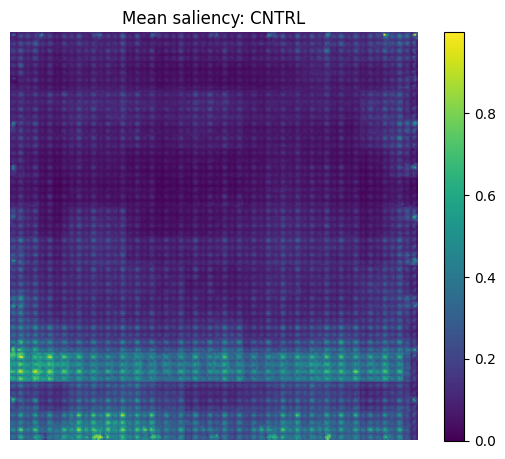

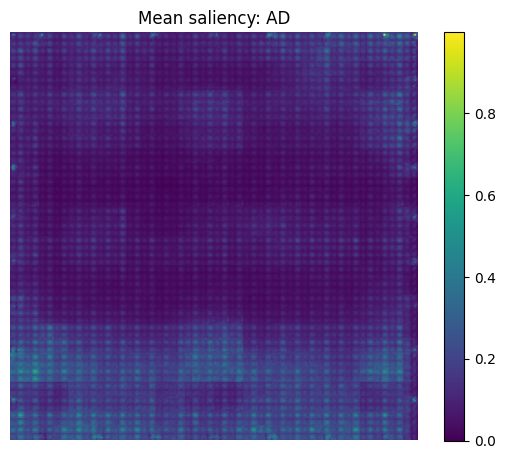

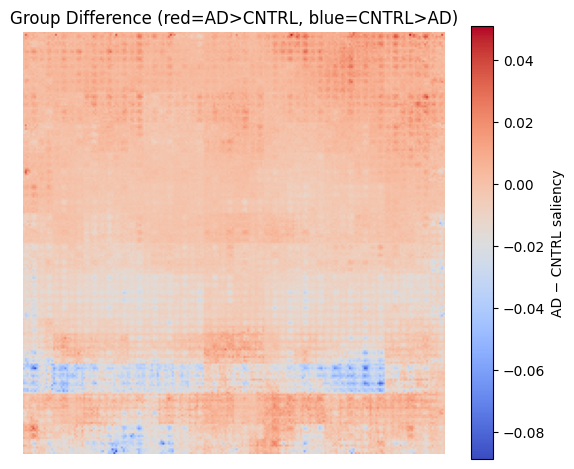

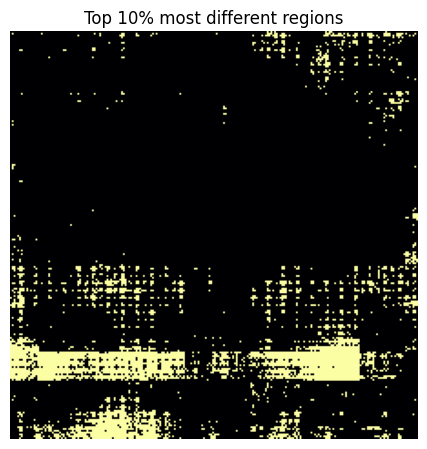

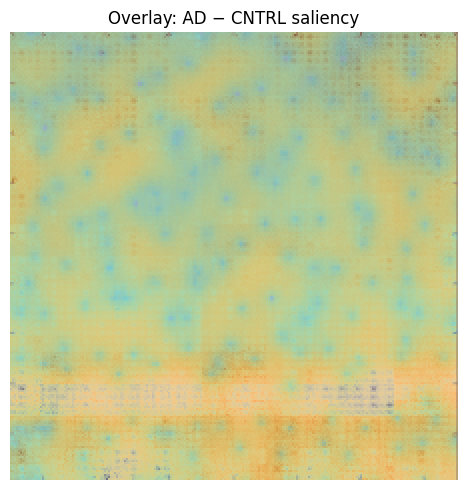

In [ ]:
# ========= FAST XAI (fixed; no nonlocal, no extra installs) =========
import torch, numpy as np, matplotlib.pyplot as plt

model.eval()
device = next(model.parameters()).device

# --- resolve class indices ---
classes = list(le.classes_)
assert "AD" in classes and "CNTRL" in classes, f"LabelEncoder classes must include AD and CNTRL, got: {classes}"
idx_AD, idx_CNTRL = classes.index("AD"), classes.index("CNTRL")

@torch.no_grad()
def get_preds(imgs):
    out = model(imgs.to(device))
    return out.argmax(1).cpu()

def saliency_batch(model, imgs, target_idx):
    imgs = imgs.to(device).float().requires_grad_(True)
    model.zero_grad(set_to_none=True)
    logits = model(imgs)
    scores = logits[torch.arange(imgs.size(0), device=device), target_idx.to(device)]
    scores.sum().backward()
    grads = imgs.grad.detach().abs()              # [B,3,H,W]
    sal = grads.max(dim=1).values                 # [B,H,W]
    # normalize per image to [0,1]
    B,H,W = sal.shape
    sal = sal.view(B,-1)
    mins = sal.min(dim=1, keepdim=True).values
    maxs = sal.max(dim=1, keepdim=True).values
    sal = ((sal - mins) / (maxs - mins + 1e-8)).view(B,H,W).cpu()
    return sal

# -------- aggregate group-wise mean saliency on a subset --------
max_per_group   = 200    # lower (e.g., 50–100) for speed
only_correct    = True   # keep only correctly classified samples
use_true_target = True   # target = true labels (or set False to use predicted)

sum_ad, sum_hc = None, None
n_ad, n_hc = 0, 0

for imgs, labels, _ in test_loader:
    if n_ad >= max_per_group and n_hc >= max_per_group:
        break

    preds = get_preds(imgs)
    keep = (preds == labels) if only_correct else torch.ones_like(labels, dtype=torch.bool)

    # process AD
    if n_ad < max_per_group:
        mask = keep & (labels == idx_AD)
        if mask.any():
            sel = mask.nonzero(as_tuple=False).squeeze(1)[: (max_per_group - n_ad)]
            t_idx = (labels if use_true_target else preds)[sel]
            sal = saliency_batch(model, imgs[sel], t_idx)    # [b,H,W]
            s = sal.sum(dim=0)                               # [H,W]
            sum_ad = s if sum_ad is None else sum_ad + s
            n_ad += sal.shape[0]

    # process CNTRL
    if n_hc < max_per_group:
        mask = keep & (labels == idx_CNTRL)
        if mask.any():
            sel = mask.nonzero(as_tuple=False).squeeze(1)[: (max_per_group - n_hc)]
            t_idx = (labels if use_true_target else preds)[sel]
            sal = saliency_batch(model, imgs[sel], t_idx)
            s = sal.sum(dim=0)
            sum_hc = s if sum_hc is None else sum_hc + s
            n_hc += sal.shape[0]

print(f"Collected saliency maps -> AD={n_ad}, CNTRL={n_hc}")
assert sum_ad is not None and sum_hc is not None, "Not enough samples collected."

mean_ad  = (sum_ad / max(n_ad,1)).numpy()
mean_hc  = (sum_hc / max(n_hc,1)).numpy()
diff_map = mean_ad - mean_hc  # >0 : more AD-salient; <0 : more CNTRL-salient

# -------- visualize --------
def show_map(m, title, cmap="viridis"):
    mm = (m - m.min()) / (m.max() - m.min() + 1e-8)
    plt.figure(figsize=(5.4,4.6)); plt.imshow(mm, cmap=cmap)
    plt.title(title); plt.axis("off"); plt.colorbar(); plt.tight_layout(); plt.show()

show_map(mean_hc, "Mean saliency: CNTRL")
show_map(mean_ad, "Mean saliency: AD")

plt.figure(figsize=(5.8,4.8))
plt.imshow(diff_map, cmap="coolwarm")
plt.colorbar(label="AD − CNTRL saliency")
plt.title("Group Difference (red=AD>CNTRL, blue=CNTRL>AD)")
plt.axis("off"); plt.tight_layout(); plt.show()

# Top-k% most different regions (mask)
k = 0.10
thr = np.quantile(np.abs(diff_map).ravel(), 1 - k)
mask = (np.abs(diff_map) >= thr).astype(float)
plt.figure(figsize=(5.4,4.6)); plt.imshow(mask, cmap="inferno")
plt.title(f"Top {int(k*100)}% most different regions"); plt.axis("off"); plt.tight_layout(); plt.show()

# Optional overlay on a sample CWT image
sample_imgs, _, _ = next(iter(test_loader))
bg = (sample_imgs[0]*0.5 + 0.5).permute(1,2,0).clamp(0,1).cpu().numpy()
d_norm = (diff_map - diff_map.min()) / (diff_map.max() - diff_map.min() + 1e-8)
plt.figure(figsize=(6,5)); plt.imshow(bg); plt.imshow(d_norm, alpha=0.55, cmap="coolwarm")
plt.title("Overlay: AD − CNTRL saliency"); plt.axis("off"); plt.tight_layout(); plt.show()


In [ ]:
# ===================== SAVE XAI MAPS + DOWNLOAD (Colab) =====================
import os, json, csv, zipfile
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

RUN_TAG = "fold5_post_EC"   # <<<< your requested tag
OUT_ROOT = Path("/content/xai_exports")
OUT_DIR  = OUT_ROOT / RUN_TAG
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Helper: save array as PNG (0..1 normalize if needed) and as .npy and .csv
def save_array_all(name, arr, cmap="viridis"):
    base = f"{RUN_TAG}__{name}"
    arr = np.asarray(arr)
    # npy
    np.save(OUT_DIR / f"{base}.npy", arr)
    # csv (2D only)
    if arr.ndim == 2:
        with open(OUT_DIR / f"{base}.csv", "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerows(arr.tolist())
    # png
    a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
    plt.figure(figsize=(6,5))
    plt.imshow(a, cmap=cmap)
    plt.title(base)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"{base}.png", dpi=200, bbox_inches="tight")
    plt.close()

# Save the group maps
save_array_all("mean_cntrl_saliency", mean_hc, cmap="viridis")
save_array_all("mean_ad_saliency",    mean_ad, cmap="viridis")
save_array_all("diff_ad_minus_cntrl", diff_map, cmap="coolwarm")
save_array_all("topk_mask",           mask, cmap="inferno")

# Save an overlay PNG (assumes 'bg' and 'd_norm' already exist)
plt.figure(figsize=(6,5))
plt.imshow(bg)
plt.imshow(d_norm, alpha=0.55, cmap="coolwarm")
plt.title(f"{RUN_TAG}__overlay_ad_minus_cntrl")
plt.axis("off")
plt.tight_layout()
plt.savefig(OUT_DIR / f"{RUN_TAG}__overlay_ad_minus_cntrl.png", dpi=200, bbox_inches="tight")
plt.close()

# Save a small JSON with run meta
meta = {
    "run_tag": RUN_TAG,
    "n_used_AD": int(n_ad),
    "n_used_CNTRL": int(n_hc),
    "k_top_percent": float(k),
    "abs_threshold": float(thr),
    "classes": classes,
}
with open(OUT_DIR / f"{RUN_TAG}__metadata.json", "w") as f:
    json.dump(meta, f, indent=2)

# -------- OPTIONAL: SAVE PER-IMAGE SALIENCY MAPS (can be heavy!) ----------
SAVE_PER_IMAGE = False     # set True if you want every selected image saved
PER_IMG_LIMIT  = 200       # safety limit (per group)

if SAVE_PER_IMAGE:
    PER_DIR = OUT_DIR / "per_image_saliency"
    PER_DIR.mkdir(parents=True, exist_ok=True)

    saved_ad = 0
    saved_hc = 0
    for imgs, labels, paths in test_loader:
        if saved_ad >= PER_IMG_LIMIT and saved_hc >= PER_IMG_LIMIT:
            break
        preds = get_preds(imgs)
        keep = (preds == labels) if only_correct else torch.ones_like(labels, dtype=torch.bool)

        # AD group
        if saved_ad < PER_IMG_LIMIT:
            mask_ad = keep & (labels == idx_AD)
            if mask_ad.any():
                sel = mask_ad.nonzero(as_tuple=False).squeeze(1)
                sel = sel[: max(0, PER_IMG_LIMIT - saved_ad)]
                t_idx = (labels if use_true_target else preds)[sel]
                sal = saliency_batch(model, imgs[sel], t_idx)    # [b,H,W]
                for i, si in enumerate(sal):
                    subj_dir = Path(paths[sel[i]]).parent.name
                    base = Path(paths[sel[i]]).stem
                    arr = si.numpy()
                    np.save(PER_DIR / f"{RUN_TAG}__{subj_dir}__{base}__AD.npy", arr)
                    a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
                    plt.figure(figsize=(5,4))
                    plt.imshow(a, cmap="viridis")
                    plt.title(f"{RUN_TAG} :: {subj_dir} :: {base} :: AD")
                    plt.axis("off"); plt.tight_layout()
                    plt.savefig(PER_DIR / f"{RUN_TAG}__{subj_dir}__{base}__AD.png", dpi=160, bbox_inches="tight")
                    plt.close()
                saved_ad += sal.shape[0]

        # CNTRL group
        if saved_hc < PER_IMG_LIMIT:
            mask_hc = keep & (labels == idx_CNTRL)
            if mask_hc.any():
                sel = mask_hc.nonzero(as_tuple=False).squeeze(1)
                sel = sel[: max(0, PER_IMG_LIMIT - saved_hc)]
                t_idx = (labels if use_true_target else preds)[sel]
                sal = saliency_batch(model, imgs[sel], t_idx)
                for i, si in enumerate(sal):
                    subj_dir = Path(paths[sel[i]]).parent.name
                    base = Path(paths[sel[i]]).stem
                    arr = si.numpy()
                    np.save(PER_DIR / f"{RUN_TAG}__{subj_dir}__{base}__CNTRL.npy", arr)
                    a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
                    plt.figure(figsize=(5,4))
                    plt.imshow(a, cmap="viridis")
                    plt.title(f"{RUN_TAG} :: {subj_dir} :: {base} :: CNTRL")
                    plt.axis("off"); plt.tight_layout()
                    plt.savefig(PER_DIR / f"{RUN_TAG}__{subj_dir}__{base}__CNTRL.png", dpi=160, bbox_inches="tight")
                    plt.close()
                saved_hc += sal.shape[0]

# -------- ZIP + DOWNLOAD (Colab) ----------
ZIP_PATH = f"/content/xai_exports_{RUN_TAG}.zip"
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for p in OUT_ROOT.rglob("*"):
        zf.write(p, arcname=p.relative_to(OUT_ROOT.parent))

print(f"Saved XAI exports to: {OUT_DIR}")
print(f"Zipped at: {ZIP_PATH}")

try:
    from google.colab import files
    files.download(ZIP_PATH)
except Exception as e:
    print("Colab download not available in this environment:", e)
    print("You can also copy the folder to Drive, e.g.:")
    print("!mkdir -p '/content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports' && cp -r /content/xai_exports '/content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports'")
# =====================================================================


In [ ]:
# # ===================== SAVE TO GOOGLE DRIVE (+ RAR) =====================
# import shutil, subprocess
# from pathlib import Path

# # Mount Drive (safe to call even if already mounted)
# from google.colab import drive
# drive.mount('/content/drive', force_remount=False)

# DRIVE_BASE = Path('/content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports')
# DRIVE_BASE.mkdir(parents=True, exist_ok=True)

# # 1) Copy the run folder to Drive
# DRIVE_RUN_DIR = DRIVE_BASE / RUN_TAG
# if DRIVE_RUN_DIR.exists():
#     shutil.rmtree(DRIVE_RUN_DIR)
# shutil.copytree(OUT_DIR, DRIVE_RUN_DIR)

# # 2) Copy the ZIP to Drive
# DRIVE_ZIP = DRIVE_BASE / f"xai_exports_{RUN_TAG}.zip"
# shutil.copy2(ZIP_PATH, DRIVE_ZIP)

# print(f"Copied to Drive folder: {DRIVE_RUN_DIR}")
# print(f"Copied ZIP to Drive:    {DRIVE_ZIP}")

# # 3) OPTIONAL: Create a RAR archive directly in Drive
# #    This installs 'rar' (non-free) in the Colab VM, then writes a .rar into Drive.
# try:
#     print("Attempting to create RAR in Drive...")
#     subprocess.run(["apt-get", "update", "-y"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
#     subprocess.run(["apt-get", "install", "-y", "rar"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)

#     DRIVE_RAR = DRIVE_BASE / f"xai_exports_{RUN_TAG}.rar"
#     # 'rar a -r <archive> <folder_to_add>'  (-r = recurse)
#     # Use the *parent* of OUT_DIR so it stores the folder name inside the archive neatly
#     subprocess.run(["rar", "a", "-r", str(DRIVE_RAR), str(OUT_DIR)], check=True)

#     print(f"RAR saved to Drive:     {DRIVE_RAR}")
# except Exception as e:
#     print("Could not create .rar (keeping .zip). Error:", e)
# # ======================================================================


In [ ]:
# import torch, numpy as np, matplotlib.pyplot as plt
# import torch.nn.functional as F

# def make_patch_masks(H, W, patch=32, stride=32, device="cpu"):
#     ys = list(range(0, H - patch + 1, stride))
#     xs = list(range(0, W - patch + 1, stride))
#     masks = []
#     for y in ys:
#         for x in xs:
#             m = torch.zeros(1, 1, H, W, device=device)
#             m[:, :, y:y+patch, x:x+patch] = 1.0
#             masks.append(m)
#     return torch.cat(masks, dim=0), len(ys), len(xs)  # [K,1,H,W], Gy, Gx

# def occlusion_saliency_batch(model, imgs, target_idx, patch=32, stride=32, fill_val=0.0, chunk_masks=8):
#     """
#     Returns coarse heatmaps [B,H,W] using patch occlusion. No grads, just forward passes.
#     """
#     device = imgs.device
#     B, C, H, W = imgs.shape
#     masks, Gy, Gx = make_patch_masks(H, W, patch=patch, stride=stride, device=device)  # [K,1,H,W]
#     K = masks.shape[0]

#     with torch.no_grad():
#         base = model(imgs)  # [B,C]
#         base_t = base[torch.arange(B), target_idx]  # [B]
#     heat = torch.zeros(B, H, W, device=device)

#     # Process masks in chunks to control memory
#     for i in range(0, K, chunk_masks):
#         m = masks[i:i+chunk_masks]                     # [m,1,H,W]
#         # Broadcast to [B,m,3,H,W]
#         x_occ = imgs.unsqueeze(1) * (1 - m) + fill_val * m
#         x_occ = x_occ.view(-1, C, H, W)               # [B*m,3,H,W]
#         with torch.no_grad():
#             logits = model(x_occ)                     # [B*m,C]
#             logits = logits.view(B, -1, base.shape[1])# [B,m,C]
#             scores = logits[..., target_idx.view(B,1)]# [B,m,1]
#             scores = scores.squeeze(-1)               # [B,m]
#         drop = (base_t.unsqueeze(1) - scores).clamp_min(0.0)  # [B,m]

#         # Paint the drop back onto the corresponding patch areas
#         # (uniformly add the drop value over that patch)
#         for jj in range(m.shape[0]):
#             yx = (i + jj)
#             y_idx = (yx // Gx) * stride
#             x_idx = (yx %  Gx) * stride
#             heat[:, y_idx:y_idx+patch, x_idx:x_idx+patch] += drop[:, jj].unsqueeze(-1).unsqueeze(-1)

#     # Normalize per image
#     B = heat.size(0)
#     heat = heat.view(B, -1)
#     heat = (heat - heat.min(dim=1, keepdim=True).values) / (heat.max(dim=1, keepdim=True).values - heat.min(dim=1, keepdim=True).values + 1e-8)
#     heat = heat.view(B, H, W)
#     return heat

# # Aggregate per group (same pattern as above)
# max_per_group = 80          # keep small; occlusion is heavier than saliency
# only_correct  = True
# use_true_target = True
# patch, stride = 32, 32
# chunk_masks   = 8

# sum_ad = None; n_ad = 0
# sum_hc = None; n_hc = 0

# for imgs, labels, _ in test_loader:
#     if n_ad >= max_per_group and n_hc >= max_per_group:
#         break
#     preds = get_preds(imgs)
#     keep = (preds == labels) if only_correct else torch.ones_like(labels, dtype=torch.bool)
#     for group_idx, is_ad in [(idx_AD, True), (idx_CNTRL, False)]:
#         m = keep & (labels == group_idx)
#         if m.sum() == 0:
#             continue
#         budget = (max_per_group - (n_ad if is_ad else n_hc))
#         if budget <= 0:
#             continue
#         sel = m.nonzero(as_tuple=False).squeeze(1)[:budget]
#         t_idx = (labels if use_true_target else preds)[sel]
#         heat = occlusion_saliency_batch(model, imgs[sel].to(device), t_idx.to(device),
#                                         patch=patch, stride=stride, chunk_masks=chunk_masks)  # [b,H,W]
#         s = heat.sum(dim=0)
#         if is_ad:
#             sum_ad = s if sum_ad is None else sum_ad + s
#             n_ad  += heat.shape[0]
#         else:
#             sum_hc = s if sum_hc is None else sum_hc + s
#             n_hc  += heat.shape[0]

# print(f"[Occlusion] Collected: AD={n_ad}, CNTRL={n_hc}")
# mean_ad_occ = (sum_ad / max(n_ad,1)).cpu().numpy()
# mean_hc_occ = (sum_hc / max(n_hc,1)).cpu().numpy()
# diff_occ    = mean_ad_occ - mean_hc_occ

# plt.figure(figsize=(5.6,4.8))
# plt.imshow(diff_occ, cmap="coolwarm")
# plt.colorbar(label="AD − CNTRL (occlusion)")
# plt.title("Group Difference via Patch-Occlusion")
# plt.axis("off"); plt.tight_layout(); plt.show()


In [ ]:
# ===================== SAVE XAI MAPS + DOWNLOAD (Colab) =====================
import os, json, csv, zipfile
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

RUN_TAG = "fold5_post_EC"   # <<<< your requested tag
OUT_ROOT = Path("/content/xai_exports")
OUT_DIR  = OUT_ROOT / RUN_TAG
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Helper: save array as PNG (0..1 normalize if needed) and as .npy and .csv
def save_array_all(name, arr, cmap="viridis"):
    base = f"{RUN_TAG}__{name}"
    arr = np.asarray(arr)
    # npy
    np.save(OUT_DIR / f"{base}.npy", arr)
    # csv (2D only)
    if arr.ndim == 2:
        with open(OUT_DIR / f"{base}.csv", "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerows(arr.tolist())
    # png
    a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
    plt.figure(figsize=(6,5))
    plt.imshow(a, cmap=cmap)
    plt.title(base)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"{base}.png", dpi=200, bbox_inches="tight")
    plt.close()

# Save the group maps
save_array_all("mean_cntrl_saliency", mean_hc, cmap="viridis")
save_array_all("mean_ad_saliency",    mean_ad, cmap="viridis")
save_array_all("diff_ad_minus_cntrl", diff_map, cmap="coolwarm")
save_array_all("topk_mask",           mask, cmap="inferno")

# Save an overlay PNG (assumes 'bg' and 'd_norm' already exist)
plt.figure(figsize=(6,5))
plt.imshow(bg)
plt.imshow(d_norm, alpha=0.55, cmap="coolwarm")
plt.title(f"{RUN_TAG}__overlay_ad_minus_cntrl")
plt.axis("off")
plt.tight_layout()
plt.savefig(OUT_DIR / f"{RUN_TAG}__overlay_ad_minus_cntrl.png", dpi=200, bbox_inches="tight")
plt.close()

# Save a small JSON with run meta
meta = {
    "run_tag": RUN_TAG,
    "n_used_AD": int(n_ad),
    "n_used_CNTRL": int(n_hc),
    "k_top_percent": float(k),
    "abs_threshold": float(thr),
    "classes": classes,
}
with open(OUT_DIR / f"{RUN_TAG}__metadata.json", "w") as f:
    json.dump(meta, f, indent=2)

# -------- OPTIONAL: SAVE PER-IMAGE SALIENCY MAPS (can be heavy!) ----------
SAVE_PER_IMAGE = False     # set True if you want every selected image saved
PER_IMG_LIMIT  = 200       # safety limit (per group)

if SAVE_PER_IMAGE:
    PER_DIR = OUT_DIR / "per_image_saliency"
    PER_DIR.mkdir(parents=True, exist_ok=True)

    saved_ad = 0
    saved_hc = 0
    for imgs, labels, paths in test_loader:
        if saved_ad >= PER_IMG_LIMIT and saved_hc >= PER_IMG_LIMIT:
            break
        preds = get_preds(imgs)
        keep = (preds == labels) if only_correct else torch.ones_like(labels, dtype=torch.bool)

        # AD group
        if saved_ad < PER_IMG_LIMIT:
            mask_ad = keep & (labels == idx_AD)
            if mask_ad.any():
                sel = mask_ad.nonzero(as_tuple=False).squeeze(1)
                sel = sel[: max(0, PER_IMG_LIMIT - saved_ad)]
                t_idx = (labels if use_true_target else preds)[sel]
                sal = saliency_batch(model, imgs[sel], t_idx)    # [b,H,W]
                for i, si in enumerate(sal):
                    subj_dir = Path(paths[sel[i]]).parent.name
                    base = Path(paths[sel[i]]).stem
                    arr = si.numpy()
                    np.save(PER_DIR / f"{RUN_TAG}__{subj_dir}__{base}__AD.npy", arr)
                    a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
                    plt.figure(figsize=(5,4))
                    plt.imshow(a, cmap="viridis")
                    plt.title(f"{RUN_TAG} :: {subj_dir} :: {base} :: AD")
                    plt.axis("off"); plt.tight_layout()
                    plt.savefig(PER_DIR / f"{RUN_TAG}__{subj_dir}__{base}__AD.png", dpi=160, bbox_inches="tight")
                    plt.close()
                saved_ad += sal.shape[0]

        # CNTRL group
        if saved_hc < PER_IMG_LIMIT:
            mask_hc = keep & (labels == idx_CNTRL)
            if mask_hc.any():
                sel = mask_hc.nonzero(as_tuple=False).squeeze(1)
                sel = sel[: max(0, PER_IMG_LIMIT - saved_hc)]
                t_idx = (labels if use_true_target else preds)[sel]
                sal = saliency_batch(model, imgs[sel], t_idx)
                for i, si in enumerate(sal):
                    subj_dir = Path(paths[sel[i]]).parent.name
                    base = Path(paths[sel[i]]).stem
                    arr = si.numpy()
                    np.save(PER_DIR / f"{RUN_TAG}__{subj_dir}__{base}__CNTRL.npy", arr)
                    a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
                    plt.figure(figsize=(5,4))
                    plt.imshow(a, cmap="viridis")
                    plt.title(f"{RUN_TAG} :: {subj_dir} :: {base} :: CNTRL")
                    plt.axis("off"); plt.tight_layout()
                    plt.savefig(PER_DIR / f"{RUN_TAG}__{subj_dir}__{base}__CNTRL.png", dpi=160, bbox_inches="tight")
                    plt.close()
                saved_hc += sal.shape[0]

# -------- ZIP + DOWNLOAD (Colab) ----------
ZIP_PATH = f"/content/xai_exports_{RUN_TAG}.zip"
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for p in OUT_ROOT.rglob("*"):
        zf.write(p, arcname=p.relative_to(OUT_ROOT.parent))

print(f"Saved XAI exports to: {OUT_DIR}")
print(f"Zipped at: {ZIP_PATH}")

try:
    from google.colab import files
    files.download(ZIP_PATH)
except Exception as e:
    print("Colab download not available in this environment:", e)
    print("You can also copy the folder to Drive, e.g.:")
    print("!mkdir -p '/content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports' && cp -r /content/xai_exports '/content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports'")
# =====================================================================


In [ ]:
# import torch, numpy as np, matplotlib.pyplot as plt
# import torch.nn.functional as F

# def make_patch_masks(H, W, patch=32, stride=32, device="cpu"):
#     ys = list(range(0, H - patch + 1, stride))
#     xs = list(range(0, W - patch + 1, stride))
#     masks = []
#     for y in ys:
#         for x in xs:
#             m = torch.zeros(1, 1, H, W, device=device)
#             m[:, :, y:y+patch, x:x+patch] = 1.0
#             masks.append(m)
#     return torch.cat(masks, dim=0), len(ys), len(xs)  # [K,1,H,W], Gy, Gx

# def occlusion_saliency_batch(model, imgs, target_idx, patch=32, stride=32, fill_val=0.0, chunk_masks=8):
#     """
#     Returns coarse heatmaps [B,H,W] using patch occlusion. No grads, just forward passes.
#     """
#     device = imgs.device
#     B, C, H, W = imgs.shape
#     masks, Gy, Gx = make_patch_masks(H, W, patch=patch, stride=stride, device=device)  # [K,1,H,W]
#     K = masks.shape[0]

#     with torch.no_grad():
#         base = model(imgs)  # [B,C]
#         base_t = base[torch.arange(B), target_idx]  # [B]
#     heat = torch.zeros(B, H, W, device=device)

#     # Process masks in chunks to control memory
#     for i in range(0, K, chunk_masks):
#         m = masks[i:i+chunk_masks]                     # [m,1,H,W]
#         # Broadcast to [B,m,3,H,W]
#         x_occ = imgs.unsqueeze(1) * (1 - m) + fill_val * m
#         x_occ = x_occ.view(-1, C, H, W)               # [B*m,3,H,W]
#         with torch.no_grad():
#             logits = model(x_occ)                     # [B*m,C]
#             logits = logits.view(B, -1, base.shape[1])# [B,m,C]
#             scores = logits[..., target_idx.view(B,1)]# [B,m,1]
#             scores = scores.squeeze(-1)               # [B,m]
#         drop = (base_t.unsqueeze(1) - scores).clamp_min(0.0)  # [B,m]

#         # Paint the drop back onto the corresponding patch areas
#         # (uniformly add the drop value over that patch)
#         for jj in range(m.shape[0]):
#             yx = (i + jj)
#             y_idx = (yx // Gx) * stride
#             x_idx = (yx %  Gx) * stride
#             heat[:, y_idx:y_idx+patch, x_idx:x_idx+patch] += drop[:, jj].unsqueeze(-1).unsqueeze(-1)

#     # Normalize per image
#     B = heat.size(0)
#     heat = heat.view(B, -1)
#     heat = (heat - heat.min(dim=1, keepdim=True).values) / (heat.max(dim=1, keepdim=True).values - heat.min(dim=1, keepdim=True).values + 1e-8)
#     heat = heat.view(B, H, W)
#     return heat

# # Aggregate per group (same pattern as above)
# max_per_group = 80          # keep small; occlusion is heavier than saliency
# only_correct  = True
# use_true_target = True
# patch, stride = 32, 32
# chunk_masks   = 8

# sum_ad = None; n_ad = 0
# sum_hc = None; n_hc = 0

# for imgs, labels, _ in test_loader:
#     if n_ad >= max_per_group and n_hc >= max_per_group:
#         break
#     preds = get_preds(imgs)
#     keep = (preds == labels) if only_correct else torch.ones_like(labels, dtype=torch.bool)
#     for group_idx, is_ad in [(idx_AD, True), (idx_CNTRL, False)]:
#         m = keep & (labels == group_idx)
#         if m.sum() == 0:
#             continue
#         budget = (max_per_group - (n_ad if is_ad else n_hc))
#         if budget <= 0:
#             continue
#         sel = m.nonzero(as_tuple=False).squeeze(1)[:budget]
#         t_idx = (labels if use_true_target else preds)[sel]
#         heat = occlusion_saliency_batch(model, imgs[sel].to(device), t_idx.to(device),
#                                         patch=patch, stride=stride, chunk_masks=chunk_masks)  # [b,H,W]
#         s = heat.sum(dim=0)
#         if is_ad:
#             sum_ad = s if sum_ad is None else sum_ad + s
#             n_ad  += heat.shape[0]
#         else:
#             sum_hc = s if sum_hc is None else sum_hc + s
#             n_hc  += heat.shape[0]

# print(f"[Occlusion] Collected: AD={n_ad}, CNTRL={n_hc}")
# mean_ad_occ = (sum_ad / max(n_ad,1)).cpu().numpy()
# mean_hc_occ = (sum_hc / max(n_hc,1)).cpu().numpy()
# diff_occ    = mean_ad_occ - mean_hc_occ

# plt.figure(figsize=(5.6,4.8))
# plt.imshow(diff_occ, cmap="coolwarm")
# plt.colorbar(label="AD − CNTRL (occlusion)")
# plt.title("Group Difference via Patch-Occlusion")
# plt.axis("off"); plt.tight_layout(); plt.show()


#### New XAI (IG + SmoothGrad IG)

In [ ]:
# # ========================= XAI (IG + SmoothGrad IG) =========================
# import os, json, csv, zipfile, math, subprocess, shutil
# from pathlib import Path
# from collections import defaultdict, Counter

# import numpy as np
# import torch
# import torch.nn.functional as F
# import matplotlib.pyplot as plt

# # ------------------------ CONFIG ------------------------
# RUN_TAG          = "fold5_post_EC_IG_SGIG"  # customize per run
# OUT_ROOT         = Path("/content/xai_exports")
# OUT_DIR          = OUT_ROOT / RUN_TAG
# OUT_DIR.mkdir(parents=True, exist_ok=True)

# # Saliency collection
# MAX_PER_GROUP_IG    = 200   # how many correctly-classified images per group for IG
# MAX_PER_GROUP_SGIG  = 200   # for SmoothGradIG
# USE_TRUE_TARGET     = True  # True -> IG wrt true label; False -> wrt predicted class

# # Integrated Gradients settings
# IG_STEPS         = 32       # Riemann steps along the path
# BASELINE_KIND    = "zero"   # "zero" or "black" (zero is fine; inputs are normalized)

# # SmoothGrad IG settings
# SG_N_SAMPLES     = 25
# SG_NOISE_SIGMA   = 0.10     # noise std in input space (on normalized scale)

# # Significance testing (optional)
# DO_STAT_TEST     = False           # flip to True to compute pixel-wise tests (heavier)
# SIG_MAX_PER_GRP  = 120             # cap #images per group for stats to save memory
# ALPHA_FDR        = 0.05            # FDR level

# # Frequency axis (low frequency at bottom row)
# FREQ_MIN = 0.5   # Hz
# FREQ_MAX = 45.0  # Hz

# # Bands (name, low, high) in Hz
# BAND_EDGES = [
#     ("delta", 0.5, 4.0),
#     ("theta", 4.0, 8.0),
#     ("alpha", 8.0, 13.0),
#     ("beta", 13.0, 30.0),
#     ("gamma", 30.0, 45.0),
# ]

# # --------------------- helpers: saving -------------------
# def save_array_all(name, arr, cmap="viridis"):
#     """Save arr as .npy, .csv (if 2D), and .png."""
#     base = f"{RUN_TAG}__{name}"
#     arr = np.asarray(arr)
#     # npy
#     np.save(OUT_DIR / f"{base}.npy", arr)
#     # csv (2D only)
#     if arr.ndim == 2:
#         with open(OUT_DIR / f"{base}.csv", "w", newline="") as f:
#             writer = csv.writer(f)
#             writer.writerows(arr.tolist())
#     # png (0..1 normalize for viewing)
#     a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8) if arr.size else arr
#     plt.figure(figsize=(6,5))
#     plt.imshow(a, cmap=cmap)
#     plt.title(base)
#     plt.axis("off")
#     plt.tight_layout()
#     plt.savefig(OUT_DIR / f"{base}.png", dpi=200, bbox_inches="tight")
#     plt.close()

# def save_overlay(bg_img_hwc01, heat_2d, name, cmap="coolwarm", alpha=0.55):
#     """bg_img_hwc01 in [0,1], heat_2d any real values."""
#     base = f"{RUN_TAG}__{name}"
#     h = (heat_2d - heat_2d.min()) / (heat_2d.max() - heat_2d.min() + 1e-8)
#     plt.figure(figsize=(6,5))
#     plt.imshow(bg_img_hwc01)
#     plt.imshow(h, alpha=alpha, cmap=cmap)
#     plt.title(base)
#     plt.axis("off")
#     plt.tight_layout()
#     plt.savefig(OUT_DIR / f"{base}.png", dpi=200, bbox_inches="tight")
#     plt.close()

# # ------------------ helpers: IG & SmoothGrad IG ------------------
# def _make_baseline_like(img):
#     # img: [3,H,W]
#     if BASELINE_KIND == "zero":
#         return torch.zeros_like(img)
#     elif BASELINE_KIND == "black":
#         return torch.zeros_like(img)  # same for normalized inputs
#     else:
#         return torch.zeros_like(img)

# @torch.no_grad()
# def get_preds(imgs, model):
#     out = model(imgs.to(device))
#     return out.argmax(1).cpu()

# def integrated_gradients(model, imgs, target_idx, steps=32):
#     """
#     Robust IG: works for [B,3,H,W] or [3,H,W], returns [B,H,W] (abs-mean over channels).
#     Force-enables autograd for the forward/backward.
#     """
#     model.eval()
#     device_local = next(model.parameters()).device

#     # ---- enforce shapes on inputs/targets ----
#     if imgs.dim() == 3:   # [3,H,W] -> [1,3,H,W]
#         imgs = imgs.unsqueeze(0)
#     imgs = imgs.to(device_local)

#     if isinstance(target_idx, (int,)):
#         target_idx = torch.tensor([target_idx], device=device_local, dtype=torch.long)
#     else:
#         target_idx = target_idx.to(device_local)
#         if target_idx.dim() == 0:
#             target_idx = target_idx.unsqueeze(0)

#     B, C, H, W = imgs.shape
#     alphas = torch.linspace(0., 1., steps + 1, device=device_local)  # [steps+1]
#     sal_out = torch.zeros(B, H, W, device=device_local)

#     # IG per sample for stability
#     for i in range(B):
#         x = imgs[i:i+1].clone()                     # [1,3,H,W]
#         y_idx = int(target_idx[i].item())
#         baseline = torch.zeros_like(x)              # [1,3,H,W]

#         # Path: [steps+1, 1, 3, H, W]
#         path = baseline + alphas.view(-1, 1, 1, 1) * (x - baseline)

#         grads_sum = torch.zeros_like(x)
#         # ensure autograd is enabled for these iterations
#         for t in range(path.shape[0]):
#             xt = path[t]
#             if xt.dim() == 3:
#                 xt = xt.unsqueeze(0)
#             xt = xt.clone().detach().requires_grad_(True)

#             # ---- enable grad just for this forward/backward ----
#             with torch.enable_grad():
#                 logits = model(xt)                  # [1,num_classes], must carry grad_fn
#                 score = logits[:, y_idx].sum()      # scalar
#                 model.zero_grad(set_to_none=True)
#                 score.backward()

#             grads_sum = grads_sum + xt.grad.detach()

#         grads_mean = grads_sum / float(steps + 1)
#         ig = (x - baseline) * grads_mean            # [1,3,H,W]
#         ig = ig.abs().mean(dim=1).squeeze(0)        # [H,W]
#         sal_out[i] = ig

#     return sal_out  # [B,H,W]


# def smoothgrad_ig(model, imgs, target_idx, steps=32, n_samples=25, noise_sigma=0.10):
#     """
#     SmoothGrad over IG; returns [B,H,W]. Force-enables autograd internally.
#     """
#     model.eval()
#     device_local = next(model.parameters()).device

#     if imgs.dim() == 3:
#         imgs = imgs.unsqueeze(0)
#     imgs = imgs.to(device_local)

#     if isinstance(target_idx, (int,)):
#         target_idx = torch.tensor([target_idx], device=device_local, dtype=torch.long)
#     else:
#         target_idx = target_idx.to(device_local)
#         if target_idx.dim() == 0:
#             target_idx = target_idx.unsqueeze(0)

#     B, C, H, W = imgs.shape
#     out = torch.zeros(B, H, W, device=device_local)

#     for _ in range(n_samples):
#         noise = torch.randn_like(imgs) * noise_sigma
#         noisy = (imgs + noise).clamp(-1.0, 1.0)
#         # IG itself uses enable_grad(), so we can call it directly
#         out += integrated_gradients(model, noisy, target_idx, steps=steps)

#     out /= float(n_samples)
#     return out

# # ---------------------- helpers: aggregation ----------------------
# def aggregate_group_mean(sal_batch, sum_group, n_group):
#     """sal_batch: [b,H,W] to add; returns updated (sum,n)."""
#     if sal_batch is None or sal_batch.numel() == 0:
#         return sum_group, n_group
#     s = sal_batch.sum(dim=0)  # [H,W]
#     sum_group = s if sum_group is None else (sum_group + s)
#     n_group += sal_batch.shape[0]
#     return sum_group, n_group

# def to_numpy_norm(x):
#     x = x.detach().float().cpu().numpy()
#     return x

# def topk_mask_from_abs(arr2d, frac=0.10):
#     """Return binary mask of top-|arr| pixels covering 'frac' of total pixels."""
#     a = np.abs(arr2d)
#     flat = a.ravel()
#     k = max(1, int(round(frac * flat.size)))
#     thr = np.partition(flat, -k)[-k]  # k-th largest
#     return (a >= thr).astype(np.float32), float(thr)

# # ---------------------- helpers: band coverage --------------------
# def percent_band_coverage(mask, band_edges, freq_min=FREQ_MIN, freq_max=FREQ_MAX):
#     """
#     mask: [H,W] binary (1=selected), low frequency at bottom (y=H-1 -> freq_min).
#     returns dict band_name -> percent of mask pixels in that band.
#     """
#     H, W = mask.shape
#     total = mask.sum()
#     if total == 0:
#         return {name: 0.0 for (name,_,_) in band_edges}
#     yy = np.arange(H)  # 0..H-1 top->bottom
#     # y=0 -> freq_max, y=H-1 -> freq_min
#     freq = freq_min + (1.0 - yy / max(H-1,1)) * (freq_max - freq_min)
#     out = {}
#     for (name, f_lo, f_hi) in band_edges:
#         rows = (freq >= f_lo) & (freq < f_hi)
#         band_total = mask[rows, :].sum()
#         out[name] = 100.0 * float(band_total) / float(total)
#     return out

# # ------------------------ collect saliencies ----------------------
# model.eval()
# classes = list(le.classes_)
# assert "AD" in classes and "CNTRL" in classes
# idx_AD, idx_CNTRL = classes.index("AD"), classes.index("CNTRL")

# sum_ad_ig = None; sum_hc_ig = None; n_ad_ig = 0; n_hc_ig = 0
# sum_ad_sg = None; sum_hc_sg = None; n_ad_sg = 0; n_hc_sg = 0

# # For overlay (background)
# try:
#     sample_imgs, sample_labels, sample_paths = next(iter(test_loader))
#     bg = (sample_imgs[0]*0.5 + 0.5).permute(1,2,0).clamp(0,1).cpu().numpy()
# except StopIteration:
#     bg = None

# with torch.no_grad():
#     for imgs, labels, paths in test_loader:
#         preds = get_preds(imgs, model)
#         keep = (preds == labels)  # only_correct=True

#         # ---- IG for AD ----
#         if n_ad_ig < MAX_PER_GROUP_IG:
#             m_ad = keep & (labels == idx_AD)
#             if m_ad.any():
#                 sel = m_ad.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_IG - n_ad_ig)]
#                 tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                 ig_batch = integrated_gradients(model, imgs[sel], tgt, steps=IG_STEPS) # [b,H,W]
#                 sum_ad_ig, n_ad_ig = aggregate_group_mean(ig_batch, sum_ad_ig, n_ad_ig)

#         # ---- IG for CNTRL ----
#         if n_hc_ig < MAX_PER_GROUP_IG:
#             m_hc = keep & (labels == idx_CNTRL)
#             if m_hc.any():
#                 sel = m_hc.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_IG - n_hc_ig)]
#                 tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                 ig_batch = integrated_gradients(model, imgs[sel], tgt, steps=IG_STEPS)
#                 sum_hc_ig, n_hc_ig = aggregate_group_mean(ig_batch, sum_hc_ig, n_hc_ig)

#         # ---- SG-IG for AD ----
#         if n_ad_sg < MAX_PER_GROUP_SGIG:
#             m_ad = keep & (labels == idx_AD)
#             if m_ad.any():
#                 sel = m_ad.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_SGIG - n_ad_sg)]
#                 tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                 sg_batch = smoothgrad_ig(model, imgs[sel], tgt, steps=IG_STEPS,
#                                          n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA)
#                 sum_ad_sg, n_ad_sg = aggregate_group_mean(sg_batch, sum_ad_sg, n_ad_sg)

#         # ---- SG-IG for CNTRL ----
#         if n_hc_sg < MAX_PER_GROUP_SGIG:
#             m_hc = keep & (labels == idx_CNTRL)
#             if m_hc.any():
#                 sel = m_hc.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_SGIG - n_hc_sg)]
#                 tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                 sg_batch = smoothgrad_ig(model, imgs[sel], tgt, steps=IG_STEPS,
#                                          n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA)
#                 sum_hc_sg, n_hc_sg = aggregate_group_mean(sg_batch, sum_hc_sg, n_hc_sg)

# print(f"[IG]    Collected: AD={n_ad_ig}, CNTRL={n_hc_ig}")
# print(f"[SG-IG] Collected: AD={n_ad_sg}, CNTRL={n_hc_sg}")
# assert n_ad_ig>0 and n_hc_ig>0 and n_ad_sg>0 and n_hc_sg>0, "Not enough samples collected."

# # ---------------------- group means & diffs ----------------------
# mean_ad_ig = to_numpy_norm(sum_ad_ig / max(n_ad_ig,1))
# mean_hc_ig = to_numpy_norm(sum_hc_ig / max(n_hc_ig,1))
# diff_ig    = mean_ad_ig - mean_hc_ig

# mean_ad_sg = to_numpy_norm(sum_ad_sg / max(n_ad_sg,1))
# mean_hc_sg = to_numpy_norm(sum_hc_sg / max(n_hc_sg,1))
# diff_sg    = mean_ad_sg - mean_hc_sg

# # ---------------------- top-k masks & band coverage --------------
# for frac in [0.10, 0.20]:
#     name = f"top{int(frac*100)}"
#     # IG
#     mask_ig, thr_ig = topk_mask_from_abs(diff_ig, frac=frac)
#     cov_ig = percent_band_coverage(mask_ig, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
#     save_array_all(f"{name}_mask_IG", mask_ig, cmap="inferno")
#     # SG-IG
#     mask_sg, thr_sg = topk_mask_from_abs(diff_sg, frac=frac)
#     cov_sg = percent_band_coverage(mask_sg, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
#     save_array_all(f"{name}_mask_SGIG", mask_sg, cmap="inferno")

#     # save band coverage as JSON
#     with open(OUT_DIR / f"{RUN_TAG}__{name}_band_coverage.json", "w") as f:
#         json.dump({
#             "fraction": frac,
#             "thresholds": {"IG": float(thr_ig), "SGIG": float(thr_sg)},
#             "coverage_percent": {"IG": cov_ig, "SGIG": cov_sg},
#             "bands_hz": BAND_EDGES,
#             "freq_min_max": [FREQ_MIN, FREQ_MAX]
#         }, f, indent=2)

# # ------------------------- save maps & overlays -------------------
# save_array_all("mean_ad_IG",   mean_ad_ig, cmap="viridis")
# save_array_all("mean_cntrl_IG",mean_hc_ig, cmap="viridis")
# save_array_all("diff_ADminusCNTRL_IG", diff_ig, cmap="coolwarm")

# save_array_all("mean_ad_SGIG",   mean_ad_sg, cmap="viridis")
# save_array_all("mean_cntrl_SGIG",mean_hc_sg, cmap="viridis")
# save_array_all("diff_ADminusCNTRL_SGIG", diff_sg, cmap="coolwarm")

# if bg is not None:
#     save_overlay(bg, diff_ig, "overlay_diff_IG")
#     save_overlay(bg, diff_sg, "overlay_diff_SGIG")

# # ------------------- OPTIONAL: significance test -----------------
# if DO_STAT_TEST:
#     print("Running pixel-wise Welch's t-test with BH-FDR...")
#     # Re-collect per-image saliency (capped) for both methods and groups
#     def collect_sal_per_image(method="IG", max_per_grp=SIG_MAX_PER_GRP):
#         ad_list, hc_list = [], []
#         with torch.no_grad():
#             for imgs, labels, paths in test_loader:
#                 preds = get_preds(imgs, model)
#                 keep  = (preds == labels)

#                 # AD
#                 if len(ad_list) < max_per_grp:
#                     m = keep & (labels == idx_AD)
#                     if m.any():
#                         sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, max_per_grp - len(ad_list))]
#                         tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                         if method == "IG":
#                             sal = integrated_gradients(model, imgs[sel], tgt, steps=IG_STEPS)
#                         else:
#                             sal = smoothgrad_ig(model, imgs[sel], tgt, steps=IG_STEPS,
#                                                 n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA)
#                         ad_list.append(sal.cpu().numpy())  # [b,H,W]

#                 # CNTRL
#                 if len(hc_list) < max_per_grp:
#                     m = keep & (labels == idx_CNTRL)
#                     if m.any():
#                         sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, max_per_grp - len(hc_list))]
#                         tgt = (labels if USE_TRUE_TARGET else preds)[sel]
#                         if method == "IG":
#                             sal = integrated_gradients(model, imgs[sel], tgt, steps=IG_STEPS)
#                         else:
#                             sal = smoothgrad_ig(model, imgs[sel], tgt, steps=IG_STEPS,
#                                                 n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA)
#                         hc_list.append(sal.cpu().numpy())

#                 if len(ad_list) >= max_per_grp and len(hc_list) >= max_per_grp:
#                     break

#         if len(ad_list)==0 or len(hc_list)==0:
#             return None, None
#         ad_arr = np.concatenate(ad_list, axis=0)  # [N_ad,H,W]
#         hc_arr = np.concatenate(hc_list, axis=0)  # [N_hc,H,W]
#         return ad_arr, hc_arr

#     def welch_ttest_map(ad_arr, hc_arr):
#         """
#         ad_arr, hc_arr: [N,H,W]; returns tmap [H,W], pmap [H,W]
#         """
#         Na, H, W = ad_arr.shape
#         Nh, _, _ = hc_arr.shape
#         mu_a = ad_arr.mean(axis=0)
#         mu_h = hc_arr.mean(axis=0)
#         var_a = ad_arr.var(axis=0, ddof=1)
#         var_h = hc_arr.var(axis=0, ddof=1)
#         # Welch t
#         num = mu_a - mu_h
#         den = np.sqrt(var_a/Na + var_h/Nh) + 1e-12
#         tmap = num / den

#         # Welch-Satterthwaite df
#         df = (var_a/Na + var_h/Nh)**2 / ((var_a**2)/(Na**2*(Na-1)+1e-12) + (var_h**2)/(Nh**2*(Nh-1)+1e-12) + 1e-12)

#         # two-sided p-values from t (approx via survival function of Student's t).
#         # To avoid extra deps, use Gaussian as a close approx when df is large:
#         # p ≈ 2*(1 - Φ(|t|))
#         from math import erf, sqrt
#         def norm_sf(x):  # 1 - CDF
#             return 0.5 * (1 - erf(x/np.sqrt(2)))
#         pmap = 2.0 * norm_sf(np.abs(tmap))
#         return tmap, pmap

#     def bh_fdr(pvals, alpha=0.05):
#         """Benjamini–Hochberg on flattened pvals; returns boolean reject mask (same shape)."""
#         shape = pvals.shape
#         p = pvals.ravel()
#         m = p.size
#         order = np.argsort(p)
#         ranked = p[order]
#         thresh = alpha * (np.arange(1, m+1) / m)
#         passed = ranked <= thresh
#         if not np.any(passed):
#             return np.zeros_like(pvals, dtype=bool)
#         kmax = np.max(np.where(passed)[0])
#         cutoff = ranked[kmax]
#         return (pvals <= cutoff).reshape(shape)

#     for method_name, mean_ad, mean_hc, diff_map in [
#         ("IG",   mean_ad_ig, mean_hc_ig, diff_ig),
#         ("SGIG", mean_ad_sg, mean_hc_sg, diff_sg),
#     ]:
#         data_ad, data_hc = collect_sal_per_image(method=method_name, max_per_grp=SIG_MAX_PER_GRP)
#         if data_ad is None or data_hc is None:
#             print(f"[{method_name}] Not enough data for stats; skipping.")
#             continue
#         tmap, pmap = welch_ttest_map(data_ad, data_hc)
#         sig_mask = bh_fdr(pmap, alpha=ALPHA_FDR).astype(np.float32)
#         save_array_all(f"sigmask_{method_name}_FDR{int(ALPHA_FDR*100)}", sig_mask, cmap="gray")
#         # band coverage on significance mask
#         cov_sig = percent_band_coverage(sig_mask, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
#         with open(OUT_DIR / f"{RUN_TAG}__sigmask_{method_name}_band_coverage.json", "w") as f:
#             json.dump({"coverage_percent": cov_sig,
#                        "alpha_FDR": ALPHA_FDR,
#                        "bands_hz": BAND_EDGES,
#                        "freq_min_max": [FREQ_MIN, FREQ_MAX]}, f, indent=2)

# # ---------------------- write small metadata ---------------------
# meta = {
#     "run_tag": RUN_TAG,
#     "ig": {"n_ad": int(n_ad_ig), "n_cntrl": int(n_hc_ig), "steps": IG_STEPS, "baseline": BASELINE_KIND},
#     "sgig": {"n_ad": int(n_ad_sg), "n_cntrl": int(n_hc_sg),
#              "steps": IG_STEPS, "n_samples": SG_N_SAMPLES, "noise_sigma": SG_NOISE_SIGMA},
#     "bands_hz": BAND_EDGES,
#     "freq_min_max": [FREQ_MIN, FREQ_MAX],
#     "top_masks": ["10%","20%"],
#     "significance_test": {"enabled": bool(DO_STAT_TEST), "alpha_FDR": ALPHA_FDR}
# }
# with open(OUT_DIR / f"{RUN_TAG}__metadata.json", "w") as f:
#     json.dump(meta, f, indent=2)

# # ------------------------- ZIP + (optional) download --------------
# ZIP_PATH = f"/content/xai_exports_{RUN_TAG}.zip"
# with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as zf:
#     for p in OUT_ROOT.rglob("*"):
#         zf.write(p, arcname=p.relative_to(OUT_ROOT.parent))

# print(f"Saved XAI exports to: {OUT_DIR}")
# print(f"Zipped at: {ZIP_PATH}")

# try:
#     from google.colab import files
#     files.download(ZIP_PATH)
# except Exception as e:
#     print("Colab files.download not available here:", e)

# # ------------------------ SAVE TO GOOGLE DRIVE (+ RAR) -------------
# from google.colab import drive as _drive
# _drive.mount('/content/drive', force_remount=False)

# DRIVE_BASE = Path('/content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports')
# DRIVE_BASE.mkdir(parents=True, exist_ok=True)

# # 1) Copy the run folder to Drive
# DRIVE_RUN_DIR = DRIVE_BASE / RUN_TAG
# if DRIVE_RUN_DIR.exists():
#     shutil.rmtree(DRIVE_RUN_DIR)
# shutil.copytree(OUT_DIR, DRIVE_RUN_DIR)

# # 2) Copy the ZIP to Drive
# DRIVE_ZIP = DRIVE_BASE / f"xai_exports_{RUN_TAG}.zip"
# shutil.copy2(ZIP_PATH, DRIVE_ZIP)

# print(f"Copied to Drive folder: {DRIVE_RUN_DIR}")
# print(f"Copied ZIP to Drive:    {DRIVE_ZIP}")

# # 3) OPTIONAL: Create a RAR archive directly in Drive
# try:
#     print("Attempting to create RAR in Drive...")
#     subprocess.run(["apt-get", "update", "-y"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
#     subprocess.run(["apt-get", "install", "-y", "rar"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
#     DRIVE_RAR = DRIVE_BASE / f"xai_exports_{RUN_TAG}.rar"
#     subprocess.run(["rar", "a", "-r", str(DRIVE_RAR), str(OUT_DIR)], check=True)
#     print(f"RAR saved to Drive:     {DRIVE_RAR}")
# except Exception as e:
#     print("Could not create .rar (keeping .zip). Error:", e)
# # ===================================================================


In [ ]:
# ========================= FAST XAI (IG + SmoothGrad IG) =========================

# ---- NEW knobs (safe defaults) ----
B_MICRO_IG   = 4    # images per IG micro-batch (raise to 2/4 if VRAM allows)
B_MICRO_SG   = 4    # images per SG-IG micro-batch
ALPHA_CHUNK  = 8    # alpha steps per chunk (you had 8 before)
PATH_MICRO   = 16   # forward this many path samples at once (limits peak memory)

#====================================================================================================
import os, json, csv, zipfile, math, subprocess, shutil
from pathlib import Path
from collections import defaultdict, Counter

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ------------------------ SPEED PRESET ------------------------
# Choose: "fast" (recommended for iteration) or "accurate" (heavier)
SPEED_PRESET = "fast"

if SPEED_PRESET == "fast":
    MAX_PER_GROUP_IG   = 80     # was 200
    MAX_PER_GROUP_SGIG = 80     # was 200
    IG_STEPS           = 16     # was 32
    SG_N_SAMPLES       = 8      # was 25
    SG_NOISE_SIGMA     = 0.10
    ALPHA_CHUNK        = 8      # vectorize α steps in chunks
elif SPEED_PRESET == "accurate":
    MAX_PER_GROUP_IG   = 200
    MAX_PER_GROUP_SGIG = 200
    IG_STEPS           = 32
    SG_N_SAMPLES       = 25
    SG_NOISE_SIGMA     = 0.10
    ALPHA_CHUNK        = 8
else:
    raise ValueError("SPEED_PRESET must be 'fast' or 'accurate'.")

RUN_TAG          = f"fold5_post_EC_IG_SGIG_{SPEED_PRESET}"
OUT_ROOT         = Path("/content/xai_exports")
OUT_DIR          = OUT_ROOT / RUN_TAG
OUT_DIR.mkdir(parents=True, exist_ok=True)

USE_TRUE_TARGET  = True      # IG wrt true label (or predicted if False)
BASELINE_KIND    = "zero"    # ("zero" is fine for normalized inputs)

# (optional) significance testing
DO_STAT_TEST     = True
SIG_MAX_PER_GRP  = 80
ALPHA_FDR        = 0.05

# Frequency axis (low freq at bottom)
FREQ_MIN = 0.5
FREQ_MAX = 45.0
BAND_EDGES = [
    ("delta", 0.5, 4.0),
    ("theta", 4.0, 8.0),
    ("alpha", 8.0, 13.0),
    ("beta", 13.0, 30.0),
    ("gamma", 30.0, 45.0),
]

# cuDNN speed-up
torch.backends.cudnn.benchmark = True

# --------------------- helpers: saving -------------------
def save_array_all(name, arr, cmap="viridis"):
    base = f"{RUN_TAG}__{name}"
    arr = np.asarray(arr)
    np.save(OUT_DIR / f"{base}.npy", arr)
    if arr.ndim == 2:
        with open(OUT_DIR / f"{base}.csv", "w", newline="") as f:
            writer = csv.writer(f); writer.writerows(arr.tolist())
    a = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8) if arr.size else arr
    plt.figure(figsize=(6,5)); plt.imshow(a, cmap=cmap); plt.title(base)
    plt.axis("off"); plt.tight_layout()
    plt.savefig(OUT_DIR / f"{base}.png", dpi=200, bbox_inches="tight"); plt.close()

def save_overlay(bg_img_hwc01, heat_2d, name, cmap="coolwarm", alpha=0.55):
    base = f"{RUN_TAG}__{name}"
    h = (heat_2d - heat_2d.min()) / (heat_2d.max() - heat_2d.min() + 1e-8)
    plt.figure(figsize=(6,5)); plt.imshow(bg_img_hwc01)
    plt.imshow(h, alpha=alpha, cmap=cmap); plt.title(base)
    plt.axis("off"); plt.tight_layout()
    plt.savefig(OUT_DIR / f"{base}.png", dpi=200, bbox_inches="tight"); plt.close()

# ------------------ helpers: IG & SmoothGrad IG ------------------
def _make_baseline_like(img):
    return torch.zeros_like(img)

@torch.no_grad()
def get_preds(imgs, model):
    out = model(imgs.to(device))
    return out.argmax(1).cpu()

def integrated_gradients_fast(model, imgs, target_idx, steps=32,
                              alpha_chunk=ALPHA_CHUNK, b_micro=B_MICRO_IG,
                              path_micro=PATH_MICRO):
    """
    Memory-safe vectorized IG:
      - Splits over images (b_micro),
      - Splits over alpha steps (alpha_chunk),
      - And splits the concatenated path batch further (path_micro).
    Returns saliency [B,H,W] (abs-mean over channels).
    """
    model.eval()
    device_local = next(model.parameters()).device

    if imgs.dim() == 3:
        imgs = imgs.unsqueeze(0)
    imgs = imgs.to(device_local)                     # [B,3,H,W]
    B, C, H, W = imgs.shape

    # normalize / broadcast targets
    if isinstance(target_idx, (int,)):
        target_idx = torch.tensor([target_idx]*B, device=device_local, dtype=torch.long)
    else:
        target_idx = target_idx.to(device_local)
        if target_idx.dim() == 0: target_idx = target_idx.unsqueeze(0)
        if target_idx.numel() != B:
            if target_idx.numel() == 1:
                target_idx = target_idx.repeat(B)
            else:
                target_idx = target_idx.view(-1)[:B]

    baseline = torch.zeros_like(imgs)
    alphas = torch.linspace(0., 1., steps + 1, device=device_local)   # [S]
    out = torch.zeros(B, H, W, device=device_local)

    # loop over images in micro-batches
    for b0 in range(0, B, b_micro):
        b1 = min(B, b0 + b_micro)
        x_mb  = imgs[b0:b1]             # [b,3,H,W]
        base  = baseline[b0:b1]         # [b,3,H,W]
        t_mb  = target_idx[b0:b1]       # [b]
        b = x_mb.shape[0]

        grads_sum = torch.zeros_like(x_mb)
        # split alpha steps into chunks
        for a0 in range(0, alphas.numel(), alpha_chunk):
            a1 = min(alphas.numel(), a0 + alpha_chunk)
            a = alphas[a0:a1]                               # [m]
            # build full path batch for this alpha-chunk: [m,b,3,H,W] -> [m*b,3,H,W]
            path_full = base.unsqueeze(0) + a.view(-1,1,1,1,1) * (x_mb - base).unsqueeze(0)
            path_full = path_full.reshape(-1, C, H, W)      # [m*b,3,H,W]

            # process path in smaller chunks to bound memory
            # accumulate gradients across the chunk
            pos = 0
            grad_accum = torch.zeros_like(path_full)
            while pos < path_full.shape[0]:
                pos_end = min(path_full.shape[0], pos + path_micro)
                path_chunk = path_full[pos:pos_end].clone().detach().requires_grad_(True)

                with torch.enable_grad():
                    logits = model(path_chunk)              # [k, num_classes]
                    # map chunk indices back to which original image target to use
                    # path_full is ordered as alpha-major, then image index inside
                    # We need corresponding target labels for this slice:
                    # determine which (alpha_index, image_index) each row belongs to
                    alpha_idx = torch.arange(pos, pos_end, device=device_local) // b
                    img_idx   = torch.arange(pos, pos_end, device=device_local) %  b
                    tgt_chunk = t_mb[img_idx]
                    scores = logits[torch.arange(path_chunk.size(0), device=device_local), tgt_chunk]
                    total = scores.sum()
                    model.zero_grad(set_to_none=True)
                    total.backward()

                grad_accum[pos:pos_end] = path_chunk.grad.detach()
                del path_chunk, logits, scores
                torch.cuda.empty_cache()
                pos = pos_end

            # reduce grad_accum back to [m,b,3,H,W], sum over m
            grads = grad_accum.reshape(a.shape[0], b, C, H, W).sum(dim=0)  # [b,3,H,W]
            grads_sum = grads_sum + grads

            del path_full, grad_accum, grads
            torch.cuda.empty_cache()

        grads_mean = grads_sum / float(steps + 1)           # [b,3,H,W]
        ig_mb = (x_mb - base) * grads_mean                  # [b,3,H,W]
        ig_mb = ig_mb.abs().mean(dim=1)                     # [b,H,W]
        out[b0:b1] = ig_mb

        del x_mb, base, t_mb, grads_sum, ig_mb
        torch.cuda.empty_cache()

    return out


def smoothgrad_ig_fast(model, imgs, target_idx, steps=32,
                       n_samples=8, noise_sigma=0.10, alpha_chunk=ALPHA_CHUNK,
                       b_micro=B_MICRO_SG, path_micro=PATH_MICRO):
    """
    Memory-safe SmoothGrad over IG:
      - adds noise per sample and reuses the memory-safe IG above
      - splits over images too
    Returns [B,H,W].
    """
    model.eval()
    device_local = next(model.parameters()).device
    if imgs.dim() == 3:
        imgs = imgs.unsqueeze(0)
    imgs = imgs.to(device_local)
    B, C, H, W = imgs.shape

    # normalize / broadcast targets
    if isinstance(target_idx, (int,)):
        target_idx = torch.tensor([target_idx]*B, device=device_local, dtype=torch.long)
    else:
        target_idx = target_idx.to(device_local)
        if target_idx.dim() == 0: target_idx = target_idx.unsqueeze(0)
        if target_idx.numel() != B:
            if target_idx.numel() == 1:
                target_idx = target_idx.repeat(B)
            else:
                target_idx = target_idx.view(-1)[:B]

    out = torch.zeros(B, H, W, device=device_local)

    # do SG in image micro-batches to keep memory bounded
    for b0 in range(0, B, b_micro):
        b1 = min(B, b0 + b_micro)
        x_mb = imgs[b0:b1]
        t_mb = target_idx[b0:b1]
        acc = torch.zeros(x_mb.shape[0], H, W, device=device_local)

        for _ in range(n_samples):
            noise = torch.randn_like(x_mb) * noise_sigma
            noisy = (x_mb + noise).clamp(-1.0, 1.0)
            ig_mb = integrated_gradients_fast(
                model, noisy, t_mb, steps=steps,
                alpha_chunk=alpha_chunk, b_micro=1, path_micro=path_micro
            )
            acc += ig_mb
            del noise, noisy, ig_mb
            torch.cuda.empty_cache()

        out[b0:b1] = acc / float(n_samples)
        del x_mb, t_mb, acc
        torch.cuda.empty_cache()

    return out


# ---------------------- helpers: aggregation ----------------------
def aggregate_group_mean(sal_batch, sum_group, n_group):
    if sal_batch is None or sal_batch.numel() == 0:
        return sum_group, n_group
    s = sal_batch.sum(dim=0)  # [H,W]
    sum_group = s if sum_group is None else (sum_group + s)
    n_group += sal_batch.shape[0]
    return sum_group, n_group

def to_numpy_norm(x):
    return x.detach().float().cpu().numpy()

def topk_mask_from_abs(arr2d, frac=0.10):
    a = np.abs(arr2d); flat = a.ravel()
    k = max(1, int(round(frac * flat.size)))
    thr = np.partition(flat, -k)[-k]
    return (a >= thr).astype(np.float32), float(thr)

# ---------------------- helpers: band coverage --------------------
def percent_band_coverage(mask, band_edges, freq_min=FREQ_MIN, freq_max=FREQ_MAX):
    H, W = mask.shape
    total = mask.sum()
    if total == 0:
        return {name: 0.0 for (name,_,_) in band_edges}
    yy = np.arange(H)  # 0..H-1 top->bottom
    # y=0 -> freq_max, y=H-1 -> freq_min (low freq at bottom)
    freq = freq_min + (1.0 - yy / max(H-1,1)) * (freq_max - freq_min)
    out = {}
    for (name, f_lo, f_hi) in band_edges:
        rows = (freq >= f_lo) & (freq < f_hi)
        out[name] = 100.0 * float(mask[rows, :].sum()) / float(total)
    return out

# ------------------------ collect saliencies ----------------------
model.eval()
device   = next(model.parameters()).device
classes  = list(le.classes_)
assert "AD" in classes and "CNTRL" in classes
idx_AD, idx_CNTRL = classes.index("AD"), classes.index("CNTRL")

sum_ad_ig = None; sum_hc_ig = None; n_ad_ig = 0; n_hc_ig = 0
sum_ad_sg = None; sum_hc_sg = None; n_ad_sg = 0; n_hc_sg = 0

# Overlay background
try:
    sample_imgs, _, _ = next(iter(test_loader))
    bg = (sample_imgs[0]*0.5 + 0.5).permute(1,2,0).clamp(0,1).cpu().numpy()
except StopIteration:
    bg = None

# Pass 1: gather IG and SG-IG (correctly classified only)
with torch.no_grad():
    for imgs, labels, paths in test_loader:
        preds = get_preds(imgs, model)
        keep  = (preds == labels)

        # ---- IG: AD ----
        if n_ad_ig < MAX_PER_GROUP_IG:
            m = keep & (labels == idx_AD)
            if m.any():
                sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_IG - n_ad_ig)]
                tgt = (labels if USE_TRUE_TARGET else preds)[sel]
                ig_b = integrated_gradients_fast(model, imgs[sel], tgt, steps=IG_STEPS, alpha_chunk=ALPHA_CHUNK)
                sum_ad_ig, n_ad_ig = aggregate_group_mean(ig_b, sum_ad_ig, n_ad_ig)

        # ---- IG: CNTRL ----
        if n_hc_ig < MAX_PER_GROUP_IG:
            m = keep & (labels == idx_CNTRL)
            if m.any():
                sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_IG - n_hc_ig)]
                tgt = (labels if USE_TRUE_TARGET else preds)[sel]
                ig_b = integrated_gradients_fast(model, imgs[sel], tgt, steps=IG_STEPS, alpha_chunk=ALPHA_CHUNK)
                sum_hc_ig, n_hc_ig = aggregate_group_mean(ig_b, sum_hc_ig, n_hc_ig)

        # ---- SG-IG: AD ----
        if n_ad_sg < MAX_PER_GROUP_SGIG:
            m = keep & (labels == idx_AD)
            if m.any():
                sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_SGIG - n_ad_sg)]
                tgt = (labels if USE_TRUE_TARGET else preds)[sel]
                sg_b = smoothgrad_ig_fast(model, imgs[sel], tgt, steps=IG_STEPS,
                                          n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA,
                                          alpha_chunk=ALPHA_CHUNK)
                sum_ad_sg, n_ad_sg = aggregate_group_mean(sg_b, sum_ad_sg, n_ad_sg)

        # ---- SG-IG: CNTRL ----
        if n_hc_sg < MAX_PER_GROUP_SGIG:
            m = keep & (labels == idx_CNTRL)
            if m.any():
                sel = m.nonzero(as_tuple=False).squeeze(1)[: max(0, MAX_PER_GROUP_SGIG - n_hc_sg)]
                tgt = (labels if USE_TRUE_TARGET else preds)[sel]
                sg_b = smoothgrad_ig_fast(model, imgs[sel], tgt, steps=IG_STEPS,
                                          n_samples=SG_N_SAMPLES, noise_sigma=SG_NOISE_SIGMA,
                                          alpha_chunk=ALPHA_CHUNK)
                sum_hc_sg, n_hc_sg = aggregate_group_mean(sg_b, sum_hc_sg, n_hc_sg)

print(f"[IG]    Collected: AD={n_ad_ig}, CNTRL={n_hc_ig}")
print(f"[SG-IG] Collected: AD={n_ad_sg}, CNTRL={n_hc_sg}")
assert n_ad_ig>0 and n_hc_ig>0 and n_ad_sg>0 and n_hc_sg>0, "Not enough samples collected."

# ---------------------- group means & diffs ----------------------
mean_ad_ig = to_numpy_norm(sum_ad_ig / max(n_ad_ig,1))
mean_hc_ig = to_numpy_norm(sum_hc_ig / max(n_hc_ig,1))
diff_ig    = mean_ad_ig - mean_hc_ig

mean_ad_sg = to_numpy_norm(sum_ad_sg / max(n_ad_sg,1))
mean_hc_sg = to_numpy_norm(sum_hc_sg / max(n_hc_sg,1))
diff_sg    = mean_ad_sg - mean_hc_sg

# ---------------------- top-k masks & band coverage --------------
for frac in [0.10, 0.20]:
    name = f"top{int(frac*100)}"
    # IG
    mask_ig, thr_ig = topk_mask_from_abs(diff_ig, frac=frac)
    cov_ig = percent_band_coverage(mask_ig, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
    save_array_all(f"{name}_mask_IG", mask_ig, cmap="inferno")
    # SG-IG
    mask_sg, thr_sg = topk_mask_from_abs(diff_sg, frac=frac)
    cov_sg = percent_band_coverage(mask_sg, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
    save_array_all(f"{name}_mask_SGIG", mask_sg, cmap="inferno")
    # coverage JSON
    with open(OUT_DIR / f"{RUN_TAG}__{name}_band_coverage.json", "w") as f:
        json.dump({
            "fraction": frac,
            "thresholds": {"IG": float(thr_ig), "SGIG": float(thr_sg)},
            "coverage_percent": {"IG": cov_ig, "SGIG": cov_sg},
            "bands_hz": BAND_EDGES,
            "freq_min_max": [FREQ_MIN, FREQ_MAX]
        }, f, indent=2)

# ------------------------- save maps & overlays -------------------
save_array_all("mean_ad_IG",   mean_ad_ig, cmap="viridis")
save_array_all("mean_cntrl_IG",mean_hc_ig, cmap="viridis")
save_array_all("diff_ADminusCNTRL_IG", diff_ig, cmap="coolwarm")

save_array_all("mean_ad_SGIG",   mean_ad_sg, cmap="viridis")
save_array_all("mean_cntrl_SGIG",mean_hc_sg, cmap="viridis")
save_array_all("diff_ADminusCNTRL_SGIG", diff_sg, cmap="coolwarm")

if bg is not None:
    save_overlay(bg, diff_ig, "overlay_diff_IG")
    save_overlay(bg, diff_sg, "overlay_diff_SGIG")







[IG]    Collected: AD=80, CNTRL=80
[SG-IG] Collected: AD=80, CNTRL=80


In [ ]:
# =================== STATISTICAL TEST (FAST, SINGLE-PASS) ===================
# This cell reuses cached per-pixel sums/sumsq gathered during saliency collection.
# It does NOT recompute IG / SG-IG, so it is much faster.

import numpy as np, json

# ---- safety defaults / knobs (you can tweak) ----
DO_STAT_TEST        = globals().get('DO_STAT_TEST', True)   # only run if True
ALPHA_FDR           = globals().get('ALPHA_FDR', 0.05)

STAT_DOWNSAMPLE     = 2       # 1=no downsample; try 2 or 4 for speed (must match the hook)
FDR_ONLY_IN_TOPK    = True    # test only in union of top-k regions (reduces multiple-testing)
TOPK_FRACS_FOR_FDR  = [0.10, 0.20]  # union of these (at full-res)

if DO_STAT_TEST:
    print("Running fast pixel-wise Welch t-test from cached sums (no extra IG/SG-IG passes).")

    # ---------------- helpers ----------------
    def _welch_from_sums(sum_a, sumsq_a, n_a, sum_h, sumsq_h, n_h):
        """
        Input: per-pixel sum / sumsq (AD and CNTRL) and counts (n_a, n_h), arrays [H,W]
        Output: (tmap, pmap) with Gaussian tail approx for p-values (vectorized).
        """
        # Means
        mu_a  = sum_a / max(n_a, 1)
        mu_h  = sum_h / max(n_h, 1)
        # Unbiased variances from sum & sumsq
        var_a = (sumsq_a - (sum_a**2)/max(n_a,1)) / max(n_a-1, 1)
        var_h = (sumsq_h - (sum_h**2)/max(n_h,1)) / max(n_h-1, 1)

        num = (mu_a - mu_h)
        den = np.sqrt(var_a/max(n_a,1) + var_h/max(n_h,1)) + 1e-12
        tmap = num / den

        # Vectorized erf approximation (Hastings) for speed/stability
        def _erf_approx(x):
            x = np.asarray(x, dtype=np.float64)
            s = np.sign(x)
            x2 = x * x
            a = 0.147
            inner = -x2 * (4.0/np.pi + a * x2) / (1.0 + a * x2)
            return s * np.sqrt(1.0 - np.exp(inner))

        def _normal_sf(z):   # 1 - Phi(z)
            return 0.5 * (1.0 - _erf_approx(z / np.sqrt(2.0)))

        pmap = 2.0 * _normal_sf(np.abs(tmap))  # two-sided
        return tmap, pmap

    def bh_fdr(pvals, alpha=0.05):
        shape = pvals.shape
        p = pvals.ravel()
        m = p.size
        order = np.argsort(p)
        ranked = p[order]
        thresh = alpha * (np.arange(1, m+1) / m)
        passed = ranked <= thresh
        if not np.any(passed):
            return np.zeros_like(pvals, dtype=bool)
        kmax = np.max(np.where(passed)[0])
        cutoff = ranked[kmax]
        return (pvals <= cutoff).reshape(shape)

    # ---- Optional: build focus mask (full-resolution) from union of top-k masks
    union_mask_full = None
    if FDR_ONLY_IN_TOPK:
        union_mask_full = np.zeros_like(diff_ig, dtype=bool)
        for frac in TOPK_FRACS_FOR_FDR:
            mk_ig, _ = topk_mask_from_abs(diff_ig, frac)
            mk_sg, _ = topk_mask_from_abs(diff_sg, frac)
            union_mask_full |= (mk_ig.astype(bool) | mk_sg.astype(bool))

    # ---------------- IG stats (if cached) ----------------
    ig_cached = ('stat_ad_ig_sum' in globals() and stat_ad_ig_sum is not None and
                 'stat_hc_ig_sum' in globals() and stat_hc_ig_sum is not None)

    if ig_cached:
        sum_a = stat_ad_ig_sum.detach().cpu().numpy()
        ss_a  = stat_ad_ig_sumsq.detach().cpu().numpy()
        sum_h = stat_hc_ig_sum.detach().cpu().numpy()
        ss_h  = stat_hc_ig_sumsq.detach().cpu().numpy()
        n_a   = int(n_ad_ig_stat)
        n_h   = int(n_hc_ig_stat)

        tmap_ig, pmap_ig = _welch_from_sums(sum_a, ss_a, n_a, sum_h, ss_h, n_h)

        # Apply FDR; if we downsampled stats, we cannot pixel-align top-k union -> apply globally
        if union_mask_full is not None and STAT_DOWNSAMPLE == 1:
            p_tmp = pmap_ig.copy()
            p_tmp[~union_mask_full] = 1.0
            sig_ig = bh_fdr(p_tmp, alpha=ALPHA_FDR).astype(np.float32)
        else:
            sig_ig = bh_fdr(pmap_ig, alpha=ALPHA_FDR).astype(np.float32)

        save_array_all("tmap_IG_stat", tmap_ig, cmap="coolwarm")
        save_array_all("pmap_IG_stat", pmap_ig, cmap="magma")
        save_array_all(f"sigmask_IG_FDR{int(ALPHA_FDR*100)}", sig_ig, cmap="gray")

        cov_sig_ig = percent_band_coverage(sig_ig, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
        with open(OUT_DIR / f"{RUN_TAG}__sigmask_IG_band_coverage.json", "w") as f:
            json.dump({"coverage_percent": cov_sig_ig,
                       "alpha_FDR": ALPHA_FDR,
                       "bands_hz": BAND_EDGES,
                       "freq_min_max": [FREQ_MIN, FREQ_MAX]}, f, indent=2)
        print(f"[IG] stats: n_AD={n_a}, n_CNTRL={n_h}, downsample={STAT_DOWNSAMPLE}")
    else:
        print("[IG] cached stats not found. Ensure the saliency loop ran with DO_STAT_TEST=True and the hook added.")

    # ---------------- SG-IG stats (if cached) ----------------
    sg_cached = ('stat_ad_sg_sum' in globals() and stat_ad_sg_sum is not None and
                 'stat_hc_sg_sum' in globals() and stat_hc_sg_sum is not None)

    if sg_cached:
        sum_a = stat_ad_sg_sum.detach().cpu().numpy()
        ss_a  = stat_ad_sg_sumsq.detach().cpu().numpy()
        sum_h = stat_hc_sg_sum.detach().cpu().numpy()
        ss_h  = stat_hc_sg_sumsq.detach().cpu().numpy()
        n_a   = int(n_ad_sg_stat)
        n_h   = int(n_hc_sg_stat)

        tmap_sg, pmap_sg = _welch_from_sums(sum_a, ss_a, n_a, sum_h, ss_h, n_h)

        if union_mask_full is not None and STAT_DOWNSAMPLE == 1:
            p_tmp = pmap_sg.copy()
            p_tmp[~union_mask_full] = 1.0
            sig_sg = bh_fdr(p_tmp, alpha=ALPHA_FDR).astype(np.float32)
        else:
            sig_sg = bh_fdr(pmap_sg, alpha=ALPHA_FDR).astype(np.float32)

        save_array_all("tmap_SGIG_stat", tmap_sg, cmap="coolwarm")
        save_array_all("pmap_SGIG_stat", pmap_sg, cmap="magma")
        save_array_all(f"sigmask_SGIG_FDR{int(ALPHA_FDR*100)}", sig_sg, cmap="gray")

        cov_sig_sg = percent_band_coverage(sig_sg, BAND_EDGES, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
        with open(OUT_DIR / f"{RUN_TAG}__sigmask_SGIG_band_coverage.json", "w") as f:
            json.dump({"coverage_percent": cov_sig_sg,
                       "alpha_FDR": ALPHA_FDR,
                       "bands_hz": BAND_EDGES,
                       "freq_min_max": [FREQ_MIN, FREQ_MAX]}, f, indent=2)
        print(f"[SG-IG] stats: n_AD={n_a}, n_CNTRL={n_h}, downsample={STAT_DOWNSAMPLE}")
    else:
        print("[SG-IG] cached stats not found. Ensure the saliency loop ran with DO_STAT_TEST=True and the hook added.")
# ===========================================================================



In [ ]:
# ============================ SAVE ALL (Model + XAI + Stats) ============================
import os, json, zipfile, shutil, subprocess, sys
from pathlib import Path

# --- Required globals assumed to exist: RUN_TAG, OUT_ROOT, OUT_DIR, model ---
# If you used my earlier cells, these are already defined. Otherwise set them here:
if 'RUN_TAG' not in globals():
    RUN_TAG = "xai_run"
if 'OUT_ROOT' not in globals():
    OUT_ROOT = Path("/content/xai_exports")
if 'OUT_DIR' not in globals():
    OUT_DIR = OUT_ROOT / RUN_TAG
OUT_ROOT = Path(OUT_ROOT)
OUT_DIR  = Path(OUT_DIR)
OUT_ROOT.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"[SaveAll] Using OUT_DIR = {OUT_DIR}")

# ---------------------- 1) SAVE TRAINED MODEL INTO OUT_DIR ----------------------
import torch

CKPT_DIR = OUT_DIR / "checkpoints"
CKPT_DIR.mkdir(parents=True, exist_ok=True)

# 1a) Copy your best checkpoint file if it exists in the cwd
BEST_PTH = Path("best_swin_model.pth")
if BEST_PTH.exists():
    shutil.copy2(BEST_PTH, CKPT_DIR / "best_swin_model.pth")
    print(f"[SaveAll] Copied best checkpoint -> {CKPT_DIR / 'best_swin_model.pth'}")
else:
    print("[SaveAll][warn] best_swin_model.pth not found in current directory.")

# 1b) Save a full training bundle (state_dict + metadata)
bundle = {
    "run_tag": RUN_TAG,
    "model_name": "swin_tiny_patch4_window7_224",
    "num_classes": 2,
    "state_dict": (model.state_dict() if 'model' in globals() else None),
    "optimizer": (optimizer.state_dict() if 'optimizer' in globals() else None),
    "scheduler": (scheduler.state_dict() if 'scheduler' in globals() else None),
    "label_classes": (list(le.classes_) if 'le' in globals() else None),
    "transform_note": {
        "resize": [224, 224],
        "normalize_mean": [0.5, 0.5, 0.5],
        "normalize_std":  [0.5, 0.5, 0.5]
    }
}
torch.save(bundle, CKPT_DIR / "training_bundle.pt")
print(f"[SaveAll] Saved training bundle -> {CKPT_DIR / 'training_bundle.pt'}")

# 1c) (Optional) Export TorchScript for portable inference
EXPORT_TORCHSCRIPT = False
if EXPORT_TORCHSCRIPT and 'model' in globals():
    try:
        device = next(model.parameters()).device
        model.eval()
        example = torch.randn(1, 3, 224, 224, device=device)
        scripted = torch.jit.trace(model, example)
        scripted.save(str(CKPT_DIR / "model_scripted.pt"))
        print(f"[SaveAll] TorchScript saved -> {CKPT_DIR / 'model_scripted.pt'}")
    except Exception as e:
        print("[SaveAll][warn] TorchScript export failed:", e)




# ============================== WRITE README.md ==============================
import json, os, glob, textwrap
import numpy as np
from pathlib import Path
from datetime import datetime

def _load_json(p):
    try:
        with open(p, "r") as f:
            return json.load(f)
    except Exception:
        return None

def _maybe_load_npy(name):
    p = OUT_DIR / f"{RUN_TAG}__{name}.npy"
    if p.exists():
        try:
            return np.load(p)
        except Exception:
            return None
    return None

def _percent_sig(sigmask):
    if sigmask is None:
        return None
    total = sigmask.size
    k = (sigmask > 0).sum()
    return float(100.0 * k / max(total, 1))

def _band_table_markdown(coverage_dict):
    """
    coverage_dict: {"IG": {"delta":..,"theta":..,..}, "SGIG": {...}}
    Returns a small markdown table string. Missing keys handled gracefully.
    """
    bands = ["delta","theta","alpha","beta","gamma"]
    lines = ["| Band | IG (%) | SGIG (%) |", "|:----:|------:|--------:|"]
    for b in bands:
        ig = coverage_dict.get("IG", {}).get(b, 0.0)
        sg = coverage_dict.get("SGIG", {}).get(b, 0.0)
        lines.append(f"| {b} | {ig:.2f} | {sg:.2f} |")
    return "\n".join(lines)

# ---- try to collect top-10 and top-20 coverage (from saved JSONs) ----
cov = {}
thr = {}
for frac_name in ["top10", "top20"]:
    j = _load_json(OUT_DIR / f"{RUN_TAG}__{frac_name}_band_coverage.json")
    if j is not None:
        cov[frac_name] = j.get("coverage_percent", {})
        thr[frac_name] = j.get("thresholds", {})
    else:
        cov[frac_name] = {}
        thr[frac_name] = {}

# ---- stats (if produced) ----
stats = {}
for method in ["IG","SGIG"]:
    sig_json = _load_json(OUT_DIR / f"{RUN_TAG}__sigmask_{method}_band_coverage.json")
    sig_npy  = _maybe_load_npy(f"sigmask_{method}_FDR{int(ALPHA_FDR*100)}")
    stats[method] = {
        "band_coverage": (sig_json or {}).get("coverage_percent", None),
        "sig_percent_pixels": _percent_sig(sig_npy)
    }

# ---- quick existence checks for key visual outputs ----
key_pngs = [
    f"{RUN_TAG}__mean_ad_IG.png",
    f"{RUN_TAG}__mean_cntrl_IG.png",
    f"{RUN_TAG}__diff_ADminusCNTRL_IG.png",
    f"{RUN_TAG}__mean_ad_SGIG.png",
    f"{RUN_TAG}__mean_cntrl_SGIG.png",
    f"{RUN_TAG}__diff_ADminusCNTRL_SGIG.png",
    f"{RUN_TAG}__top10_mask_IG.png",
    f"{RUN_TAG}__top20_mask_IG.png",
    f"{RUN_TAG}__top10_mask_SGIG.png",
    f"{RUN_TAG}__top20_mask_SGIG.png",
    f"{RUN_TAG}__overlay_diff_IG.png",
    f"{RUN_TAG}__overlay_diff_SGIG.png",
]
present_pngs = [p for p in key_pngs if (OUT_DIR / p).exists()]

# ---- optional model artifact info (if you saved it) ----
MODEL_LOCAL = locals().get("TRAINED_MODEL_LOCAL", None)
MODEL_DRIVE = locals().get("DRIVE_MODEL_PATH", None)

# ---- build README text ----
lines = []
lines.append(f"# XAI Summary — `{RUN_TAG}`")
lines.append("")
lines.append(f"- **Created:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
lines.append(f"- **Output folder:** `{OUT_DIR}`")
lines.append(f"- **Preset:** `{locals().get('SPEED_PRESET','?')}`")
lines.append("")
lines.append("## Methods")
lines.append("- **IG**: Integrated Gradients with baseline=`zero` "
             f"and `IG_STEPS={locals().get('IG_STEPS','?')}`.")
lines.append("- **SGIG**: SmoothGrad over IG with "
             f"`SG_N_SAMPLES={locals().get('SG_N_SAMPLES','?')}`, "
             f"`SG_NOISE_SIGMA={locals().get('SG_NOISE_SIGMA','?')}`, "
             f"`IG_STEPS={locals().get('IG_STEPS','?')}`.")
lines.append("")
lines.append("## Data used for XAI (correct predictions only)")
lines.append(f"- IG:    AD={locals().get('n_ad_ig',0)}, CNTRL={locals().get('n_hc_ig',0)}")
lines.append(f"- SG-IG: AD={locals().get('n_ad_sg',0)}, CNTRL={locals().get('n_hc_sg',0)}")
lines.append("")
lines.append("## Frequency axis")
lines.append(f"- Y-axis spans **{locals().get('FREQ_MIN',0.5)}–{locals().get('FREQ_MAX',45.0)} Hz**, low frequency at image bottom.")
lines.append("- Bands: delta (0.5–4), theta (4–8), alpha (8–13), beta (13–30), gamma (30–45).")
lines.append("")

# ---- top masks section ----
for frac_name, frac_label in [("top10","Top 10%"), ("top20","Top 20%")]:
    lines.append(f"## {frac_label} mask (|AD−CNTRL| strongest pixels)")
    if thr.get(frac_name):
        lines.append(f"- Thresholds: IG={thr[frac_name].get('IG','n/a')}, SGIG={thr[frac_name].get('SGIG','n/a')}")
    # band table
    lines.append(_band_table_markdown(cov.get(frac_name, {})))
    lines.append("")

# ---- stats section (if any) ----
if any(v["band_coverage"] is not None or v["sig_percent_pixels"] is not None for v in stats.values()):
    lines.append("## Pixel-wise statistics (Welch’s t, BH-FDR)")
    lines.append(f"- FDR α = {locals().get('ALPHA_FDR', 0.05)}")
    for method in ["IG","SGIG"]:
        s = stats[method]
        if s["sig_percent_pixels"] is None and s["band_coverage"] is None:
            continue
        lines.append(f"### {method}")
        if s["sig_percent_pixels"] is not None:
            lines.append(f"- Significant pixels (FDR): **{s['sig_percent_pixels']:.2f}%**")
        if s["band_coverage"] is not None:
            # convert to mini-table
            bc = {"IG": s["band_coverage"], "SGIG": {}} if method=="IG" else {"IG": {}, "SGIG": s["band_coverage"]}
            lines.append(_band_table_markdown(bc))
        # point to files if present
        tmap_p = OUT_DIR / f"{RUN_TAG}__tmap_{method}.png"
        pmap_p = OUT_DIR / f"{RUN_TAG}__pmap_{method}.png"
        sm_p   = OUT_DIR / f"{RUN_TAG}__sigmask_{method}_FDR{int(ALPHA_FDR*100)}.png"
        if tmap_p.exists() or pmap_p.exists() or sm_p.exists():
            lines.append("- Files:")
            if tmap_p.exists(): lines.append(f"  - `{tmap_p.name}` (t-map)")
            if pmap_p.exists(): lines.append(f"  - `{pmap_p.name}` (p-map)")
            if sm_p.exists():   lines.append(f"  - `{sm_p.name}` (significance mask)")
        lines.append("")
else:
    lines.append("## Pixel-wise statistics")
    lines.append("- *Not run or no significant results saved.*")
    lines.append("")

# ---- key visual outputs present ----
if present_pngs:
    lines.append("## Key visual outputs present")
    for name in present_pngs:
        lines.append(f"- `{name}`")
    lines.append("")

# ---- model artifacts (optional) ----
lines.append("## Model artifact")
if MODEL_LOCAL or MODEL_DRIVE:
    if MODEL_LOCAL:
        lines.append(f"- Local saved: `{MODEL_LOCAL}`")
    if MODEL_DRIVE:
        lines.append(f"- Copied to Drive: `{MODEL_DRIVE}`")
else:
    lines.append("- *(No model path recorded in this session.)*")
lines.append("")

# ---- file inventory (brief) ----
lines.append("## File inventory (top level)")
top_items = sorted([p.name for p in OUT_DIR.glob("*")])
for nm in top_items[:80]:   # cap list length
    lines.append(f"- `{nm}`")
if len(top_items) > 80:
    lines.append(f"- ... (+{len(top_items)-80} more)")

# ---- write README.md ----
README_PATH = OUT_DIR / "README.md"
with open(README_PATH, "w") as f:
    f.write("\n".join(lines))

print(f"README written to: {README_PATH}")
# =============================================================================


# ===================== SAVE CLASSIFICATION RESULTS =====================
import csv, json
from pathlib import Path

# Use your existing OUT_DIR / RUN_TAG if defined; otherwise create a default.
try:
    OUT_DIR, RUN_TAG  # check they exist
except NameError:
    RUN_TAG = "classification_results_only"
    OUT_ROOT = Path("/content/xai_exports")
    OUT_DIR  = OUT_ROOT / RUN_TAG
    OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- Map indices to label strings
idx_to_label = dict(enumerate(le.classes_))

# ---------- 1) IMAGE-LEVEL: tables + report + confusion matrix ----------
# CSV of per-image predictions
img_csv = OUT_DIR / f"{RUN_TAG}__image_level_predictions.csv"
with open(img_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["image_path","subject","true_label","pred_label","correct"])
    for p, t, pr in zip(all_subjects, all_trues, all_preds):
        subj   = Path(p).name if Path(p).suffix else p  # fallback if not a path
        subj   = Path(p).parent.name  # parent is Subject_###
        t_lab  = idx_to_label[int(t)]
        pr_lab = idx_to_label[int(pr)]
        w.writerow([p, subj, t_lab, pr_lab, int(t==pr)])

# JSON/text classification report (image-level)
from sklearn.metrics import classification_report, confusion_matrix
img_report_txt = classification_report(all_trues, all_preds, target_names=le.classes_)
img_report_js  = classification_report(all_trues, all_preds, target_names=le.classes_, output_dict=True)

with open(OUT_DIR / f"{RUN_TAG}__image_level_report.txt","w") as f:
    f.write(img_report_txt)
with open(OUT_DIR / f"{RUN_TAG}__image_level_report.json","w") as f:
    json.dump(img_report_js, f, indent=2)

# Confusion matrix (image-level) -> PNG, CSV, NPY
cm_img = confusion_matrix(all_trues, all_preds)
np.save(OUT_DIR / f"{RUN_TAG}__image_cm.npy", cm_img)
with open(OUT_DIR / f"{RUN_TAG}__image_cm.csv","w", newline="") as f:
    w = csv.writer(f); w.writerow([""] + list(le.classes_))
    for row_lab, row in zip(le.classes_, cm_img):
        w.writerow([row_lab] + list(map(int, row)))

plt.figure(figsize=(6,5))
sns.heatmap(cm_img, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Image-Level Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout()
plt.savefig(OUT_DIR / f"{RUN_TAG}__image_cm.png", dpi=200, bbox_inches="tight")
plt.close()

# ---------- 2) SUBJECT-LEVEL: majority vote tables + report + cm ----------
# Build subject-level rows (what you printed)
subj_rows = []
for subj, true_idx, pred_idx in zip(subject_names, subject_level_true, subject_level_pred):
    img_preds = subject_votes[subj]
    count_AD     = sum(1 for p in img_preds if idx_to_label[int(p)] == "AD")
    count_CNTRL  = sum(1 for p in img_preds if idx_to_label[int(p)] == "CNTRL")
    subj_rows.append({
        "subject": subj,
        "true_label": idx_to_label[int(true_idx)],
        "pred_label": idx_to_label[int(pred_idx)],
        "n_AD_votes": int(count_AD),
        "n_CNTRL_votes": int(count_CNTRL),
        "correct": int(true_idx == pred_idx)
    })

# CSV of subject-level results
subj_csv = OUT_DIR / f"{RUN_TAG}__subject_level_predictions.csv"
with open(subj_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["subject","true_label","pred_label","n_AD_votes","n_CNTRL_votes","correct"])
    for r in subj_rows:
        w.writerow([r["subject"], r["true_label"], r["pred_label"], r["n_AD_votes"], r["n_CNTRL_votes"], r["correct"]])

# Subject-level report + cm
subj_report_txt = classification_report(subject_level_true, subject_level_pred, target_names=le.classes_)
subj_report_js  = classification_report(subject_level_true, subject_level_pred, target_names=le.classes_, output_dict=True)

with open(OUT_DIR / f"{RUN_TAG}__subject_level_report.txt","w") as f:
    f.write(subj_report_txt)
with open(OUT_DIR / f"{RUN_TAG}__subject_level_report.json","w") as f:
    json.dump(subj_report_js, f, indent=2)

cm_subj = confusion_matrix(subject_level_true, subject_level_pred)
np.save(OUT_DIR / f"{RUN_TAG}__subject_cm.npy", cm_subj)
with open(OUT_DIR / f"{RUN_TAG}__subject_cm.csv","w", newline="") as f:
    w = csv.writer(f); w.writerow([""] + list(le.classes_))
    for row_lab, row in zip(le.classes_, cm_subj):
        w.writerow([row_lab] + list(map(int, row)))

plt.figure(figsize=(5,4))
sns.heatmap(cm_subj, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Subject-Level Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout()
plt.savefig(OUT_DIR / f"{RUN_TAG}__subject_cm.png", dpi=200, bbox_inches="tight")
plt.close()

# ---------- 3) Small summary JSON ----------
summary = {
    "run_tag": RUN_TAG,
    "image_level": {
        "n_samples": int(len(all_trues)),
        "classes": list(le.classes_),
        "report": img_report_js
    },
    "subject_level": {
        "n_subjects": int(len(subject_level_true)),
        "classes": list(le.classes_),
        "report": subj_report_js
    }
}
with open(OUT_DIR / f"{RUN_TAG}__classification_summary.json","w") as f:
    json.dump(summary, f, indent=2)

print("Saved classification artifacts to:", OUT_DIR)
# =================================================================




# ---------------------- 2) ZIP ONLY THIS RUN'S FOLDER ----------------------
ZIP_PATH = Path(f"/content/{RUN_TAG}.zip")
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for p in OUT_DIR.rglob("*"):
        zf.write(p, arcname=p.relative_to(OUT_DIR.parent))
print(f"[SaveAll] Zipped this run -> {ZIP_PATH}")

# ---------------------- 3) OFFER DOWNLOAD (if in Colab) ----------------------
try:
    from google.colab import files
    files.download(str(ZIP_PATH))
    print("[SaveAll] Download initiated in Colab.")
except Exception as e:
    print("[SaveAll] Colab files.download not available:", e)

# ---------------------- 4) SAVE TO GOOGLE DRIVE ----------------------
try:
    from google.colab import drive as _drive
    _drive.mount('/content/drive', force_remount=False)
except Exception as e:
    print("[SaveAll] Drive mount not available (non-Colab or already mounted):", e)

DRIVE_BASE = Path('/content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports')
DRIVE_BASE.mkdir(parents=True, exist_ok=True)

# 4a) Copy the run folder to Drive (overwrite if exists)
DRIVE_RUN_DIR = DRIVE_BASE / RUN_TAG
if DRIVE_RUN_DIR.exists():
    shutil.rmtree(DRIVE_RUN_DIR)
shutil.copytree(OUT_DIR, DRIVE_RUN_DIR)
print(f"[SaveAll] Copied run folder -> {DRIVE_RUN_DIR}")

# 4b) Copy the ZIP to Drive
DRIVE_ZIP = DRIVE_BASE / f"{RUN_TAG}.zip"
shutil.copy2(ZIP_PATH, DRIVE_ZIP)
print(f"[SaveAll] Copied ZIP -> {DRIVE_ZIP}")

# ---------------------- 5) CREATE A RAR IN DRIVE (optional) ----------------------
#    Installs 'rar' (non-free) in the Colab VM, then writes a .rar into Drive.
try:
    print("[SaveAll] Creating .rar in Drive (this may take a minute the first time)...")
    # Quiet apt output
    subprocess.run(["apt-get", "update", "-y"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    subprocess.run(["apt-get", "install", "-y", "rar"], check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)

    DRIVE_RAR = DRIVE_BASE / f"{RUN_TAG}.rar"
    # rar a -r <archive> <folder_to_add>  (-r recurse)
    # Add the OUT_DIR itself so the archive contains the run folder with its name.
    subprocess.run(["rar", "a", "-r", str(DRIVE_RAR), str(OUT_DIR)], check=True)
    print(f"[SaveAll] RAR saved -> {DRIVE_RAR}")
except Exception as e:
    print("[SaveAll] Could not create .rar (keeping .zip). Error:", e)

# ---------------------- 6) PRINT SUMMARY ----------------------
print("\n========= SAVE ALL SUMMARY =========")
print(f"Run folder: {OUT_DIR}")
print(f"  - checkpoints/:")
print(f"      * {CKPT_DIR / 'best_swin_model.pth'} (if exists)")
print(f"      * {CKPT_DIR / 'training_bundle.pt'}")
if EXPORT_TORCHSCRIPT:
    print(f"      * {CKPT_DIR / 'model_scripted.pt'}")
print(f"ZIP (local): {ZIP_PATH}")
print(f"Drive folder: {DRIVE_RUN_DIR}")
print(f"Drive ZIP:    {DRIVE_ZIP}")
try:
    print(f"Drive RAR:    {DRIVE_RAR}")
except:
    pass
print("====================================\n")
# =========================================================================================


[SaveAll] Using OUT_DIR = /content/xai_exports/fold5_post_EC_IG_SGIG_fast
[SaveAll] Copied best checkpoint -> /content/xai_exports/fold5_post_EC_IG_SGIG_fast/checkpoints/best_swin_model.pth
[SaveAll] Saved training bundle -> /content/xai_exports/fold5_post_EC_IG_SGIG_fast/checkpoints/training_bundle.pt
README written to: /content/xai_exports/fold5_post_EC_IG_SGIG_fast/README.md
Saved classification artifacts to: /content/xai_exports/fold5_post_EC_IG_SGIG_fast
[SaveAll] Zipped this run -> /content/fold5_post_EC_IG_SGIG_fast.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[SaveAll] Download initiated in Colab.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[SaveAll] Copied run folder -> /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports/fold5_post_EC_IG_SGIG_fast
[SaveAll] Copied ZIP -> /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports/fold5_post_EC_IG_SGIG_fast.zip
[SaveAll] Creating .rar in Drive (this may take a minute the first time)...
[SaveAll] RAR saved -> /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports/fold5_post_EC_IG_SGIG_fast.rar

========= SAVE ALL SUMMARY =========
Run folder: /content/xai_exports/fold5_post_EC_IG_SGIG_fast
  - checkpoints/:
      * /content/xai_exports/fold5_post_EC_IG_SGIG_fast/checkpoints/best_swin_model.pth (if exists)
      * /content/xai_exports/fold5_post_EC_IG_SGIG_fast/checkpoints/training_bundle.pt
ZIP (local): /content/fold5_post_EC_IG_SGIG_fast.zip
Drive folder: /content/drive/MyDrive/Alzheimer 2/remove3/XAI_Exports